In [1]:
# DRAW: A Recurrent Neural Net For Image Generation
# https://arxiv.org/pdf/1502.04623.pdf

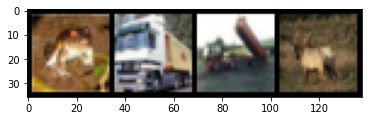

In [1]:
import torch
import torch.nn as nn
from torch import Tensor
import torch.nn.functional as F
from torchvision import transforms, datasets
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from typing import Tuple

import math
import numpy as np
import matplotlib.pyplot as plt
import pdb

def show(img):
    img = img.permute(1,2,0).numpy()
    plt.imshow(img)
    plt.show()

transform = transforms.Compose([ transforms.ToTensor() ])
cifar = datasets.CIFAR10('../datasets', transform=transform)
cifar_loader = DataLoader(cifar, batch_size=4)

# Loading a batch for sanity checks.
cifar_batch = next(iter(cifar_loader))[0]
cifar_grid = make_grid(cifar_batch)
show(cifar_grid)

In [2]:
def gaussian_filter_bank(img_shape: Tuple, n: int, g_x: Tensor, g_y: Tensor, var: Tensor, delta: Tensor, device:str = 'cpu') -> Tuple[Tensor, Tensor]:
    """ Generate a 2D Gaussian Filter bank given the selective attention parameters emitted from our decoder.
        An increase in the stride (log_delta) => larger effective receptive field but lower resolution.
        
        https://en.wikipedia.org/wiki/Filter_bank
        
        RECALL: N-D Gaussian Kernels can be constructed via the product of N 1-D Gaussian kernels since it is seperable.
                Therefore, we split each 2D gaussian kernel into horizontal and vertical 1-D Gaussian kernels for inner product later on.
                
    """
    bn,ch,B,A = img_shape
        
    #  g_x, g_y are expected to be within the ranges [-1., 1.], [-1.,1.]
    # Furthermore, the origin of the coordinate system is the center of the image.
    # delta (stride) would be between [0.,1.]
    # After Re-Scaling, they will be within pixel coordinate space relative to the input image size.
    g_x = ((A+1)/2)*(g_x + 1)
    g_y = ((B+1)/2)*(g_y + 1)
    delta = (max(A,B) - 1) * delta / (n-1)

    
    # Mean locations
    # mean_x: (b,n), mean_y: (b,n)
    mean_x = g_x + (torch.arange(n).to(device) - (n-1)/2)*delta
    mean_y = g_y + (torch.arange(n).to(device) - (n-1)/2)*delta
    
    # 1-D Gaussians
    # F_x: (b,n,A), F_y: (b,n,B)
    F_x = (-(torch.arange(A).to(device).view(1,1,-1) - mean_x.view(bn,-1,1))**2 / (2*var.view(bn,-1,1) + 1e-5)).exp()
    F_y = (-(torch.arange(B).to(device).view(1,1,-1) - mean_y.view(bn,-1,1))**2 / (2*var.view(bn,-1,1) + 1e-5)).exp()
    
    assert not F_x.isnan().any()
    assert not F_y.isnan().any()
    
    # Normalization Constants
    Z_x = F_x.sum(axis=2, keepdim=True) + 1e-5
    Z_y = F_y.sum(axis=2, keepdim=True) + 1e-5
    
    assert not Z_x.isnan().any()
    assert not Z_y.isnan().any()
    
    f_x = (F_x / Z_x).unsqueeze(1)
    f_y = (F_y / Z_y).unsqueeze(1)
    
    assert not f_x.isnan().any()
    assert not f_y.isnan().any()

    # Keep it in a (B,C,H,W) shape
    # since these operations are applied to both the original image and error images
    return f_x, f_y

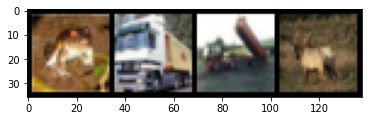

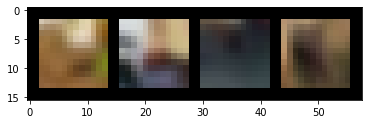

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


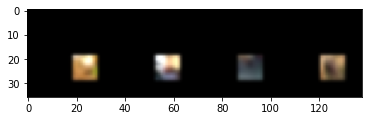

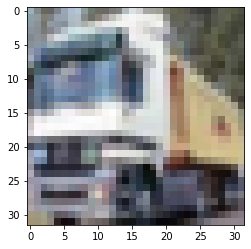

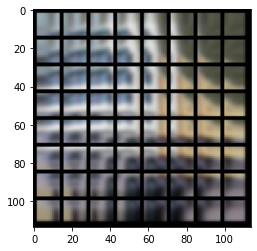

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


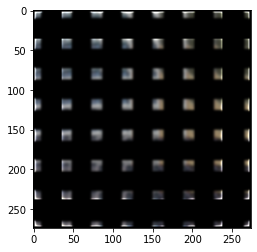

In [3]:

# Sanity Checks
img = next(iter(cifar_loader))[0]
show(make_grid(img))
b,c,h,w = img.shape

# Some dummy attention control parameters
n = 12
gamma = 1.0
g_x = 0.3
g_y = 0.3
var = 0.4
delta = 0.3
dummy_ctrls = torch.tensor([g_x,g_y,var, delta]).view(1,4,1).repeat(b,1,1)
x, y, var, delta = dummy_ctrls[:,0], dummy_ctrls[:,1], dummy_ctrls[:,2], dummy_ctrls[:,3]

# Get filters
f_x, f_y = gaussian_filter_bank(img.shape, n, x, y, var, delta)
f_x_t = torch.transpose(f_x,2,3)
f_y_t = torch.transpose(f_y,2,3)
filtered_img = f_y @ img @ f_x_t
recon_img = (f_y_t @ filtered_img @ f_x)

# Display
show(make_grid(filtered_img))
show(make_grid(recon_img))

# Move the attention from top left corner to bottom right corner
# for a single image
img = next(iter(cifar_loader))[0][1].unsqueeze(0)
n=12
filtered_imgs = []
recon_imgs = []
steps = 8
var = 2
delta = 0.4
for g_y in torch.linspace(-0.96,0.96,steps):
    for g_x in torch.linspace(-0.96,0.96,steps):
        dummy_ctrls = torch.tensor([g_x,g_y,var, delta]).view(1,4,1)
        x, y, var, delta = dummy_ctrls[:,0], dummy_ctrls[:,1], dummy_ctrls[:,2], dummy_ctrls[:,3]
        
        f_x, f_y = gaussian_filter_bank(img.shape, n, x,y, var, delta)
        f_x_t = torch.transpose(f_x,2,3)
        f_y_t = torch.transpose(f_y,2,3)

        filtered_img = f_y @ img @ f_x_t
        recon_img  = (f_y_t @ filtered_img @ f_x)

        filtered_imgs.append(filtered_img)
        recon_imgs.append(recon_img)
show(make_grid(img))
show(make_grid(torch.cat(filtered_imgs,axis=0)))
show(make_grid(torch.cat(recon_imgs,axis=0)))

In [4]:
from torch.nn.utils import weight_norm

class DRAW(nn.Module):
    def __init__(self, img_shape: Tuple, hidden_dim: Tensor, z_dim: Tensor, num_glimpses: int,
                 read_size: int = 2, write_size: int = 5, attention: bool = True):
        super().__init__()
        self.img_shape = img_shape
        self.hidden_dim = hidden_dim
        self.z_dim = z_dim
        self.num_glimpses = num_glimpses
        self.read_size = read_size
        self.write_size = write_size
        self.attention = attention
        self.write_shape = (img_shape[0], write_size, write_size) if attention else img_shape
        
        # Using Weight Normalization
        # https://arxiv.org/pdf/1602.07868.pdf
        
        assert len(img_shape) == 3, 'Incorrect Image Shaped, expacted 3 dimensions, (C,H,W)'
        
        # Encoder
        # Input: The concatenation of either the result of the two read operations from the
        # original image and the error image patches with attention;
        # Or it is the full images concatenated together without attention.
        # The previous time-step of the decoder is also concatenated to this input.
        # Output: Hidden dim
        patch_in_dim = 2*img_shape[0]*read_size**2 if attention else 2*img_shape[0]*img_shape[1]*img_shape[2]
        self.encoder = nn.LSTM(patch_in_dim + hidden_dim, hidden_dim)
        param_names = list(self.encoder._parameters.keys())
        for param_name in param_names:
            self.encoder = weight_norm(self.encoder, param_name)
        
        # Decoder 
        # Input: Is simply the P(Z|h_enc)
        # Output: Hidden dim
        self.decoder = nn.LSTM(z_dim, hidden_dim)
        param_names = list(self.decoder._parameters.keys())
        for param_name in param_names:
            self.decoder = weight_norm(self.decoder, param_name)
        
        # Get the hidden state of the decoder
        # and perform a linear transformation to get control parameters for attention:
        # g_x, g_y, log(sigma^2), log(delta), log(gamma)
        self.controls = weight_norm(nn.Linear(hidden_dim, 5))
        
        # Project decoder to image
        out_dim = img_shape[0]*write_size**2 if attention else img_shape[0]*img_shape[1]*img_shape[2]
        self.proj = weight_norm(nn.Linear(hidden_dim, out_dim))
        
        # Our Prior distribution to sample from for reparametrization trick.
        self.z_prior = torch.distributions.Normal(loc=0.,scale=1.)
        self.enc_mu = weight_norm(nn.Linear(hidden_dim, z_dim))
        self.enc_std = weight_norm(nn.Linear(hidden_dim, z_dim))
        
        self.recon_loss = torch.nn.BCEWithLogitsLoss()
        
    def get_ctrls(self, h):
        """ Get the controls from the output of the decoder
        """
        ctrl = self.controls(h).squeeze().unsqueeze(-1)
        g_x, g_y, log_var, log_delta, log_gamma = ctrl[:,0], ctrl[:,1], ctrl[:,2], ctrl[:,3], ctrl[:,4]
        var = log_var.exp()
        delta = log_delta.exp()
        gamma = log_gamma.exp()
        
        assert not g_x.isnan().any()
        assert not g_y.isnan().any()
        assert not var.isnan().any()
        assert not delta.isnan().any()
        assert not gamma.isnan().any()

        return g_x, g_y, var, delta, gamma

    def read(self, input: Tensor, error: Tensor, h_prev_dec: Tensor, device: str = 'cpu') -> Tuple[Tensor, Tensor]:
        if not self.attention:
            return torch.cat((input,error),axis=1), None # Concat along channel dimension
        
        # Get Controls
        g_x,g_y,var,delta,gamma = self.get_ctrls(h_prev_dec)
        
        # Construct Filters
        f_x, f_y = gaussian_filter_bank(input.shape, self.read_size, g_x,g_y, var, delta, device)
        f_y_t = torch.transpose(f_y,2,3)
        f_x_t = torch.transpose(f_x,2,3)
        
        # Concat
        r_t = torch.cat([f_y @ input @ f_x_t, f_y @ error @ f_x_t], axis=1) * gamma.view(-1,1,1,1)
        assert not r_t.isnan().any()
        return r_t, (g_x,g_y,var,delta,gamma)
    
    def write(self, h_dec: Tensor, device: str = 'cpu'):
        w_shape = (h_dec.shape[1], *self.write_shape)
        w = self.proj(h_dec).view(w_shape)
        if not self.attention:
            return w, None
        
        # Get Controls
        g_x,g_y,var,delta,gamma = self.get_ctrls(h_dec)
        
        # Construct Filters
        img_shape = (h_dec.shape[1], *self.img_shape)
        f_x, f_y = gaussian_filter_bank(img_shape, self.write_size, g_x,g_y, var, delta, device)
        f_y_t = torch.transpose(f_y,2,3)
        
        w_t = (1/(gamma.view(-1,1,1,1)+1e-5))*f_y_t @ w @ f_x
        
        return w_t, (g_x,g_y,var,delta,gamma)
    
    def forward(self, input: Tensor, device:str = 'cpu'):
        b,c,h,w = input.shape

        # Initialize states
        h_encs, c_encs, h_decs, c_decs, cs, controls = {}, {}, {}, {}, {}, {}
        mus, stds = {},{}
        cs[-1] = torch.zeros(input.shape, requires_grad=True).to(device)
        h_decs[-1] = torch.randn(1,b,self.hidden_dim, requires_grad=True).to(device)
        c_decs[-1] = torch.randn(1,b,self.hidden_dim, requires_grad=True).to(device)
        h_encs[-1] = torch.randn(1,b,self.hidden_dim, requires_grad=True).to(device)
        c_encs[-1] = torch.randn(1,b,self.hidden_dim, requires_grad=True).to(device)
        
        # Keep Track r_ctrls, w_ctrls for debug / viz
        r_ctrls, w_ctrls = {}, {}
        
        # Un-Roll Encoder and Decoders across the number of glimpses
        for i in range(self.num_glimpses):
            error = input - cs[i-1].sigmoid()
            
            # Read and Encode
            r, r_ctrl = self.read(input, error, h_decs[i-1], device)
            assert not r.isnan().any()
            r = torch.cat([r.view(1,b,-1), h_decs[i-1]],axis=2)
            _, (h_encs[i], c_encs[i]) = self.encoder(r, (h_encs[i-1], c_encs[i-1]))
            
            # Sample Z, Reparameterization Trick
            mus[i] = self.enc_mu(h_encs[i])
            stds[i] = self.enc_std(h_encs[i]).exp()
            eps = self.z_prior.sample(stds[i].shape).to(device)
            z = mus[i] + stds[i]*eps
            
            # Decode and Write
            _, (h_decs[i], c_decs[i]) = self.decoder(z, (h_decs[i-1], c_decs[i-1]))
            w, w_ctrl = self.write(h_decs[i], device)
            assert not w.isnan().any()
            cs[i] = cs[i-1] + w
            
            if self.attention:
                r_ctrls[i], w_ctrls[i] = r_ctrl, w_ctrl
        
        # KL-Divergence ( Regularization Term for decoder and prior )
        l_z = 0.
        for i in range(self.num_glimpses):
            l_z += (mus[i]**2 + stds[i]**2 - (stds[i]**2).log())

        l_z = (l_z - self.num_glimpses) / 2
        l_z = l_z.mean()
        
        # Reconstruction Loss (Cross Entropy)
        # D(X|C_T) ~ Bernoulli, Interpret RGB as emission probabilities
        l_x = F.binary_cross_entropy_with_logits(cs[self.num_glimpses-1].view(b,-1), input.view(b,-1))
        
        return cs, l_x, l_z, (r_ctrls, w_ctrls)
    
    @torch.no_grad()
    def sample(self, num_samples: int, device: str = 'cpu'):
        h_decs, c_decs, cs = {}, {}, {}
        h_decs[-1] = torch.zeros(1,num_samples,self.hidden_dim).to(device)
        c_decs[-1] = torch.zeros(1,num_samples,self.hidden_dim).to(device)
        cs[-1] = torch.zeros((num_samples, *self.img_shape)).to(device)
        
        for i in range(self.num_glimpses):
            z = self.z_prior.sample((1, num_samples, self.z_dim)).to(device)
            _, (h_decs[i], c_decs[i]) = self.decoder(z, (h_decs[i-1], c_decs[i-1]))
            w, _ = self.write(h_decs[i], device)
            cs[i] = cs[i-1] + w

        return cs


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


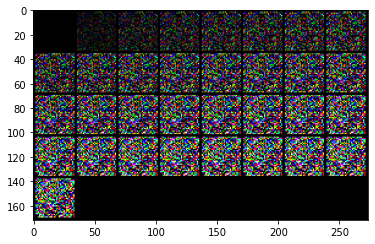

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


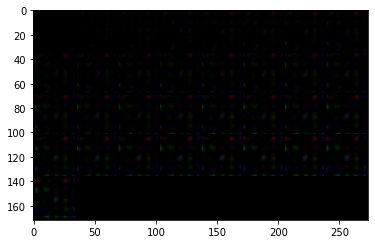

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


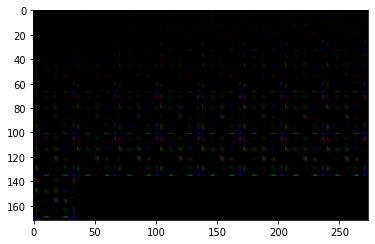

In [5]:
# Sanity Checks
def show_cs(cs: dict):
    first_batch = []
    for k,v in cs.items():
        first_batch.append(v[1].cpu().detach())
    first_batch = torch.stack(first_batch, axis=0)
    show(make_grid(first_batch))
x = next(iter(cifar_loader))[0]

draw = DRAW(x.shape[1:], 400, 200, 32, 5, attention=False)
cs, l_x, l_z, _ = draw(x)
show_cs(cs)
loss = l_x + l_z
loss.backward()

draw = DRAW(x.shape[1:], 400, 200, 32, 2, attention=True)
cs, l_x, l_z, _ = draw(x)
show_cs(cs)
loss = l_x + l_z
loss.backward()
# show_cs(cs)
cs = draw.sample(10)
show_cs(cs)

cuda


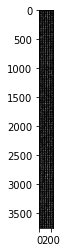

/mnt/Lab/deep_models/.venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:581: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


Epoch [1/400] Batch: [1/60] KL-Divergence: 0.23825229704380035 Cross-Entropy: 0.6990513205528259 Loss: 0.9373036026954651
Epoch [1/400] Batch: [2/60] KL-Divergence: 0.1614568680524826 Cross-Entropy: 0.689856231212616 Loss: 0.8513131141662598
Epoch [1/400] Batch: [3/60] KL-Divergence: 0.11507420241832733 Cross-Entropy: 0.6806549429893494 Loss: 0.7957291603088379
Epoch [1/400] Batch: [4/60] KL-Divergence: 0.08571401238441467 Cross-Entropy: 0.6711567044258118 Loss: 0.7568707466125488
Epoch [1/400] Batch: [5/60] KL-Divergence: 0.07225024700164795 Cross-Entropy: 0.6613215804100037 Loss: 0.7335718274116516
Epoch [1/400] Batch: [6/60] KL-Divergence: 0.06749683618545532 Cross-Entropy: 0.6500778198242188 Loss: 0.7175746560096741
Epoch [1/400] Batch: [7/60] KL-Divergence: 0.06340713798999786 Cross-Entropy: 0.635144054889679 Loss: 0.6985511779785156
Epoch [1/400] Batch: [8/60] KL-Divergence: 0.05963517352938652 Cross-Entropy: 0.6155741810798645 Loss: 0.6752093434333801
Epoch [1/400] Batch: [9/60]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [1/400] Batch: [60/60] KL-Divergence: 0.026220832020044327 Cross-Entropy: 0.2772546410560608 Loss: 0.3034754693508148
Epoch [1/400] Batch: [60/60] KL-Divergence: 0.026220832020044327 Cross-Entropy: 0.2772546410560608 Loss: 0.3034754693508148


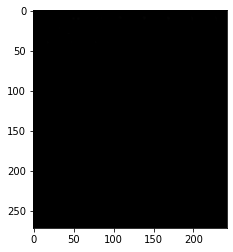

Epoch [2/400] Batch: [1/60] KL-Divergence: 0.026036538183689117 Cross-Entropy: 0.26480644941329956 Loss: 0.2908429801464081
Epoch [2/400] Batch: [2/60] KL-Divergence: 0.02559192292392254 Cross-Entropy: 0.2650156021118164 Loss: 0.2906075119972229
Epoch [2/400] Batch: [3/60] KL-Divergence: 0.025591284036636353 Cross-Entropy: 0.26831555366516113 Loss: 0.2939068377017975
Epoch [2/400] Batch: [4/60] KL-Divergence: 0.025138866156339645 Cross-Entropy: 0.26276469230651855 Loss: 0.2879035472869873
Epoch [2/400] Batch: [5/60] KL-Divergence: 0.025081312283873558 Cross-Entropy: 0.2730102837085724 Loss: 0.2980915904045105
Epoch [2/400] Batch: [6/60] KL-Divergence: 0.02473822608590126 Cross-Entropy: 0.27094587683677673 Loss: 0.2956840991973877
Epoch [2/400] Batch: [7/60] KL-Divergence: 0.024781791493296623 Cross-Entropy: 0.26526305079460144 Loss: 0.2900448441505432
Epoch [2/400] Batch: [8/60] KL-Divergence: 0.02429347299039364 Cross-Entropy: 0.25966978073120117 Loss: 0.28396326303482056
Epoch [2/400

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [2/400] Batch: [60/60] KL-Divergence: 0.016066420823335648 Cross-Entropy: 0.2787338197231293 Loss: 0.2948002517223358
Epoch [2/400] Batch: [60/60] KL-Divergence: 0.016066420823335648 Cross-Entropy: 0.2787338197231293 Loss: 0.2948002517223358


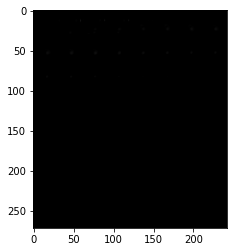

Epoch [3/400] Batch: [1/60] KL-Divergence: 0.016043508425354958 Cross-Entropy: 0.2638014853000641 Loss: 0.2798449993133545
Epoch [3/400] Batch: [2/60] KL-Divergence: 0.016099421307444572 Cross-Entropy: 0.26404091715812683 Loss: 0.28014034032821655
Epoch [3/400] Batch: [3/60] KL-Divergence: 0.01606152020394802 Cross-Entropy: 0.267652302980423 Loss: 0.28371381759643555
Epoch [3/400] Batch: [4/60] KL-Divergence: 0.01590598188340664 Cross-Entropy: 0.2629314064979553 Loss: 0.2788373827934265
Epoch [3/400] Batch: [5/60] KL-Divergence: 0.016257282346487045 Cross-Entropy: 0.2721324861049652 Loss: 0.28838977217674255
Epoch [3/400] Batch: [6/60] KL-Divergence: 0.01575583592057228 Cross-Entropy: 0.2700735330581665 Loss: 0.2858293652534485
Epoch [3/400] Batch: [7/60] KL-Divergence: 0.015468623489141464 Cross-Entropy: 0.2639203369617462 Loss: 0.279388964176178
Epoch [3/400] Batch: [8/60] KL-Divergence: 0.015554794110357761 Cross-Entropy: 0.2582437992095947 Loss: 0.2737985849380493
Epoch [3/400] Bat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [3/400] Batch: [60/60] KL-Divergence: 0.010837563313543797 Cross-Entropy: 0.27780526876449585 Loss: 0.2886428236961365
Epoch [3/400] Batch: [60/60] KL-Divergence: 0.010837563313543797 Cross-Entropy: 0.27780526876449585 Loss: 0.2886428236961365


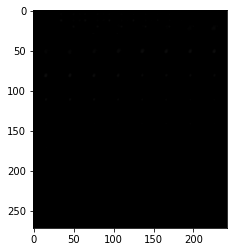

Epoch [4/400] Batch: [1/60] KL-Divergence: 0.010711930692195892 Cross-Entropy: 0.26338639855384827 Loss: 0.27409833669662476
Epoch [4/400] Batch: [2/60] KL-Divergence: 0.010616157203912735 Cross-Entropy: 0.2635790705680847 Loss: 0.27419522404670715
Epoch [4/400] Batch: [3/60] KL-Divergence: 0.010635175742208958 Cross-Entropy: 0.2670687735080719 Loss: 0.2777039408683777
Epoch [4/400] Batch: [4/60] KL-Divergence: 0.010606875643134117 Cross-Entropy: 0.26263922452926636 Loss: 0.2732461094856262
Epoch [4/400] Batch: [5/60] KL-Divergence: 0.01057552732527256 Cross-Entropy: 0.2718488276004791 Loss: 0.28242436051368713
Epoch [4/400] Batch: [6/60] KL-Divergence: 0.01033894531428814 Cross-Entropy: 0.2696860134601593 Loss: 0.2800249457359314
Epoch [4/400] Batch: [7/60] KL-Divergence: 0.010593235492706299 Cross-Entropy: 0.26355475187301636 Loss: 0.27414798736572266
Epoch [4/400] Batch: [8/60] KL-Divergence: 0.010426821187138557 Cross-Entropy: 0.25794172286987305 Loss: 0.26836854219436646
Epoch [4/

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [4/400] Batch: [60/60] KL-Divergence: 0.00758885545656085 Cross-Entropy: 0.276178240776062 Loss: 0.28376710414886475
Epoch [4/400] Batch: [60/60] KL-Divergence: 0.00758885545656085 Cross-Entropy: 0.276178240776062 Loss: 0.28376710414886475


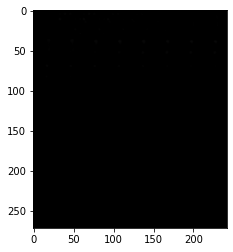

Epoch [5/400] Batch: [1/60] KL-Divergence: 0.007610287982970476 Cross-Entropy: 0.26328665018081665 Loss: 0.27089694142341614
Epoch [5/400] Batch: [2/60] KL-Divergence: 0.007672265637665987 Cross-Entropy: 0.26360198855400085 Loss: 0.27127426862716675
Epoch [5/400] Batch: [3/60] KL-Divergence: 0.007495648693293333 Cross-Entropy: 0.2668052315711975 Loss: 0.27430087327957153
Epoch [5/400] Batch: [4/60] KL-Divergence: 0.007487874012440443 Cross-Entropy: 0.26191356778144836 Loss: 0.2694014310836792
Epoch [5/400] Batch: [5/60] KL-Divergence: 0.00738555146381259 Cross-Entropy: 0.2716805636882782 Loss: 0.2790661156177521
Epoch [5/400] Batch: [6/60] KL-Divergence: 0.007275257259607315 Cross-Entropy: 0.2692655920982361 Loss: 0.2765408456325531
Epoch [5/400] Batch: [7/60] KL-Divergence: 0.00728183938190341 Cross-Entropy: 0.2634502351284027 Loss: 0.2707320749759674
Epoch [5/400] Batch: [8/60] KL-Divergence: 0.007289061322808266 Cross-Entropy: 0.25803476572036743 Loss: 0.26532381772994995
Epoch [5/4

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [5/400] Batch: [60/60] KL-Divergence: 0.005587037652730942 Cross-Entropy: 0.2751758396625519 Loss: 0.2807628810405731
Epoch [5/400] Batch: [60/60] KL-Divergence: 0.005587037652730942 Cross-Entropy: 0.2751758396625519 Loss: 0.2807628810405731


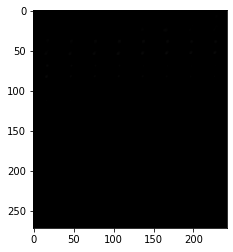

Epoch [6/400] Batch: [1/60] KL-Divergence: 0.005389024503529072 Cross-Entropy: 0.2628227770328522 Loss: 0.26821181178092957
Epoch [6/400] Batch: [2/60] KL-Divergence: 0.005493447184562683 Cross-Entropy: 0.26345396041870117 Loss: 0.26894742250442505
Epoch [6/400] Batch: [3/60] KL-Divergence: 0.005351527594029903 Cross-Entropy: 0.2670400142669678 Loss: 0.27239152789115906
Epoch [6/400] Batch: [4/60] KL-Divergence: 0.005351295229047537 Cross-Entropy: 0.2614628076553345 Loss: 0.26681411266326904
Epoch [6/400] Batch: [5/60] KL-Divergence: 0.005423883441835642 Cross-Entropy: 0.27164748311042786 Loss: 0.27707135677337646
Epoch [6/400] Batch: [6/60] KL-Divergence: 0.005274091847240925 Cross-Entropy: 0.2691805362701416 Loss: 0.27445462346076965
Epoch [6/400] Batch: [7/60] KL-Divergence: 0.00523980101570487 Cross-Entropy: 0.26348504424095154 Loss: 0.26872485876083374
Epoch [6/400] Batch: [8/60] KL-Divergence: 0.005240994971245527 Cross-Entropy: 0.25822821259498596 Loss: 0.26346921920776367
Epoch

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [6/400] Batch: [60/60] KL-Divergence: 0.0041685099713504314 Cross-Entropy: 0.27478817105293274 Loss: 0.27895668148994446
Epoch [6/400] Batch: [60/60] KL-Divergence: 0.0041685099713504314 Cross-Entropy: 0.27478817105293274 Loss: 0.27895668148994446


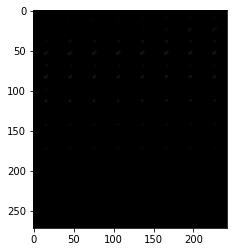

Epoch [7/400] Batch: [1/60] KL-Divergence: 0.004242492374032736 Cross-Entropy: 0.2627454996109009 Loss: 0.26698797941207886
Epoch [7/400] Batch: [2/60] KL-Divergence: 0.004146283492445946 Cross-Entropy: 0.26319369673728943 Loss: 0.2673399746417999
Epoch [7/400] Batch: [3/60] KL-Divergence: 0.0041739256121218204 Cross-Entropy: 0.26692909002304077 Loss: 0.27110302448272705
Epoch [7/400] Batch: [4/60] KL-Divergence: 0.00400709081441164 Cross-Entropy: 0.26127609610557556 Loss: 0.2652831971645355
Epoch [7/400] Batch: [5/60] KL-Divergence: 0.003992283716797829 Cross-Entropy: 0.27159056067466736 Loss: 0.27558284997940063
Epoch [7/400] Batch: [6/60] KL-Divergence: 0.004012185148894787 Cross-Entropy: 0.26894304156303406 Loss: 0.2729552388191223
Epoch [7/400] Batch: [7/60] KL-Divergence: 0.003974006976932287 Cross-Entropy: 0.26344987750053406 Loss: 0.2674238979816437
Epoch [7/400] Batch: [8/60] KL-Divergence: 0.003979216329753399 Cross-Entropy: 0.25863054394721985 Loss: 0.2626097500324249
Epoch 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [7/400] Batch: [60/60] KL-Divergence: 0.003259162185713649 Cross-Entropy: 0.27497097849845886 Loss: 0.27823013067245483
Epoch [7/400] Batch: [60/60] KL-Divergence: 0.003259162185713649 Cross-Entropy: 0.27497097849845886 Loss: 0.27823013067245483


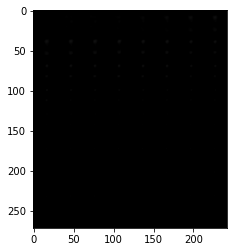

Epoch [8/400] Batch: [1/60] KL-Divergence: 0.00321570155210793 Cross-Entropy: 0.26268699765205383 Loss: 0.26590269804000854
Epoch [8/400] Batch: [2/60] KL-Divergence: 0.0031839918810874224 Cross-Entropy: 0.26300254464149475 Loss: 0.26618653535842896
Epoch [8/400] Batch: [3/60] KL-Divergence: 0.003218685742467642 Cross-Entropy: 0.266519159078598 Loss: 0.2697378396987915
Epoch [8/400] Batch: [4/60] KL-Divergence: 0.003249818691983819 Cross-Entropy: 0.26141029596328735 Loss: 0.264660120010376
Epoch [8/400] Batch: [5/60] KL-Divergence: 0.003140351502224803 Cross-Entropy: 0.2717398703098297 Loss: 0.27488023042678833
Epoch [8/400] Batch: [6/60] KL-Divergence: 0.0031881846953183413 Cross-Entropy: 0.268960177898407 Loss: 0.27214837074279785
Epoch [8/400] Batch: [7/60] KL-Divergence: 0.0031792791560292244 Cross-Entropy: 0.263210654258728 Loss: 0.266389936208725
Epoch [8/400] Batch: [8/60] KL-Divergence: 0.003173172939568758 Cross-Entropy: 0.2586557865142822 Loss: 0.2618289589881897
Epoch [8/400

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [8/400] Batch: [60/60] KL-Divergence: 0.002598867751657963 Cross-Entropy: 0.27563682198524475 Loss: 0.27823570370674133
Epoch [8/400] Batch: [60/60] KL-Divergence: 0.002598867751657963 Cross-Entropy: 0.27563682198524475 Loss: 0.27823570370674133


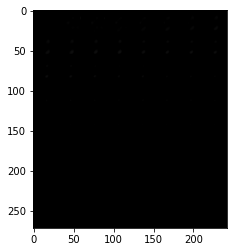

Epoch [9/400] Batch: [1/60] KL-Divergence: 0.0025729136541485786 Cross-Entropy: 0.2627442479133606 Loss: 0.2653171718120575
Epoch [9/400] Batch: [2/60] KL-Divergence: 0.002576350001618266 Cross-Entropy: 0.2629636526107788 Loss: 0.2655400037765503
Epoch [9/400] Batch: [3/60] KL-Divergence: 0.0025672789197415113 Cross-Entropy: 0.26648902893066406 Loss: 0.2690563201904297
Epoch [9/400] Batch: [4/60] KL-Divergence: 0.0024873758666217327 Cross-Entropy: 0.26150137186050415 Loss: 0.263988733291626
Epoch [9/400] Batch: [5/60] KL-Divergence: 0.002509345067664981 Cross-Entropy: 0.2715877890586853 Loss: 0.27409714460372925
Epoch [9/400] Batch: [6/60] KL-Divergence: 0.0025151302106678486 Cross-Entropy: 0.2690805494785309 Loss: 0.27159568667411804
Epoch [9/400] Batch: [7/60] KL-Divergence: 0.0025199896190315485 Cross-Entropy: 0.2631417214870453 Loss: 0.26566171646118164
Epoch [9/400] Batch: [8/60] KL-Divergence: 0.0026084233541041613 Cross-Entropy: 0.25825974345207214 Loss: 0.2608681619167328
Epoch

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [9/400] Batch: [60/60] KL-Divergence: 0.00211048754863441 Cross-Entropy: 0.27567803859710693 Loss: 0.27778851985931396
Epoch [9/400] Batch: [60/60] KL-Divergence: 0.00211048754863441 Cross-Entropy: 0.27567803859710693 Loss: 0.27778851985931396


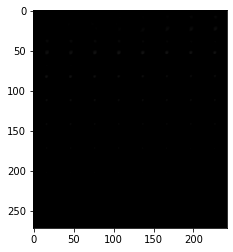

Epoch [10/400] Batch: [1/60] KL-Divergence: 0.002122843638062477 Cross-Entropy: 0.26271092891693115 Loss: 0.2648337781429291
Epoch [10/400] Batch: [2/60] KL-Divergence: 0.0021155481226742268 Cross-Entropy: 0.2628731429576874 Loss: 0.2649886906147003
Epoch [10/400] Batch: [3/60] KL-Divergence: 0.0020915274508297443 Cross-Entropy: 0.2665162980556488 Loss: 0.26860782504081726
Epoch [10/400] Batch: [4/60] KL-Divergence: 0.0021656483877450228 Cross-Entropy: 0.26149675250053406 Loss: 0.2636623978614807
Epoch [10/400] Batch: [5/60] KL-Divergence: 0.0020510656759142876 Cross-Entropy: 0.27155420184135437 Loss: 0.27360525727272034
Epoch [10/400] Batch: [6/60] KL-Divergence: 0.0020079747773706913 Cross-Entropy: 0.26898473501205444 Loss: 0.2709926962852478
Epoch [10/400] Batch: [7/60] KL-Divergence: 0.0021055680699646473 Cross-Entropy: 0.2631325125694275 Loss: 0.26523807644844055
Epoch [10/400] Batch: [8/60] KL-Divergence: 0.002031578216701746 Cross-Entropy: 0.2581595480442047 Loss: 0.260191112756

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [10/400] Batch: [60/60] KL-Divergence: 0.0017453355249017477 Cross-Entropy: 0.27534493803977966 Loss: 0.27709028124809265
Epoch [10/400] Batch: [60/60] KL-Divergence: 0.0017453355249017477 Cross-Entropy: 0.27534493803977966 Loss: 0.27709028124809265


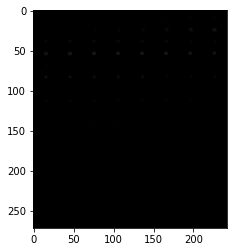

Epoch [11/400] Batch: [1/60] KL-Divergence: 0.001750499359332025 Cross-Entropy: 0.2625350058078766 Loss: 0.26428550481796265
Epoch [11/400] Batch: [2/60] KL-Divergence: 0.0016876168083399534 Cross-Entropy: 0.2629629671573639 Loss: 0.2646505832672119
Epoch [11/400] Batch: [3/60] KL-Divergence: 0.001752578653395176 Cross-Entropy: 0.26647111773490906 Loss: 0.26822370290756226
Epoch [11/400] Batch: [4/60] KL-Divergence: 0.0017212878447026014 Cross-Entropy: 0.2613961696624756 Loss: 0.2631174623966217
Epoch [11/400] Batch: [5/60] KL-Divergence: 0.001715506543405354 Cross-Entropy: 0.2714817225933075 Loss: 0.2731972336769104
Epoch [11/400] Batch: [6/60] KL-Divergence: 0.001699278480373323 Cross-Entropy: 0.2687746286392212 Loss: 0.2704738974571228
Epoch [11/400] Batch: [7/60] KL-Divergence: 0.001703609828837216 Cross-Entropy: 0.2631025016307831 Loss: 0.2648061215877533
Epoch [11/400] Batch: [8/60] KL-Divergence: 0.0016916145104914904 Cross-Entropy: 0.2582370638847351 Loss: 0.2599286735057831
Ep

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [11/400] Batch: [60/60] KL-Divergence: 0.0014734339201822877 Cross-Entropy: 0.274638295173645 Loss: 0.2761117219924927
Epoch [11/400] Batch: [60/60] KL-Divergence: 0.0014734339201822877 Cross-Entropy: 0.274638295173645 Loss: 0.2761117219924927


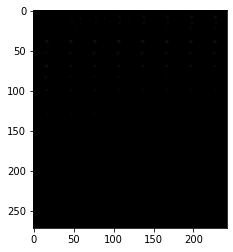

Epoch [12/400] Batch: [1/60] KL-Divergence: 0.0015048806089907885 Cross-Entropy: 0.2625526487827301 Loss: 0.2640575170516968
Epoch [12/400] Batch: [2/60] KL-Divergence: 0.0014356030151247978 Cross-Entropy: 0.2630186378955841 Loss: 0.2644542455673218
Epoch [12/400] Batch: [3/60] KL-Divergence: 0.0015233037993311882 Cross-Entropy: 0.2667730748653412 Loss: 0.26829639077186584
Epoch [12/400] Batch: [4/60] KL-Divergence: 0.001462435582652688 Cross-Entropy: 0.2611660957336426 Loss: 0.2626285254955292
Epoch [12/400] Batch: [5/60] KL-Divergence: 0.0014263088814914227 Cross-Entropy: 0.27134445309638977 Loss: 0.2727707624435425
Epoch [12/400] Batch: [6/60] KL-Divergence: 0.0014433086616918445 Cross-Entropy: 0.2688077390193939 Loss: 0.2702510356903076
Epoch [12/400] Batch: [7/60] KL-Divergence: 0.001471594674512744 Cross-Entropy: 0.26331642270088196 Loss: 0.26478803157806396
Epoch [12/400] Batch: [8/60] KL-Divergence: 0.0014386356342583895 Cross-Entropy: 0.2586105465888977 Loss: 0.260049194097518

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [12/400] Batch: [60/60] KL-Divergence: 0.0012278436915948987 Cross-Entropy: 0.2744116485118866 Loss: 0.27563950419425964
Epoch [12/400] Batch: [60/60] KL-Divergence: 0.0012278436915948987 Cross-Entropy: 0.2744116485118866 Loss: 0.27563950419425964


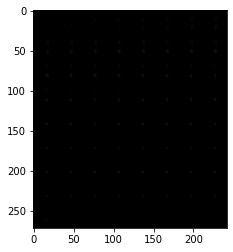

Epoch [13/400] Batch: [1/60] KL-Divergence: 0.0012403331929817796 Cross-Entropy: 0.26255303621292114 Loss: 0.26379337906837463
Epoch [13/400] Batch: [2/60] KL-Divergence: 0.0012420827988535166 Cross-Entropy: 0.2629036009311676 Loss: 0.2641456723213196
Epoch [13/400] Batch: [3/60] KL-Divergence: 0.001266517792828381 Cross-Entropy: 0.2668607532978058 Loss: 0.2681272625923157
Epoch [13/400] Batch: [4/60] KL-Divergence: 0.0012479330180212855 Cross-Entropy: 0.26112836599349976 Loss: 0.2623763084411621
Epoch [13/400] Batch: [5/60] KL-Divergence: 0.0012379359686747193 Cross-Entropy: 0.2716400921344757 Loss: 0.2728780210018158
Epoch [13/400] Batch: [6/60] KL-Divergence: 0.0012779519893229008 Cross-Entropy: 0.2687269449234009 Loss: 0.27000489830970764
Epoch [13/400] Batch: [7/60] KL-Divergence: 0.0012846564641222358 Cross-Entropy: 0.2632697820663452 Loss: 0.2645544409751892
Epoch [13/400] Batch: [8/60] KL-Divergence: 0.0012373777572065592 Cross-Entropy: 0.25908413529396057 Loss: 0.2603215277194

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [13/400] Batch: [60/60] KL-Divergence: 0.0010919420747086406 Cross-Entropy: 0.2743256092071533 Loss: 0.2754175364971161
Epoch [13/400] Batch: [60/60] KL-Divergence: 0.0010919420747086406 Cross-Entropy: 0.2743256092071533 Loss: 0.2754175364971161


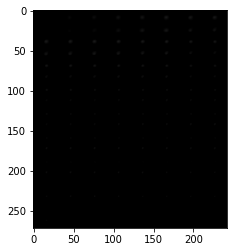

Epoch [14/400] Batch: [1/60] KL-Divergence: 0.001088740536943078 Cross-Entropy: 0.2626831829547882 Loss: 0.2637719213962555
Epoch [14/400] Batch: [2/60] KL-Divergence: 0.0010849282843992114 Cross-Entropy: 0.26283812522888184 Loss: 0.2639230489730835
Epoch [14/400] Batch: [3/60] KL-Divergence: 0.00107492133975029 Cross-Entropy: 0.2667352855205536 Loss: 0.267810195684433
Epoch [14/400] Batch: [4/60] KL-Divergence: 0.001094501349143684 Cross-Entropy: 0.26121267676353455 Loss: 0.26230716705322266
Epoch [14/400] Batch: [5/60] KL-Divergence: 0.0010883278446272016 Cross-Entropy: 0.27176234126091003 Loss: 0.2728506624698639
Epoch [14/400] Batch: [6/60] KL-Divergence: 0.0010755759431049228 Cross-Entropy: 0.26874810457229614 Loss: 0.26982367038726807
Epoch [14/400] Batch: [7/60] KL-Divergence: 0.00108765484765172 Cross-Entropy: 0.2631719410419464 Loss: 0.26425960659980774
Epoch [14/400] Batch: [8/60] KL-Divergence: 0.0010728697525337338 Cross-Entropy: 0.259040892124176 Loss: 0.26011377573013306


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [14/400] Batch: [60/60] KL-Divergence: 0.0009625283419154584 Cross-Entropy: 0.2742004990577698 Loss: 0.27516302466392517
Epoch [14/400] Batch: [60/60] KL-Divergence: 0.0009625283419154584 Cross-Entropy: 0.2742004990577698 Loss: 0.27516302466392517


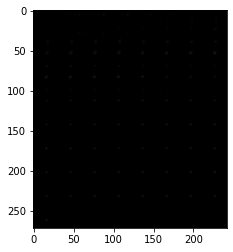

Epoch [15/400] Batch: [1/60] KL-Divergence: 0.0009400472044944763 Cross-Entropy: 0.26263782382011414 Loss: 0.2635778784751892
Epoch [15/400] Batch: [2/60] KL-Divergence: 0.0009433889645151794 Cross-Entropy: 0.2627827227115631 Loss: 0.2637261152267456
Epoch [15/400] Batch: [3/60] KL-Divergence: 0.000920380000025034 Cross-Entropy: 0.26652684807777405 Loss: 0.26744723320007324
Epoch [15/400] Batch: [4/60] KL-Divergence: 0.0009157282183878124 Cross-Entropy: 0.2611478567123413 Loss: 0.262063592672348
Epoch [15/400] Batch: [5/60] KL-Divergence: 0.000915412965696305 Cross-Entropy: 0.271793395280838 Loss: 0.27270880341529846
Epoch [15/400] Batch: [6/60] KL-Divergence: 0.0009263483807444572 Cross-Entropy: 0.26883769035339355 Loss: 0.2697640359401703
Epoch [15/400] Batch: [7/60] KL-Divergence: 0.0009528108057565987 Cross-Entropy: 0.2631198465824127 Loss: 0.2640726566314697
Epoch [15/400] Batch: [8/60] KL-Divergence: 0.000898561964277178 Cross-Entropy: 0.2590363323688507 Loss: 0.2599349021911621


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [15/400] Batch: [60/60] KL-Divergence: 0.0008474563364870846 Cross-Entropy: 0.27422165870666504 Loss: 0.27506911754608154
Epoch [15/400] Batch: [60/60] KL-Divergence: 0.0008474563364870846 Cross-Entropy: 0.27422165870666504 Loss: 0.27506911754608154


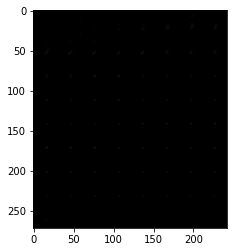

Epoch [16/400] Batch: [1/60] KL-Divergence: 0.0008256097207777202 Cross-Entropy: 0.2626146972179413 Loss: 0.2634403109550476
Epoch [16/400] Batch: [2/60] KL-Divergence: 0.0008234266424551606 Cross-Entropy: 0.2628203332424164 Loss: 0.2636437714099884
Epoch [16/400] Batch: [3/60] KL-Divergence: 0.0008392358431592584 Cross-Entropy: 0.26645874977111816 Loss: 0.26729798316955566
Epoch [16/400] Batch: [4/60] KL-Divergence: 0.0008458332740701735 Cross-Entropy: 0.2609958350658417 Loss: 0.26184165477752686
Epoch [16/400] Batch: [5/60] KL-Divergence: 0.0008008730947040021 Cross-Entropy: 0.27163076400756836 Loss: 0.2724316418170929
Epoch [16/400] Batch: [6/60] KL-Divergence: 0.0008336079772561789 Cross-Entropy: 0.2687775790691376 Loss: 0.2696111798286438
Epoch [16/400] Batch: [7/60] KL-Divergence: 0.0008181448210962117 Cross-Entropy: 0.2630388140678406 Loss: 0.2638569474220276
Epoch [16/400] Batch: [8/60] KL-Divergence: 0.0008070158073678613 Cross-Entropy: 0.25886374711990356 Loss: 0.259670764207

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [16/400] Batch: [60/60] KL-Divergence: 0.0007107528508640826 Cross-Entropy: 0.27413424849510193 Loss: 0.2748450040817261
Epoch [16/400] Batch: [60/60] KL-Divergence: 0.0007107528508640826 Cross-Entropy: 0.27413424849510193 Loss: 0.2748450040817261


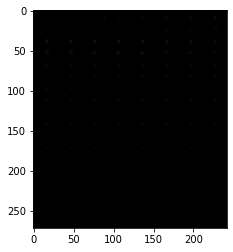

Epoch [17/400] Batch: [1/60] KL-Divergence: 0.0007307545165531337 Cross-Entropy: 0.2626340091228485 Loss: 0.2633647620677948
Epoch [17/400] Batch: [2/60] KL-Divergence: 0.0007039062911644578 Cross-Entropy: 0.2627957761287689 Loss: 0.2634996771812439
Epoch [17/400] Batch: [3/60] KL-Divergence: 0.0007117755012586713 Cross-Entropy: 0.26642605662345886 Loss: 0.2671378254890442
Epoch [17/400] Batch: [4/60] KL-Divergence: 0.0007095524342730641 Cross-Entropy: 0.26101312041282654 Loss: 0.2617226839065552
Epoch [17/400] Batch: [5/60] KL-Divergence: 0.0007259054109454155 Cross-Entropy: 0.27172327041625977 Loss: 0.27244916558265686
Epoch [17/400] Batch: [6/60] KL-Divergence: 0.0007373811677098274 Cross-Entropy: 0.268696129322052 Loss: 0.26943349838256836
Epoch [17/400] Batch: [7/60] KL-Divergence: 0.0007009162800386548 Cross-Entropy: 0.2628619074821472 Loss: 0.2635628283023834
Epoch [17/400] Batch: [8/60] KL-Divergence: 0.0007109291036613286 Cross-Entropy: 0.2587451636791229 Loss: 0.2594560980796

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [17/400] Batch: [60/60] KL-Divergence: 0.0006499122246168554 Cross-Entropy: 0.27402248978614807 Loss: 0.27467238903045654
Epoch [17/400] Batch: [60/60] KL-Divergence: 0.0006499122246168554 Cross-Entropy: 0.27402248978614807 Loss: 0.27467238903045654


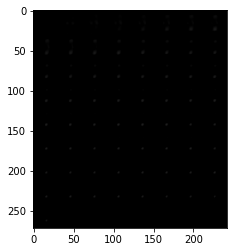

Epoch [18/400] Batch: [1/60] KL-Divergence: 0.0006143037462607026 Cross-Entropy: 0.262678325176239 Loss: 0.2632926404476166
Epoch [18/400] Batch: [2/60] KL-Divergence: 0.0006547495722770691 Cross-Entropy: 0.2627719044685364 Loss: 0.26342666149139404
Epoch [18/400] Batch: [3/60] KL-Divergence: 0.0006413012742996216 Cross-Entropy: 0.266419917345047 Loss: 0.2670612335205078
Epoch [18/400] Batch: [4/60] KL-Divergence: 0.0006492708344012499 Cross-Entropy: 0.26101088523864746 Loss: 0.2616601586341858
Epoch [18/400] Batch: [5/60] KL-Divergence: 0.0006485243793576956 Cross-Entropy: 0.2718460261821747 Loss: 0.2724945545196533
Epoch [18/400] Batch: [6/60] KL-Divergence: 0.0006446915795095265 Cross-Entropy: 0.26879286766052246 Loss: 0.2694375514984131
Epoch [18/400] Batch: [7/60] KL-Divergence: 0.0006401220452971756 Cross-Entropy: 0.26283469796180725 Loss: 0.26347482204437256
Epoch [18/400] Batch: [8/60] KL-Divergence: 0.0006376876845024526 Cross-Entropy: 0.2588357627391815 Loss: 0.25947344303131

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [18/400] Batch: [60/60] KL-Divergence: 0.0005809521535411477 Cross-Entropy: 0.27401915192604065 Loss: 0.2746001183986664
Epoch [18/400] Batch: [60/60] KL-Divergence: 0.0005809521535411477 Cross-Entropy: 0.27401915192604065 Loss: 0.2746001183986664


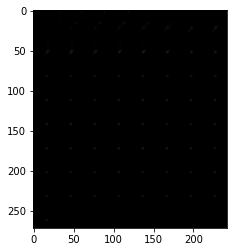

Epoch [19/400] Batch: [1/60] KL-Divergence: 0.000564553018193692 Cross-Entropy: 0.26275691390037537 Loss: 0.2633214592933655
Epoch [19/400] Batch: [2/60] KL-Divergence: 0.0005913114291615784 Cross-Entropy: 0.26270735263824463 Loss: 0.2632986605167389
Epoch [19/400] Batch: [3/60] KL-Divergence: 0.0005653406260535121 Cross-Entropy: 0.26641321182250977 Loss: 0.26697856187820435
Epoch [19/400] Batch: [4/60] KL-Divergence: 0.0005769776762463152 Cross-Entropy: 0.2609912157058716 Loss: 0.26156818866729736
Epoch [19/400] Batch: [5/60] KL-Divergence: 0.0005644154734909534 Cross-Entropy: 0.2718419134616852 Loss: 0.27240633964538574
Epoch [19/400] Batch: [6/60] KL-Divergence: 0.0005769154522567987 Cross-Entropy: 0.2687549591064453 Loss: 0.2693318724632263
Epoch [19/400] Batch: [7/60] KL-Divergence: 0.0005574682145379484 Cross-Entropy: 0.26291701197624207 Loss: 0.2634744942188263
Epoch [19/400] Batch: [8/60] KL-Divergence: 0.0005538773839361966 Cross-Entropy: 0.25869232416152954 Loss: 0.2592462003

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [19/400] Batch: [60/60] KL-Divergence: 0.0005156928673386574 Cross-Entropy: 0.2740917205810547 Loss: 0.27460741996765137
Epoch [19/400] Batch: [60/60] KL-Divergence: 0.0005156928673386574 Cross-Entropy: 0.2740917205810547 Loss: 0.27460741996765137


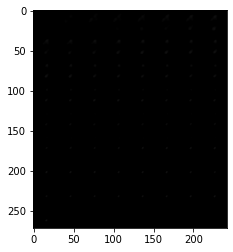

Epoch [20/400] Batch: [1/60] KL-Divergence: 0.0005328614497557282 Cross-Entropy: 0.2626813054084778 Loss: 0.2632141709327698
Epoch [20/400] Batch: [2/60] KL-Divergence: 0.000503133749589324 Cross-Entropy: 0.26262062788009644 Loss: 0.2631237506866455
Epoch [20/400] Batch: [3/60] KL-Divergence: 0.0005262094200588763 Cross-Entropy: 0.26629123091697693 Loss: 0.26681745052337646
Epoch [20/400] Batch: [4/60] KL-Divergence: 0.0004957349156029522 Cross-Entropy: 0.2609139084815979 Loss: 0.2614096403121948
Epoch [20/400] Batch: [5/60] KL-Divergence: 0.0005182456807233393 Cross-Entropy: 0.2717638909816742 Loss: 0.27228212356567383
Epoch [20/400] Batch: [6/60] KL-Divergence: 0.0005155375692993402 Cross-Entropy: 0.26877138018608093 Loss: 0.2692869305610657
Epoch [20/400] Batch: [7/60] KL-Divergence: 0.000503704184666276 Cross-Entropy: 0.26275762915611267 Loss: 0.2632613480091095
Epoch [20/400] Batch: [8/60] KL-Divergence: 0.0004940948565490544 Cross-Entropy: 0.25859665870666504 Loss: 0.259090751409

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [20/400] Batch: [60/60] KL-Divergence: 0.0004645208246074617 Cross-Entropy: 0.27403438091278076 Loss: 0.27449890971183777
Epoch [20/400] Batch: [60/60] KL-Divergence: 0.0004645208246074617 Cross-Entropy: 0.27403438091278076 Loss: 0.27449890971183777


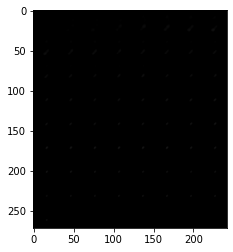

Epoch [21/400] Batch: [1/60] KL-Divergence: 0.00045909942127764225 Cross-Entropy: 0.26267194747924805 Loss: 0.2631310522556305
Epoch [21/400] Batch: [2/60] KL-Divergence: 0.0004600841784849763 Cross-Entropy: 0.26261797547340393 Loss: 0.26307806372642517
Epoch [21/400] Batch: [3/60] KL-Divergence: 0.00045791114098392427 Cross-Entropy: 0.2662838101387024 Loss: 0.26674172282218933
Epoch [21/400] Batch: [4/60] KL-Divergence: 0.00046795434900559485 Cross-Entropy: 0.2610064446926117 Loss: 0.2614744007587433
Epoch [21/400] Batch: [5/60] KL-Divergence: 0.00046670599840581417 Cross-Entropy: 0.2716270089149475 Loss: 0.2720937132835388
Epoch [21/400] Batch: [6/60] KL-Divergence: 0.0004596838552970439 Cross-Entropy: 0.26868802309036255 Loss: 0.26914769411087036
Epoch [21/400] Batch: [7/60] KL-Divergence: 0.00046069370000623167 Cross-Entropy: 0.26266756653785706 Loss: 0.26312825083732605
Epoch [21/400] Batch: [8/60] KL-Divergence: 0.00046211612061597407 Cross-Entropy: 0.25856223702430725 Loss: 0.25

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [21/400] Batch: [60/60] KL-Divergence: 0.00040952020208351314 Cross-Entropy: 0.27405866980552673 Loss: 0.27446818351745605
Epoch [21/400] Batch: [60/60] KL-Divergence: 0.00040952020208351314 Cross-Entropy: 0.27405866980552673 Loss: 0.27446818351745605


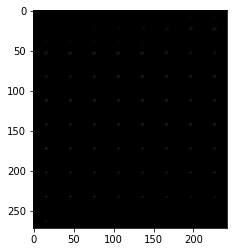

Epoch [22/400] Batch: [1/60] KL-Divergence: 0.0004094356845598668 Cross-Entropy: 0.26269295811653137 Loss: 0.26310238242149353
Epoch [22/400] Batch: [2/60] KL-Divergence: 0.00040900957537814975 Cross-Entropy: 0.26257970929145813 Loss: 0.26298871636390686
Epoch [22/400] Batch: [3/60] KL-Divergence: 0.0004174733185209334 Cross-Entropy: 0.26635441184043884 Loss: 0.2667718827724457
Epoch [22/400] Batch: [4/60] KL-Divergence: 0.000403216719860211 Cross-Entropy: 0.2610436677932739 Loss: 0.26144689321517944
Epoch [22/400] Batch: [5/60] KL-Divergence: 0.0004043702210765332 Cross-Entropy: 0.27162617444992065 Loss: 0.2720305323600769
Epoch [22/400] Batch: [6/60] KL-Divergence: 0.00041108508594334126 Cross-Entropy: 0.26868441700935364 Loss: 0.2690955102443695
Epoch [22/400] Batch: [7/60] KL-Divergence: 0.00040136839379556477 Cross-Entropy: 0.26265260577201843 Loss: 0.2630539834499359
Epoch [22/400] Batch: [8/60] KL-Divergence: 0.0004185305442661047 Cross-Entropy: 0.25849464535713196 Loss: 0.25891

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [22/400] Batch: [60/60] KL-Divergence: 0.0003771211195271462 Cross-Entropy: 0.2738948464393616 Loss: 0.27427196502685547
Epoch [22/400] Batch: [60/60] KL-Divergence: 0.0003771211195271462 Cross-Entropy: 0.2738948464393616 Loss: 0.27427196502685547


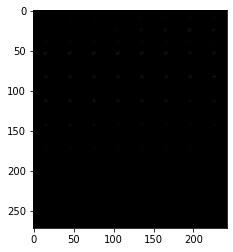

Epoch [23/400] Batch: [1/60] KL-Divergence: 0.00037599788629449904 Cross-Entropy: 0.2626366913318634 Loss: 0.26301267743110657
Epoch [23/400] Batch: [2/60] KL-Divergence: 0.00035990122705698013 Cross-Entropy: 0.2625976800918579 Loss: 0.2629575729370117
Epoch [23/400] Batch: [3/60] KL-Divergence: 0.00036854049540124834 Cross-Entropy: 0.2662075459957123 Loss: 0.2665760815143585
Epoch [23/400] Batch: [4/60] KL-Divergence: 0.00037850980879738927 Cross-Entropy: 0.26093780994415283 Loss: 0.26131632924079895
Epoch [23/400] Batch: [5/60] KL-Divergence: 0.0003767977759707719 Cross-Entropy: 0.2716120183467865 Loss: 0.27198880910873413
Epoch [23/400] Batch: [6/60] KL-Divergence: 0.0003806418098974973 Cross-Entropy: 0.26872339844703674 Loss: 0.2691040337085724
Epoch [23/400] Batch: [7/60] KL-Divergence: 0.0003886823542416096 Cross-Entropy: 0.2626582682132721 Loss: 0.2630469501018524
Epoch [23/400] Batch: [8/60] KL-Divergence: 0.00038131073233671486 Cross-Entropy: 0.2585337460041046 Loss: 0.2589150

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [23/400] Batch: [60/60] KL-Divergence: 0.000325129454722628 Cross-Entropy: 0.2738616466522217 Loss: 0.27418678998947144
Epoch [23/400] Batch: [60/60] KL-Divergence: 0.000325129454722628 Cross-Entropy: 0.2738616466522217 Loss: 0.27418678998947144


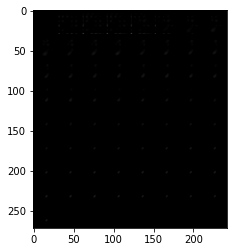

Epoch [24/400] Batch: [1/60] KL-Divergence: 0.0003398271801415831 Cross-Entropy: 0.262611448764801 Loss: 0.2629512846469879
Epoch [24/400] Batch: [2/60] KL-Divergence: 0.0003380589187145233 Cross-Entropy: 0.26266568899154663 Loss: 0.26300373673439026
Epoch [24/400] Batch: [3/60] KL-Divergence: 0.00033018484828062356 Cross-Entropy: 0.2662040591239929 Loss: 0.2665342390537262
Epoch [24/400] Batch: [4/60] KL-Divergence: 0.0003376909880898893 Cross-Entropy: 0.26092490553855896 Loss: 0.26126259565353394
Epoch [24/400] Batch: [5/60] KL-Divergence: 0.00034282347769476473 Cross-Entropy: 0.2716972529888153 Loss: 0.27204006910324097
Epoch [24/400] Batch: [6/60] KL-Divergence: 0.00032790846307761967 Cross-Entropy: 0.2686868906021118 Loss: 0.26901480555534363
Epoch [24/400] Batch: [7/60] KL-Divergence: 0.0003293998015578836 Cross-Entropy: 0.2626136243343353 Loss: 0.2629430294036865
Epoch [24/400] Batch: [8/60] KL-Divergence: 0.00034022092586383224 Cross-Entropy: 0.2583717107772827 Loss: 0.25871193

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [24/400] Batch: [60/60] KL-Divergence: 0.0003036636917386204 Cross-Entropy: 0.2738513946533203 Loss: 0.27415505051612854
Epoch [24/400] Batch: [60/60] KL-Divergence: 0.0003036636917386204 Cross-Entropy: 0.2738513946533203 Loss: 0.27415505051612854


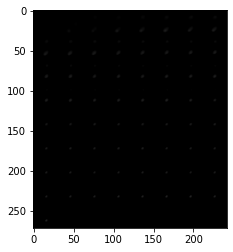

Epoch [25/400] Batch: [1/60] KL-Divergence: 0.0003154859005007893 Cross-Entropy: 0.26253005862236023 Loss: 0.26284554600715637
Epoch [25/400] Batch: [2/60] KL-Divergence: 0.00031149754067882895 Cross-Entropy: 0.262594074010849 Loss: 0.2629055678844452
Epoch [25/400] Batch: [3/60] KL-Divergence: 0.0003066535573452711 Cross-Entropy: 0.2661832273006439 Loss: 0.2664898931980133
Epoch [25/400] Batch: [4/60] KL-Divergence: 0.00030318484641611576 Cross-Entropy: 0.2608930766582489 Loss: 0.2611962556838989
Epoch [25/400] Batch: [5/60] KL-Divergence: 0.0003008393687196076 Cross-Entropy: 0.27156054973602295 Loss: 0.27186137437820435
Epoch [25/400] Batch: [6/60] KL-Divergence: 0.00031063464120961726 Cross-Entropy: 0.26862213015556335 Loss: 0.2689327597618103
Epoch [25/400] Batch: [7/60] KL-Divergence: 0.000312171847326681 Cross-Entropy: 0.2626846134662628 Loss: 0.2629967927932739
Epoch [25/400] Batch: [8/60] KL-Divergence: 0.0002981646975968033 Cross-Entropy: 0.2583256959915161 Loss: 0.25862386822

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [25/400] Batch: [60/60] KL-Divergence: 0.0002782341034617275 Cross-Entropy: 0.2738613486289978 Loss: 0.2741395831108093
Epoch [25/400] Batch: [60/60] KL-Divergence: 0.0002782341034617275 Cross-Entropy: 0.2738613486289978 Loss: 0.2741395831108093


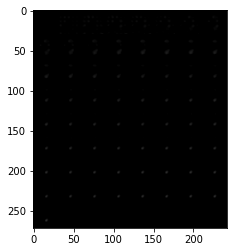

Epoch [26/400] Batch: [1/60] KL-Divergence: 0.0002723633369896561 Cross-Entropy: 0.2626723051071167 Loss: 0.26294466853141785
Epoch [26/400] Batch: [2/60] KL-Divergence: 0.0002819977526087314 Cross-Entropy: 0.26248374581336975 Loss: 0.2627657353878021
Epoch [26/400] Batch: [3/60] KL-Divergence: 0.0002837933716364205 Cross-Entropy: 0.26608699560165405 Loss: 0.2663708031177521
Epoch [26/400] Batch: [4/60] KL-Divergence: 0.00028555819881148636 Cross-Entropy: 0.2608838975429535 Loss: 0.2611694633960724
Epoch [26/400] Batch: [5/60] KL-Divergence: 0.0002852212346624583 Cross-Entropy: 0.271629273891449 Loss: 0.2719144821166992
Epoch [26/400] Batch: [6/60] KL-Divergence: 0.0002806462289299816 Cross-Entropy: 0.26869943737983704 Loss: 0.26898008584976196
Epoch [26/400] Batch: [7/60] KL-Divergence: 0.0002782458905130625 Cross-Entropy: 0.26257914304733276 Loss: 0.2628573775291443
Epoch [26/400] Batch: [8/60] KL-Divergence: 0.0002742423093877733 Cross-Entropy: 0.2582430839538574 Loss: 0.25851732492

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [26/400] Batch: [60/60] KL-Divergence: 0.0002616825804580003 Cross-Entropy: 0.2737310528755188 Loss: 0.27399274706840515
Epoch [26/400] Batch: [60/60] KL-Divergence: 0.0002616825804580003 Cross-Entropy: 0.2737310528755188 Loss: 0.27399274706840515


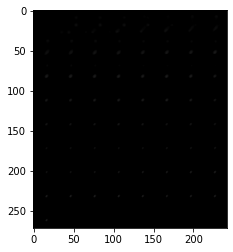

Epoch [27/400] Batch: [1/60] KL-Divergence: 0.00026694685220718384 Cross-Entropy: 0.2626620829105377 Loss: 0.2629290223121643
Epoch [27/400] Batch: [2/60] KL-Divergence: 0.00025384113541804254 Cross-Entropy: 0.2625061571598053 Loss: 0.2627599835395813
Epoch [27/400] Batch: [3/60] KL-Divergence: 0.00026156139210797846 Cross-Entropy: 0.2661082148551941 Loss: 0.2663697898387909
Epoch [27/400] Batch: [4/60] KL-Divergence: 0.00025475755683146417 Cross-Entropy: 0.2608460783958435 Loss: 0.2611008286476135
Epoch [27/400] Batch: [5/60] KL-Divergence: 0.0002477782254572958 Cross-Entropy: 0.2715710699558258 Loss: 0.2718188464641571
Epoch [27/400] Batch: [6/60] KL-Divergence: 0.00025703865685500205 Cross-Entropy: 0.2686930298805237 Loss: 0.26895007491111755
Epoch [27/400] Batch: [7/60] KL-Divergence: 0.0002483090793248266 Cross-Entropy: 0.26258888840675354 Loss: 0.2628372013568878
Epoch [27/400] Batch: [8/60] KL-Divergence: 0.00025306380121037364 Cross-Entropy: 0.2582826316356659 Loss: 0.258535683

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [27/400] Batch: [60/60] KL-Divergence: 0.0002414869231870398 Cross-Entropy: 0.2738243639469147 Loss: 0.27406585216522217
Epoch [27/400] Batch: [60/60] KL-Divergence: 0.0002414869231870398 Cross-Entropy: 0.2738243639469147 Loss: 0.27406585216522217


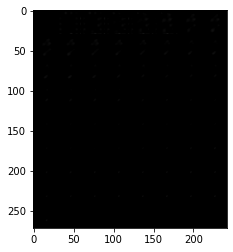

Epoch [28/400] Batch: [1/60] KL-Divergence: 0.00024226245295722038 Cross-Entropy: 0.26256486773490906 Loss: 0.26280713081359863
Epoch [28/400] Batch: [2/60] KL-Divergence: 0.00023629679344594479 Cross-Entropy: 0.262548565864563 Loss: 0.262784868478775
Epoch [28/400] Batch: [3/60] KL-Divergence: 0.00023509631864726543 Cross-Entropy: 0.2660985291004181 Loss: 0.2663336396217346
Epoch [28/400] Batch: [4/60] KL-Divergence: 0.00022804553736932576 Cross-Entropy: 0.2607906758785248 Loss: 0.2610187232494354
Epoch [28/400] Batch: [5/60] KL-Divergence: 0.00022849402739666402 Cross-Entropy: 0.2715073823928833 Loss: 0.27173587679862976
Epoch [28/400] Batch: [6/60] KL-Divergence: 0.00023785361554473639 Cross-Entropy: 0.26865747570991516 Loss: 0.26889532804489136
Epoch [28/400] Batch: [7/60] KL-Divergence: 0.0002342056977795437 Cross-Entropy: 0.2625863254070282 Loss: 0.2628205418586731
Epoch [28/400] Batch: [8/60] KL-Divergence: 0.00023085635621100664 Cross-Entropy: 0.2580835223197937 Loss: 0.2583143

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [28/400] Batch: [60/60] KL-Divergence: 0.00021773818298242986 Cross-Entropy: 0.273684561252594 Loss: 0.2739022970199585
Epoch [28/400] Batch: [60/60] KL-Divergence: 0.00021773818298242986 Cross-Entropy: 0.273684561252594 Loss: 0.2739022970199585


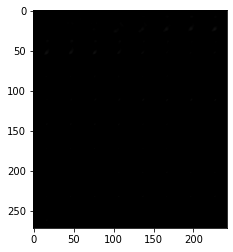

Epoch [29/400] Batch: [1/60] KL-Divergence: 0.00021799445676151663 Cross-Entropy: 0.2626248002052307 Loss: 0.2628428041934967
Epoch [29/400] Batch: [2/60] KL-Divergence: 0.0002111413487000391 Cross-Entropy: 0.2625400424003601 Loss: 0.26275119185447693
Epoch [29/400] Batch: [3/60] KL-Divergence: 0.0002122776786563918 Cross-Entropy: 0.2661011517047882 Loss: 0.26631343364715576
Epoch [29/400] Batch: [4/60] KL-Divergence: 0.00021210956037975848 Cross-Entropy: 0.2607950270175934 Loss: 0.2610071301460266
Epoch [29/400] Batch: [5/60] KL-Divergence: 0.00021218211622908711 Cross-Entropy: 0.271577924489975 Loss: 0.27179011702537537
Epoch [29/400] Batch: [6/60] KL-Divergence: 0.00020620963186956942 Cross-Entropy: 0.26857906579971313 Loss: 0.2687852680683136
Epoch [29/400] Batch: [7/60] KL-Divergence: 0.00021506984194274992 Cross-Entropy: 0.26249775290489197 Loss: 0.26271283626556396
Epoch [29/400] Batch: [8/60] KL-Divergence: 0.0002144010941265151 Cross-Entropy: 0.2581402659416199 Loss: 0.2583546

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [29/400] Batch: [60/60] KL-Divergence: 0.0002005508722504601 Cross-Entropy: 0.27376148104667664 Loss: 0.27396202087402344
Epoch [29/400] Batch: [60/60] KL-Divergence: 0.0002005508722504601 Cross-Entropy: 0.27376148104667664 Loss: 0.27396202087402344


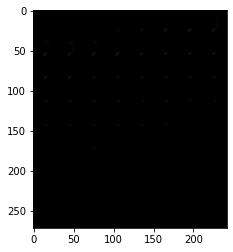

Epoch [30/400] Batch: [1/60] KL-Divergence: 0.00019706424791365862 Cross-Entropy: 0.2624342441558838 Loss: 0.26263129711151123
Epoch [30/400] Batch: [2/60] KL-Divergence: 0.00020295599824748933 Cross-Entropy: 0.26245054602622986 Loss: 0.26265349984169006
Epoch [30/400] Batch: [3/60] KL-Divergence: 0.00018839027325157076 Cross-Entropy: 0.266052782535553 Loss: 0.2662411630153656
Epoch [30/400] Batch: [4/60] KL-Divergence: 0.00019844256166834384 Cross-Entropy: 0.2609184980392456 Loss: 0.26111695170402527
Epoch [30/400] Batch: [5/60] KL-Divergence: 0.00020233508257661015 Cross-Entropy: 0.27144694328308105 Loss: 0.2716492712497711
Epoch [30/400] Batch: [6/60] KL-Divergence: 0.0001965362171176821 Cross-Entropy: 0.26857417821884155 Loss: 0.2687707245349884
Epoch [30/400] Batch: [7/60] KL-Divergence: 0.00020106798911001533 Cross-Entropy: 0.262565016746521 Loss: 0.2627660930156708
Epoch [30/400] Batch: [8/60] KL-Divergence: 0.00019717651593964547 Cross-Entropy: 0.25808119773864746 Loss: 0.25827

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [30/400] Batch: [60/60] KL-Divergence: 0.00018252029258292168 Cross-Entropy: 0.2737556993961334 Loss: 0.27393820881843567
Epoch [30/400] Batch: [60/60] KL-Divergence: 0.00018252029258292168 Cross-Entropy: 0.2737556993961334 Loss: 0.27393820881843567


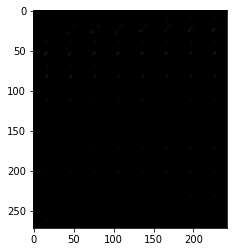

Epoch [31/400] Batch: [1/60] KL-Divergence: 0.00018381983682047576 Cross-Entropy: 0.2625693380832672 Loss: 0.2627531588077545
Epoch [31/400] Batch: [2/60] KL-Divergence: 0.00018885120516642928 Cross-Entropy: 0.262616366147995 Loss: 0.2628052234649658
Epoch [31/400] Batch: [3/60] KL-Divergence: 0.0001813277049222961 Cross-Entropy: 0.2660512328147888 Loss: 0.26623255014419556
Epoch [31/400] Batch: [4/60] KL-Divergence: 0.00018344413547310978 Cross-Entropy: 0.26080819964408875 Loss: 0.260991632938385
Epoch [31/400] Batch: [5/60] KL-Divergence: 0.00018278979405295104 Cross-Entropy: 0.27150583267211914 Loss: 0.2716886103153229
Epoch [31/400] Batch: [6/60] KL-Divergence: 0.00017786536773201078 Cross-Entropy: 0.26853424310684204 Loss: 0.2687121033668518
Epoch [31/400] Batch: [7/60] KL-Divergence: 0.0001882973883766681 Cross-Entropy: 0.2624703347682953 Loss: 0.26265862584114075
Epoch [31/400] Batch: [8/60] KL-Divergence: 0.00017427443526685238 Cross-Entropy: 0.25802871584892273 Loss: 0.2582029

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [31/400] Batch: [60/60] KL-Divergence: 0.00016999214130919427 Cross-Entropy: 0.27375125885009766 Loss: 0.27392125129699707
Epoch [31/400] Batch: [60/60] KL-Divergence: 0.00016999214130919427 Cross-Entropy: 0.27375125885009766 Loss: 0.27392125129699707


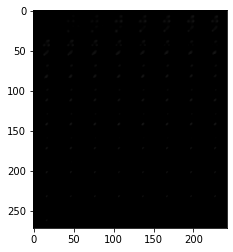

Epoch [32/400] Batch: [1/60] KL-Divergence: 0.0001678881817497313 Cross-Entropy: 0.2625657618045807 Loss: 0.2627336382865906
Epoch [32/400] Batch: [2/60] KL-Divergence: 0.00016900058835744858 Cross-Entropy: 0.2625100314617157 Loss: 0.2626790404319763
Epoch [32/400] Batch: [3/60] KL-Divergence: 0.0001621345872990787 Cross-Entropy: 0.26603373885154724 Loss: 0.2661958634853363
Epoch [32/400] Batch: [4/60] KL-Divergence: 0.00017549796029925346 Cross-Entropy: 0.260734498500824 Loss: 0.2609100043773651
Epoch [32/400] Batch: [5/60] KL-Divergence: 0.0001642764691496268 Cross-Entropy: 0.2714103162288666 Loss: 0.27157458662986755
Epoch [32/400] Batch: [6/60] KL-Divergence: 0.00017329779802821577 Cross-Entropy: 0.2685318887233734 Loss: 0.26870518922805786
Epoch [32/400] Batch: [7/60] KL-Divergence: 0.00016741191211622208 Cross-Entropy: 0.2624649405479431 Loss: 0.2626323401927948
Epoch [32/400] Batch: [8/60] KL-Divergence: 0.00016686164599377662 Cross-Entropy: 0.25792863965034485 Loss: 0.258095502

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [32/400] Batch: [60/60] KL-Divergence: 0.00016299377602990717 Cross-Entropy: 0.27379119396209717 Loss: 0.2739541828632355
Epoch [32/400] Batch: [60/60] KL-Divergence: 0.00016299377602990717 Cross-Entropy: 0.27379119396209717 Loss: 0.2739541828632355


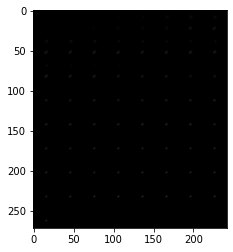

Epoch [33/400] Batch: [1/60] KL-Divergence: 0.00015231018187478185 Cross-Entropy: 0.26253437995910645 Loss: 0.26268669962882996
Epoch [33/400] Batch: [2/60] KL-Divergence: 0.0001594541099620983 Cross-Entropy: 0.2624855637550354 Loss: 0.26264500617980957
Epoch [33/400] Batch: [3/60] KL-Divergence: 0.00015863032604102045 Cross-Entropy: 0.2659194767475128 Loss: 0.2660781145095825
Epoch [33/400] Batch: [4/60] KL-Divergence: 0.00015409919433295727 Cross-Entropy: 0.26072630286216736 Loss: 0.26088041067123413
Epoch [33/400] Batch: [5/60] KL-Divergence: 0.00015939799777697772 Cross-Entropy: 0.2712475657463074 Loss: 0.27140697836875916
Epoch [33/400] Batch: [6/60] KL-Divergence: 0.00015757758228573948 Cross-Entropy: 0.2685886323451996 Loss: 0.26874619722366333
Epoch [33/400] Batch: [7/60] KL-Divergence: 0.00014936004299670458 Cross-Entropy: 0.2623915672302246 Loss: 0.26254093647003174
Epoch [33/400] Batch: [8/60] KL-Divergence: 0.0001496193726779893 Cross-Entropy: 0.2579815089702606 Loss: 0.258

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [33/400] Batch: [60/60] KL-Divergence: 0.00014940185064915568 Cross-Entropy: 0.27363839745521545 Loss: 0.27378779649734497
Epoch [33/400] Batch: [60/60] KL-Divergence: 0.00014940185064915568 Cross-Entropy: 0.27363839745521545 Loss: 0.27378779649734497


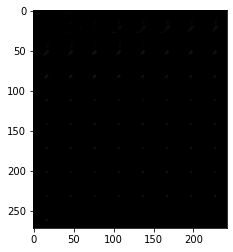

Epoch [34/400] Batch: [1/60] KL-Divergence: 0.0001488601992605254 Cross-Entropy: 0.2624502182006836 Loss: 0.26259908080101013
Epoch [34/400] Batch: [2/60] KL-Divergence: 0.00014044642739463598 Cross-Entropy: 0.26247864961624146 Loss: 0.26261910796165466
Epoch [34/400] Batch: [3/60] KL-Divergence: 0.00014195697440300137 Cross-Entropy: 0.2659856081008911 Loss: 0.2661275565624237
Epoch [34/400] Batch: [4/60] KL-Divergence: 0.00014742198982276022 Cross-Entropy: 0.26074421405792236 Loss: 0.2608916461467743
Epoch [34/400] Batch: [5/60] KL-Divergence: 0.0001462538493797183 Cross-Entropy: 0.2713201940059662 Loss: 0.2714664340019226
Epoch [34/400] Batch: [6/60] KL-Divergence: 0.00013991622836329043 Cross-Entropy: 0.2684607207775116 Loss: 0.2686006426811218
Epoch [34/400] Batch: [7/60] KL-Divergence: 0.00015118560986593366 Cross-Entropy: 0.2623237371444702 Loss: 0.262474924325943
Epoch [34/400] Batch: [8/60] KL-Divergence: 0.00014135662058833987 Cross-Entropy: 0.25789138674736023 Loss: 0.2580327

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [34/400] Batch: [60/60] KL-Divergence: 0.000139086609124206 Cross-Entropy: 0.273673415184021 Loss: 0.27381250262260437
Epoch [34/400] Batch: [60/60] KL-Divergence: 0.000139086609124206 Cross-Entropy: 0.273673415184021 Loss: 0.27381250262260437


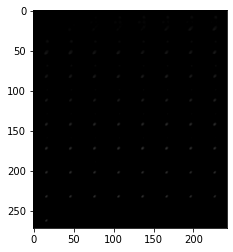

Epoch [35/400] Batch: [1/60] KL-Divergence: 0.00013529349234886467 Cross-Entropy: 0.2624799907207489 Loss: 0.26261529326438904
Epoch [35/400] Batch: [2/60] KL-Divergence: 0.0001401324407197535 Cross-Entropy: 0.26232701539993286 Loss: 0.2624671459197998
Epoch [35/400] Batch: [3/60] KL-Divergence: 0.0001379132445435971 Cross-Entropy: 0.26586148142814636 Loss: 0.2659994065761566
Epoch [35/400] Batch: [4/60] KL-Divergence: 0.00012778591189999133 Cross-Entropy: 0.26069509983062744 Loss: 0.2608228921890259
Epoch [35/400] Batch: [5/60] KL-Divergence: 0.00013182319526094943 Cross-Entropy: 0.2712697684764862 Loss: 0.271401584148407
Epoch [35/400] Batch: [6/60] KL-Divergence: 0.0001308291539316997 Cross-Entropy: 0.2684313654899597 Loss: 0.2685621976852417
Epoch [35/400] Batch: [7/60] KL-Divergence: 0.00013700439012609422 Cross-Entropy: 0.26240888237953186 Loss: 0.2625458836555481
Epoch [35/400] Batch: [8/60] KL-Divergence: 0.00013756201951764524 Cross-Entropy: 0.2578290104866028 Loss: 0.25796657

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [35/400] Batch: [60/60] KL-Divergence: 0.00011832843301817775 Cross-Entropy: 0.2736152708530426 Loss: 0.27373358607292175
Epoch [35/400] Batch: [60/60] KL-Divergence: 0.00011832843301817775 Cross-Entropy: 0.2736152708530426 Loss: 0.27373358607292175


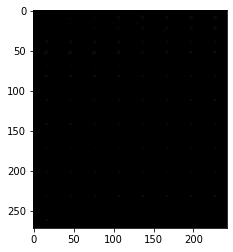

Epoch [36/400] Batch: [1/60] KL-Divergence: 0.00011840087245218456 Cross-Entropy: 0.262457013130188 Loss: 0.2625754177570343
Epoch [36/400] Batch: [2/60] KL-Divergence: 0.00011911758338101208 Cross-Entropy: 0.2625006139278412 Loss: 0.2626197338104248
Epoch [36/400] Batch: [3/60] KL-Divergence: 0.0001232889189850539 Cross-Entropy: 0.26597800850868225 Loss: 0.26610130071640015
Epoch [36/400] Batch: [4/60] KL-Divergence: 0.00012321307440288365 Cross-Entropy: 0.2606986165046692 Loss: 0.2608218193054199
Epoch [36/400] Batch: [5/60] KL-Divergence: 0.0001319823059020564 Cross-Entropy: 0.27123579382896423 Loss: 0.27136778831481934
Epoch [36/400] Batch: [6/60] KL-Divergence: 0.0001243710285052657 Cross-Entropy: 0.26843100786209106 Loss: 0.2685553729534149
Epoch [36/400] Batch: [7/60] KL-Divergence: 0.00012438361591193825 Cross-Entropy: 0.26228320598602295 Loss: 0.2624076008796692
Epoch [36/400] Batch: [8/60] KL-Divergence: 0.00012404125300236046 Cross-Entropy: 0.25773894786834717 Loss: 0.257862

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [36/400] Batch: [60/60] KL-Divergence: 0.0001231277856277302 Cross-Entropy: 0.27360016107559204 Loss: 0.2737232744693756
Epoch [36/400] Batch: [60/60] KL-Divergence: 0.0001231277856277302 Cross-Entropy: 0.27360016107559204 Loss: 0.2737232744693756


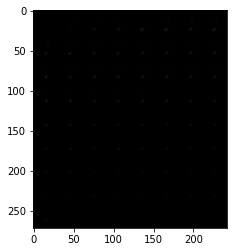

Epoch [37/400] Batch: [1/60] KL-Divergence: 0.00011718974565155804 Cross-Entropy: 0.26228630542755127 Loss: 0.2624034881591797
Epoch [37/400] Batch: [2/60] KL-Divergence: 0.0001194002470583655 Cross-Entropy: 0.26247698068618774 Loss: 0.26259636878967285
Epoch [37/400] Batch: [3/60] KL-Divergence: 0.00011889461165992543 Cross-Entropy: 0.2657667398452759 Loss: 0.2658856213092804
Epoch [37/400] Batch: [4/60] KL-Divergence: 0.00011333861766615883 Cross-Entropy: 0.260608971118927 Loss: 0.2607223093509674
Epoch [37/400] Batch: [5/60] KL-Divergence: 0.00011173987877555192 Cross-Entropy: 0.27105826139450073 Loss: 0.2711699903011322
Epoch [37/400] Batch: [6/60] KL-Divergence: 0.00011938319948967546 Cross-Entropy: 0.26846083998680115 Loss: 0.26858022809028625
Epoch [37/400] Batch: [7/60] KL-Divergence: 0.00011436015483923256 Cross-Entropy: 0.2622627019882202 Loss: 0.2623770534992218
Epoch [37/400] Batch: [8/60] KL-Divergence: 0.00011456088395789266 Cross-Entropy: 0.25774499773979187 Loss: 0.2578

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [37/400] Batch: [60/60] KL-Divergence: 0.00011248519876971841 Cross-Entropy: 0.27350592613220215 Loss: 0.2736184000968933
Epoch [37/400] Batch: [60/60] KL-Divergence: 0.00011248519876971841 Cross-Entropy: 0.27350592613220215 Loss: 0.2736184000968933


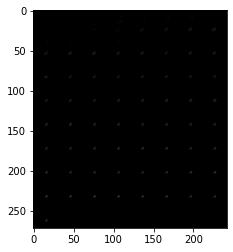

Epoch [38/400] Batch: [1/60] KL-Divergence: 0.00010927394760074094 Cross-Entropy: 0.262471079826355 Loss: 0.26258036494255066
Epoch [38/400] Batch: [2/60] KL-Divergence: 0.0001115183622459881 Cross-Entropy: 0.26251617074012756 Loss: 0.2626276910305023
Epoch [38/400] Batch: [3/60] KL-Divergence: 0.00010689738701330498 Cross-Entropy: 0.26588934659957886 Loss: 0.2659962475299835
Epoch [38/400] Batch: [4/60] KL-Divergence: 0.00010754462709883228 Cross-Entropy: 0.2606935203075409 Loss: 0.2608010768890381
Epoch [38/400] Batch: [5/60] KL-Divergence: 0.00010521705553401262 Cross-Entropy: 0.27110445499420166 Loss: 0.2712096571922302
Epoch [38/400] Batch: [6/60] KL-Divergence: 0.00010880466288654134 Cross-Entropy: 0.26831504702568054 Loss: 0.268423855304718
Epoch [38/400] Batch: [7/60] KL-Divergence: 0.00010569022560957819 Cross-Entropy: 0.2622257173061371 Loss: 0.26233139634132385
Epoch [38/400] Batch: [8/60] KL-Divergence: 0.00010598498920444399 Cross-Entropy: 0.25765547156333923 Loss: 0.25776

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [38/400] Batch: [60/60] KL-Divergence: 0.00010421062324894592 Cross-Entropy: 0.2735253870487213 Loss: 0.2736296057701111
Epoch [38/400] Batch: [60/60] KL-Divergence: 0.00010421062324894592 Cross-Entropy: 0.2735253870487213 Loss: 0.2736296057701111


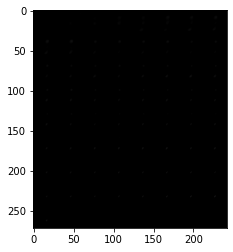

Epoch [39/400] Batch: [1/60] KL-Divergence: 0.00010514800669625401 Cross-Entropy: 0.26235783100128174 Loss: 0.2624629735946655
Epoch [39/400] Batch: [2/60] KL-Divergence: 9.790115291252732e-05 Cross-Entropy: 0.26235130429267883 Loss: 0.2624492049217224
Epoch [39/400] Batch: [3/60] KL-Divergence: 0.00010219356045126915 Cross-Entropy: 0.265809029340744 Loss: 0.2659112215042114
Epoch [39/400] Batch: [4/60] KL-Divergence: 0.00010076782200485468 Cross-Entropy: 0.2606387734413147 Loss: 0.2607395350933075
Epoch [39/400] Batch: [5/60] KL-Divergence: 0.00010272391955368221 Cross-Entropy: 0.2710839807987213 Loss: 0.2711867094039917
Epoch [39/400] Batch: [6/60] KL-Divergence: 0.00010339572327211499 Cross-Entropy: 0.26822683215141296 Loss: 0.2683302164077759
Epoch [39/400] Batch: [7/60] KL-Divergence: 0.0001014928420772776 Cross-Entropy: 0.26227006316185 Loss: 0.26237156987190247
Epoch [39/400] Batch: [8/60] KL-Divergence: 0.00010154971823794767 Cross-Entropy: 0.25755831599235535 Loss: 0.257659852

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [39/400] Batch: [60/60] KL-Divergence: 9.59929238888435e-05 Cross-Entropy: 0.27352094650268555 Loss: 0.2736169397830963
Epoch [39/400] Batch: [60/60] KL-Divergence: 9.59929238888435e-05 Cross-Entropy: 0.27352094650268555 Loss: 0.2736169397830963


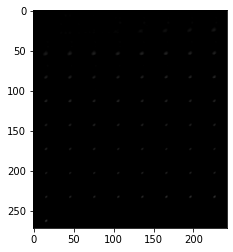

Epoch [40/400] Batch: [1/60] KL-Divergence: 9.637645416660234e-05 Cross-Entropy: 0.26235029101371765 Loss: 0.26244667172431946
Epoch [40/400] Batch: [2/60] KL-Divergence: 9.72042471403256e-05 Cross-Entropy: 0.26237544417381287 Loss: 0.26247265934944153
Epoch [40/400] Batch: [3/60] KL-Divergence: 9.831393981585279e-05 Cross-Entropy: 0.265740305185318 Loss: 0.265838623046875
Epoch [40/400] Batch: [4/60] KL-Divergence: 9.300537203671411e-05 Cross-Entropy: 0.26056042313575745 Loss: 0.26065343618392944
Epoch [40/400] Batch: [5/60] KL-Divergence: 8.966102177510038e-05 Cross-Entropy: 0.27104321122169495 Loss: 0.2711328864097595
Epoch [40/400] Batch: [6/60] KL-Divergence: 9.478111314820126e-05 Cross-Entropy: 0.26819589734077454 Loss: 0.2682906687259674
Epoch [40/400] Batch: [7/60] KL-Divergence: 9.499019506620243e-05 Cross-Entropy: 0.26208171248435974 Loss: 0.2621766924858093
Epoch [40/400] Batch: [8/60] KL-Divergence: 9.337718802271411e-05 Cross-Entropy: 0.25757285952568054 Loss: 0.2576662302

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [40/400] Batch: [60/60] KL-Divergence: 9.23185289138928e-05 Cross-Entropy: 0.273564875125885 Loss: 0.2736572027206421
Epoch [40/400] Batch: [60/60] KL-Divergence: 9.23185289138928e-05 Cross-Entropy: 0.273564875125885 Loss: 0.2736572027206421


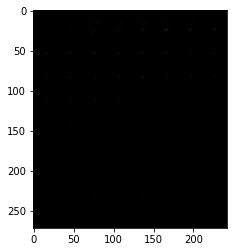

Epoch [41/400] Batch: [1/60] KL-Divergence: 9.351233893539757e-05 Cross-Entropy: 0.2621909976005554 Loss: 0.262284517288208
Epoch [41/400] Batch: [2/60] KL-Divergence: 8.735984738450497e-05 Cross-Entropy: 0.26233306527137756 Loss: 0.2624204158782959
Epoch [41/400] Batch: [3/60] KL-Divergence: 8.860183152137324e-05 Cross-Entropy: 0.2656894326210022 Loss: 0.2657780349254608
Epoch [41/400] Batch: [4/60] KL-Divergence: 8.59038918861188e-05 Cross-Entropy: 0.26054081320762634 Loss: 0.2606267035007477
Epoch [41/400] Batch: [5/60] KL-Divergence: 9.030803630594164e-05 Cross-Entropy: 0.2708362936973572 Loss: 0.2709265947341919
Epoch [41/400] Batch: [6/60] KL-Divergence: 8.788303239271045e-05 Cross-Entropy: 0.2681591808795929 Loss: 0.2682470679283142
Epoch [41/400] Batch: [7/60] KL-Divergence: 8.802039519650862e-05 Cross-Entropy: 0.2621234655380249 Loss: 0.26221147179603577
Epoch [41/400] Batch: [8/60] KL-Divergence: 9.261432569473982e-05 Cross-Entropy: 0.2574525475502014 Loss: 0.2575451731681824

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [41/400] Batch: [60/60] KL-Divergence: 8.497886301483959e-05 Cross-Entropy: 0.27343693375587463 Loss: 0.27352190017700195
Epoch [41/400] Batch: [60/60] KL-Divergence: 8.497886301483959e-05 Cross-Entropy: 0.27343693375587463 Loss: 0.27352190017700195


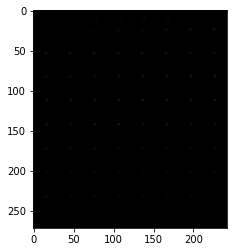

Epoch [42/400] Batch: [1/60] KL-Divergence: 8.237369183916599e-05 Cross-Entropy: 0.2622106671333313 Loss: 0.2622930407524109
Epoch [42/400] Batch: [2/60] KL-Divergence: 8.600048022344708e-05 Cross-Entropy: 0.2622978687286377 Loss: 0.2623838782310486
Epoch [42/400] Batch: [3/60] KL-Divergence: 8.502090349793434e-05 Cross-Entropy: 0.2656944990158081 Loss: 0.2657795250415802
Epoch [42/400] Batch: [4/60] KL-Divergence: 7.775344420224428e-05 Cross-Entropy: 0.2604992389678955 Loss: 0.260576993227005
Epoch [42/400] Batch: [5/60] KL-Divergence: 8.274131687358022e-05 Cross-Entropy: 0.270879328250885 Loss: 0.27096205949783325
Epoch [42/400] Batch: [6/60] KL-Divergence: 8.418026118306443e-05 Cross-Entropy: 0.26818540692329407 Loss: 0.2682695984840393
Epoch [42/400] Batch: [7/60] KL-Divergence: 8.150646317517385e-05 Cross-Entropy: 0.26199647784233093 Loss: 0.2620779871940613
Epoch [42/400] Batch: [8/60] KL-Divergence: 8.434554911218584e-05 Cross-Entropy: 0.25742673873901367 Loss: 0.257511079311370

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [42/400] Batch: [60/60] KL-Divergence: 7.979213842190802e-05 Cross-Entropy: 0.273430198431015 Loss: 0.2735099792480469
Epoch [42/400] Batch: [60/60] KL-Divergence: 7.979213842190802e-05 Cross-Entropy: 0.273430198431015 Loss: 0.2735099792480469


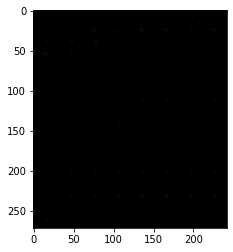

Epoch [43/400] Batch: [1/60] KL-Divergence: 8.373077434953302e-05 Cross-Entropy: 0.262283593416214 Loss: 0.2623673379421234
Epoch [43/400] Batch: [2/60] KL-Divergence: 7.547016139142215e-05 Cross-Entropy: 0.26214614510536194 Loss: 0.2622216045856476
Epoch [43/400] Batch: [3/60] KL-Divergence: 7.727347838226706e-05 Cross-Entropy: 0.26557207107543945 Loss: 0.26564934849739075
Epoch [43/400] Batch: [4/60] KL-Divergence: 7.43999844416976e-05 Cross-Entropy: 0.2605593800544739 Loss: 0.26063376665115356
Epoch [43/400] Batch: [5/60] KL-Divergence: 7.636444206582382e-05 Cross-Entropy: 0.27078932523727417 Loss: 0.27086567878723145
Epoch [43/400] Batch: [6/60] KL-Divergence: 7.933021697681397e-05 Cross-Entropy: 0.26807036995887756 Loss: 0.2681497037410736
Epoch [43/400] Batch: [7/60] KL-Divergence: 8.185447222786024e-05 Cross-Entropy: 0.2620057463645935 Loss: 0.2620876133441925
Epoch [43/400] Batch: [8/60] KL-Divergence: 7.301677396753803e-05 Cross-Entropy: 0.25729572772979736 Loss: 0.25736874341

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [43/400] Batch: [60/60] KL-Divergence: 7.241366984089836e-05 Cross-Entropy: 0.2734140157699585 Loss: 0.2734864354133606
Epoch [43/400] Batch: [60/60] KL-Divergence: 7.241366984089836e-05 Cross-Entropy: 0.2734140157699585 Loss: 0.2734864354133606


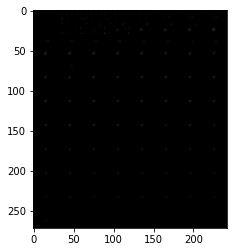

Epoch [44/400] Batch: [1/60] KL-Divergence: 7.588172593386844e-05 Cross-Entropy: 0.26219668984413147 Loss: 0.26227256655693054
Epoch [44/400] Batch: [2/60] KL-Divergence: 7.523608655901626e-05 Cross-Entropy: 0.26220691204071045 Loss: 0.2622821629047394
Epoch [44/400] Batch: [3/60] KL-Divergence: 7.40201139706187e-05 Cross-Entropy: 0.26560238003730774 Loss: 0.2656764090061188
Epoch [44/400] Batch: [4/60] KL-Divergence: 7.090126018738374e-05 Cross-Entropy: 0.2603386640548706 Loss: 0.26040956377983093
Epoch [44/400] Batch: [5/60] KL-Divergence: 7.251056376844645e-05 Cross-Entropy: 0.2706478238105774 Loss: 0.27072033286094666
Epoch [44/400] Batch: [6/60] KL-Divergence: 7.673721120227128e-05 Cross-Entropy: 0.2679736018180847 Loss: 0.26805034279823303
Epoch [44/400] Batch: [7/60] KL-Divergence: 7.404544885503128e-05 Cross-Entropy: 0.26196160912513733 Loss: 0.26203566789627075
Epoch [44/400] Batch: [8/60] KL-Divergence: 7.346546044573188e-05 Cross-Entropy: 0.2573429048061371 Loss: 0.257416367

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [44/400] Batch: [60/60] KL-Divergence: 6.991916598053649e-05 Cross-Entropy: 0.27346041798591614 Loss: 0.27353033423423767
Epoch [44/400] Batch: [60/60] KL-Divergence: 6.991916598053649e-05 Cross-Entropy: 0.27346041798591614 Loss: 0.27353033423423767


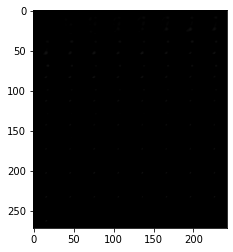

Epoch [45/400] Batch: [1/60] KL-Divergence: 6.972335540922359e-05 Cross-Entropy: 0.26199883222579956 Loss: 0.26206856966018677
Epoch [45/400] Batch: [2/60] KL-Divergence: 6.811492494307458e-05 Cross-Entropy: 0.26212918758392334 Loss: 0.2621973156929016
Epoch [45/400] Batch: [3/60] KL-Divergence: 6.508140359073877e-05 Cross-Entropy: 0.2654096782207489 Loss: 0.26547476649284363
Epoch [45/400] Batch: [4/60] KL-Divergence: 6.68402062729001e-05 Cross-Entropy: 0.2602742612361908 Loss: 0.2603411078453064
Epoch [45/400] Batch: [5/60] KL-Divergence: 6.997253512963653e-05 Cross-Entropy: 0.2706056833267212 Loss: 0.2706756591796875
Epoch [45/400] Batch: [6/60] KL-Divergence: 6.771732296328992e-05 Cross-Entropy: 0.26805493235588074 Loss: 0.2681226432323456
Epoch [45/400] Batch: [7/60] KL-Divergence: 6.941276660654694e-05 Cross-Entropy: 0.2619068920612335 Loss: 0.26197630167007446
Epoch [45/400] Batch: [8/60] KL-Divergence: 6.950801616767421e-05 Cross-Entropy: 0.2573622763156891 Loss: 0.257431775331

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [45/400] Batch: [60/60] KL-Divergence: 6.412238872144371e-05 Cross-Entropy: 0.2732834219932556 Loss: 0.27334755659103394
Epoch [45/400] Batch: [60/60] KL-Divergence: 6.412238872144371e-05 Cross-Entropy: 0.2732834219932556 Loss: 0.27334755659103394


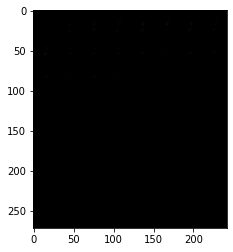

Epoch [46/400] Batch: [1/60] KL-Divergence: 6.413657683879137e-05 Cross-Entropy: 0.26198408007621765 Loss: 0.26204821467399597
Epoch [46/400] Batch: [2/60] KL-Divergence: 6.468078208854422e-05 Cross-Entropy: 0.2621592581272125 Loss: 0.2622239291667938
Epoch [46/400] Batch: [3/60] KL-Divergence: 6.247714918572456e-05 Cross-Entropy: 0.2654840648174286 Loss: 0.2655465304851532
Epoch [46/400] Batch: [4/60] KL-Divergence: 6.556648440891877e-05 Cross-Entropy: 0.2602047920227051 Loss: 0.260270357131958
Epoch [46/400] Batch: [5/60] KL-Divergence: 6.485011545009911e-05 Cross-Entropy: 0.2705449163913727 Loss: 0.2706097662448883
Epoch [46/400] Batch: [6/60] KL-Divergence: 6.594184378627688e-05 Cross-Entropy: 0.26798170804977417 Loss: 0.26804766058921814
Epoch [46/400] Batch: [7/60] KL-Divergence: 6.446918268920854e-05 Cross-Entropy: 0.2618432343006134 Loss: 0.261907696723938
Epoch [46/400] Batch: [8/60] KL-Divergence: 6.452506931964308e-05 Cross-Entropy: 0.2572513520717621 Loss: 0.257315874099731

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [46/400] Batch: [60/60] KL-Divergence: 6.242461677175015e-05 Cross-Entropy: 0.27337223291397095 Loss: 0.27343466877937317
Epoch [46/400] Batch: [60/60] KL-Divergence: 6.242461677175015e-05 Cross-Entropy: 0.27337223291397095 Loss: 0.27343466877937317


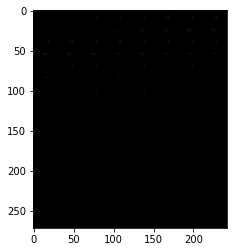

Epoch [47/400] Batch: [1/60] KL-Divergence: 6.224628305062652e-05 Cross-Entropy: 0.2619936168193817 Loss: 0.2620558738708496
Epoch [47/400] Batch: [2/60] KL-Divergence: 6.345802103169262e-05 Cross-Entropy: 0.2620718479156494 Loss: 0.2621352970600128
Epoch [47/400] Batch: [3/60] KL-Divergence: 6.16777761024423e-05 Cross-Entropy: 0.2653045654296875 Loss: 0.26536625623703003
Epoch [47/400] Batch: [4/60] KL-Divergence: 6.084922642912716e-05 Cross-Entropy: 0.26014962792396545 Loss: 0.26021048426628113
Epoch [47/400] Batch: [5/60] KL-Divergence: 6.018985732225701e-05 Cross-Entropy: 0.27047717571258545 Loss: 0.2705373764038086
Epoch [47/400] Batch: [6/60] KL-Divergence: 5.904693534830585e-05 Cross-Entropy: 0.2679043710231781 Loss: 0.2679634094238281
Epoch [47/400] Batch: [7/60] KL-Divergence: 6.229320570128039e-05 Cross-Entropy: 0.2617296278476715 Loss: 0.2617919147014618
Epoch [47/400] Batch: [8/60] KL-Divergence: 5.926097583142109e-05 Cross-Entropy: 0.25719553232192993 Loss: 0.2572547793388

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [47/400] Batch: [60/60] KL-Divergence: 5.5425221944460645e-05 Cross-Entropy: 0.27316004037857056 Loss: 0.27321547269821167
Epoch [47/400] Batch: [60/60] KL-Divergence: 5.5425221944460645e-05 Cross-Entropy: 0.27316004037857056 Loss: 0.27321547269821167


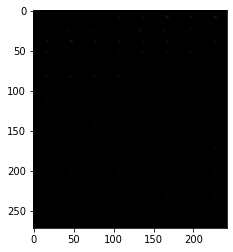

Epoch [48/400] Batch: [1/60] KL-Divergence: 5.610492735286243e-05 Cross-Entropy: 0.2619544565677643 Loss: 0.2620105743408203
Epoch [48/400] Batch: [2/60] KL-Divergence: 5.702415364794433e-05 Cross-Entropy: 0.2619958817958832 Loss: 0.26205289363861084
Epoch [48/400] Batch: [3/60] KL-Divergence: 5.974891610094346e-05 Cross-Entropy: 0.26531293988227844 Loss: 0.26537269353866577
Epoch [48/400] Batch: [4/60] KL-Divergence: 5.734355727327056e-05 Cross-Entropy: 0.26017943024635315 Loss: 0.2602367699146271
Epoch [48/400] Batch: [5/60] KL-Divergence: 5.718822285416536e-05 Cross-Entropy: 0.27027058601379395 Loss: 0.27032777667045593
Epoch [48/400] Batch: [6/60] KL-Divergence: 5.6819990277290344e-05 Cross-Entropy: 0.26789626479148865 Loss: 0.267953097820282
Epoch [48/400] Batch: [7/60] KL-Divergence: 5.729122131015174e-05 Cross-Entropy: 0.2615286409854889 Loss: 0.26158592104911804
Epoch [48/400] Batch: [8/60] KL-Divergence: 5.469589086715132e-05 Cross-Entropy: 0.2571551203727722 Loss: 0.257209807

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [48/400] Batch: [60/60] KL-Divergence: 5.481166590470821e-05 Cross-Entropy: 0.2732231914997101 Loss: 0.27327799797058105
Epoch [48/400] Batch: [60/60] KL-Divergence: 5.481166590470821e-05 Cross-Entropy: 0.2732231914997101 Loss: 0.27327799797058105


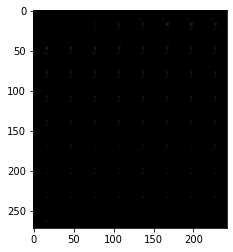

Epoch [49/400] Batch: [1/60] KL-Divergence: 5.445129136205651e-05 Cross-Entropy: 0.2618662714958191 Loss: 0.2619207203388214
Epoch [49/400] Batch: [2/60] KL-Divergence: 5.5308377341134474e-05 Cross-Entropy: 0.26201608777046204 Loss: 0.2620714008808136
Epoch [49/400] Batch: [3/60] KL-Divergence: 5.312873690854758e-05 Cross-Entropy: 0.2652234435081482 Loss: 0.26527658104896545
Epoch [49/400] Batch: [4/60] KL-Divergence: 5.319843330653384e-05 Cross-Entropy: 0.2600208520889282 Loss: 0.26007404923439026
Epoch [49/400] Batch: [5/60] KL-Divergence: 5.2673527534352615e-05 Cross-Entropy: 0.2703281342983246 Loss: 0.27038079500198364
Epoch [49/400] Batch: [6/60] KL-Divergence: 5.756377868237905e-05 Cross-Entropy: 0.26800960302352905 Loss: 0.2680671811103821
Epoch [49/400] Batch: [7/60] KL-Divergence: 5.185165355214849e-05 Cross-Entropy: 0.26158881187438965 Loss: 0.26164066791534424
Epoch [49/400] Batch: [8/60] KL-Divergence: 5.2969055104767904e-05 Cross-Entropy: 0.2570907175540924 Loss: 0.2571436

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [49/400] Batch: [60/60] KL-Divergence: 5.3542404202744365e-05 Cross-Entropy: 0.27294033765792847 Loss: 0.27299389243125916
Epoch [49/400] Batch: [60/60] KL-Divergence: 5.3542404202744365e-05 Cross-Entropy: 0.27294033765792847 Loss: 0.27299389243125916


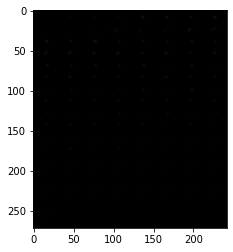

Epoch [50/400] Batch: [1/60] KL-Divergence: 5.32440171809867e-05 Cross-Entropy: 0.2619219124317169 Loss: 0.26197516918182373
Epoch [50/400] Batch: [2/60] KL-Divergence: 5.0583112169988453e-05 Cross-Entropy: 0.26205241680145264 Loss: 0.26210299134254456
Epoch [50/400] Batch: [3/60] KL-Divergence: 5.033630077377893e-05 Cross-Entropy: 0.26508042216300964 Loss: 0.26513075828552246
Epoch [50/400] Batch: [4/60] KL-Divergence: 5.265105937724002e-05 Cross-Entropy: 0.25998568534851074 Loss: 0.2600383460521698
Epoch [50/400] Batch: [5/60] KL-Divergence: 5.070575571153313e-05 Cross-Entropy: 0.27007511258125305 Loss: 0.2701258063316345
Epoch [50/400] Batch: [6/60] KL-Divergence: 5.137126936460845e-05 Cross-Entropy: 0.26773160696029663 Loss: 0.267782986164093
Epoch [50/400] Batch: [7/60] KL-Divergence: 5.022910772822797e-05 Cross-Entropy: 0.2614787518978119 Loss: 0.26152896881103516
Epoch [50/400] Batch: [8/60] KL-Divergence: 5.088332909508608e-05 Cross-Entropy: 0.25711676478385925 Loss: 0.25716763

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [50/400] Batch: [60/60] KL-Divergence: 5.110523125040345e-05 Cross-Entropy: 0.27291402220726013 Loss: 0.27296513319015503
Epoch [50/400] Batch: [60/60] KL-Divergence: 5.110523125040345e-05 Cross-Entropy: 0.27291402220726013 Loss: 0.27296513319015503


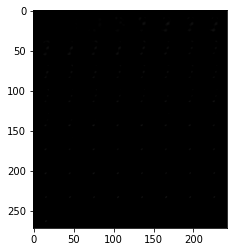

Epoch [51/400] Batch: [1/60] KL-Divergence: 4.8841819079825655e-05 Cross-Entropy: 0.2618614733219147 Loss: 0.2619103193283081
Epoch [51/400] Batch: [2/60] KL-Divergence: 4.7748144424986094e-05 Cross-Entropy: 0.26193350553512573 Loss: 0.2619812488555908
Epoch [51/400] Batch: [3/60] KL-Divergence: 4.9515991122461855e-05 Cross-Entropy: 0.26503416895866394 Loss: 0.2650836706161499
Epoch [51/400] Batch: [4/60] KL-Divergence: 5.134555613039993e-05 Cross-Entropy: 0.2597760260105133 Loss: 0.2598273754119873
Epoch [51/400] Batch: [5/60] KL-Divergence: 5.0253409426659346e-05 Cross-Entropy: 0.2700895071029663 Loss: 0.27013975381851196
Epoch [51/400] Batch: [6/60] KL-Divergence: 4.9303474952466786e-05 Cross-Entropy: 0.2677728831768036 Loss: 0.26782217621803284
Epoch [51/400] Batch: [7/60] KL-Divergence: 4.663951767724939e-05 Cross-Entropy: 0.26138946413993835 Loss: 0.2614361047744751
Epoch [51/400] Batch: [8/60] KL-Divergence: 4.7918128984747455e-05 Cross-Entropy: 0.25696462392807007 Loss: 0.25701

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [51/400] Batch: [60/60] KL-Divergence: 4.5261876948643476e-05 Cross-Entropy: 0.2730203866958618 Loss: 0.2730656564235687
Epoch [51/400] Batch: [60/60] KL-Divergence: 4.5261876948643476e-05 Cross-Entropy: 0.2730203866958618 Loss: 0.2730656564235687


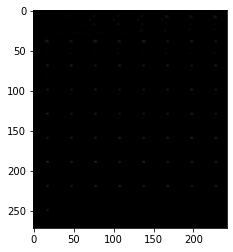

Epoch [52/400] Batch: [1/60] KL-Divergence: 4.463798541110009e-05 Cross-Entropy: 0.2618739604949951 Loss: 0.2619186043739319
Epoch [52/400] Batch: [2/60] KL-Divergence: 4.5402564865071326e-05 Cross-Entropy: 0.26188766956329346 Loss: 0.2619330585002899
Epoch [52/400] Batch: [3/60] KL-Divergence: 4.622463166015223e-05 Cross-Entropy: 0.265001505613327 Loss: 0.26504772901535034
Epoch [52/400] Batch: [4/60] KL-Divergence: 4.396545409690589e-05 Cross-Entropy: 0.25986695289611816 Loss: 0.25991091132164
Epoch [52/400] Batch: [5/60] KL-Divergence: 4.611587428371422e-05 Cross-Entropy: 0.26988351345062256 Loss: 0.2699296176433563
Epoch [52/400] Batch: [6/60] KL-Divergence: 4.734210961032659e-05 Cross-Entropy: 0.2677118182182312 Loss: 0.26775917410850525
Epoch [52/400] Batch: [7/60] KL-Divergence: 4.7095221816562116e-05 Cross-Entropy: 0.261398583650589 Loss: 0.26144567131996155
Epoch [52/400] Batch: [8/60] KL-Divergence: 4.50675179308746e-05 Cross-Entropy: 0.2569337785243988 Loss: 0.25697883963584

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [52/400] Batch: [60/60] KL-Divergence: 4.3742369598476216e-05 Cross-Entropy: 0.27283504605293274 Loss: 0.2728787958621979
Epoch [52/400] Batch: [60/60] KL-Divergence: 4.3742369598476216e-05 Cross-Entropy: 0.27283504605293274 Loss: 0.2728787958621979


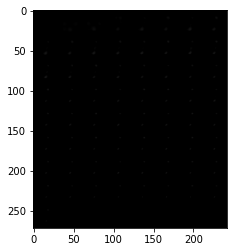

Epoch [53/400] Batch: [1/60] KL-Divergence: 4.534004256129265e-05 Cross-Entropy: 0.2617139220237732 Loss: 0.2617592513561249
Epoch [53/400] Batch: [2/60] KL-Divergence: 4.353195254225284e-05 Cross-Entropy: 0.2617597281932831 Loss: 0.2618032693862915
Epoch [53/400] Batch: [3/60] KL-Divergence: 4.4717748096445575e-05 Cross-Entropy: 0.2649579644203186 Loss: 0.26500266790390015
Epoch [53/400] Batch: [4/60] KL-Divergence: 4.2962798033840954e-05 Cross-Entropy: 0.2597316801548004 Loss: 0.25977465510368347
Epoch [53/400] Batch: [5/60] KL-Divergence: 4.392616028781049e-05 Cross-Entropy: 0.2700616419315338 Loss: 0.2701055705547333
Epoch [53/400] Batch: [6/60] KL-Divergence: 4.4331281969789416e-05 Cross-Entropy: 0.26768141984939575 Loss: 0.26772576570510864
Epoch [53/400] Batch: [7/60] KL-Divergence: 4.158233423368074e-05 Cross-Entropy: 0.2614995241165161 Loss: 0.26154109835624695
Epoch [53/400] Batch: [8/60] KL-Divergence: 4.327495480538346e-05 Cross-Entropy: 0.2569073438644409 Loss: 0.256950616

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [53/400] Batch: [60/60] KL-Divergence: 4.0590515709482133e-05 Cross-Entropy: 0.2728661298751831 Loss: 0.27290672063827515
Epoch [53/400] Batch: [60/60] KL-Divergence: 4.0590515709482133e-05 Cross-Entropy: 0.2728661298751831 Loss: 0.27290672063827515


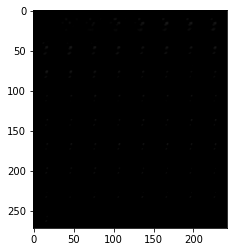

Epoch [54/400] Batch: [1/60] KL-Divergence: 3.967716111219488e-05 Cross-Entropy: 0.2615962624549866 Loss: 0.2616359293460846
Epoch [54/400] Batch: [2/60] KL-Divergence: 4.0027043723966926e-05 Cross-Entropy: 0.26179954409599304 Loss: 0.2618395686149597
Epoch [54/400] Batch: [3/60] KL-Divergence: 4.121948222746141e-05 Cross-Entropy: 0.2650383412837982 Loss: 0.2650795578956604
Epoch [54/400] Batch: [4/60] KL-Divergence: 4.1952131141442806e-05 Cross-Entropy: 0.2597806751728058 Loss: 0.25982263684272766
Epoch [54/400] Batch: [5/60] KL-Divergence: 4.120525409234688e-05 Cross-Entropy: 0.2698799669742584 Loss: 0.2699211835861206
Epoch [54/400] Batch: [6/60] KL-Divergence: 4.2222440242767334e-05 Cross-Entropy: 0.26772212982177734 Loss: 0.2677643597126007
Epoch [54/400] Batch: [7/60] KL-Divergence: 4.1943625546991825e-05 Cross-Entropy: 0.26136085391044617 Loss: 0.26140278577804565
Epoch [54/400] Batch: [8/60] KL-Divergence: 3.95372771890834e-05 Cross-Entropy: 0.2568538188934326 Loss: 0.256893366

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [54/400] Batch: [60/60] KL-Divergence: 3.983585338573903e-05 Cross-Entropy: 0.27282413840293884 Loss: 0.2728639841079712
Epoch [54/400] Batch: [60/60] KL-Divergence: 3.983585338573903e-05 Cross-Entropy: 0.27282413840293884 Loss: 0.2728639841079712


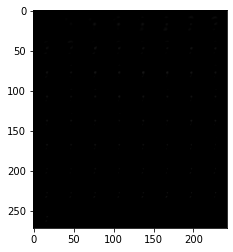

Epoch [55/400] Batch: [1/60] KL-Divergence: 3.878803181578405e-05 Cross-Entropy: 0.26170480251312256 Loss: 0.26174360513687134
Epoch [55/400] Batch: [2/60] KL-Divergence: 3.9387283322867006e-05 Cross-Entropy: 0.2617824375629425 Loss: 0.26182183623313904
Epoch [55/400] Batch: [3/60] KL-Divergence: 3.9786260458640754e-05 Cross-Entropy: 0.26502692699432373 Loss: 0.2650667130947113
Epoch [55/400] Batch: [4/60] KL-Divergence: 3.803897925536148e-05 Cross-Entropy: 0.25968658924102783 Loss: 0.25972461700439453
Epoch [55/400] Batch: [5/60] KL-Divergence: 3.8781661714892834e-05 Cross-Entropy: 0.269946813583374 Loss: 0.2699855864048004
Epoch [55/400] Batch: [6/60] KL-Divergence: 3.9034232031553984e-05 Cross-Entropy: 0.26759618520736694 Loss: 0.2676352262496948
Epoch [55/400] Batch: [7/60] KL-Divergence: 4.0526541852159426e-05 Cross-Entropy: 0.2614315152168274 Loss: 0.26147204637527466
Epoch [55/400] Batch: [8/60] KL-Divergence: 3.7423858884721994e-05 Cross-Entropy: 0.25678735971450806 Loss: 0.256

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [55/400] Batch: [60/60] KL-Divergence: 3.8299902371363714e-05 Cross-Entropy: 0.2728487551212311 Loss: 0.27288705110549927
Epoch [55/400] Batch: [60/60] KL-Divergence: 3.8299902371363714e-05 Cross-Entropy: 0.2728487551212311 Loss: 0.27288705110549927


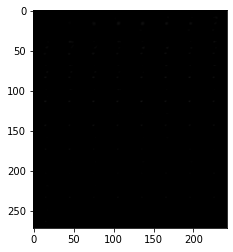

Epoch [56/400] Batch: [1/60] KL-Divergence: 3.6620444006985053e-05 Cross-Entropy: 0.2616408169269562 Loss: 0.26167744398117065
Epoch [56/400] Batch: [2/60] KL-Divergence: 3.654541069408879e-05 Cross-Entropy: 0.26182276010513306 Loss: 0.26185929775238037
Epoch [56/400] Batch: [3/60] KL-Divergence: 3.5921439121011645e-05 Cross-Entropy: 0.26492345333099365 Loss: 0.2649593651294708
Epoch [56/400] Batch: [4/60] KL-Divergence: 3.7666282878490165e-05 Cross-Entropy: 0.2596074938774109 Loss: 0.25964516401290894
Epoch [56/400] Batch: [5/60] KL-Divergence: 3.748687595361844e-05 Cross-Entropy: 0.26980534195899963 Loss: 0.26984283328056335
Epoch [56/400] Batch: [6/60] KL-Divergence: 3.833858500001952e-05 Cross-Entropy: 0.2676488757133484 Loss: 0.26768720149993896
Epoch [56/400] Batch: [7/60] KL-Divergence: 3.697414285852574e-05 Cross-Entropy: 0.26152417063713074 Loss: 0.26156115531921387
Epoch [56/400] Batch: [8/60] KL-Divergence: 3.6541747249430045e-05 Cross-Entropy: 0.25673708319664 Loss: 0.25677

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [56/400] Batch: [60/60] KL-Divergence: 3.489658411126584e-05 Cross-Entropy: 0.27280688285827637 Loss: 0.27284178137779236
Epoch [56/400] Batch: [60/60] KL-Divergence: 3.489658411126584e-05 Cross-Entropy: 0.27280688285827637 Loss: 0.27284178137779236


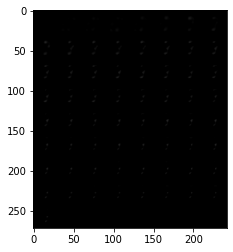

Epoch [57/400] Batch: [1/60] KL-Divergence: 3.299011223134585e-05 Cross-Entropy: 0.26163578033447266 Loss: 0.26166877150535583
Epoch [57/400] Batch: [2/60] KL-Divergence: 3.472926982794888e-05 Cross-Entropy: 0.26176872849464417 Loss: 0.26180344820022583
Epoch [57/400] Batch: [3/60] KL-Divergence: 3.344631113577634e-05 Cross-Entropy: 0.26485922932624817 Loss: 0.26489266753196716
Epoch [57/400] Batch: [4/60] KL-Divergence: 3.423938687774353e-05 Cross-Entropy: 0.2596559524536133 Loss: 0.25969019532203674
Epoch [57/400] Batch: [5/60] KL-Divergence: 3.5631368518806994e-05 Cross-Entropy: 0.2698306143283844 Loss: 0.2698662579059601
Epoch [57/400] Batch: [6/60] KL-Divergence: 3.728656520252116e-05 Cross-Entropy: 0.2674654424190521 Loss: 0.26750272512435913
Epoch [57/400] Batch: [7/60] KL-Divergence: 3.656318585854024e-05 Cross-Entropy: 0.2616139352321625 Loss: 0.2616505026817322
Epoch [57/400] Batch: [8/60] KL-Divergence: 3.418208871153183e-05 Cross-Entropy: 0.2567833960056305 Loss: 0.25681757

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [57/400] Batch: [60/60] KL-Divergence: 4.913700104225427e-05 Cross-Entropy: 0.2729574143886566 Loss: 0.2730065584182739
Epoch [57/400] Batch: [60/60] KL-Divergence: 4.913700104225427e-05 Cross-Entropy: 0.2729574143886566 Loss: 0.2730065584182739


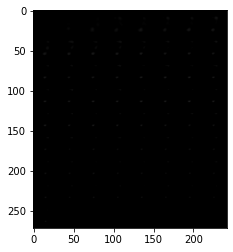

Epoch [58/400] Batch: [1/60] KL-Divergence: 5.2761191909667104e-05 Cross-Entropy: 0.2617044746875763 Loss: 0.2617572247982025
Epoch [58/400] Batch: [2/60] KL-Divergence: 4.4091833842685446e-05 Cross-Entropy: 0.2618478536605835 Loss: 0.2618919312953949
Epoch [58/400] Batch: [3/60] KL-Divergence: 3.974407081841491e-05 Cross-Entropy: 0.26494482159614563 Loss: 0.2649845778942108
Epoch [58/400] Batch: [4/60] KL-Divergence: 3.7022855394752696e-05 Cross-Entropy: 0.25971853733062744 Loss: 0.25975555181503296
Epoch [58/400] Batch: [5/60] KL-Divergence: 4.272067963029258e-05 Cross-Entropy: 0.2697557508945465 Loss: 0.2697984576225281
Epoch [58/400] Batch: [6/60] KL-Divergence: 4.2233772546751425e-05 Cross-Entropy: 0.2674536406993866 Loss: 0.26749587059020996
Epoch [58/400] Batch: [7/60] KL-Divergence: 4.06164544983767e-05 Cross-Entropy: 0.26137077808380127 Loss: 0.2614113986492157
Epoch [58/400] Batch: [8/60] KL-Divergence: 3.8957823562668636e-05 Cross-Entropy: 0.25688159465789795 Loss: 0.2569205

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [58/400] Batch: [60/60] KL-Divergence: 3.343086063978262e-05 Cross-Entropy: 0.2730467915534973 Loss: 0.2730802297592163
Epoch [58/400] Batch: [60/60] KL-Divergence: 3.343086063978262e-05 Cross-Entropy: 0.2730467915534973 Loss: 0.2730802297592163


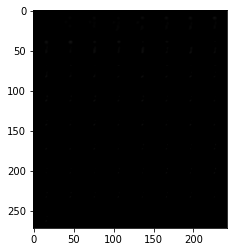

Epoch [59/400] Batch: [1/60] KL-Divergence: 3.304714118712582e-05 Cross-Entropy: 0.2616615891456604 Loss: 0.26169463992118835
Epoch [59/400] Batch: [2/60] KL-Divergence: 3.246715641580522e-05 Cross-Entropy: 0.26187339425086975 Loss: 0.26190584897994995
Epoch [59/400] Batch: [3/60] KL-Divergence: 3.189407289028168e-05 Cross-Entropy: 0.26494306325912476 Loss: 0.2649749517440796
Epoch [59/400] Batch: [4/60] KL-Divergence: 3.1326329917646945e-05 Cross-Entropy: 0.25964513421058655 Loss: 0.259676456451416
Epoch [59/400] Batch: [5/60] KL-Divergence: 3.268524233135395e-05 Cross-Entropy: 0.2698531150817871 Loss: 0.2698858082294464
Epoch [59/400] Batch: [6/60] KL-Divergence: 3.216796903871e-05 Cross-Entropy: 0.26757723093032837 Loss: 0.2676093876361847
Epoch [59/400] Batch: [7/60] KL-Divergence: 3.388145341887139e-05 Cross-Entropy: 0.26143863797187805 Loss: 0.26147252321243286
Epoch [59/400] Batch: [8/60] KL-Divergence: 3.2185249438043684e-05 Cross-Entropy: 0.25689610838890076 Loss: 0.2569282948

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [59/400] Batch: [60/60] KL-Divergence: 3.119567918474786e-05 Cross-Entropy: 0.27264896035194397 Loss: 0.2726801633834839
Epoch [59/400] Batch: [60/60] KL-Divergence: 3.119567918474786e-05 Cross-Entropy: 0.27264896035194397 Loss: 0.2726801633834839


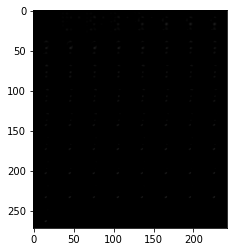

Epoch [60/400] Batch: [1/60] KL-Divergence: 3.128894604742527e-05 Cross-Entropy: 0.26147276163101196 Loss: 0.26150405406951904
Epoch [60/400] Batch: [2/60] KL-Divergence: 3.0451697966782376e-05 Cross-Entropy: 0.26172876358032227 Loss: 0.2617592215538025
Epoch [60/400] Batch: [3/60] KL-Divergence: 2.994529677380342e-05 Cross-Entropy: 0.2648833096027374 Loss: 0.26491326093673706
Epoch [60/400] Batch: [4/60] KL-Divergence: 3.2056541385827586e-05 Cross-Entropy: 0.25976070761680603 Loss: 0.2597927749156952
Epoch [60/400] Batch: [5/60] KL-Divergence: 3.099777313764207e-05 Cross-Entropy: 0.26981785893440247 Loss: 0.26984885334968567
Epoch [60/400] Batch: [6/60] KL-Divergence: 3.390720303286798e-05 Cross-Entropy: 0.26745277643203735 Loss: 0.26748669147491455
Epoch [60/400] Batch: [7/60] KL-Divergence: 3.1440849852515385e-05 Cross-Entropy: 0.2614624798297882 Loss: 0.2614939212799072
Epoch [60/400] Batch: [8/60] KL-Divergence: 3.008502972079441e-05 Cross-Entropy: 0.2566756010055542 Loss: 0.25670

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [60/400] Batch: [60/60] KL-Divergence: 2.803531606332399e-05 Cross-Entropy: 0.2728278636932373 Loss: 0.2728559076786041
Epoch [60/400] Batch: [60/60] KL-Divergence: 2.803531606332399e-05 Cross-Entropy: 0.2728278636932373 Loss: 0.2728559076786041


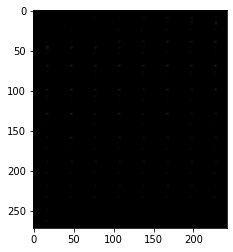

Epoch [61/400] Batch: [1/60] KL-Divergence: 3.060909148189239e-05 Cross-Entropy: 0.26146960258483887 Loss: 0.26150020956993103
Epoch [61/400] Batch: [2/60] KL-Divergence: 2.8677519367192872e-05 Cross-Entropy: 0.2618442475795746 Loss: 0.26187291741371155
Epoch [61/400] Batch: [3/60] KL-Divergence: 2.8531683710752986e-05 Cross-Entropy: 0.264936238527298 Loss: 0.264964759349823
Epoch [61/400] Batch: [4/60] KL-Divergence: 2.6099012757185847e-05 Cross-Entropy: 0.25980016589164734 Loss: 0.25982627272605896
Epoch [61/400] Batch: [5/60] KL-Divergence: 2.983230479003396e-05 Cross-Entropy: 0.26974809169769287 Loss: 0.26977792382240295
Epoch [61/400] Batch: [6/60] KL-Divergence: 2.7049751224694774e-05 Cross-Entropy: 0.2674797475337982 Loss: 0.26750680804252625
Epoch [61/400] Batch: [7/60] KL-Divergence: 2.785716969810892e-05 Cross-Entropy: 0.2613814175128937 Loss: 0.26140928268432617
Epoch [61/400] Batch: [8/60] KL-Divergence: 2.7761228921008296e-05 Cross-Entropy: 0.2567337453365326 Loss: 0.25676

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [61/400] Batch: [60/60] KL-Divergence: 2.7467001928016543e-05 Cross-Entropy: 0.272890567779541 Loss: 0.27291804552078247
Epoch [61/400] Batch: [60/60] KL-Divergence: 2.7467001928016543e-05 Cross-Entropy: 0.272890567779541 Loss: 0.27291804552078247


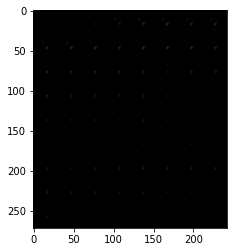

Epoch [62/400] Batch: [1/60] KL-Divergence: 2.785850483633112e-05 Cross-Entropy: 0.26147744059562683 Loss: 0.2615053057670593
Epoch [62/400] Batch: [2/60] KL-Divergence: 2.7173957278137095e-05 Cross-Entropy: 0.2616889178752899 Loss: 0.2617160975933075
Epoch [62/400] Batch: [3/60] KL-Divergence: 2.7776755814556964e-05 Cross-Entropy: 0.26480549573898315 Loss: 0.2648332715034485
Epoch [62/400] Batch: [4/60] KL-Divergence: 2.613609285617713e-05 Cross-Entropy: 0.2597936689853668 Loss: 0.25981980562210083
Epoch [62/400] Batch: [5/60] KL-Divergence: 2.8922651836182922e-05 Cross-Entropy: 0.26966556906700134 Loss: 0.2696944773197174
Epoch [62/400] Batch: [6/60] KL-Divergence: 2.8199881853652187e-05 Cross-Entropy: 0.26730507612228394 Loss: 0.2673332691192627
Epoch [62/400] Batch: [7/60] KL-Divergence: 2.6382407668279484e-05 Cross-Entropy: 0.261237233877182 Loss: 0.2612636089324951
Epoch [62/400] Batch: [8/60] KL-Divergence: 2.597511229396332e-05 Cross-Entropy: 0.2566532790660858 Loss: 0.25667926

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [62/400] Batch: [60/60] KL-Divergence: 2.9202688892837614e-05 Cross-Entropy: 0.2728320360183716 Loss: 0.2728612422943115
Epoch [62/400] Batch: [60/60] KL-Divergence: 2.9202688892837614e-05 Cross-Entropy: 0.2728320360183716 Loss: 0.2728612422943115


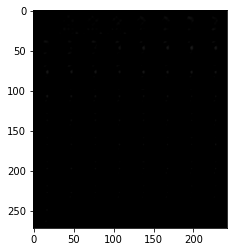

Epoch [63/400] Batch: [1/60] KL-Divergence: 2.7307356504024938e-05 Cross-Entropy: 0.2613527476787567 Loss: 0.26138004660606384
Epoch [63/400] Batch: [2/60] KL-Divergence: 2.445587051624898e-05 Cross-Entropy: 0.26165732741355896 Loss: 0.26168179512023926
Epoch [63/400] Batch: [3/60] KL-Divergence: 3.5420227504801005e-05 Cross-Entropy: 0.264907568693161 Loss: 0.26494300365448
Epoch [63/400] Batch: [4/60] KL-Divergence: 5.34568025614135e-05 Cross-Entropy: 0.2597905695438385 Loss: 0.259844034910202
Epoch [63/400] Batch: [5/60] KL-Divergence: 5.693893399438821e-05 Cross-Entropy: 0.26949959993362427 Loss: 0.26955655217170715
Epoch [63/400] Batch: [6/60] KL-Divergence: 4.4539909140439704e-05 Cross-Entropy: 0.2674228549003601 Loss: 0.2674674093723297
Epoch [63/400] Batch: [7/60] KL-Divergence: 3.219203790649772e-05 Cross-Entropy: 0.2613540589809418 Loss: 0.2613862454891205
Epoch [63/400] Batch: [8/60] KL-Divergence: 2.8024596758768894e-05 Cross-Entropy: 0.25670304894447327 Loss: 0.256731063127

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [63/400] Batch: [60/60] KL-Divergence: 2.9417456971714273e-05 Cross-Entropy: 0.2727859914302826 Loss: 0.27281540632247925
Epoch [63/400] Batch: [60/60] KL-Divergence: 2.9417456971714273e-05 Cross-Entropy: 0.2727859914302826 Loss: 0.27281540632247925


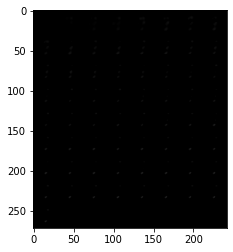

Epoch [64/400] Batch: [1/60] KL-Divergence: 2.8212280085426755e-05 Cross-Entropy: 0.2615397274494171 Loss: 0.26156795024871826
Epoch [64/400] Batch: [2/60] KL-Divergence: 2.7167128791916184e-05 Cross-Entropy: 0.2617186903953552 Loss: 0.2617458701133728
Epoch [64/400] Batch: [3/60] KL-Divergence: 2.526061871321872e-05 Cross-Entropy: 0.26485058665275574 Loss: 0.2648758590221405
Epoch [64/400] Batch: [4/60] KL-Divergence: 2.650550777616445e-05 Cross-Entropy: 0.2597436010837555 Loss: 0.25977009534835815
Epoch [64/400] Batch: [5/60] KL-Divergence: 2.6970443286700174e-05 Cross-Entropy: 0.26962175965309143 Loss: 0.2696487307548523
Epoch [64/400] Batch: [6/60] KL-Divergence: 2.7356147256796248e-05 Cross-Entropy: 0.2673797607421875 Loss: 0.2674071192741394
Epoch [64/400] Batch: [7/60] KL-Divergence: 2.592632154119201e-05 Cross-Entropy: 0.2613600790500641 Loss: 0.2613860070705414
Epoch [64/400] Batch: [8/60] KL-Divergence: 2.6739997338154353e-05 Cross-Entropy: 0.2566058039665222 Loss: 0.25663253

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [64/400] Batch: [60/60] KL-Divergence: 2.3969307221705094e-05 Cross-Entropy: 0.27273839712142944 Loss: 0.27276235818862915
Epoch [64/400] Batch: [60/60] KL-Divergence: 2.3969307221705094e-05 Cross-Entropy: 0.27273839712142944 Loss: 0.27276235818862915


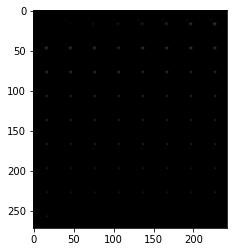

Epoch [65/400] Batch: [1/60] KL-Divergence: 2.4474638848914765e-05 Cross-Entropy: 0.26139751076698303 Loss: 0.26142197847366333
Epoch [65/400] Batch: [2/60] KL-Divergence: 2.4951285013230518e-05 Cross-Entropy: 0.2616466283798218 Loss: 0.2616715729236603
Epoch [65/400] Batch: [3/60] KL-Divergence: 2.3225937184179202e-05 Cross-Entropy: 0.26483482122421265 Loss: 0.26485803723335266
Epoch [65/400] Batch: [4/60] KL-Divergence: 2.3651160518056713e-05 Cross-Entropy: 0.25982746481895447 Loss: 0.2598511278629303
Epoch [65/400] Batch: [5/60] KL-Divergence: 2.382724778726697e-05 Cross-Entropy: 0.26967599987983704 Loss: 0.2696998417377472
Epoch [65/400] Batch: [6/60] KL-Divergence: 2.368595050938893e-05 Cross-Entropy: 0.26726487278938293 Loss: 0.26728856563568115
Epoch [65/400] Batch: [7/60] KL-Divergence: 2.4103850591927767e-05 Cross-Entropy: 0.26133114099502563 Loss: 0.2613552510738373
Epoch [65/400] Batch: [8/60] KL-Divergence: 2.4598273739684373e-05 Cross-Entropy: 0.2566848695278168 Loss: 0.25

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [65/400] Batch: [60/60] KL-Divergence: 2.4357375878025778e-05 Cross-Entropy: 0.272865891456604 Loss: 0.27289023995399475
Epoch [65/400] Batch: [60/60] KL-Divergence: 2.4357375878025778e-05 Cross-Entropy: 0.272865891456604 Loss: 0.27289023995399475


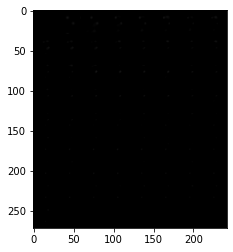

Epoch [66/400] Batch: [1/60] KL-Divergence: 2.252990634588059e-05 Cross-Entropy: 0.26139217615127563 Loss: 0.26141470670700073
Epoch [66/400] Batch: [2/60] KL-Divergence: 2.387622771493625e-05 Cross-Entropy: 0.2616381347179413 Loss: 0.26166200637817383
Epoch [66/400] Batch: [3/60] KL-Divergence: 2.2841415557195432e-05 Cross-Entropy: 0.264923632144928 Loss: 0.26494646072387695
Epoch [66/400] Batch: [4/60] KL-Divergence: 2.157814014935866e-05 Cross-Entropy: 0.2599042057991028 Loss: 0.2599257826805115
Epoch [66/400] Batch: [5/60] KL-Divergence: 2.309867886651773e-05 Cross-Entropy: 0.2696216106414795 Loss: 0.26964470744132996
Epoch [66/400] Batch: [6/60] KL-Divergence: 2.365604268561583e-05 Cross-Entropy: 0.2671935558319092 Loss: 0.267217218875885
Epoch [66/400] Batch: [7/60] KL-Divergence: 2.368987952650059e-05 Cross-Entropy: 0.26135948300361633 Loss: 0.26138317584991455
Epoch [66/400] Batch: [8/60] KL-Divergence: 2.1352156181819737e-05 Cross-Entropy: 0.2565445899963379 Loss: 0.2565659284

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [66/400] Batch: [60/60] KL-Divergence: 2.0786399545613676e-05 Cross-Entropy: 0.27286508679389954 Loss: 0.27288585901260376
Epoch [66/400] Batch: [60/60] KL-Divergence: 2.0786399545613676e-05 Cross-Entropy: 0.27286508679389954 Loss: 0.27288585901260376


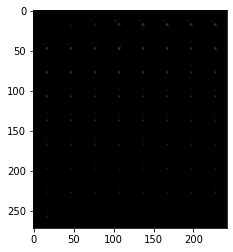

Epoch [67/400] Batch: [1/60] KL-Divergence: 2.154544745280873e-05 Cross-Entropy: 0.26141101121902466 Loss: 0.26143255829811096
Epoch [67/400] Batch: [2/60] KL-Divergence: 2.044982829829678e-05 Cross-Entropy: 0.2617087662220001 Loss: 0.2617292106151581
Epoch [67/400] Batch: [3/60] KL-Divergence: 2.029109964496456e-05 Cross-Entropy: 0.26496219635009766 Loss: 0.2649824917316437
Epoch [67/400] Batch: [4/60] KL-Divergence: 2.1187095626373775e-05 Cross-Entropy: 0.2597425878047943 Loss: 0.25976377725601196
Epoch [67/400] Batch: [5/60] KL-Divergence: 2.1247444237815216e-05 Cross-Entropy: 0.2695731818675995 Loss: 0.2695944309234619
Epoch [67/400] Batch: [6/60] KL-Divergence: 2.1945570551906712e-05 Cross-Entropy: 0.2671194076538086 Loss: 0.26714134216308594
Epoch [67/400] Batch: [7/60] KL-Divergence: 2.069793663395103e-05 Cross-Entropy: 0.2612413763999939 Loss: 0.26126208901405334
Epoch [67/400] Batch: [8/60] KL-Divergence: 2.0257948563084938e-05 Cross-Entropy: 0.2566615045070648 Loss: 0.2566817

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [67/400] Batch: [60/60] KL-Divergence: 2.212821891589556e-05 Cross-Entropy: 0.27284201979637146 Loss: 0.27286413311958313
Epoch [67/400] Batch: [60/60] KL-Divergence: 2.212821891589556e-05 Cross-Entropy: 0.27284201979637146 Loss: 0.27286413311958313


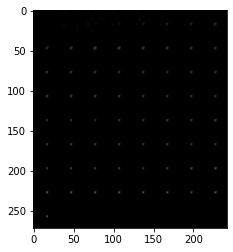

Epoch [68/400] Batch: [1/60] KL-Divergence: 2.243789640488103e-05 Cross-Entropy: 0.2613380551338196 Loss: 0.2613604962825775
Epoch [68/400] Batch: [2/60] KL-Divergence: 2.206550561822951e-05 Cross-Entropy: 0.26172247529029846 Loss: 0.26174452900886536
Epoch [68/400] Batch: [3/60] KL-Divergence: 1.9820899979094975e-05 Cross-Entropy: 0.2649047374725342 Loss: 0.264924556016922
Epoch [68/400] Batch: [4/60] KL-Divergence: 1.971305755432695e-05 Cross-Entropy: 0.25972798466682434 Loss: 0.2597476840019226
Epoch [68/400] Batch: [5/60] KL-Divergence: 2.0771713025169447e-05 Cross-Entropy: 0.26956987380981445 Loss: 0.2695906460285187
Epoch [68/400] Batch: [6/60] KL-Divergence: 2.1723364625358954e-05 Cross-Entropy: 0.2672584354877472 Loss: 0.2672801613807678
Epoch [68/400] Batch: [7/60] KL-Divergence: 2.1642379579134285e-05 Cross-Entropy: 0.2612895369529724 Loss: 0.2613111734390259
Epoch [68/400] Batch: [8/60] KL-Divergence: 2.08253477467224e-05 Cross-Entropy: 0.25660204887390137 Loss: 0.2566228806

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [68/400] Batch: [60/60] KL-Divergence: 2.167095044569578e-05 Cross-Entropy: 0.27290573716163635 Loss: 0.2729274034500122
Epoch [68/400] Batch: [60/60] KL-Divergence: 2.167095044569578e-05 Cross-Entropy: 0.27290573716163635 Loss: 0.2729274034500122


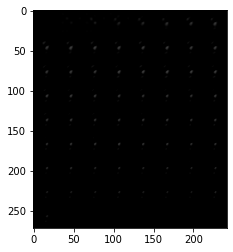

Epoch [69/400] Batch: [1/60] KL-Divergence: 2.0970383047824726e-05 Cross-Entropy: 0.26135146617889404 Loss: 0.261372447013855
Epoch [69/400] Batch: [2/60] KL-Divergence: 2.0873336325166747e-05 Cross-Entropy: 0.2615564465522766 Loss: 0.261577308177948
Epoch [69/400] Batch: [3/60] KL-Divergence: 1.9671020709211007e-05 Cross-Entropy: 0.264794260263443 Loss: 0.26481392979621887
Epoch [69/400] Batch: [4/60] KL-Divergence: 1.857589631981682e-05 Cross-Entropy: 0.25980985164642334 Loss: 0.2598284184932709
Epoch [69/400] Batch: [5/60] KL-Divergence: 1.975685154320672e-05 Cross-Entropy: 0.26951223611831665 Loss: 0.2695319950580597
Epoch [69/400] Batch: [6/60] KL-Divergence: 2.0632667656172998e-05 Cross-Entropy: 0.26720890402793884 Loss: 0.26722952723503113
Epoch [69/400] Batch: [7/60] KL-Divergence: 1.987911127798725e-05 Cross-Entropy: 0.26132309436798096 Loss: 0.26134297251701355
Epoch [69/400] Batch: [8/60] KL-Divergence: 2.002567271119915e-05 Cross-Entropy: 0.25672298669815063 Loss: 0.2567430

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [69/400] Batch: [60/60] KL-Divergence: 2.065753869828768e-05 Cross-Entropy: 0.2729310691356659 Loss: 0.27295172214508057
Epoch [69/400] Batch: [60/60] KL-Divergence: 2.065753869828768e-05 Cross-Entropy: 0.2729310691356659 Loss: 0.27295172214508057


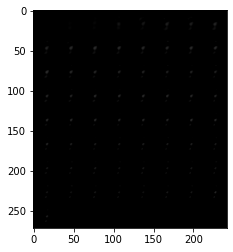

Epoch [70/400] Batch: [1/60] KL-Divergence: 2.1096153432154097e-05 Cross-Entropy: 0.26127487421035767 Loss: 0.26129597425460815
Epoch [70/400] Batch: [2/60] KL-Divergence: 1.9798773791990243e-05 Cross-Entropy: 0.26165342330932617 Loss: 0.2616732120513916
Epoch [70/400] Batch: [3/60] KL-Divergence: 1.930934922711458e-05 Cross-Entropy: 0.26484888792037964 Loss: 0.26486819982528687
Epoch [70/400] Batch: [4/60] KL-Divergence: 1.9069748304900713e-05 Cross-Entropy: 0.2599431574344635 Loss: 0.2599622309207916
Epoch [70/400] Batch: [5/60] KL-Divergence: 1.95607753994409e-05 Cross-Entropy: 0.26958516240119934 Loss: 0.26960471272468567
Epoch [70/400] Batch: [6/60] KL-Divergence: 1.982524736376945e-05 Cross-Entropy: 0.26710158586502075 Loss: 0.26712140440940857
Epoch [70/400] Batch: [7/60] KL-Divergence: 2.035282159340568e-05 Cross-Entropy: 0.26120293140411377 Loss: 0.26122328639030457
Epoch [70/400] Batch: [8/60] KL-Divergence: 1.901741052279249e-05 Cross-Entropy: 0.2565154433250427 Loss: 0.2565

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [70/400] Batch: [60/60] KL-Divergence: 2.079586010950152e-05 Cross-Entropy: 0.27309083938598633 Loss: 0.27311164140701294
Epoch [70/400] Batch: [60/60] KL-Divergence: 2.079586010950152e-05 Cross-Entropy: 0.27309083938598633 Loss: 0.27311164140701294


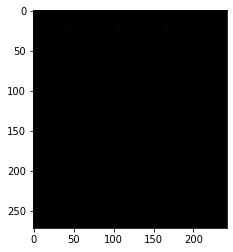

Epoch [71/400] Batch: [1/60] KL-Divergence: 2.0767822206835262e-05 Cross-Entropy: 0.2613336145877838 Loss: 0.26135438680648804
Epoch [71/400] Batch: [2/60] KL-Divergence: 1.9055327356909402e-05 Cross-Entropy: 0.26171132922172546 Loss: 0.2617303729057312
Epoch [71/400] Batch: [3/60] KL-Divergence: 1.903606425912585e-05 Cross-Entropy: 0.2649115025997162 Loss: 0.2649305462837219
Epoch [71/400] Batch: [4/60] KL-Divergence: 1.727397830109112e-05 Cross-Entropy: 0.25997933745384216 Loss: 0.259996622800827
Epoch [71/400] Batch: [5/60] KL-Divergence: 1.7830276192398742e-05 Cross-Entropy: 0.2694719433784485 Loss: 0.26948976516723633
Epoch [71/400] Batch: [6/60] KL-Divergence: 1.9000166503246874e-05 Cross-Entropy: 0.2671452760696411 Loss: 0.26716428995132446
Epoch [71/400] Batch: [7/60] KL-Divergence: 1.856292692536954e-05 Cross-Entropy: 0.2613195776939392 Loss: 0.26133814454078674
Epoch [71/400] Batch: [8/60] KL-Divergence: 1.8209686459158547e-05 Cross-Entropy: 0.256618857383728 Loss: 0.25663706

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [71/400] Batch: [60/60] KL-Divergence: 1.9606017303885892e-05 Cross-Entropy: 0.2732514441013336 Loss: 0.2732710540294647
Epoch [71/400] Batch: [60/60] KL-Divergence: 1.9606017303885892e-05 Cross-Entropy: 0.2732514441013336 Loss: 0.2732710540294647


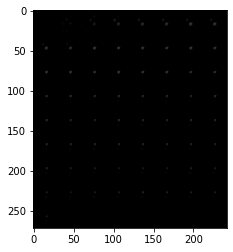

Epoch [72/400] Batch: [1/60] KL-Divergence: 1.948638782778289e-05 Cross-Entropy: 0.2611697316169739 Loss: 0.26118922233581543
Epoch [72/400] Batch: [2/60] KL-Divergence: 1.9745444660657085e-05 Cross-Entropy: 0.26171213388442993 Loss: 0.261731892824173
Epoch [72/400] Batch: [3/60] KL-Divergence: 1.842239362304099e-05 Cross-Entropy: 0.26482126116752625 Loss: 0.26483967900276184
Epoch [72/400] Batch: [4/60] KL-Divergence: 1.709987554932013e-05 Cross-Entropy: 0.25984516739845276 Loss: 0.2598622739315033
Epoch [72/400] Batch: [5/60] KL-Divergence: 1.7141112039098516e-05 Cross-Entropy: 0.26950740814208984 Loss: 0.26952454447746277
Epoch [72/400] Batch: [6/60] KL-Divergence: 1.9026030713575892e-05 Cross-Entropy: 0.26707491278648376 Loss: 0.2670939266681671
Epoch [72/400] Batch: [7/60] KL-Divergence: 1.7989157640840858e-05 Cross-Entropy: 0.2612089216709137 Loss: 0.26122692227363586
Epoch [72/400] Batch: [8/60] KL-Divergence: 1.8413238649372943e-05 Cross-Entropy: 0.25667211413383484 Loss: 0.256

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [72/400] Batch: [60/60] KL-Divergence: 1.823997445171699e-05 Cross-Entropy: 0.27324438095092773 Loss: 0.273262619972229
Epoch [72/400] Batch: [60/60] KL-Divergence: 1.823997445171699e-05 Cross-Entropy: 0.27324438095092773 Loss: 0.273262619972229


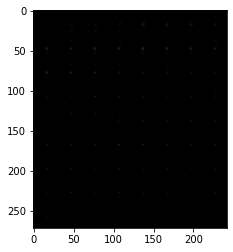

Epoch [73/400] Batch: [1/60] KL-Divergence: 1.8644064766704105e-05 Cross-Entropy: 0.2611766457557678 Loss: 0.2611953020095825
Epoch [73/400] Batch: [2/60] KL-Divergence: 1.796249307517428e-05 Cross-Entropy: 0.26154789328575134 Loss: 0.2615658640861511
Epoch [73/400] Batch: [3/60] KL-Divergence: 1.8308066501049325e-05 Cross-Entropy: 0.2648318111896515 Loss: 0.26485010981559753
Epoch [73/400] Batch: [4/60] KL-Divergence: 1.5802344933035783e-05 Cross-Entropy: 0.2598327696323395 Loss: 0.25984856486320496
Epoch [73/400] Batch: [5/60] KL-Divergence: 1.8283310055267066e-05 Cross-Entropy: 0.2695924639701843 Loss: 0.269610732793808
Epoch [73/400] Batch: [6/60] KL-Divergence: 1.8451461073709652e-05 Cross-Entropy: 0.26712897419929504 Loss: 0.267147421836853
Epoch [73/400] Batch: [7/60] KL-Divergence: 1.8040389477391727e-05 Cross-Entropy: 0.2612360715866089 Loss: 0.26125410199165344
Epoch [73/400] Batch: [8/60] KL-Divergence: 1.6609992599114776e-05 Cross-Entropy: 0.25670263171195984 Loss: 0.256719

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [73/400] Batch: [60/60] KL-Divergence: 1.7291869880864397e-05 Cross-Entropy: 0.2734273374080658 Loss: 0.27344462275505066
Epoch [73/400] Batch: [60/60] KL-Divergence: 1.7291869880864397e-05 Cross-Entropy: 0.2734273374080658 Loss: 0.27344462275505066


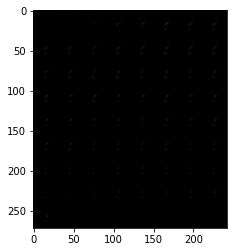

Epoch [74/400] Batch: [1/60] KL-Divergence: 1.891845568025019e-05 Cross-Entropy: 0.2611248791217804 Loss: 0.2611438035964966
Epoch [74/400] Batch: [2/60] KL-Divergence: 1.8094673578161746e-05 Cross-Entropy: 0.26145267486572266 Loss: 0.261470764875412
Epoch [74/400] Batch: [3/60] KL-Divergence: 1.661998794588726e-05 Cross-Entropy: 0.2647537291049957 Loss: 0.26477035880088806
Epoch [74/400] Batch: [4/60] KL-Divergence: 1.5106887076399289e-05 Cross-Entropy: 0.25990796089172363 Loss: 0.2599230706691742
Epoch [74/400] Batch: [5/60] KL-Divergence: 1.485870325268479e-05 Cross-Entropy: 0.2694532871246338 Loss: 0.26946815848350525
Epoch [74/400] Batch: [6/60] KL-Divergence: 1.6952284568105824e-05 Cross-Entropy: 0.26702314615249634 Loss: 0.26704010367393494
Epoch [74/400] Batch: [7/60] KL-Divergence: 1.607929152669385e-05 Cross-Entropy: 0.26135674118995667 Loss: 0.261372834444046
Epoch [74/400] Batch: [8/60] KL-Divergence: 1.667858123255428e-05 Cross-Entropy: 0.2567507028579712 Loss: 0.256767392

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [74/400] Batch: [60/60] KL-Divergence: 1.68640890478855e-05 Cross-Entropy: 0.27345529198646545 Loss: 0.2734721601009369
Epoch [74/400] Batch: [60/60] KL-Divergence: 1.68640890478855e-05 Cross-Entropy: 0.27345529198646545 Loss: 0.2734721601009369


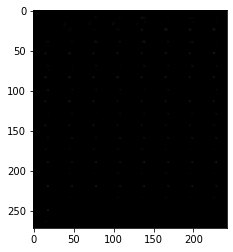

Epoch [75/400] Batch: [1/60] KL-Divergence: 1.8623657524585724e-05 Cross-Entropy: 0.2611842155456543 Loss: 0.2612028419971466
Epoch [75/400] Batch: [2/60] KL-Divergence: 1.7921256585395895e-05 Cross-Entropy: 0.2614751160144806 Loss: 0.2614930272102356
Epoch [75/400] Batch: [3/60] KL-Divergence: 1.668933873588685e-05 Cross-Entropy: 0.26481419801712036 Loss: 0.26483088731765747
Epoch [75/400] Batch: [4/60] KL-Divergence: 1.4631690646638162e-05 Cross-Entropy: 0.2597956955432892 Loss: 0.25981032848358154
Epoch [75/400] Batch: [5/60] KL-Divergence: 1.3976936315884814e-05 Cross-Entropy: 0.26951414346694946 Loss: 0.2695281207561493
Epoch [75/400] Batch: [6/60] KL-Divergence: 1.701930887065828e-05 Cross-Entropy: 0.2671908736228943 Loss: 0.26720789074897766
Epoch [75/400] Batch: [7/60] KL-Divergence: 1.6263427824014798e-05 Cross-Entropy: 0.26135945320129395 Loss: 0.2613757252693176
Epoch [75/400] Batch: [8/60] KL-Divergence: 1.7228889191756025e-05 Cross-Entropy: 0.2566547989845276 Loss: 0.25667

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [75/400] Batch: [60/60] KL-Divergence: 1.5499495930271223e-05 Cross-Entropy: 0.27357587218284607 Loss: 0.27359136939048767
Epoch [75/400] Batch: [60/60] KL-Divergence: 1.5499495930271223e-05 Cross-Entropy: 0.27357587218284607 Loss: 0.27359136939048767


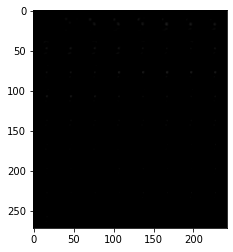

Epoch [76/400] Batch: [1/60] KL-Divergence: 1.636840715946164e-05 Cross-Entropy: 0.26110050082206726 Loss: 0.2611168622970581
Epoch [76/400] Batch: [2/60] KL-Divergence: 1.6122856322908774e-05 Cross-Entropy: 0.2614591717720032 Loss: 0.2614752948284149
Epoch [76/400] Batch: [3/60] KL-Divergence: 1.4697188817081042e-05 Cross-Entropy: 0.26483696699142456 Loss: 0.2648516595363617
Epoch [76/400] Batch: [4/60] KL-Divergence: 1.3524131645681337e-05 Cross-Entropy: 0.2598753571510315 Loss: 0.2598888874053955
Epoch [76/400] Batch: [5/60] KL-Divergence: 1.378513297822792e-05 Cross-Entropy: 0.2695164978504181 Loss: 0.2695302963256836
Epoch [76/400] Batch: [6/60] KL-Divergence: 1.44321056723129e-05 Cross-Entropy: 0.26703938841819763 Loss: 0.2670538127422333
Epoch [76/400] Batch: [7/60] KL-Divergence: 1.4145660315989517e-05 Cross-Entropy: 0.261443167924881 Loss: 0.26145732402801514
Epoch [76/400] Batch: [8/60] KL-Divergence: 1.468826212658314e-05 Cross-Entropy: 0.2567606568336487 Loss: 0.25677534937

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [76/400] Batch: [60/60] KL-Divergence: 1.5980758689693175e-05 Cross-Entropy: 0.27353399991989136 Loss: 0.27354997396469116
Epoch [76/400] Batch: [60/60] KL-Divergence: 1.5980758689693175e-05 Cross-Entropy: 0.27353399991989136 Loss: 0.27354997396469116


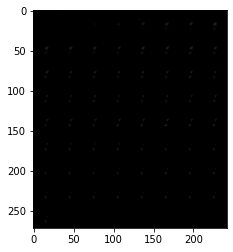

Epoch [77/400] Batch: [1/60] KL-Divergence: 1.5956115021253936e-05 Cross-Entropy: 0.2611885070800781 Loss: 0.26120445132255554
Epoch [77/400] Batch: [2/60] KL-Divergence: 1.6236381270573474e-05 Cross-Entropy: 0.2613748610019684 Loss: 0.2613911032676697
Epoch [77/400] Batch: [3/60] KL-Divergence: 1.5206755961116869e-05 Cross-Entropy: 0.26478466391563416 Loss: 0.2647998631000519
Epoch [77/400] Batch: [4/60] KL-Divergence: 1.3640747056342661e-05 Cross-Entropy: 0.25975871086120605 Loss: 0.2597723603248596
Epoch [77/400] Batch: [5/60] KL-Divergence: 1.3073768059257418e-05 Cross-Entropy: 0.2694392800331116 Loss: 0.26945236325263977
Epoch [77/400] Batch: [6/60] KL-Divergence: 1.3991088962939102e-05 Cross-Entropy: 0.2670969069004059 Loss: 0.2671108841896057
Epoch [77/400] Batch: [7/60] KL-Divergence: 1.522136608400615e-05 Cross-Entropy: 0.26127466559410095 Loss: 0.26128989458084106
Epoch [77/400] Batch: [8/60] KL-Divergence: 1.4276389265432954e-05 Cross-Entropy: 0.25678855180740356 Loss: 0.256

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [77/400] Batch: [60/60] KL-Divergence: 1.6812971807667054e-05 Cross-Entropy: 0.2734408676624298 Loss: 0.27345767617225647
Epoch [77/400] Batch: [60/60] KL-Divergence: 1.6812971807667054e-05 Cross-Entropy: 0.2734408676624298 Loss: 0.27345767617225647


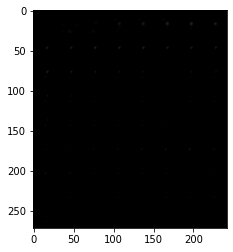

Epoch [78/400] Batch: [1/60] KL-Divergence: 1.900974166346714e-05 Cross-Entropy: 0.261076956987381 Loss: 0.26109597086906433
Epoch [78/400] Batch: [2/60] KL-Divergence: 1.8580207324703224e-05 Cross-Entropy: 0.26150786876678467 Loss: 0.2615264356136322
Epoch [78/400] Batch: [3/60] KL-Divergence: 1.5339126548497006e-05 Cross-Entropy: 0.26467186212539673 Loss: 0.2646872103214264
Epoch [78/400] Batch: [4/60] KL-Divergence: 1.346801764157135e-05 Cross-Entropy: 0.2597055733203888 Loss: 0.25971904397010803
Epoch [78/400] Batch: [5/60] KL-Divergence: 1.3576240235124715e-05 Cross-Entropy: 0.26954567432403564 Loss: 0.26955926418304443
Epoch [78/400] Batch: [6/60] KL-Divergence: 1.4857024325465318e-05 Cross-Entropy: 0.2671121656894684 Loss: 0.26712703704833984
Epoch [78/400] Batch: [7/60] KL-Divergence: 1.5321349565056153e-05 Cross-Entropy: 0.2612897753715515 Loss: 0.2613050937652588
Epoch [78/400] Batch: [8/60] KL-Divergence: 1.5744972188258544e-05 Cross-Entropy: 0.2567806541919708 Loss: 0.25679

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [78/400] Batch: [60/60] KL-Divergence: 1.547664578538388e-05 Cross-Entropy: 0.27343833446502686 Loss: 0.27345380187034607
Epoch [78/400] Batch: [60/60] KL-Divergence: 1.547664578538388e-05 Cross-Entropy: 0.27343833446502686 Loss: 0.27345380187034607


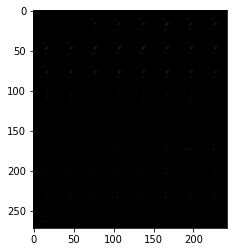

Epoch [79/400] Batch: [1/60] KL-Divergence: 4.5916211092844605e-05 Cross-Entropy: 0.2611337900161743 Loss: 0.26117971539497375
Epoch [79/400] Batch: [2/60] KL-Divergence: 8.660911407787353e-05 Cross-Entropy: 0.2614741921424866 Loss: 0.2615607976913452
Epoch [79/400] Batch: [3/60] KL-Divergence: 7.874656148487702e-05 Cross-Entropy: 0.2647704482078552 Loss: 0.2648491859436035
Epoch [79/400] Batch: [4/60] KL-Divergence: 3.96774266846478e-05 Cross-Entropy: 0.25979745388031006 Loss: 0.2598371207714081
Epoch [79/400] Batch: [5/60] KL-Divergence: 2.0998533727834e-05 Cross-Entropy: 0.2695242762565613 Loss: 0.2695452868938446
Epoch [79/400] Batch: [6/60] KL-Divergence: 2.7878493710886687e-05 Cross-Entropy: 0.2671082615852356 Loss: 0.2671361267566681
Epoch [79/400] Batch: [7/60] KL-Divergence: 4.121818346902728e-05 Cross-Entropy: 0.26145681738853455 Loss: 0.26149803400039673
Epoch [79/400] Batch: [8/60] KL-Divergence: 4.563117909128778e-05 Cross-Entropy: 0.2568384110927582 Loss: 0.25688403844833

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [79/400] Batch: [60/60] KL-Divergence: 1.6084250091807917e-05 Cross-Entropy: 0.2735569179058075 Loss: 0.27357301115989685
Epoch [79/400] Batch: [60/60] KL-Divergence: 1.6084250091807917e-05 Cross-Entropy: 0.2735569179058075 Loss: 0.27357301115989685


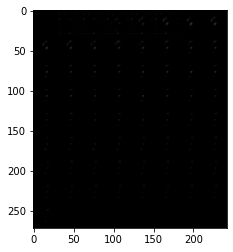

Epoch [80/400] Batch: [1/60] KL-Divergence: 1.7295722500421107e-05 Cross-Entropy: 0.2611790895462036 Loss: 0.2611963748931885
Epoch [80/400] Batch: [2/60] KL-Divergence: 1.8375931176706217e-05 Cross-Entropy: 0.26146528124809265 Loss: 0.26148366928100586
Epoch [80/400] Batch: [3/60] KL-Divergence: 1.616287227079738e-05 Cross-Entropy: 0.264718234539032 Loss: 0.2647343873977661
Epoch [80/400] Batch: [4/60] KL-Divergence: 1.3549155482905917e-05 Cross-Entropy: 0.2597232758998871 Loss: 0.2597368359565735
Epoch [80/400] Batch: [5/60] KL-Divergence: 1.2967338079761248e-05 Cross-Entropy: 0.2695707082748413 Loss: 0.26958367228507996
Epoch [80/400] Batch: [6/60] KL-Divergence: 1.4189452485879883e-05 Cross-Entropy: 0.26709675788879395 Loss: 0.2671109437942505
Epoch [80/400] Batch: [7/60] KL-Divergence: 1.4418448699871078e-05 Cross-Entropy: 0.2613619267940521 Loss: 0.26137635111808777
Epoch [80/400] Batch: [8/60] KL-Divergence: 1.580028583703097e-05 Cross-Entropy: 0.256938636302948 Loss: 0.25695443

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [80/400] Batch: [60/60] KL-Divergence: 1.338519996352261e-05 Cross-Entropy: 0.27347132563591003 Loss: 0.2734847068786621
Epoch [80/400] Batch: [60/60] KL-Divergence: 1.338519996352261e-05 Cross-Entropy: 0.27347132563591003 Loss: 0.2734847068786621


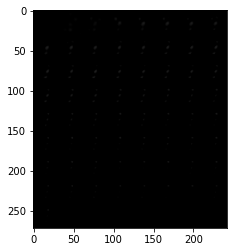

Epoch [81/400] Batch: [1/60] KL-Divergence: 1.463779426558176e-05 Cross-Entropy: 0.2610880434513092 Loss: 0.26110267639160156
Epoch [81/400] Batch: [2/60] KL-Divergence: 1.415294627804542e-05 Cross-Entropy: 0.26140862703323364 Loss: 0.2614227831363678
Epoch [81/400] Batch: [3/60] KL-Divergence: 1.3769264114671387e-05 Cross-Entropy: 0.26466506719589233 Loss: 0.26467883586883545
Epoch [81/400] Batch: [4/60] KL-Divergence: 1.2678641724050976e-05 Cross-Entropy: 0.25963521003723145 Loss: 0.2596478760242462
Epoch [81/400] Batch: [5/60] KL-Divergence: 1.1819229257525876e-05 Cross-Entropy: 0.26954028010368347 Loss: 0.2695521116256714
Epoch [81/400] Batch: [6/60] KL-Divergence: 1.3945616956334561e-05 Cross-Entropy: 0.2671729028224945 Loss: 0.26718685030937195
Epoch [81/400] Batch: [7/60] KL-Divergence: 1.1826477020804305e-05 Cross-Entropy: 0.26126226782798767 Loss: 0.2612740993499756
Epoch [81/400] Batch: [8/60] KL-Divergence: 1.3354529983189423e-05 Cross-Entropy: 0.25696614384651184 Loss: 0.25

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [81/400] Batch: [60/60] KL-Divergence: 1.3252677490527276e-05 Cross-Entropy: 0.27348166704177856 Loss: 0.2734949290752411
Epoch [81/400] Batch: [60/60] KL-Divergence: 1.3252677490527276e-05 Cross-Entropy: 0.27348166704177856 Loss: 0.2734949290752411


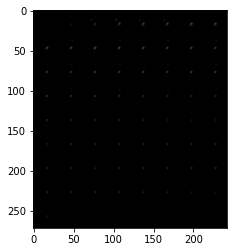

Epoch [82/400] Batch: [1/60] KL-Divergence: 1.4151611139823217e-05 Cross-Entropy: 0.26097628474235535 Loss: 0.2609904408454895
Epoch [82/400] Batch: [2/60] KL-Divergence: 1.2921103916596621e-05 Cross-Entropy: 0.2613010108470917 Loss: 0.26131394505500793
Epoch [82/400] Batch: [3/60] KL-Divergence: 1.318309750786284e-05 Cross-Entropy: 0.26462918519973755 Loss: 0.2646423578262329
Epoch [82/400] Batch: [4/60] KL-Divergence: 1.2240905562066473e-05 Cross-Entropy: 0.25966876745224 Loss: 0.25968101620674133
Epoch [82/400] Batch: [5/60] KL-Divergence: 1.1541595085873269e-05 Cross-Entropy: 0.26953932642936707 Loss: 0.2695508599281311
Epoch [82/400] Batch: [6/60] KL-Divergence: 1.2399711522448342e-05 Cross-Entropy: 0.2670953869819641 Loss: 0.2671077847480774
Epoch [82/400] Batch: [7/60] KL-Divergence: 1.1736564374587033e-05 Cross-Entropy: 0.2613259255886078 Loss: 0.26133766770362854
Epoch [82/400] Batch: [8/60] KL-Divergence: 1.1586341315705795e-05 Cross-Entropy: 0.2569296658039093 Loss: 0.256941

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [82/400] Batch: [60/60] KL-Divergence: 1.353675816062605e-05 Cross-Entropy: 0.27351438999176025 Loss: 0.27352792024612427
Epoch [82/400] Batch: [60/60] KL-Divergence: 1.353675816062605e-05 Cross-Entropy: 0.27351438999176025 Loss: 0.27352792024612427


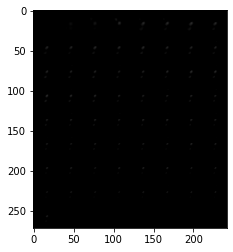

Epoch [83/400] Batch: [1/60] KL-Divergence: 1.3500327440851834e-05 Cross-Entropy: 0.2611556351184845 Loss: 0.2611691355705261
Epoch [83/400] Batch: [2/60] KL-Divergence: 1.2699699254881125e-05 Cross-Entropy: 0.2613484859466553 Loss: 0.26136118173599243
Epoch [83/400] Batch: [3/60] KL-Divergence: 1.1992110557912383e-05 Cross-Entropy: 0.26467761397361755 Loss: 0.2646895945072174
Epoch [83/400] Batch: [4/60] KL-Divergence: 1.0897178071900271e-05 Cross-Entropy: 0.2596587538719177 Loss: 0.2596696615219116
Epoch [83/400] Batch: [5/60] KL-Divergence: 1.0466957064636517e-05 Cross-Entropy: 0.2695217430591583 Loss: 0.2695322036743164
Epoch [83/400] Batch: [6/60] KL-Divergence: 1.1977081157965586e-05 Cross-Entropy: 0.26705414056777954 Loss: 0.2670661211013794
Epoch [83/400] Batch: [7/60] KL-Divergence: 1.2079314728907775e-05 Cross-Entropy: 0.2613260746002197 Loss: 0.26133814454078674
Epoch [83/400] Batch: [8/60] KL-Divergence: 1.1596450349316001e-05 Cross-Entropy: 0.25689584016799927 Loss: 0.2569

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [83/400] Batch: [60/60] KL-Divergence: 1.2092704309907276e-05 Cross-Entropy: 0.2735624611377716 Loss: 0.273574560880661
Epoch [83/400] Batch: [60/60] KL-Divergence: 1.2092704309907276e-05 Cross-Entropy: 0.2735624611377716 Loss: 0.273574560880661


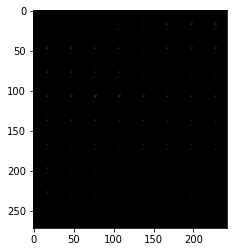

Epoch [84/400] Batch: [1/60] KL-Divergence: 1.2563018572109286e-05 Cross-Entropy: 0.26109838485717773 Loss: 0.26111096143722534
Epoch [84/400] Batch: [2/60] KL-Divergence: 1.2573318599606864e-05 Cross-Entropy: 0.2614479064941406 Loss: 0.26146048307418823
Epoch [84/400] Batch: [3/60] KL-Divergence: 1.1808661838585977e-05 Cross-Entropy: 0.2646939158439636 Loss: 0.26470571756362915
Epoch [84/400] Batch: [4/60] KL-Divergence: 1.0527915947022848e-05 Cross-Entropy: 0.25957104563713074 Loss: 0.2595815658569336
Epoch [84/400] Batch: [5/60] KL-Divergence: 9.905471415549982e-06 Cross-Entropy: 0.2694961130619049 Loss: 0.2695060074329376
Epoch [84/400] Batch: [6/60] KL-Divergence: 1.1492919838929083e-05 Cross-Entropy: 0.26712384819984436 Loss: 0.267135351896286
Epoch [84/400] Batch: [7/60] KL-Divergence: 1.109306322177872e-05 Cross-Entropy: 0.2613478899002075 Loss: 0.26135897636413574
Epoch [84/400] Batch: [8/60] KL-Divergence: 1.1300544429104775e-05 Cross-Entropy: 0.25693321228027344 Loss: 0.2569

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [84/400] Batch: [60/60] KL-Divergence: 1.2069091098965146e-05 Cross-Entropy: 0.273441344499588 Loss: 0.27345341444015503
Epoch [84/400] Batch: [60/60] KL-Divergence: 1.2069091098965146e-05 Cross-Entropy: 0.273441344499588 Loss: 0.27345341444015503


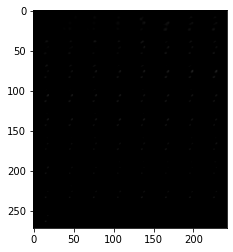

Epoch [85/400] Batch: [1/60] KL-Divergence: 1.192859599541407e-05 Cross-Entropy: 0.2609843909740448 Loss: 0.2609963119029999
Epoch [85/400] Batch: [2/60] KL-Divergence: 1.1374854693713132e-05 Cross-Entropy: 0.2613505423069 Loss: 0.2613619267940521
Epoch [85/400] Batch: [3/60] KL-Divergence: 1.0650138392520603e-05 Cross-Entropy: 0.2646123170852661 Loss: 0.2646229565143585
Epoch [85/400] Batch: [4/60] KL-Divergence: 9.582709935784806e-06 Cross-Entropy: 0.25954800844192505 Loss: 0.2595576047897339
Epoch [85/400] Batch: [5/60] KL-Divergence: 9.885406143439468e-06 Cross-Entropy: 0.2693600356578827 Loss: 0.2693699300289154
Epoch [85/400] Batch: [6/60] KL-Divergence: 1.0439414836582728e-05 Cross-Entropy: 0.2670134902000427 Loss: 0.2670239210128784
Epoch [85/400] Batch: [7/60] KL-Divergence: 1.0185661267314572e-05 Cross-Entropy: 0.26144731044769287 Loss: 0.26145750284194946
Epoch [85/400] Batch: [8/60] KL-Divergence: 1.0280379683536012e-05 Cross-Entropy: 0.25690314173698425 Loss: 0.25691342353

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [85/400] Batch: [60/60] KL-Divergence: 1.1329726476105861e-05 Cross-Entropy: 0.27353447675704956 Loss: 0.2735458016395569
Epoch [85/400] Batch: [60/60] KL-Divergence: 1.1329726476105861e-05 Cross-Entropy: 0.27353447675704956 Loss: 0.2735458016395569


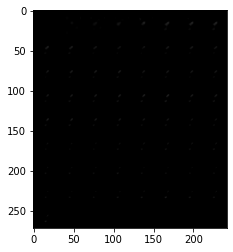

Epoch [86/400] Batch: [1/60] KL-Divergence: 1.1945914593525231e-05 Cross-Entropy: 0.26109474897384644 Loss: 0.2611066997051239
Epoch [86/400] Batch: [2/60] KL-Divergence: 1.172622614831198e-05 Cross-Entropy: 0.26129961013793945 Loss: 0.2613113224506378
Epoch [86/400] Batch: [3/60] KL-Divergence: 1.0687255780794658e-05 Cross-Entropy: 0.26471981406211853 Loss: 0.2647305130958557
Epoch [86/400] Batch: [4/60] KL-Divergence: 9.578056051395833e-06 Cross-Entropy: 0.2596351206302643 Loss: 0.25964468717575073
Epoch [86/400] Batch: [5/60] KL-Divergence: 8.871383215591777e-06 Cross-Entropy: 0.26943328976631165 Loss: 0.2694421708583832
Epoch [86/400] Batch: [6/60] KL-Divergence: 9.816855708777439e-06 Cross-Entropy: 0.2669900953769684 Loss: 0.26699990034103394
Epoch [86/400] Batch: [7/60] KL-Divergence: 1.0687408575904556e-05 Cross-Entropy: 0.26127979159355164 Loss: 0.2612904906272888
Epoch [86/400] Batch: [8/60] KL-Divergence: 1.024047833197983e-05 Cross-Entropy: 0.25687530636787415 Loss: 0.256885

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [86/400] Batch: [60/60] KL-Divergence: 1.1248855116718914e-05 Cross-Entropy: 0.2734525501728058 Loss: 0.27346378564834595
Epoch [86/400] Batch: [60/60] KL-Divergence: 1.1248855116718914e-05 Cross-Entropy: 0.2734525501728058 Loss: 0.27346378564834595


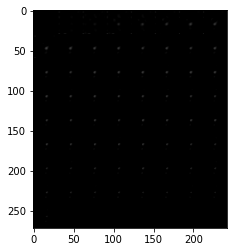

Epoch [87/400] Batch: [1/60] KL-Divergence: 1.151992728409823e-05 Cross-Entropy: 0.26107946038246155 Loss: 0.2610909938812256
Epoch [87/400] Batch: [2/60] KL-Divergence: 1.040786719386233e-05 Cross-Entropy: 0.26127171516418457 Loss: 0.2612821161746979
Epoch [87/400] Batch: [3/60] KL-Divergence: 1.0431060218252242e-05 Cross-Entropy: 0.2646239399909973 Loss: 0.264634370803833
Epoch [87/400] Batch: [4/60] KL-Divergence: 8.653450095152948e-06 Cross-Entropy: 0.25960326194763184 Loss: 0.25961190462112427
Epoch [87/400] Batch: [5/60] KL-Divergence: 8.973159310698975e-06 Cross-Entropy: 0.2694856822490692 Loss: 0.2694946527481079
Epoch [87/400] Batch: [6/60] KL-Divergence: 1.0217017916147597e-05 Cross-Entropy: 0.26713988184928894 Loss: 0.2671501040458679
Epoch [87/400] Batch: [7/60] KL-Divergence: 1.0068320989375934e-05 Cross-Entropy: 0.26129549741744995 Loss: 0.261305570602417
Epoch [87/400] Batch: [8/60] KL-Divergence: 1.0032538739324082e-05 Cross-Entropy: 0.25696852803230286 Loss: 0.25697857

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [87/400] Batch: [60/60] KL-Divergence: 1.1943854588025715e-05 Cross-Entropy: 0.2734425663948059 Loss: 0.2734545171260834
Epoch [87/400] Batch: [60/60] KL-Divergence: 1.1943854588025715e-05 Cross-Entropy: 0.2734425663948059 Loss: 0.2734545171260834


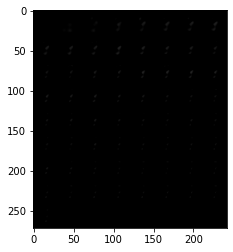

Epoch [88/400] Batch: [1/60] KL-Divergence: 1.2024040188407525e-05 Cross-Entropy: 0.26098886132240295 Loss: 0.2610008716583252
Epoch [88/400] Batch: [2/60] KL-Divergence: 1.1522864951984957e-05 Cross-Entropy: 0.2613082528114319 Loss: 0.2613197863101959
Epoch [88/400] Batch: [3/60] KL-Divergence: 1.0083274901262484e-05 Cross-Entropy: 0.2646971642971039 Loss: 0.2647072374820709
Epoch [88/400] Batch: [4/60] KL-Divergence: 9.588203283783514e-06 Cross-Entropy: 0.2594965994358063 Loss: 0.2595061957836151
Epoch [88/400] Batch: [5/60] KL-Divergence: 9.507980394118931e-06 Cross-Entropy: 0.2694496512413025 Loss: 0.26945915818214417
Epoch [88/400] Batch: [6/60] KL-Divergence: 1.0483931873750407e-05 Cross-Entropy: 0.26713284850120544 Loss: 0.2671433389186859
Epoch [88/400] Batch: [7/60] KL-Divergence: 1.0015678526542615e-05 Cross-Entropy: 0.26136288046836853 Loss: 0.2613728940486908
Epoch [88/400] Batch: [8/60] KL-Divergence: 1.0110092262038961e-05 Cross-Entropy: 0.2569940984249115 Loss: 0.2570042

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [88/400] Batch: [60/60] KL-Divergence: 1.2278022040845826e-05 Cross-Entropy: 0.27353861927986145 Loss: 0.2735508978366852
Epoch [88/400] Batch: [60/60] KL-Divergence: 1.2278022040845826e-05 Cross-Entropy: 0.27353861927986145 Loss: 0.2735508978366852


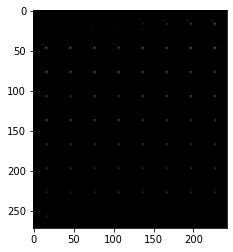

Epoch [89/400] Batch: [1/60] KL-Divergence: 1.2961692846147344e-05 Cross-Entropy: 0.2610599398612976 Loss: 0.26107290387153625
Epoch [89/400] Batch: [2/60] KL-Divergence: 1.1504134818096645e-05 Cross-Entropy: 0.2612830698490143 Loss: 0.26129457354545593
Epoch [89/400] Batch: [3/60] KL-Divergence: 1.0451545676914975e-05 Cross-Entropy: 0.2647136449813843 Loss: 0.26472410559654236
Epoch [89/400] Batch: [4/60] KL-Divergence: 8.972167961474042e-06 Cross-Entropy: 0.2596575617790222 Loss: 0.2596665322780609
Epoch [89/400] Batch: [5/60] KL-Divergence: 8.475875802105293e-06 Cross-Entropy: 0.26949363946914673 Loss: 0.26950210332870483
Epoch [89/400] Batch: [6/60] KL-Divergence: 1.028682709147688e-05 Cross-Entropy: 0.26707616448402405 Loss: 0.2670864462852478
Epoch [89/400] Batch: [7/60] KL-Divergence: 1.0103416570927948e-05 Cross-Entropy: 0.261389821767807 Loss: 0.26139992475509644
Epoch [89/400] Batch: [8/60] KL-Divergence: 1.0188369742536452e-05 Cross-Entropy: 0.2569544017314911 Loss: 0.256964

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [89/400] Batch: [60/60] KL-Divergence: 1.1377448572602589e-05 Cross-Entropy: 0.273444801568985 Loss: 0.2734561860561371
Epoch [89/400] Batch: [60/60] KL-Divergence: 1.1377448572602589e-05 Cross-Entropy: 0.273444801568985 Loss: 0.2734561860561371


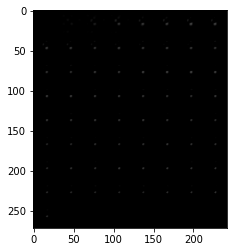

Epoch [90/400] Batch: [1/60] KL-Divergence: 1.1448401892266702e-05 Cross-Entropy: 0.2611224055290222 Loss: 0.2611338496208191
Epoch [90/400] Batch: [2/60] KL-Divergence: 1.0913086043728981e-05 Cross-Entropy: 0.26133087277412415 Loss: 0.26134178042411804
Epoch [90/400] Batch: [3/60] KL-Divergence: 9.944915291271172e-06 Cross-Entropy: 0.2646494209766388 Loss: 0.2646593749523163
Epoch [90/400] Batch: [4/60] KL-Divergence: 9.228630005964078e-06 Cross-Entropy: 0.25954529643058777 Loss: 0.25955453515052795
Epoch [90/400] Batch: [5/60] KL-Divergence: 8.064460416790098e-06 Cross-Entropy: 0.2694598138332367 Loss: 0.26946789026260376
Epoch [90/400] Batch: [6/60] KL-Divergence: 1.0058097359433305e-05 Cross-Entropy: 0.26708221435546875 Loss: 0.2670922577381134
Epoch [90/400] Batch: [7/60] KL-Divergence: 8.90945375431329e-06 Cross-Entropy: 0.2613231837749481 Loss: 0.26133209466934204
Epoch [90/400] Batch: [8/60] KL-Divergence: 8.990630703920033e-06 Cross-Entropy: 0.2568759322166443 Loss: 0.25688493

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [90/400] Batch: [60/60] KL-Divergence: 1.1229210031160619e-05 Cross-Entropy: 0.2733217477798462 Loss: 0.27333298325538635
Epoch [90/400] Batch: [60/60] KL-Divergence: 1.1229210031160619e-05 Cross-Entropy: 0.2733217477798462 Loss: 0.27333298325538635


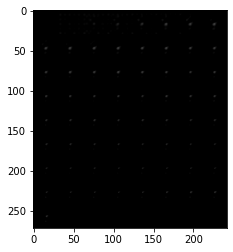

Epoch [91/400] Batch: [1/60] KL-Divergence: 1.1329345397825819e-05 Cross-Entropy: 0.26107221841812134 Loss: 0.26108354330062866
Epoch [91/400] Batch: [2/60] KL-Divergence: 1.0256881068926305e-05 Cross-Entropy: 0.2612978219985962 Loss: 0.26130807399749756
Epoch [91/400] Batch: [3/60] KL-Divergence: 9.30351234273985e-06 Cross-Entropy: 0.264701247215271 Loss: 0.26471054553985596
Epoch [91/400] Batch: [4/60] KL-Divergence: 8.267516932392027e-06 Cross-Entropy: 0.259488582611084 Loss: 0.2594968378543854
Epoch [91/400] Batch: [5/60] KL-Divergence: 8.473090929328464e-06 Cross-Entropy: 0.2694331705570221 Loss: 0.2694416344165802
Epoch [91/400] Batch: [6/60] KL-Divergence: 1.0001067494158633e-05 Cross-Entropy: 0.267002135515213 Loss: 0.2670121490955353
Epoch [91/400] Batch: [7/60] KL-Divergence: 8.676490324432962e-06 Cross-Entropy: 0.26133596897125244 Loss: 0.26134464144706726
Epoch [91/400] Batch: [8/60] KL-Divergence: 8.521232302882709e-06 Cross-Entropy: 0.25687742233276367 Loss: 0.25688594579

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [91/400] Batch: [60/60] KL-Divergence: 1.071735368896043e-05 Cross-Entropy: 0.27336829900741577 Loss: 0.27337902784347534
Epoch [91/400] Batch: [60/60] KL-Divergence: 1.071735368896043e-05 Cross-Entropy: 0.27336829900741577 Loss: 0.27337902784347534


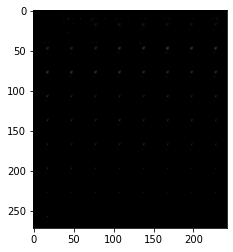

Epoch [92/400] Batch: [1/60] KL-Divergence: 1.0232314707536716e-05 Cross-Entropy: 0.2610633671283722 Loss: 0.26107358932495117
Epoch [92/400] Batch: [2/60] KL-Divergence: 9.229583156411536e-06 Cross-Entropy: 0.2612914741039276 Loss: 0.2613007128238678
Epoch [92/400] Batch: [3/60] KL-Divergence: 8.62163506099023e-06 Cross-Entropy: 0.26462140679359436 Loss: 0.2646300196647644
Epoch [92/400] Batch: [4/60] KL-Divergence: 8.213996807171497e-06 Cross-Entropy: 0.2596152722835541 Loss: 0.2596234977245331
Epoch [92/400] Batch: [5/60] KL-Divergence: 8.210334272007458e-06 Cross-Entropy: 0.2695665657520294 Loss: 0.26957476139068604
Epoch [92/400] Batch: [6/60] KL-Divergence: 9.009475434140768e-06 Cross-Entropy: 0.26704809069633484 Loss: 0.2670570909976959
Epoch [92/400] Batch: [7/60] KL-Divergence: 8.367843292944599e-06 Cross-Entropy: 0.2612479627132416 Loss: 0.2612563371658325
Epoch [92/400] Batch: [8/60] KL-Divergence: 7.985228876350448e-06 Cross-Entropy: 0.25690120458602905 Loss: 0.256909191608

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [92/400] Batch: [60/60] KL-Divergence: 1.1852340321638621e-05 Cross-Entropy: 0.27344104647636414 Loss: 0.27345290780067444
Epoch [92/400] Batch: [60/60] KL-Divergence: 1.1852340321638621e-05 Cross-Entropy: 0.27344104647636414 Loss: 0.27345290780067444


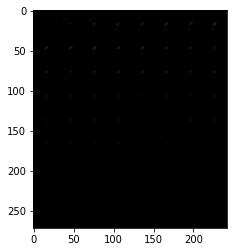

Epoch [93/400] Batch: [1/60] KL-Divergence: 1.1174926839885302e-05 Cross-Entropy: 0.2610708475112915 Loss: 0.2610820233821869
Epoch [93/400] Batch: [2/60] KL-Divergence: 9.019699064083397e-06 Cross-Entropy: 0.26132723689079285 Loss: 0.2613362669944763
Epoch [93/400] Batch: [3/60] KL-Divergence: 8.498573151882738e-06 Cross-Entropy: 0.26461243629455566 Loss: 0.26462092995643616
Epoch [93/400] Batch: [4/60] KL-Divergence: 8.097304998955224e-06 Cross-Entropy: 0.25942185521125793 Loss: 0.2594299614429474
Epoch [93/400] Batch: [5/60] KL-Divergence: 8.507804523105733e-06 Cross-Entropy: 0.26939061284065247 Loss: 0.26939910650253296
Epoch [93/400] Batch: [6/60] KL-Divergence: 9.403266631125007e-06 Cross-Entropy: 0.26702845096588135 Loss: 0.26703786849975586
Epoch [93/400] Batch: [7/60] KL-Divergence: 8.588523996877484e-06 Cross-Entropy: 0.26126182079315186 Loss: 0.2612704038619995
Epoch [93/400] Batch: [8/60] KL-Divergence: 8.364371751667932e-06 Cross-Entropy: 0.257100909948349 Loss: 0.25710928

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [93/400] Batch: [60/60] KL-Divergence: 1.0742874110292178e-05 Cross-Entropy: 0.27353641390800476 Loss: 0.27354714274406433
Epoch [93/400] Batch: [60/60] KL-Divergence: 1.0742874110292178e-05 Cross-Entropy: 0.27353641390800476 Loss: 0.27354714274406433


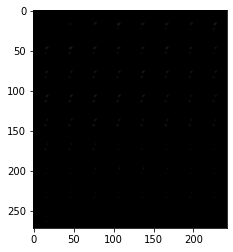

Epoch [94/400] Batch: [1/60] KL-Divergence: 1.0428008863527793e-05 Cross-Entropy: 0.2610893249511719 Loss: 0.26109975576400757
Epoch [94/400] Batch: [2/60] KL-Divergence: 8.500785952492151e-06 Cross-Entropy: 0.26132914423942566 Loss: 0.26133763790130615
Epoch [94/400] Batch: [3/60] KL-Divergence: 8.450774657831062e-06 Cross-Entropy: 0.2646395266056061 Loss: 0.2646479904651642
Epoch [94/400] Batch: [4/60] KL-Divergence: 7.33310662326403e-06 Cross-Entropy: 0.25954222679138184 Loss: 0.2595495581626892
Epoch [94/400] Batch: [5/60] KL-Divergence: 7.70835868024733e-06 Cross-Entropy: 0.26944977045059204 Loss: 0.26945748925209045
Epoch [94/400] Batch: [6/60] KL-Divergence: 8.379325663554482e-06 Cross-Entropy: 0.2669997811317444 Loss: 0.2670081555843353
Epoch [94/400] Batch: [7/60] KL-Divergence: 7.922172699181829e-06 Cross-Entropy: 0.261270135641098 Loss: 0.26127806305885315
Epoch [94/400] Batch: [8/60] KL-Divergence: 7.960281436680816e-06 Cross-Entropy: 0.25698989629745483 Loss: 0.25699785351

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [94/400] Batch: [60/60] KL-Divergence: 1.0419616046419833e-05 Cross-Entropy: 0.2734258770942688 Loss: 0.2734363079071045
Epoch [94/400] Batch: [60/60] KL-Divergence: 1.0419616046419833e-05 Cross-Entropy: 0.2734258770942688 Loss: 0.2734363079071045


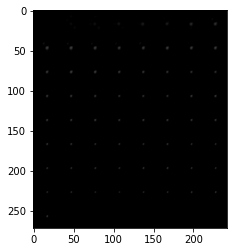

Epoch [95/400] Batch: [1/60] KL-Divergence: 1.0754394679679535e-05 Cross-Entropy: 0.2610938549041748 Loss: 0.26110461354255676
Epoch [95/400] Batch: [2/60] KL-Divergence: 8.447876098216511e-06 Cross-Entropy: 0.2613608241081238 Loss: 0.2613692581653595
Epoch [95/400] Batch: [3/60] KL-Divergence: 8.543319381715264e-06 Cross-Entropy: 0.2645505666732788 Loss: 0.2645591199398041
Epoch [95/400] Batch: [4/60] KL-Divergence: 7.191199983935803e-06 Cross-Entropy: 0.2595258057117462 Loss: 0.25953298807144165
Epoch [95/400] Batch: [5/60] KL-Divergence: 7.476310656784335e-06 Cross-Entropy: 0.2693958878517151 Loss: 0.2694033682346344
Epoch [95/400] Batch: [6/60] KL-Divergence: 8.512649401382077e-06 Cross-Entropy: 0.26712584495544434 Loss: 0.2671343684196472
Epoch [95/400] Batch: [7/60] KL-Divergence: 7.206001100712456e-06 Cross-Entropy: 0.2613089680671692 Loss: 0.261316180229187
Epoch [95/400] Batch: [8/60] KL-Divergence: 7.63359093980398e-06 Cross-Entropy: 0.25701844692230225 Loss: 0.25702607631683

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [95/400] Batch: [60/60] KL-Divergence: 1.0206566003034823e-05 Cross-Entropy: 0.2733539938926697 Loss: 0.27336418628692627
Epoch [95/400] Batch: [60/60] KL-Divergence: 1.0206566003034823e-05 Cross-Entropy: 0.2733539938926697 Loss: 0.27336418628692627


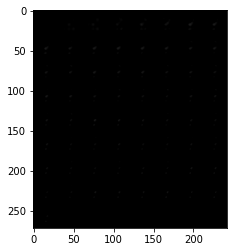

Epoch [96/400] Batch: [1/60] KL-Divergence: 9.768905329110567e-06 Cross-Entropy: 0.2610352039337158 Loss: 0.261044979095459
Epoch [96/400] Batch: [2/60] KL-Divergence: 8.976860044640489e-06 Cross-Entropy: 0.2612552046775818 Loss: 0.2612641751766205
Epoch [96/400] Batch: [3/60] KL-Divergence: 8.69281757331919e-06 Cross-Entropy: 0.26469868421554565 Loss: 0.26470738649368286
Epoch [96/400] Batch: [4/60] KL-Divergence: 7.0844648689671885e-06 Cross-Entropy: 0.25951701402664185 Loss: 0.2595241069793701
Epoch [96/400] Batch: [5/60] KL-Divergence: 7.551078397227684e-06 Cross-Entropy: 0.269430547952652 Loss: 0.26943808794021606
Epoch [96/400] Batch: [6/60] KL-Divergence: 8.995742973638698e-06 Cross-Entropy: 0.26703348755836487 Loss: 0.26704248785972595
Epoch [96/400] Batch: [7/60] KL-Divergence: 7.617607025167672e-06 Cross-Entropy: 0.2613476812839508 Loss: 0.26135531067848206
Epoch [96/400] Batch: [8/60] KL-Divergence: 7.802925210853573e-06 Cross-Entropy: 0.25697287917137146 Loss: 0.25698068737

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [96/400] Batch: [60/60] KL-Divergence: 9.722747563500889e-06 Cross-Entropy: 0.27340224385261536 Loss: 0.27341195940971375
Epoch [96/400] Batch: [60/60] KL-Divergence: 9.722747563500889e-06 Cross-Entropy: 0.27340224385261536 Loss: 0.27341195940971375


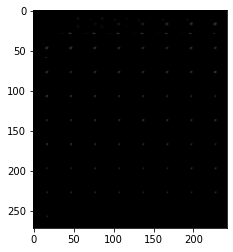

Epoch [97/400] Batch: [1/60] KL-Divergence: 8.944091860030312e-06 Cross-Entropy: 0.2611558437347412 Loss: 0.2611647844314575
Epoch [97/400] Batch: [2/60] KL-Divergence: 7.1566769292985555e-06 Cross-Entropy: 0.26131144165992737 Loss: 0.2613185942173004
Epoch [97/400] Batch: [3/60] KL-Divergence: 6.998825028858846e-06 Cross-Entropy: 0.26457011699676514 Loss: 0.26457712054252625
Epoch [97/400] Batch: [4/60] KL-Divergence: 6.463012596213957e-06 Cross-Entropy: 0.25949200987815857 Loss: 0.2594984769821167
Epoch [97/400] Batch: [5/60] KL-Divergence: 6.693534487567376e-06 Cross-Entropy: 0.2694280445575714 Loss: 0.26943475008010864
Epoch [97/400] Batch: [6/60] KL-Divergence: 7.718391316302586e-06 Cross-Entropy: 0.26696205139160156 Loss: 0.2669697701931
Epoch [97/400] Batch: [7/60] KL-Divergence: 6.63120272292872e-06 Cross-Entropy: 0.26125821471214294 Loss: 0.2612648606300354
Epoch [97/400] Batch: [8/60] KL-Divergence: 6.973800282139564e-06 Cross-Entropy: 0.25694841146469116 Loss: 0.256955385208

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [97/400] Batch: [60/60] KL-Divergence: 1.2074966434738599e-05 Cross-Entropy: 0.2733989655971527 Loss: 0.2734110355377197
Epoch [97/400] Batch: [60/60] KL-Divergence: 1.2074966434738599e-05 Cross-Entropy: 0.2733989655971527 Loss: 0.2734110355377197


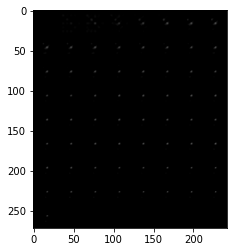

Epoch [98/400] Batch: [1/60] KL-Divergence: 1.078102104656864e-05 Cross-Entropy: 0.26107102632522583 Loss: 0.2610818147659302
Epoch [98/400] Batch: [2/60] KL-Divergence: 7.810439456079621e-06 Cross-Entropy: 0.26123523712158203 Loss: 0.2612430453300476
Epoch [98/400] Batch: [3/60] KL-Divergence: 8.594322025601286e-06 Cross-Entropy: 0.26461076736450195 Loss: 0.2646193504333496
Epoch [98/400] Batch: [4/60] KL-Divergence: 7.639006980753038e-06 Cross-Entropy: 0.2593770921230316 Loss: 0.25938472151756287
Epoch [98/400] Batch: [5/60] KL-Divergence: 8.193435860448517e-06 Cross-Entropy: 0.2695017158985138 Loss: 0.2695099115371704
Epoch [98/400] Batch: [6/60] KL-Divergence: 9.153480277745984e-06 Cross-Entropy: 0.2671380043029785 Loss: 0.26714715361595154
Epoch [98/400] Batch: [7/60] KL-Divergence: 7.478065526811406e-06 Cross-Entropy: 0.26134786009788513 Loss: 0.26135534048080444
Epoch [98/400] Batch: [8/60] KL-Divergence: 7.576103143946966e-06 Cross-Entropy: 0.2570238709449768 Loss: 0.2570314407

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [98/400] Batch: [60/60] KL-Divergence: 1.1283645108051132e-05 Cross-Entropy: 0.27341192960739136 Loss: 0.2734232246875763
Epoch [98/400] Batch: [60/60] KL-Divergence: 1.1283645108051132e-05 Cross-Entropy: 0.27341192960739136 Loss: 0.2734232246875763


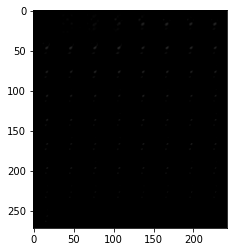

Epoch [99/400] Batch: [1/60] KL-Divergence: 1.0449790352140553e-05 Cross-Entropy: 0.26101088523864746 Loss: 0.26102134585380554
Epoch [99/400] Batch: [2/60] KL-Divergence: 8.464850907330401e-06 Cross-Entropy: 0.26128411293029785 Loss: 0.26129257678985596
Epoch [99/400] Batch: [3/60] KL-Divergence: 8.900375178200193e-06 Cross-Entropy: 0.26454681158065796 Loss: 0.2645557224750519
Epoch [99/400] Batch: [4/60] KL-Divergence: 8.325843737111427e-06 Cross-Entropy: 0.259391725063324 Loss: 0.25940003991127014
Epoch [99/400] Batch: [5/60] KL-Divergence: 8.365325811610091e-06 Cross-Entropy: 0.26947247982025146 Loss: 0.2694808542728424
Epoch [99/400] Batch: [6/60] KL-Divergence: 1.0345496775698848e-05 Cross-Entropy: 0.2670091688632965 Loss: 0.26701951026916504
Epoch [99/400] Batch: [7/60] KL-Divergence: 7.3707960837055e-06 Cross-Entropy: 0.26131728291511536 Loss: 0.2613246440887451
Epoch [99/400] Batch: [8/60] KL-Divergence: 8.34510774438968e-06 Cross-Entropy: 0.25688380002975464 Loss: 0.256892144

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [99/400] Batch: [60/60] KL-Divergence: 1.4023818948771805e-05 Cross-Entropy: 0.27347254753112793 Loss: 0.27348658442497253
Epoch [99/400] Batch: [60/60] KL-Divergence: 1.4023818948771805e-05 Cross-Entropy: 0.27347254753112793 Loss: 0.27348658442497253


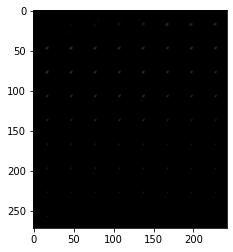

Epoch [100/400] Batch: [1/60] KL-Divergence: 1.2490615517890546e-05 Cross-Entropy: 0.2610054910182953 Loss: 0.26101797819137573
Epoch [100/400] Batch: [2/60] KL-Divergence: 9.702873285277747e-06 Cross-Entropy: 0.2613060772418976 Loss: 0.26131579279899597
Epoch [100/400] Batch: [3/60] KL-Divergence: 1.0757903510238975e-05 Cross-Entropy: 0.264512836933136 Loss: 0.26452359557151794
Epoch [100/400] Batch: [4/60] KL-Divergence: 1.0756835763459094e-05 Cross-Entropy: 0.2594040036201477 Loss: 0.25941476225852966
Epoch [100/400] Batch: [5/60] KL-Divergence: 9.265594599128235e-06 Cross-Entropy: 0.2694355249404907 Loss: 0.2694447934627533
Epoch [100/400] Batch: [6/60] KL-Divergence: 1.1843566426250618e-05 Cross-Entropy: 0.26700687408447266 Loss: 0.26701870560646057
Epoch [100/400] Batch: [7/60] KL-Divergence: 8.418464858550578e-06 Cross-Entropy: 0.26131826639175415 Loss: 0.2613266706466675
Epoch [100/400] Batch: [8/60] KL-Divergence: 1.0150603884540033e-05 Cross-Entropy: 0.25692158937454224 Loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [100/400] Batch: [60/60] KL-Divergence: 1.7526550436741672e-05 Cross-Entropy: 0.27335038781166077 Loss: 0.27336791157722473
Epoch [100/400] Batch: [60/60] KL-Divergence: 1.7526550436741672e-05 Cross-Entropy: 0.27335038781166077 Loss: 0.27336791157722473


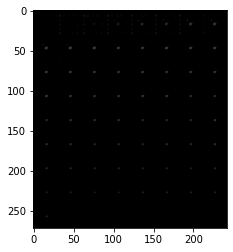

Epoch [101/400] Batch: [1/60] KL-Divergence: 1.4549407751474064e-05 Cross-Entropy: 0.26101309061050415 Loss: 0.26102763414382935
Epoch [101/400] Batch: [2/60] KL-Divergence: 1.1304473446216434e-05 Cross-Entropy: 0.26123249530792236 Loss: 0.2612437903881073
Epoch [101/400] Batch: [3/60] KL-Divergence: 1.1450500096543692e-05 Cross-Entropy: 0.26455414295196533 Loss: 0.2645655870437622
Epoch [101/400] Batch: [4/60] KL-Divergence: 1.0672607459127903e-05 Cross-Entropy: 0.25941476225852966 Loss: 0.25942543148994446
Epoch [101/400] Batch: [5/60] KL-Divergence: 9.468460120842792e-06 Cross-Entropy: 0.26952800154685974 Loss: 0.26953747868537903
Epoch [101/400] Batch: [6/60] KL-Divergence: 1.1734466170310043e-05 Cross-Entropy: 0.26698723435401917 Loss: 0.2669989764690399
Epoch [101/400] Batch: [7/60] KL-Divergence: 7.956314220791683e-06 Cross-Entropy: 0.26129069924354553 Loss: 0.26129865646362305
Epoch [101/400] Batch: [8/60] KL-Divergence: 9.511413736618124e-06 Cross-Entropy: 0.2570193111896515 L

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [101/400] Batch: [60/60] KL-Divergence: 1.473022439313354e-05 Cross-Entropy: 0.27340006828308105 Loss: 0.2734147906303406
Epoch [101/400] Batch: [60/60] KL-Divergence: 1.473022439313354e-05 Cross-Entropy: 0.27340006828308105 Loss: 0.2734147906303406


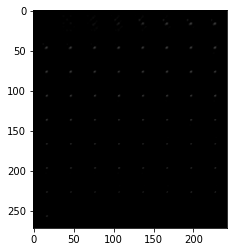

Epoch [102/400] Batch: [1/60] KL-Divergence: 1.0909538104897365e-05 Cross-Entropy: 0.2610914707183838 Loss: 0.2611023783683777
Epoch [102/400] Batch: [2/60] KL-Divergence: 8.115043783618603e-06 Cross-Entropy: 0.2612118124961853 Loss: 0.26121991872787476
Epoch [102/400] Batch: [3/60] KL-Divergence: 8.572349543101154e-06 Cross-Entropy: 0.26446837186813354 Loss: 0.2644769549369812
Epoch [102/400] Batch: [4/60] KL-Divergence: 7.992210157681257e-06 Cross-Entropy: 0.2593625485897064 Loss: 0.2593705356121063
Epoch [102/400] Batch: [5/60] KL-Divergence: 7.9745859693503e-06 Cross-Entropy: 0.26950737833976746 Loss: 0.26951536536216736
Epoch [102/400] Batch: [6/60] KL-Divergence: 9.148292519967072e-06 Cross-Entropy: 0.26698780059814453 Loss: 0.26699694991111755
Epoch [102/400] Batch: [7/60] KL-Divergence: 6.929817118361825e-06 Cross-Entropy: 0.26128408312797546 Loss: 0.2612910270690918
Epoch [102/400] Batch: [8/60] KL-Divergence: 7.93731669546105e-06 Cross-Entropy: 0.25692421197891235 Loss: 0.256

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [102/400] Batch: [60/60] KL-Divergence: 2.2986296244198456e-05 Cross-Entropy: 0.2733999788761139 Loss: 0.2734229564666748
Epoch [102/400] Batch: [60/60] KL-Divergence: 2.2986296244198456e-05 Cross-Entropy: 0.2733999788761139 Loss: 0.2734229564666748


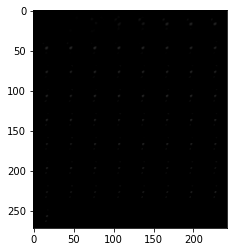

Epoch [103/400] Batch: [1/60] KL-Divergence: 1.783664629328996e-05 Cross-Entropy: 0.2609732449054718 Loss: 0.26099106669425964
Epoch [103/400] Batch: [2/60] KL-Divergence: 1.366024025628576e-05 Cross-Entropy: 0.261211633682251 Loss: 0.26122528314590454
Epoch [103/400] Batch: [3/60] KL-Divergence: 1.3755111467617098e-05 Cross-Entropy: 0.2645653486251831 Loss: 0.2645791172981262
Epoch [103/400] Batch: [4/60] KL-Divergence: 1.291793796553975e-05 Cross-Entropy: 0.25940340757369995 Loss: 0.2594163119792938
Epoch [103/400] Batch: [5/60] KL-Divergence: 1.1752586033253465e-05 Cross-Entropy: 0.2694380581378937 Loss: 0.26944980025291443
Epoch [103/400] Batch: [6/60] KL-Divergence: 1.4435615412367042e-05 Cross-Entropy: 0.2670058608055115 Loss: 0.2670202851295471
Epoch [103/400] Batch: [7/60] KL-Divergence: 9.580154255672824e-06 Cross-Entropy: 0.26121652126312256 Loss: 0.261226087808609
Epoch [103/400] Batch: [8/60] KL-Divergence: 1.136363971454557e-05 Cross-Entropy: 0.2569594979286194 Loss: 0.256

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [103/400] Batch: [60/60] KL-Divergence: 2.019428211497143e-05 Cross-Entropy: 0.2734365463256836 Loss: 0.27345675230026245
Epoch [103/400] Batch: [60/60] KL-Divergence: 2.019428211497143e-05 Cross-Entropy: 0.2734365463256836 Loss: 0.27345675230026245


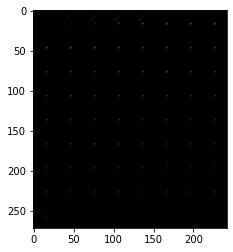

Epoch [104/400] Batch: [1/60] KL-Divergence: 1.5782356058480218e-05 Cross-Entropy: 0.2609623968601227 Loss: 0.26097819209098816
Epoch [104/400] Batch: [2/60] KL-Divergence: 1.218246416101465e-05 Cross-Entropy: 0.26122480630874634 Loss: 0.2612369954586029
Epoch [104/400] Batch: [3/60] KL-Divergence: 1.2254065950401127e-05 Cross-Entropy: 0.26458004117012024 Loss: 0.2645922899246216
Epoch [104/400] Batch: [4/60] KL-Divergence: 1.1294593605271075e-05 Cross-Entropy: 0.2594154179096222 Loss: 0.25942671298980713
Epoch [104/400] Batch: [5/60] KL-Divergence: 1.0330542863812298e-05 Cross-Entropy: 0.2693154215812683 Loss: 0.26932576298713684
Epoch [104/400] Batch: [6/60] KL-Divergence: 1.2670821888605133e-05 Cross-Entropy: 0.2669867277145386 Loss: 0.26699939370155334
Epoch [104/400] Batch: [7/60] KL-Divergence: 9.035758921527304e-06 Cross-Entropy: 0.2611669898033142 Loss: 0.2611760199069977
Epoch [104/400] Batch: [8/60] KL-Divergence: 1.0855407708731946e-05 Cross-Entropy: 0.2569209039211273 Loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [104/400] Batch: [60/60] KL-Divergence: 2.3402899387292564e-05 Cross-Entropy: 0.27325960993766785 Loss: 0.2732830047607422
Epoch [104/400] Batch: [60/60] KL-Divergence: 2.3402899387292564e-05 Cross-Entropy: 0.27325960993766785 Loss: 0.2732830047607422


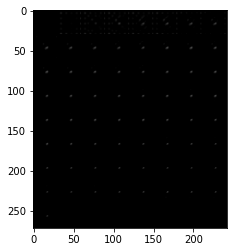

Epoch [105/400] Batch: [1/60] KL-Divergence: 1.877056092780549e-05 Cross-Entropy: 0.26094192266464233 Loss: 0.2609606981277466
Epoch [105/400] Batch: [2/60] KL-Divergence: 1.4265632671595085e-05 Cross-Entropy: 0.2611749470233917 Loss: 0.26118922233581543
Epoch [105/400] Batch: [3/60] KL-Divergence: 1.4632262718805578e-05 Cross-Entropy: 0.2645243704319 Loss: 0.2645390033721924
Epoch [105/400] Batch: [4/60] KL-Divergence: 1.3644523278344423e-05 Cross-Entropy: 0.2593962252140045 Loss: 0.2594098746776581
Epoch [105/400] Batch: [5/60] KL-Divergence: 1.2506256098276936e-05 Cross-Entropy: 0.26944467425346375 Loss: 0.2694571912288666
Epoch [105/400] Batch: [6/60] KL-Divergence: 1.5463561794604175e-05 Cross-Entropy: 0.2668970823287964 Loss: 0.2669125497341156
Epoch [105/400] Batch: [7/60] KL-Divergence: 1.143657664215425e-05 Cross-Entropy: 0.26125848293304443 Loss: 0.2612699270248413
Epoch [105/400] Batch: [8/60] KL-Divergence: 1.3454169675242156e-05 Cross-Entropy: 0.2569567561149597 Loss: 0.25

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [105/400] Batch: [60/60] KL-Divergence: 2.5617140636313707e-05 Cross-Entropy: 0.2733297049999237 Loss: 0.2733553349971771
Epoch [105/400] Batch: [60/60] KL-Divergence: 2.5617140636313707e-05 Cross-Entropy: 0.2733297049999237 Loss: 0.2733553349971771


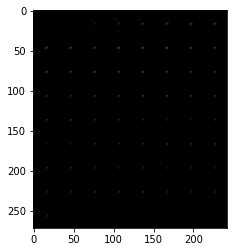

Epoch [106/400] Batch: [1/60] KL-Divergence: 2.112697620759718e-05 Cross-Entropy: 0.26099321246147156 Loss: 0.26101434230804443
Epoch [106/400] Batch: [2/60] KL-Divergence: 1.71421816048678e-05 Cross-Entropy: 0.2612156569957733 Loss: 0.26123279333114624
Epoch [106/400] Batch: [3/60] KL-Divergence: 1.998535117309075e-05 Cross-Entropy: 0.2645367681980133 Loss: 0.26455676555633545
Epoch [106/400] Batch: [4/60] KL-Divergence: 1.907470687001478e-05 Cross-Entropy: 0.25933149456977844 Loss: 0.25935056805610657
Epoch [106/400] Batch: [5/60] KL-Divergence: 1.765525848895777e-05 Cross-Entropy: 0.26945170760154724 Loss: 0.26946935057640076
Epoch [106/400] Batch: [6/60] KL-Divergence: 2.1980742531013675e-05 Cross-Entropy: 0.266857773065567 Loss: 0.26687976717948914
Epoch [106/400] Batch: [7/60] KL-Divergence: 1.6761016013333574e-05 Cross-Entropy: 0.2612278163433075 Loss: 0.2612445652484894
Epoch [106/400] Batch: [8/60] KL-Divergence: 1.9495468222885393e-05 Cross-Entropy: 0.25683465600013733 Loss: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [106/400] Batch: [60/60] KL-Divergence: 3.105259020230733e-05 Cross-Entropy: 0.2732580304145813 Loss: 0.2732890844345093
Epoch [106/400] Batch: [60/60] KL-Divergence: 3.105259020230733e-05 Cross-Entropy: 0.2732580304145813 Loss: 0.2732890844345093


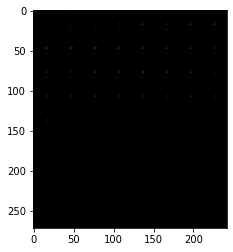

Epoch [107/400] Batch: [1/60] KL-Divergence: 2.3215217879624106e-05 Cross-Entropy: 0.2609497606754303 Loss: 0.2609729766845703
Epoch [107/400] Batch: [2/60] KL-Divergence: 1.7352751456201077e-05 Cross-Entropy: 0.2612003684043884 Loss: 0.26121771335601807
Epoch [107/400] Batch: [3/60] KL-Divergence: 1.7356223906972446e-05 Cross-Entropy: 0.2646104693412781 Loss: 0.2646278142929077
Epoch [107/400] Batch: [4/60] KL-Divergence: 1.5842093489482068e-05 Cross-Entropy: 0.2593483030796051 Loss: 0.25936415791511536
Epoch [107/400] Batch: [5/60] KL-Divergence: 1.4979171282902826e-05 Cross-Entropy: 0.26938289403915405 Loss: 0.26939788460731506
Epoch [107/400] Batch: [6/60] KL-Divergence: 1.7538299289299175e-05 Cross-Entropy: 0.2669290602207184 Loss: 0.26694658398628235
Epoch [107/400] Batch: [7/60] KL-Divergence: 1.581192009325605e-05 Cross-Entropy: 0.2611083984375 Loss: 0.26112422347068787
Epoch [107/400] Batch: [8/60] KL-Divergence: 2.1667938199243508e-05 Cross-Entropy: 0.25680410861968994 Loss: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [107/400] Batch: [60/60] KL-Divergence: 3.4482804039726034e-05 Cross-Entropy: 0.2733961045742035 Loss: 0.27343058586120605
Epoch [107/400] Batch: [60/60] KL-Divergence: 3.4482804039726034e-05 Cross-Entropy: 0.2733961045742035 Loss: 0.27343058586120605


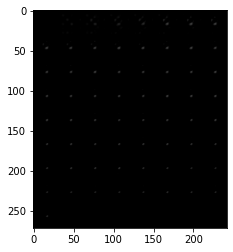

Epoch [108/400] Batch: [1/60] KL-Divergence: 2.86475751636317e-05 Cross-Entropy: 0.26099926233291626 Loss: 0.26102790236473083
Epoch [108/400] Batch: [2/60] KL-Divergence: 2.5703582650749013e-05 Cross-Entropy: 0.2612205445766449 Loss: 0.2612462341785431
Epoch [108/400] Batch: [3/60] KL-Divergence: 2.7598800443229266e-05 Cross-Entropy: 0.2644895911216736 Loss: 0.2645171880722046
Epoch [108/400] Batch: [4/60] KL-Divergence: 2.5451812689425424e-05 Cross-Entropy: 0.25941264629364014 Loss: 0.25943809747695923
Epoch [108/400] Batch: [5/60] KL-Divergence: 2.4242324798251502e-05 Cross-Entropy: 0.2694011330604553 Loss: 0.2694253623485565
Epoch [108/400] Batch: [6/60] KL-Divergence: 2.637931720528286e-05 Cross-Entropy: 0.266968309879303 Loss: 0.2669946849346161
Epoch [108/400] Batch: [7/60] KL-Divergence: 2.069854599540122e-05 Cross-Entropy: 0.26128238439559937 Loss: 0.2613030970096588
Epoch [108/400] Batch: [8/60] KL-Divergence: 2.285625487274956e-05 Cross-Entropy: 0.2567475140094757 Loss: 0.25

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [108/400] Batch: [60/60] KL-Divergence: 4.860358967562206e-05 Cross-Entropy: 0.2734017074108124 Loss: 0.2734503149986267
Epoch [108/400] Batch: [60/60] KL-Divergence: 4.860358967562206e-05 Cross-Entropy: 0.2734017074108124 Loss: 0.2734503149986267


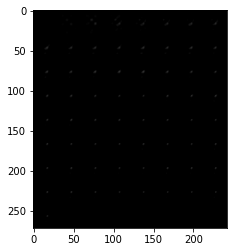

Epoch [109/400] Batch: [1/60] KL-Divergence: 3.756671867449768e-05 Cross-Entropy: 0.260872483253479 Loss: 0.2609100639820099
Epoch [109/400] Batch: [2/60] KL-Divergence: 3.0072134904912673e-05 Cross-Entropy: 0.26118203997612 Loss: 0.2612121105194092
Epoch [109/400] Batch: [3/60] KL-Divergence: 2.8546179237309843e-05 Cross-Entropy: 0.26462796330451965 Loss: 0.26465651392936707
Epoch [109/400] Batch: [4/60] KL-Divergence: 2.4689292331459e-05 Cross-Entropy: 0.2593424916267395 Loss: 0.2593671679496765
Epoch [109/400] Batch: [5/60] KL-Divergence: 2.3441885787178762e-05 Cross-Entropy: 0.2693602740764618 Loss: 0.2693837285041809
Epoch [109/400] Batch: [6/60] KL-Divergence: 3.241020021960139e-05 Cross-Entropy: 0.2669374942779541 Loss: 0.2669699192047119
Epoch [109/400] Batch: [7/60] KL-Divergence: 2.870952448574826e-05 Cross-Entropy: 0.2611493170261383 Loss: 0.26117801666259766
Epoch [109/400] Batch: [8/60] KL-Divergence: 2.7318190404912457e-05 Cross-Entropy: 0.25686895847320557 Loss: 0.256896

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [109/400] Batch: [60/60] KL-Divergence: 5.1955335948150605e-05 Cross-Entropy: 0.2732373774051666 Loss: 0.2732893228530884
Epoch [109/400] Batch: [60/60] KL-Divergence: 5.1955335948150605e-05 Cross-Entropy: 0.2732373774051666 Loss: 0.2732893228530884


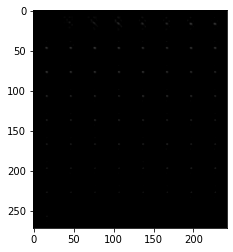

Epoch [110/400] Batch: [1/60] KL-Divergence: 4.4870033889310434e-05 Cross-Entropy: 0.26084989309310913 Loss: 0.260894775390625
Epoch [110/400] Batch: [2/60] KL-Divergence: 3.921600364265032e-05 Cross-Entropy: 0.26099348068237305 Loss: 0.26103270053863525
Epoch [110/400] Batch: [3/60] KL-Divergence: 4.1107061406364664e-05 Cross-Entropy: 0.26449742913246155 Loss: 0.2645385265350342
Epoch [110/400] Batch: [4/60] KL-Divergence: 3.760841354960576e-05 Cross-Entropy: 0.25935354828834534 Loss: 0.2593911588191986
Epoch [110/400] Batch: [5/60] KL-Divergence: 3.495792407193221e-05 Cross-Entropy: 0.26937928795814514 Loss: 0.2694142460823059
Epoch [110/400] Batch: [6/60] KL-Divergence: 3.9221951737999916e-05 Cross-Entropy: 0.2668067514896393 Loss: 0.2668459713459015
Epoch [110/400] Batch: [7/60] KL-Divergence: 3.332706546643749e-05 Cross-Entropy: 0.2611406147480011 Loss: 0.26117393374443054
Epoch [110/400] Batch: [8/60] KL-Divergence: 3.7790221540490165e-05 Cross-Entropy: 0.2569311261177063 Loss: 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [110/400] Batch: [60/60] KL-Divergence: 8.390926086576656e-05 Cross-Entropy: 0.2730940878391266 Loss: 0.27317801117897034
Epoch [110/400] Batch: [60/60] KL-Divergence: 8.390926086576656e-05 Cross-Entropy: 0.2730940878391266 Loss: 0.27317801117897034


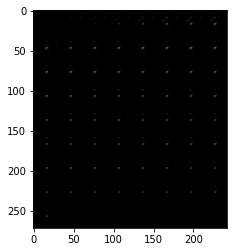

Epoch [111/400] Batch: [1/60] KL-Divergence: 8.212302782339975e-05 Cross-Entropy: 0.26092755794525146 Loss: 0.26100969314575195
Epoch [111/400] Batch: [2/60] KL-Divergence: 8.709022222319618e-05 Cross-Entropy: 0.2611351013183594 Loss: 0.2612221837043762
Epoch [111/400] Batch: [3/60] KL-Divergence: 0.00010073112207464874 Cross-Entropy: 0.2644219398498535 Loss: 0.2645226716995239
Epoch [111/400] Batch: [4/60] KL-Divergence: 9.068221697816625e-05 Cross-Entropy: 0.25919318199157715 Loss: 0.2592838704586029
Epoch [111/400] Batch: [5/60] KL-Divergence: 0.0001057768240571022 Cross-Entropy: 0.2693212628364563 Loss: 0.26942703127861023
Epoch [111/400] Batch: [6/60] KL-Divergence: 0.00011451121827121824 Cross-Entropy: 0.2668551504611969 Loss: 0.2669696509838104
Epoch [111/400] Batch: [7/60] KL-Divergence: 9.076663991436362e-05 Cross-Entropy: 0.26116910576820374 Loss: 0.26125988364219666
Epoch [111/400] Batch: [8/60] KL-Divergence: 7.263691077241674e-05 Cross-Entropy: 0.25688761472702026 Loss: 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [111/400] Batch: [60/60] KL-Divergence: 0.00010671725613065064 Cross-Entropy: 0.273040771484375 Loss: 0.27314749360084534
Epoch [111/400] Batch: [60/60] KL-Divergence: 0.00010671725613065064 Cross-Entropy: 0.273040771484375 Loss: 0.27314749360084534


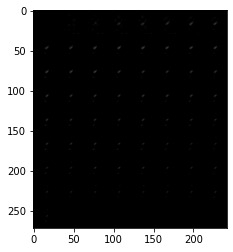

Epoch [112/400] Batch: [1/60] KL-Divergence: 9.477481944486499e-05 Cross-Entropy: 0.26099538803100586 Loss: 0.26109015941619873
Epoch [112/400] Batch: [2/60] KL-Divergence: 8.449561573797837e-05 Cross-Entropy: 0.2610856294631958 Loss: 0.2611701190471649
Epoch [112/400] Batch: [3/60] KL-Divergence: 8.304091898025945e-05 Cross-Entropy: 0.2644592225551605 Loss: 0.26454225182533264
Epoch [112/400] Batch: [4/60] KL-Divergence: 8.315715240314603e-05 Cross-Entropy: 0.2592831552028656 Loss: 0.25936630368232727
Epoch [112/400] Batch: [5/60] KL-Divergence: 8.186618651961908e-05 Cross-Entropy: 0.26953834295272827 Loss: 0.26962020993232727
Epoch [112/400] Batch: [6/60] KL-Divergence: 9.44032653933391e-05 Cross-Entropy: 0.2666792571544647 Loss: 0.26677367091178894
Epoch [112/400] Batch: [7/60] KL-Divergence: 8.292304846690968e-05 Cross-Entropy: 0.26118338108062744 Loss: 0.26126629114151
Epoch [112/400] Batch: [8/60] KL-Divergence: 8.371967123821378e-05 Cross-Entropy: 0.2567253112792969 Loss: 0.2568

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [112/400] Batch: [60/60] KL-Divergence: 0.00014712158008478582 Cross-Entropy: 0.2731054127216339 Loss: 0.27325254678726196
Epoch [112/400] Batch: [60/60] KL-Divergence: 0.00014712158008478582 Cross-Entropy: 0.2731054127216339 Loss: 0.27325254678726196


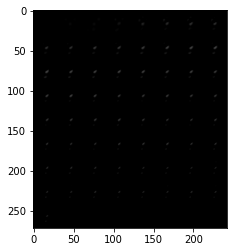

Epoch [113/400] Batch: [1/60] KL-Divergence: 0.0002006521972361952 Cross-Entropy: 0.26092272996902466 Loss: 0.261123389005661
Epoch [113/400] Batch: [2/60] KL-Divergence: 0.00025987514527514577 Cross-Entropy: 0.2612365186214447 Loss: 0.2614963948726654
Epoch [113/400] Batch: [3/60] KL-Divergence: 0.00022421279572881758 Cross-Entropy: 0.2643240988254547 Loss: 0.26454830169677734
Epoch [113/400] Batch: [4/60] KL-Divergence: 0.0001487450354034081 Cross-Entropy: 0.2592746913433075 Loss: 0.2594234347343445
Epoch [113/400] Batch: [5/60] KL-Divergence: 0.00013135134940966964 Cross-Entropy: 0.2695702314376831 Loss: 0.2697015702724457
Epoch [113/400] Batch: [6/60] KL-Divergence: 0.00015706667909398675 Cross-Entropy: 0.2667223811149597 Loss: 0.26687943935394287
Epoch [113/400] Batch: [7/60] KL-Divergence: 0.00015906631597317755 Cross-Entropy: 0.2610645592212677 Loss: 0.26122361421585083
Epoch [113/400] Batch: [8/60] KL-Divergence: 0.00014384955284185708 Cross-Entropy: 0.2567959725856781 Loss: 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [113/400] Batch: [60/60] KL-Divergence: 0.00019001304463017732 Cross-Entropy: 0.27303674817085266 Loss: 0.2732267677783966
Epoch [113/400] Batch: [60/60] KL-Divergence: 0.00019001304463017732 Cross-Entropy: 0.27303674817085266 Loss: 0.2732267677783966


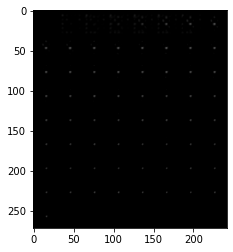

Epoch [114/400] Batch: [1/60] KL-Divergence: 0.00017746200319379568 Cross-Entropy: 0.2608548104763031 Loss: 0.2610322833061218
Epoch [114/400] Batch: [2/60] KL-Divergence: 0.00017273944104090333 Cross-Entropy: 0.2609281539916992 Loss: 0.2611008882522583
Epoch [114/400] Batch: [3/60] KL-Divergence: 0.0001846562954597175 Cross-Entropy: 0.26455169916152954 Loss: 0.2647363543510437
Epoch [114/400] Batch: [4/60] KL-Divergence: 0.00018139800522476435 Cross-Entropy: 0.25937363505363464 Loss: 0.25955504179000854
Epoch [114/400] Batch: [5/60] KL-Divergence: 0.00018295645713806152 Cross-Entropy: 0.26925167441368103 Loss: 0.2694346308708191
Epoch [114/400] Batch: [6/60] KL-Divergence: 0.00019420424359850585 Cross-Entropy: 0.26674559712409973 Loss: 0.26693978905677795
Epoch [114/400] Batch: [7/60] KL-Divergence: 0.00016407851944677532 Cross-Entropy: 0.26108023524284363 Loss: 0.2612443268299103
Epoch [114/400] Batch: [8/60] KL-Divergence: 0.00015195323794614524 Cross-Entropy: 0.25653788447380066 Lo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [114/400] Batch: [60/60] KL-Divergence: 0.00042620254680514336 Cross-Entropy: 0.2722650170326233 Loss: 0.2726912200450897
Epoch [114/400] Batch: [60/60] KL-Divergence: 0.00042620254680514336 Cross-Entropy: 0.2722650170326233 Loss: 0.2726912200450897


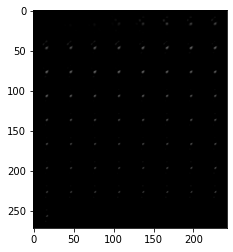

Epoch [115/400] Batch: [1/60] KL-Divergence: 0.00044869037810713053 Cross-Entropy: 0.2603952884674072 Loss: 0.26084399223327637
Epoch [115/400] Batch: [2/60] KL-Divergence: 0.00047495117178186774 Cross-Entropy: 0.2607252299785614 Loss: 0.2612001895904541
Epoch [115/400] Batch: [3/60] KL-Divergence: 0.0004485255340114236 Cross-Entropy: 0.2642976641654968 Loss: 0.26474618911743164
Epoch [115/400] Batch: [4/60] KL-Divergence: 0.00036577513674274087 Cross-Entropy: 0.2591591775417328 Loss: 0.259524941444397
Epoch [115/400] Batch: [5/60] KL-Divergence: 0.00037609596620313823 Cross-Entropy: 0.26905980706214905 Loss: 0.26943591237068176
Epoch [115/400] Batch: [6/60] KL-Divergence: 0.0004220011760480702 Cross-Entropy: 0.26644596457481384 Loss: 0.2668679654598236
Epoch [115/400] Batch: [7/60] KL-Divergence: 0.0004125137929804623 Cross-Entropy: 0.260896235704422 Loss: 0.2613087594509125
Epoch [115/400] Batch: [8/60] KL-Divergence: 0.0004006806411780417 Cross-Entropy: 0.25625085830688477 Loss: 0.2

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [115/400] Batch: [60/60] KL-Divergence: 0.0015894811367616057 Cross-Entropy: 0.27018818259239197 Loss: 0.2717776596546173
Epoch [115/400] Batch: [60/60] KL-Divergence: 0.0015894811367616057 Cross-Entropy: 0.27018818259239197 Loss: 0.2717776596546173


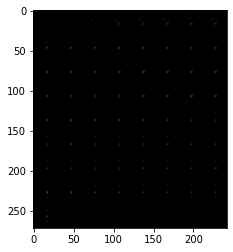

Epoch [116/400] Batch: [1/60] KL-Divergence: 0.001562213059514761 Cross-Entropy: 0.2587532103061676 Loss: 0.2603154182434082
Epoch [116/400] Batch: [2/60] KL-Divergence: 0.0016949474811553955 Cross-Entropy: 0.2591034173965454 Loss: 0.2607983648777008
Epoch [116/400] Batch: [3/60] KL-Divergence: 0.0020647819619625807 Cross-Entropy: 0.26223233342170715 Loss: 0.26429712772369385
Epoch [116/400] Batch: [4/60] KL-Divergence: 0.002430423628538847 Cross-Entropy: 0.25586381554603577 Loss: 0.2582942247390747
Epoch [116/400] Batch: [5/60] KL-Divergence: 0.002618570579215884 Cross-Entropy: 0.26579755544662476 Loss: 0.2684161365032196
Epoch [116/400] Batch: [6/60] KL-Divergence: 0.0029888590797781944 Cross-Entropy: 0.2633003890514374 Loss: 0.26628923416137695
Epoch [116/400] Batch: [7/60] KL-Divergence: 0.002144686644896865 Cross-Entropy: 0.25683221220970154 Loss: 0.25897690653800964
Epoch [116/400] Batch: [8/60] KL-Divergence: 0.002236098051071167 Cross-Entropy: 0.2533637583255768 Loss: 0.2555998

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [116/400] Batch: [60/60] KL-Divergence: 0.0070649911649525166 Cross-Entropy: 0.260366290807724 Loss: 0.2674312889575958
Epoch [116/400] Batch: [60/60] KL-Divergence: 0.0070649911649525166 Cross-Entropy: 0.260366290807724 Loss: 0.2674312889575958


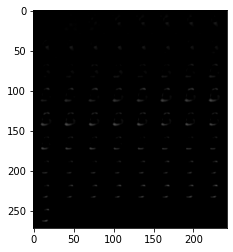

Epoch [117/400] Batch: [1/60] KL-Divergence: 0.00597899965941906 Cross-Entropy: 0.25071099400520325 Loss: 0.25668999552726746
Epoch [117/400] Batch: [2/60] KL-Divergence: 0.005764340050518513 Cross-Entropy: 0.25046926736831665 Loss: 0.2562336027622223
Epoch [117/400] Batch: [3/60] KL-Divergence: 0.005967909004539251 Cross-Entropy: 0.2526306211948395 Loss: 0.25859853625297546
Epoch [117/400] Batch: [4/60] KL-Divergence: 0.006391521543264389 Cross-Entropy: 0.24670299887657166 Loss: 0.25309452414512634
Epoch [117/400] Batch: [5/60] KL-Divergence: 0.007143068592995405 Cross-Entropy: 0.25577905774116516 Loss: 0.26292213797569275
Epoch [117/400] Batch: [6/60] KL-Divergence: 0.007087319158017635 Cross-Entropy: 0.2540742754936218 Loss: 0.26116159558296204
Epoch [117/400] Batch: [7/60] KL-Divergence: 0.005996944848448038 Cross-Entropy: 0.24786709249019623 Loss: 0.253864049911499
Epoch [117/400] Batch: [8/60] KL-Divergence: 0.005671399179846048 Cross-Entropy: 0.24650350213050842 Loss: 0.25217491

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [117/400] Batch: [60/60] KL-Divergence: 0.008226127363741398 Cross-Entropy: 0.2571398913860321 Loss: 0.2653660178184509
Epoch [117/400] Batch: [60/60] KL-Divergence: 0.008226127363741398 Cross-Entropy: 0.2571398913860321 Loss: 0.2653660178184509


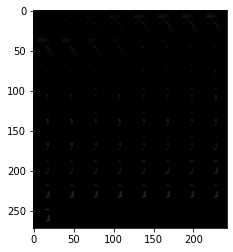

Epoch [118/400] Batch: [1/60] KL-Divergence: 0.007884485647082329 Cross-Entropy: 0.24885119497776031 Loss: 0.2567356824874878
Epoch [118/400] Batch: [2/60] KL-Divergence: 0.006682193838059902 Cross-Entropy: 0.24849718809127808 Loss: 0.25517937541007996
Epoch [118/400] Batch: [3/60] KL-Divergence: 0.006341005675494671 Cross-Entropy: 0.25145822763442993 Loss: 0.2577992379665375
Epoch [118/400] Batch: [4/60] KL-Divergence: 0.006099834572523832 Cross-Entropy: 0.24525055289268494 Loss: 0.25135037302970886
Epoch [118/400] Batch: [5/60] KL-Divergence: 0.007154935505241156 Cross-Entropy: 0.2554009258747101 Loss: 0.262555867433548
Epoch [118/400] Batch: [6/60] KL-Divergence: 0.007788356859236956 Cross-Entropy: 0.25250670313835144 Loss: 0.2602950632572174
Epoch [118/400] Batch: [7/60] KL-Divergence: 0.007926007732748985 Cross-Entropy: 0.24614845216274261 Loss: 0.25407445430755615
Epoch [118/400] Batch: [8/60] KL-Divergence: 0.006617073900997639 Cross-Entropy: 0.24294976890087128 Loss: 0.24956683

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [118/400] Batch: [60/60] KL-Divergence: 0.007819578982889652 Cross-Entropy: 0.25978392362594604 Loss: 0.2676035165786743
Epoch [118/400] Batch: [60/60] KL-Divergence: 0.007819578982889652 Cross-Entropy: 0.25978392362594604 Loss: 0.2676035165786743


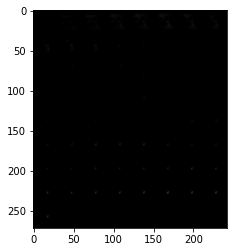

Epoch [119/400] Batch: [1/60] KL-Divergence: 0.007165614049881697 Cross-Entropy: 0.2481379508972168 Loss: 0.2553035616874695
Epoch [119/400] Batch: [2/60] KL-Divergence: 0.0076900664716959 Cross-Entropy: 0.24753937125205994 Loss: 0.2552294433116913
Epoch [119/400] Batch: [3/60] KL-Divergence: 0.00765618123114109 Cross-Entropy: 0.2508019804954529 Loss: 0.2584581673145294
Epoch [119/400] Batch: [4/60] KL-Divergence: 0.007476432248950005 Cross-Entropy: 0.24489209055900574 Loss: 0.2523685097694397
Epoch [119/400] Batch: [5/60] KL-Divergence: 0.007516747806221247 Cross-Entropy: 0.25405144691467285 Loss: 0.26156818866729736
Epoch [119/400] Batch: [6/60] KL-Divergence: 0.007716724649071693 Cross-Entropy: 0.2529301643371582 Loss: 0.26064687967300415
Epoch [119/400] Batch: [7/60] KL-Divergence: 0.007370840758085251 Cross-Entropy: 0.2458074688911438 Loss: 0.25317829847335815
Epoch [119/400] Batch: [8/60] KL-Divergence: 0.007584316190332174 Cross-Entropy: 0.24234561622142792 Loss: 0.2499299347400

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [119/400] Batch: [60/60] KL-Divergence: 0.008396717719733715 Cross-Entropy: 0.25722536444664 Loss: 0.265622079372406
Epoch [119/400] Batch: [60/60] KL-Divergence: 0.008396717719733715 Cross-Entropy: 0.25722536444664 Loss: 0.265622079372406


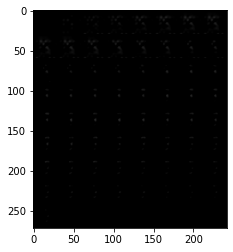

Epoch [120/400] Batch: [1/60] KL-Divergence: 0.007871068082749844 Cross-Entropy: 0.24675573408603668 Loss: 0.2546268105506897
Epoch [120/400] Batch: [2/60] KL-Divergence: 0.007471418473869562 Cross-Entropy: 0.2462923228740692 Loss: 0.25376373529434204
Epoch [120/400] Batch: [3/60] KL-Divergence: 0.00729282945394516 Cross-Entropy: 0.24990954995155334 Loss: 0.2572023868560791
Epoch [120/400] Batch: [4/60] KL-Divergence: 0.007465696893632412 Cross-Entropy: 0.24326342344284058 Loss: 0.25072911381721497
Epoch [120/400] Batch: [5/60] KL-Divergence: 0.00849068071693182 Cross-Entropy: 0.2531290650367737 Loss: 0.2616197466850281
Epoch [120/400] Batch: [6/60] KL-Divergence: 0.008067775517702103 Cross-Entropy: 0.2509390115737915 Loss: 0.2590067982673645
Epoch [120/400] Batch: [7/60] KL-Divergence: 0.008348892442882061 Cross-Entropy: 0.24381023645401 Loss: 0.25215911865234375
Epoch [120/400] Batch: [8/60] KL-Divergence: 0.007864014245569706 Cross-Entropy: 0.24132724106311798 Loss: 0.24919125437736

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [120/400] Batch: [60/60] KL-Divergence: 0.008413952775299549 Cross-Entropy: 0.2558814287185669 Loss: 0.264295369386673
Epoch [120/400] Batch: [60/60] KL-Divergence: 0.008413952775299549 Cross-Entropy: 0.2558814287185669 Loss: 0.264295369386673


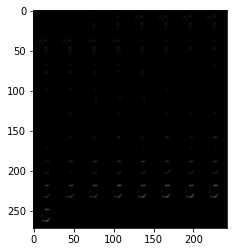

Epoch [121/400] Batch: [1/60] KL-Divergence: 0.00830580573529005 Cross-Entropy: 0.24572286009788513 Loss: 0.25402867794036865
Epoch [121/400] Batch: [2/60] KL-Divergence: 0.008491058833897114 Cross-Entropy: 0.24548979103565216 Loss: 0.2539808452129364
Epoch [121/400] Batch: [3/60] KL-Divergence: 0.008265040814876556 Cross-Entropy: 0.24853827059268951 Loss: 0.2568033039569855
Epoch [121/400] Batch: [4/60] KL-Divergence: 0.0072783054783940315 Cross-Entropy: 0.24243351817131042 Loss: 0.24971182644367218
Epoch [121/400] Batch: [5/60] KL-Divergence: 0.008356950245797634 Cross-Entropy: 0.2513587176799774 Loss: 0.2597156763076782
Epoch [121/400] Batch: [6/60] KL-Divergence: 0.00891710165888071 Cross-Entropy: 0.24996766448020935 Loss: 0.2588847577571869
Epoch [121/400] Batch: [7/60] KL-Divergence: 0.009011277928948402 Cross-Entropy: 0.24284718930721283 Loss: 0.2518584728240967
Epoch [121/400] Batch: [8/60] KL-Divergence: 0.00801772065460682 Cross-Entropy: 0.24067620933055878 Loss: 0.2486939281

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [121/400] Batch: [60/60] KL-Divergence: 0.008520349860191345 Cross-Entropy: 0.25757265090942383 Loss: 0.26609301567077637
Epoch [121/400] Batch: [60/60] KL-Divergence: 0.008520349860191345 Cross-Entropy: 0.25757265090942383 Loss: 0.26609301567077637


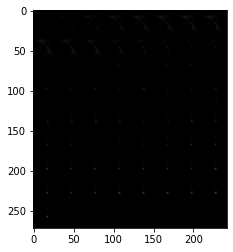

Epoch [122/400] Batch: [1/60] KL-Divergence: 0.00828795786947012 Cross-Entropy: 0.24536801874637604 Loss: 0.25365597009658813
Epoch [122/400] Batch: [2/60] KL-Divergence: 0.008719376288354397 Cross-Entropy: 0.24463918805122375 Loss: 0.2533585727214813
Epoch [122/400] Batch: [3/60] KL-Divergence: 0.009368681348860264 Cross-Entropy: 0.24649706482887268 Loss: 0.25586575269699097
Epoch [122/400] Batch: [4/60] KL-Divergence: 0.008708721026778221 Cross-Entropy: 0.2403542846441269 Loss: 0.24906300008296967
Epoch [122/400] Batch: [5/60] KL-Divergence: 0.009139024652540684 Cross-Entropy: 0.2510010600090027 Loss: 0.2601400911808014
Epoch [122/400] Batch: [6/60] KL-Divergence: 0.009029489010572433 Cross-Entropy: 0.2492293417453766 Loss: 0.2582588195800781
Epoch [122/400] Batch: [7/60] KL-Divergence: 0.009511671029031277 Cross-Entropy: 0.2413218766450882 Loss: 0.25083354115486145
Epoch [122/400] Batch: [8/60] KL-Divergence: 0.009334449656307697 Cross-Entropy: 0.2397889345884323 Loss: 0.24912337958

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [122/400] Batch: [60/60] KL-Divergence: 0.008720656856894493 Cross-Entropy: 0.2566603124141693 Loss: 0.26538097858428955
Epoch [122/400] Batch: [60/60] KL-Divergence: 0.008720656856894493 Cross-Entropy: 0.2566603124141693 Loss: 0.26538097858428955


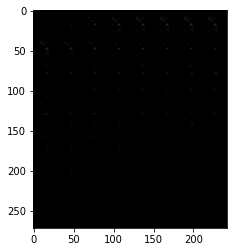

Epoch [123/400] Batch: [1/60] KL-Divergence: 0.00851464457809925 Cross-Entropy: 0.24645203351974487 Loss: 0.254966676235199
Epoch [123/400] Batch: [2/60] KL-Divergence: 0.007958326488733292 Cross-Entropy: 0.24539831280708313 Loss: 0.2533566355705261
Epoch [123/400] Batch: [3/60] KL-Divergence: 0.007764230016618967 Cross-Entropy: 0.24855194985866547 Loss: 0.2563161849975586
Epoch [123/400] Batch: [4/60] KL-Divergence: 0.007768495474010706 Cross-Entropy: 0.24231663346290588 Loss: 0.25008511543273926
Epoch [123/400] Batch: [5/60] KL-Divergence: 0.007841496728360653 Cross-Entropy: 0.2521291673183441 Loss: 0.25997066497802734
Epoch [123/400] Batch: [6/60] KL-Divergence: 0.007970858365297318 Cross-Entropy: 0.250062495470047 Loss: 0.2580333650112152
Epoch [123/400] Batch: [7/60] KL-Divergence: 0.008369687013328075 Cross-Entropy: 0.2435094565153122 Loss: 0.25187915563583374
Epoch [123/400] Batch: [8/60] KL-Divergence: 0.008303031325340271 Cross-Entropy: 0.24076172709465027 Loss: 0.249064758419

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [123/400] Batch: [60/60] KL-Divergence: 0.008607831783592701 Cross-Entropy: 0.2565096914768219 Loss: 0.2651175260543823
Epoch [123/400] Batch: [60/60] KL-Divergence: 0.008607831783592701 Cross-Entropy: 0.2565096914768219 Loss: 0.2651175260543823


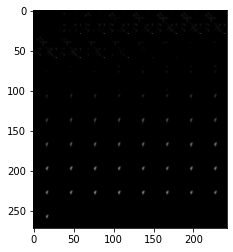

Epoch [124/400] Batch: [1/60] KL-Divergence: 0.008584283292293549 Cross-Entropy: 0.24461865425109863 Loss: 0.2532029449939728
Epoch [124/400] Batch: [2/60] KL-Divergence: 0.00906472746282816 Cross-Entropy: 0.24403244256973267 Loss: 0.25309717655181885
Epoch [124/400] Batch: [3/60] KL-Divergence: 0.009156616404652596 Cross-Entropy: 0.24615857005119324 Loss: 0.2553151845932007
Epoch [124/400] Batch: [4/60] KL-Divergence: 0.009461546316742897 Cross-Entropy: 0.24034442007541656 Loss: 0.2498059719800949
Epoch [124/400] Batch: [5/60] KL-Divergence: 0.009078183211386204 Cross-Entropy: 0.250647634267807 Loss: 0.25972580909729004
Epoch [124/400] Batch: [6/60] KL-Divergence: 0.009267752058804035 Cross-Entropy: 0.24855643510818481 Loss: 0.257824182510376
Epoch [124/400] Batch: [7/60] KL-Divergence: 0.009185394272208214 Cross-Entropy: 0.2412904053926468 Loss: 0.25047579407691956
Epoch [124/400] Batch: [8/60] KL-Divergence: 0.008955199271440506 Cross-Entropy: 0.2400023490190506 Loss: 0.248957544565

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [124/400] Batch: [60/60] KL-Divergence: 0.00916322972625494 Cross-Entropy: 0.2547607421875 Loss: 0.2639239728450775
Epoch [124/400] Batch: [60/60] KL-Divergence: 0.00916322972625494 Cross-Entropy: 0.2547607421875 Loss: 0.2639239728450775


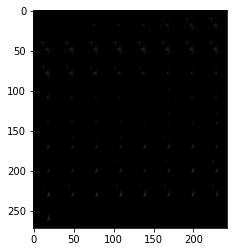

Epoch [125/400] Batch: [1/60] KL-Divergence: 0.009210179559886456 Cross-Entropy: 0.2434597760438919 Loss: 0.25266996026039124
Epoch [125/400] Batch: [2/60] KL-Divergence: 0.009216051548719406 Cross-Entropy: 0.24291768670082092 Loss: 0.25213372707366943
Epoch [125/400] Batch: [3/60] KL-Divergence: 0.009677490219473839 Cross-Entropy: 0.24582277238368988 Loss: 0.25550025701522827
Epoch [125/400] Batch: [4/60] KL-Divergence: 0.008985761553049088 Cross-Entropy: 0.24007129669189453 Loss: 0.24905705451965332
Epoch [125/400] Batch: [5/60] KL-Divergence: 0.009624814614653587 Cross-Entropy: 0.24911324679851532 Loss: 0.25873807072639465
Epoch [125/400] Batch: [6/60] KL-Divergence: 0.009941843338310719 Cross-Entropy: 0.24747700989246368 Loss: 0.25741884112358093
Epoch [125/400] Batch: [7/60] KL-Divergence: 0.009898588992655277 Cross-Entropy: 0.241164892911911 Loss: 0.2510634958744049
Epoch [125/400] Batch: [8/60] KL-Divergence: 0.009428474120795727 Cross-Entropy: 0.23847658932209015 Loss: 0.247905

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [125/400] Batch: [60/60] KL-Divergence: 0.009268148802220821 Cross-Entropy: 0.2563219368457794 Loss: 0.2655900716781616
Epoch [125/400] Batch: [60/60] KL-Divergence: 0.009268148802220821 Cross-Entropy: 0.2563219368457794 Loss: 0.2655900716781616


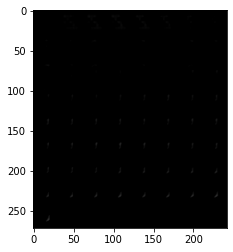

Epoch [126/400] Batch: [1/60] KL-Divergence: 0.00928143598139286 Cross-Entropy: 0.24515889585018158 Loss: 0.2544403374195099
Epoch [126/400] Batch: [2/60] KL-Divergence: 0.009583263657987118 Cross-Entropy: 0.24415765702724457 Loss: 0.25374090671539307
Epoch [126/400] Batch: [3/60] KL-Divergence: 0.00974244624376297 Cross-Entropy: 0.24654844403266907 Loss: 0.25629088282585144
Epoch [126/400] Batch: [4/60] KL-Divergence: 0.009623324498534203 Cross-Entropy: 0.24042002856731415 Loss: 0.2500433623790741
Epoch [126/400] Batch: [5/60] KL-Divergence: 0.009245439432561398 Cross-Entropy: 0.25073590874671936 Loss: 0.25998133420944214
Epoch [126/400] Batch: [6/60] KL-Divergence: 0.008857634849846363 Cross-Entropy: 0.2489541471004486 Loss: 0.2578117847442627
Epoch [126/400] Batch: [7/60] KL-Divergence: 0.008645054884254932 Cross-Entropy: 0.24156105518341064 Loss: 0.2502061128616333
Epoch [126/400] Batch: [8/60] KL-Divergence: 0.008350078016519547 Cross-Entropy: 0.23937466740608215 Loss: 0.247724741

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [126/400] Batch: [60/60] KL-Divergence: 0.00987604446709156 Cross-Entropy: 0.25526225566864014 Loss: 0.26513829827308655
Epoch [126/400] Batch: [60/60] KL-Divergence: 0.00987604446709156 Cross-Entropy: 0.25526225566864014 Loss: 0.26513829827308655


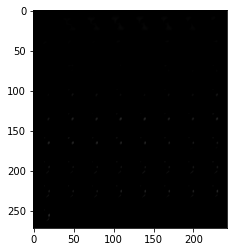

Epoch [127/400] Batch: [1/60] KL-Divergence: 0.00939204078167677 Cross-Entropy: 0.2432260364294052 Loss: 0.25261807441711426
Epoch [127/400] Batch: [2/60] KL-Divergence: 0.010000971145927906 Cross-Entropy: 0.2428983449935913 Loss: 0.25289931893348694
Epoch [127/400] Batch: [3/60] KL-Divergence: 0.009782752022147179 Cross-Entropy: 0.24455475807189941 Loss: 0.25433751940727234
Epoch [127/400] Batch: [4/60] KL-Divergence: 0.00949157401919365 Cross-Entropy: 0.239047110080719 Loss: 0.24853868782520294
Epoch [127/400] Batch: [5/60] KL-Divergence: 0.009315431118011475 Cross-Entropy: 0.24953177571296692 Loss: 0.2588472068309784
Epoch [127/400] Batch: [6/60] KL-Divergence: 0.010042267851531506 Cross-Entropy: 0.24755990505218506 Loss: 0.25760218501091003
Epoch [127/400] Batch: [7/60] KL-Divergence: 0.009788833558559418 Cross-Entropy: 0.23987144231796265 Loss: 0.24966028332710266
Epoch [127/400] Batch: [8/60] KL-Divergence: 0.009329810738563538 Cross-Entropy: 0.2389129400253296 Loss: 0.2482427507

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [127/400] Batch: [60/60] KL-Divergence: 0.009838016703724861 Cross-Entropy: 0.2542704641819 Loss: 0.26410847902297974
Epoch [127/400] Batch: [60/60] KL-Divergence: 0.009838016703724861 Cross-Entropy: 0.2542704641819 Loss: 0.26410847902297974


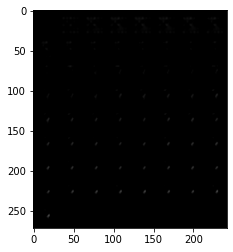

Epoch [128/400] Batch: [1/60] KL-Divergence: 0.009709686040878296 Cross-Entropy: 0.24285338819026947 Loss: 0.2525630593299866
Epoch [128/400] Batch: [2/60] KL-Divergence: 0.010317758657038212 Cross-Entropy: 0.24185392260551453 Loss: 0.25217169523239136
Epoch [128/400] Batch: [3/60] KL-Divergence: 0.010199435986578465 Cross-Entropy: 0.2440650761127472 Loss: 0.2542645037174225
Epoch [128/400] Batch: [4/60] KL-Divergence: 0.01037970557808876 Cross-Entropy: 0.2389695942401886 Loss: 0.24934929609298706
Epoch [128/400] Batch: [5/60] KL-Divergence: 0.009809362702071667 Cross-Entropy: 0.2488132268190384 Loss: 0.25862258672714233
Epoch [128/400] Batch: [6/60] KL-Divergence: 0.008930638432502747 Cross-Entropy: 0.2465822398662567 Loss: 0.25551289319992065
Epoch [128/400] Batch: [7/60] KL-Divergence: 0.009722004644572735 Cross-Entropy: 0.23998752236366272 Loss: 0.24970953166484833
Epoch [128/400] Batch: [8/60] KL-Divergence: 0.010077426210045815 Cross-Entropy: 0.2380487471818924 Loss: 0.2481261789

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [128/400] Batch: [60/60] KL-Divergence: 0.010028695687651634 Cross-Entropy: 0.2540152668952942 Loss: 0.2640439569950104
Epoch [128/400] Batch: [60/60] KL-Divergence: 0.010028695687651634 Cross-Entropy: 0.2540152668952942 Loss: 0.2640439569950104


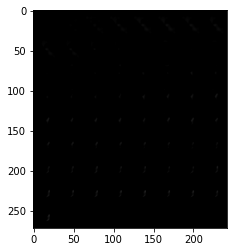

Epoch [129/400] Batch: [1/60] KL-Divergence: 0.009490016847848892 Cross-Entropy: 0.24316628277301788 Loss: 0.25265631079673767
Epoch [129/400] Batch: [2/60] KL-Divergence: 0.010116973891854286 Cross-Entropy: 0.24173085391521454 Loss: 0.2518478333950043
Epoch [129/400] Batch: [3/60] KL-Divergence: 0.010261197574436665 Cross-Entropy: 0.24369093775749207 Loss: 0.25395214557647705
Epoch [129/400] Batch: [4/60] KL-Divergence: 0.010214868932962418 Cross-Entropy: 0.23841556906700134 Loss: 0.24863043427467346
Epoch [129/400] Batch: [5/60] KL-Divergence: 0.010228566825389862 Cross-Entropy: 0.24681906402111053 Loss: 0.2570476233959198
Epoch [129/400] Batch: [6/60] KL-Divergence: 0.010343041270971298 Cross-Entropy: 0.24569319188594818 Loss: 0.2560362219810486
Epoch [129/400] Batch: [7/60] KL-Divergence: 0.010246635414659977 Cross-Entropy: 0.2384277582168579 Loss: 0.2486743927001953
Epoch [129/400] Batch: [8/60] KL-Divergence: 0.010265449061989784 Cross-Entropy: 0.23611825704574585 Loss: 0.2463837

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [129/400] Batch: [60/60] KL-Divergence: 0.010507985949516296 Cross-Entropy: 0.25241848826408386 Loss: 0.26292645931243896
Epoch [129/400] Batch: [60/60] KL-Divergence: 0.010507985949516296 Cross-Entropy: 0.25241848826408386 Loss: 0.26292645931243896


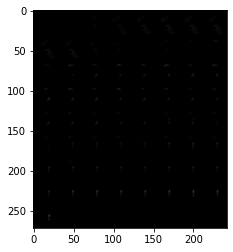

Epoch [130/400] Batch: [1/60] KL-Divergence: 0.009931121952831745 Cross-Entropy: 0.24166569113731384 Loss: 0.2515968084335327
Epoch [130/400] Batch: [2/60] KL-Divergence: 0.010499331168830395 Cross-Entropy: 0.24046802520751953 Loss: 0.2509673535823822
Epoch [130/400] Batch: [3/60] KL-Divergence: 0.010685642249882221 Cross-Entropy: 0.24274589121341705 Loss: 0.2534315288066864
Epoch [130/400] Batch: [4/60] KL-Divergence: 0.010195483453571796 Cross-Entropy: 0.23663368821144104 Loss: 0.24682916700839996
Epoch [130/400] Batch: [5/60] KL-Divergence: 0.010278420522809029 Cross-Entropy: 0.24669741094112396 Loss: 0.25697582960128784
Epoch [130/400] Batch: [6/60] KL-Divergence: 0.010713073424994946 Cross-Entropy: 0.24578513205051422 Loss: 0.25649821758270264
Epoch [130/400] Batch: [7/60] KL-Divergence: 0.01067197322845459 Cross-Entropy: 0.23750142753124237 Loss: 0.24817340075969696
Epoch [130/400] Batch: [8/60] KL-Divergence: 0.010587847791612148 Cross-Entropy: 0.23605112731456757 Loss: 0.246638

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [130/400] Batch: [60/60] KL-Divergence: 0.011594709008932114 Cross-Entropy: 0.25131410360336304 Loss: 0.26290881633758545
Epoch [130/400] Batch: [60/60] KL-Divergence: 0.011594709008932114 Cross-Entropy: 0.25131410360336304 Loss: 0.26290881633758545


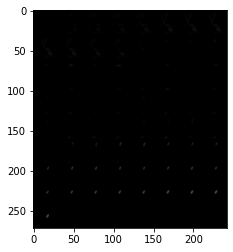

Epoch [131/400] Batch: [1/60] KL-Divergence: 0.009977173060178757 Cross-Entropy: 0.24117468297481537 Loss: 0.2511518597602844
Epoch [131/400] Batch: [2/60] KL-Divergence: 0.010253356769680977 Cross-Entropy: 0.24006608128547668 Loss: 0.2503194510936737
Epoch [131/400] Batch: [3/60] KL-Divergence: 0.011225767433643341 Cross-Entropy: 0.24218662083148956 Loss: 0.2534123957157135
Epoch [131/400] Batch: [4/60] KL-Divergence: 0.011559467762708664 Cross-Entropy: 0.2357480823993683 Loss: 0.24730755388736725
Epoch [131/400] Batch: [5/60] KL-Divergence: 0.011517844162881374 Cross-Entropy: 0.2450486272573471 Loss: 0.25656646490097046
Epoch [131/400] Batch: [6/60] KL-Divergence: 0.011277122423052788 Cross-Entropy: 0.2435459941625595 Loss: 0.25482311844825745
Epoch [131/400] Batch: [7/60] KL-Divergence: 0.011004440486431122 Cross-Entropy: 0.23759858310222626 Loss: 0.24860301613807678
Epoch [131/400] Batch: [8/60] KL-Divergence: 0.010702107101678848 Cross-Entropy: 0.23608459532260895 Loss: 0.24678669

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [131/400] Batch: [60/60] KL-Divergence: 0.010290136560797691 Cross-Entropy: 0.2504419684410095 Loss: 0.26073211431503296
Epoch [131/400] Batch: [60/60] KL-Divergence: 0.010290136560797691 Cross-Entropy: 0.2504419684410095 Loss: 0.26073211431503296


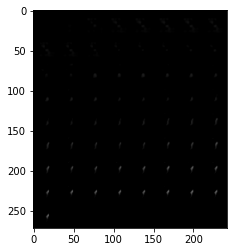

Epoch [132/400] Batch: [1/60] KL-Divergence: 0.01015534158796072 Cross-Entropy: 0.2413802295923233 Loss: 0.251535564661026
Epoch [132/400] Batch: [2/60] KL-Divergence: 0.010153407230973244 Cross-Entropy: 0.23943667113780975 Loss: 0.24959008395671844
Epoch [132/400] Batch: [3/60] KL-Divergence: 0.01058298908174038 Cross-Entropy: 0.24075916409492493 Loss: 0.25134214758872986
Epoch [132/400] Batch: [4/60] KL-Divergence: 0.011241602711379528 Cross-Entropy: 0.23519212007522583 Loss: 0.24643371999263763
Epoch [132/400] Batch: [5/60] KL-Divergence: 0.011104799807071686 Cross-Entropy: 0.24412484467029572 Loss: 0.255229651927948
Epoch [132/400] Batch: [6/60] KL-Divergence: 0.011098229326307774 Cross-Entropy: 0.2433767020702362 Loss: 0.254474937915802
Epoch [132/400] Batch: [7/60] KL-Divergence: 0.011485323309898376 Cross-Entropy: 0.23780806362628937 Loss: 0.24929338693618774
Epoch [132/400] Batch: [8/60] KL-Divergence: 0.010365378111600876 Cross-Entropy: 0.23513130843639374 Loss: 0.245496690273

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [132/400] Batch: [60/60] KL-Divergence: 0.0116275604814291 Cross-Entropy: 0.24830110371112823 Loss: 0.2599286735057831
Epoch [132/400] Batch: [60/60] KL-Divergence: 0.0116275604814291 Cross-Entropy: 0.24830110371112823 Loss: 0.2599286735057831


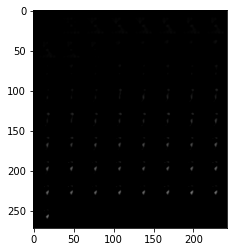

Epoch [133/400] Batch: [1/60] KL-Divergence: 0.010994523763656616 Cross-Entropy: 0.23974329233169556 Loss: 0.2507378160953522
Epoch [133/400] Batch: [2/60] KL-Divergence: 0.01072143204510212 Cross-Entropy: 0.23951123654842377 Loss: 0.25023266673088074
Epoch [133/400] Batch: [3/60] KL-Divergence: 0.010785466060042381 Cross-Entropy: 0.24069488048553467 Loss: 0.2514803409576416
Epoch [133/400] Batch: [4/60] KL-Divergence: 0.010743626393377781 Cross-Entropy: 0.23547857999801636 Loss: 0.24622221291065216
Epoch [133/400] Batch: [5/60] KL-Divergence: 0.010595100000500679 Cross-Entropy: 0.24474765360355377 Loss: 0.2553427517414093
Epoch [133/400] Batch: [6/60] KL-Divergence: 0.010578732937574387 Cross-Entropy: 0.24306908249855042 Loss: 0.2536478042602539
Epoch [133/400] Batch: [7/60] KL-Divergence: 0.01080157421529293 Cross-Entropy: 0.2375214695930481 Loss: 0.24832303822040558
Epoch [133/400] Batch: [8/60] KL-Divergence: 0.009822110645473003 Cross-Entropy: 0.23466989398002625 Loss: 0.244492009

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [133/400] Batch: [60/60] KL-Divergence: 0.011121442541480064 Cross-Entropy: 0.24839890003204346 Loss: 0.25952035188674927
Epoch [133/400] Batch: [60/60] KL-Divergence: 0.011121442541480064 Cross-Entropy: 0.24839890003204346 Loss: 0.25952035188674927


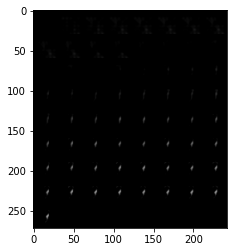

Epoch [134/400] Batch: [1/60] KL-Divergence: 0.011365373618900776 Cross-Entropy: 0.23973390460014343 Loss: 0.25109928846359253
Epoch [134/400] Batch: [2/60] KL-Divergence: 0.011577916331589222 Cross-Entropy: 0.23914740979671478 Loss: 0.25072532892227173
Epoch [134/400] Batch: [3/60] KL-Divergence: 0.011875094845890999 Cross-Entropy: 0.2391643524169922 Loss: 0.25103944540023804
Epoch [134/400] Batch: [4/60] KL-Divergence: 0.011924782767891884 Cross-Entropy: 0.23294755816459656 Loss: 0.2448723465204239
Epoch [134/400] Batch: [5/60] KL-Divergence: 0.01178212370723486 Cross-Entropy: 0.24374504387378693 Loss: 0.25552716851234436
Epoch [134/400] Batch: [6/60] KL-Divergence: 0.01168601680546999 Cross-Entropy: 0.24174915254116058 Loss: 0.2534351646900177
Epoch [134/400] Batch: [7/60] KL-Divergence: 0.011967712081968784 Cross-Entropy: 0.23693372309207916 Loss: 0.24890144169330597
Epoch [134/400] Batch: [8/60] KL-Divergence: 0.011493024416267872 Cross-Entropy: 0.23409207165241241 Loss: 0.2455850

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [134/400] Batch: [60/60] KL-Divergence: 0.011960563249886036 Cross-Entropy: 0.2473958432674408 Loss: 0.25935640931129456
Epoch [134/400] Batch: [60/60] KL-Divergence: 0.011960563249886036 Cross-Entropy: 0.2473958432674408 Loss: 0.25935640931129456


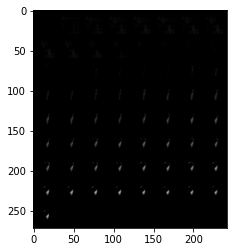

Epoch [135/400] Batch: [1/60] KL-Divergence: 0.010690472088754177 Cross-Entropy: 0.23918980360031128 Loss: 0.24988026916980743
Epoch [135/400] Batch: [2/60] KL-Divergence: 0.011448776349425316 Cross-Entropy: 0.23853598535060883 Loss: 0.2499847561120987
Epoch [135/400] Batch: [3/60] KL-Divergence: 0.012473979033529758 Cross-Entropy: 0.23888228833675385 Loss: 0.2513562738895416
Epoch [135/400] Batch: [4/60] KL-Divergence: 0.012876072898507118 Cross-Entropy: 0.23322845995426178 Loss: 0.24610453844070435
Epoch [135/400] Batch: [5/60] KL-Divergence: 0.012424775399267673 Cross-Entropy: 0.24277468025684357 Loss: 0.25519946217536926
Epoch [135/400] Batch: [6/60] KL-Divergence: 0.01241612434387207 Cross-Entropy: 0.24135389924049377 Loss: 0.25377002358436584
Epoch [135/400] Batch: [7/60] KL-Divergence: 0.011920236051082611 Cross-Entropy: 0.23569418489933014 Loss: 0.24761441349983215
Epoch [135/400] Batch: [8/60] KL-Divergence: 0.011801672168076038 Cross-Entropy: 0.23364876210689545 Loss: 0.24545

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [135/400] Batch: [60/60] KL-Divergence: 0.01276760920882225 Cross-Entropy: 0.24633102118968964 Loss: 0.259098619222641
Epoch [135/400] Batch: [60/60] KL-Divergence: 0.01276760920882225 Cross-Entropy: 0.24633102118968964 Loss: 0.259098619222641


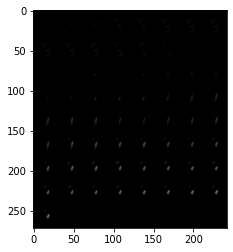

Epoch [136/400] Batch: [1/60] KL-Divergence: 0.012059823609888554 Cross-Entropy: 0.23815034329891205 Loss: 0.250210165977478
Epoch [136/400] Batch: [2/60] KL-Divergence: 0.012106644921004772 Cross-Entropy: 0.23691533505916595 Loss: 0.249021977186203
Epoch [136/400] Batch: [3/60] KL-Divergence: 0.012996227480471134 Cross-Entropy: 0.23782794177532196 Loss: 0.2508241832256317
Epoch [136/400] Batch: [4/60] KL-Divergence: 0.012400737032294273 Cross-Entropy: 0.23232723772525787 Loss: 0.2447279691696167
Epoch [136/400] Batch: [5/60] KL-Divergence: 0.013547954149544239 Cross-Entropy: 0.24229581654071808 Loss: 0.25584375858306885
Epoch [136/400] Batch: [6/60] KL-Divergence: 0.012671309523284435 Cross-Entropy: 0.23897647857666016 Loss: 0.25164780020713806
Epoch [136/400] Batch: [7/60] KL-Divergence: 0.012742615304887295 Cross-Entropy: 0.23429614305496216 Loss: 0.24703875184059143
Epoch [136/400] Batch: [8/60] KL-Divergence: 0.01170535571873188 Cross-Entropy: 0.2330021858215332 Loss: 0.2447075396

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [136/400] Batch: [60/60] KL-Divergence: 0.013676476664841175 Cross-Entropy: 0.2463056892156601 Loss: 0.259982168674469
Epoch [136/400] Batch: [60/60] KL-Divergence: 0.013676476664841175 Cross-Entropy: 0.2463056892156601 Loss: 0.259982168674469


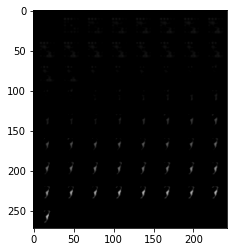

Epoch [137/400] Batch: [1/60] KL-Divergence: 0.012459855526685715 Cross-Entropy: 0.23710627853870392 Loss: 0.24956613779067993
Epoch [137/400] Batch: [2/60] KL-Divergence: 0.012650711461901665 Cross-Entropy: 0.23718149960041046 Loss: 0.24983221292495728
Epoch [137/400] Batch: [3/60] KL-Divergence: 0.012787382118403912 Cross-Entropy: 0.2374906837940216 Loss: 0.2502780556678772
Epoch [137/400] Batch: [4/60] KL-Divergence: 0.011961105279624462 Cross-Entropy: 0.23269957304000854 Loss: 0.24466067552566528
Epoch [137/400] Batch: [5/60] KL-Divergence: 0.012089538387954235 Cross-Entropy: 0.24295902252197266 Loss: 0.25504857301712036
Epoch [137/400] Batch: [6/60] KL-Divergence: 0.011666107922792435 Cross-Entropy: 0.24062123894691467 Loss: 0.252287358045578
Epoch [137/400] Batch: [7/60] KL-Divergence: 0.010937865823507309 Cross-Entropy: 0.23652398586273193 Loss: 0.24746185541152954
Epoch [137/400] Batch: [8/60] KL-Divergence: 0.010910531505942345 Cross-Entropy: 0.23423244059085846 Loss: 0.245142

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [137/400] Batch: [60/60] KL-Divergence: 0.01306167896836996 Cross-Entropy: 0.24481655657291412 Loss: 0.25787824392318726
Epoch [137/400] Batch: [60/60] KL-Divergence: 0.01306167896836996 Cross-Entropy: 0.24481655657291412 Loss: 0.25787824392318726


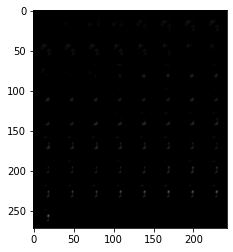

Epoch [138/400] Batch: [1/60] KL-Divergence: 0.01299634575843811 Cross-Entropy: 0.23633481562137604 Loss: 0.24933116137981415
Epoch [138/400] Batch: [2/60] KL-Divergence: 0.013183638453483582 Cross-Entropy: 0.2365606725215912 Loss: 0.24974431097507477
Epoch [138/400] Batch: [3/60] KL-Divergence: 0.01233500987291336 Cross-Entropy: 0.2367822825908661 Loss: 0.24911728501319885
Epoch [138/400] Batch: [4/60] KL-Divergence: 0.011949530802667141 Cross-Entropy: 0.2321755588054657 Loss: 0.24412508308887482
Epoch [138/400] Batch: [5/60] KL-Divergence: 0.012012230232357979 Cross-Entropy: 0.24109038710594177 Loss: 0.2531026303768158
Epoch [138/400] Batch: [6/60] KL-Divergence: 0.012180909514427185 Cross-Entropy: 0.2385423183441162 Loss: 0.2507232427597046
Epoch [138/400] Batch: [7/60] KL-Divergence: 0.012528598308563232 Cross-Entropy: 0.23484106361865997 Loss: 0.2473696619272232
Epoch [138/400] Batch: [8/60] KL-Divergence: 0.011635661125183105 Cross-Entropy: 0.23279929161071777 Loss: 0.24443495273

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [138/400] Batch: [60/60] KL-Divergence: 0.012532936409115791 Cross-Entropy: 0.24756823480129242 Loss: 0.26010116934776306
Epoch [138/400] Batch: [60/60] KL-Divergence: 0.012532936409115791 Cross-Entropy: 0.24756823480129242 Loss: 0.26010116934776306


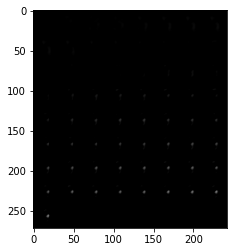

Epoch [139/400] Batch: [1/60] KL-Divergence: 0.011414489708840847 Cross-Entropy: 0.23919594287872314 Loss: 0.25061044096946716
Epoch [139/400] Batch: [2/60] KL-Divergence: 0.011534296907484531 Cross-Entropy: 0.23826609551906586 Loss: 0.2498003989458084
Epoch [139/400] Batch: [3/60] KL-Divergence: 0.012493195943534374 Cross-Entropy: 0.24027487635612488 Loss: 0.25276806950569153
Epoch [139/400] Batch: [4/60] KL-Divergence: 0.012304355390369892 Cross-Entropy: 0.23424562811851501 Loss: 0.24654997885227203
Epoch [139/400] Batch: [5/60] KL-Divergence: 0.013036111369729042 Cross-Entropy: 0.24458296597003937 Loss: 0.25761908292770386
Epoch [139/400] Batch: [6/60] KL-Divergence: 0.012881768867373466 Cross-Entropy: 0.2414887547492981 Loss: 0.2543705105781555
Epoch [139/400] Batch: [7/60] KL-Divergence: 0.012510322034358978 Cross-Entropy: 0.2368287593126297 Loss: 0.24933907389640808
Epoch [139/400] Batch: [8/60] KL-Divergence: 0.011864692904055119 Cross-Entropy: 0.23409222066402435 Loss: 0.245956

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [139/400] Batch: [60/60] KL-Divergence: 0.01298466231673956 Cross-Entropy: 0.24568036198616028 Loss: 0.2586650252342224
Epoch [139/400] Batch: [60/60] KL-Divergence: 0.01298466231673956 Cross-Entropy: 0.24568036198616028 Loss: 0.2586650252342224


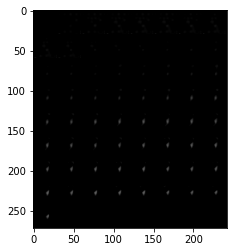

Epoch [140/400] Batch: [1/60] KL-Divergence: 0.01293479185551405 Cross-Entropy: 0.2369443029165268 Loss: 0.24987909197807312
Epoch [140/400] Batch: [2/60] KL-Divergence: 0.012828296981751919 Cross-Entropy: 0.23639382421970367 Loss: 0.24922211468219757
Epoch [140/400] Batch: [3/60] KL-Divergence: 0.012678117491304874 Cross-Entropy: 0.23842613399028778 Loss: 0.2511042654514313
Epoch [140/400] Batch: [4/60] KL-Divergence: 0.012576612643897533 Cross-Entropy: 0.23334306478500366 Loss: 0.24591967463493347
Epoch [140/400] Batch: [5/60] KL-Divergence: 0.012893935665488243 Cross-Entropy: 0.24332429468631744 Loss: 0.25621822476387024
Epoch [140/400] Batch: [6/60] KL-Divergence: 0.012239659205079079 Cross-Entropy: 0.23978443443775177 Loss: 0.2520240843296051
Epoch [140/400] Batch: [7/60] KL-Divergence: 0.012565575540065765 Cross-Entropy: 0.2344648391008377 Loss: 0.24703040719032288
Epoch [140/400] Batch: [8/60] KL-Divergence: 0.012352175079286098 Cross-Entropy: 0.23302216827869415 Loss: 0.2453743

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [140/400] Batch: [60/60] KL-Divergence: 0.012889512814581394 Cross-Entropy: 0.24467256665229797 Loss: 0.2575620710849762
Epoch [140/400] Batch: [60/60] KL-Divergence: 0.012889512814581394 Cross-Entropy: 0.24467256665229797 Loss: 0.2575620710849762


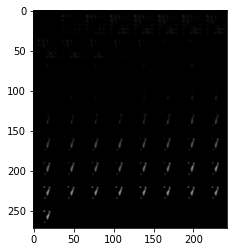

Epoch [141/400] Batch: [1/60] KL-Divergence: 0.012320797890424728 Cross-Entropy: 0.23571465909481049 Loss: 0.2480354607105255
Epoch [141/400] Batch: [2/60] KL-Divergence: 0.012543774209916592 Cross-Entropy: 0.23587583005428314 Loss: 0.2484195977449417
Epoch [141/400] Batch: [3/60] KL-Divergence: 0.013141212984919548 Cross-Entropy: 0.23691391944885254 Loss: 0.25005513429641724
Epoch [141/400] Batch: [4/60] KL-Divergence: 0.012919501401484013 Cross-Entropy: 0.23214615881443024 Loss: 0.24506565928459167
Epoch [141/400] Batch: [5/60] KL-Divergence: 0.013858163729310036 Cross-Entropy: 0.24178250133991241 Loss: 0.2556406557559967
Epoch [141/400] Batch: [6/60] KL-Divergence: 0.013657983392477036 Cross-Entropy: 0.23777438700199127 Loss: 0.2514323592185974
Epoch [141/400] Batch: [7/60] KL-Divergence: 0.014045488089323044 Cross-Entropy: 0.23362085223197937 Loss: 0.2476663440465927
Epoch [141/400] Batch: [8/60] KL-Divergence: 0.012741238810122013 Cross-Entropy: 0.23090465366840363 Loss: 0.2436458

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [141/400] Batch: [60/60] KL-Divergence: 0.012558200396597385 Cross-Entropy: 0.24734310805797577 Loss: 0.2599013149738312
Epoch [141/400] Batch: [60/60] KL-Divergence: 0.012558200396597385 Cross-Entropy: 0.24734310805797577 Loss: 0.2599013149738312


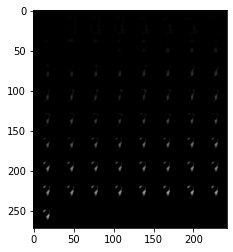

Epoch [142/400] Batch: [1/60] KL-Divergence: 0.012363805435597897 Cross-Entropy: 0.23812459409236908 Loss: 0.25048840045928955
Epoch [142/400] Batch: [2/60] KL-Divergence: 0.012900987640023232 Cross-Entropy: 0.23807461559772491 Loss: 0.2509756088256836
Epoch [142/400] Batch: [3/60] KL-Divergence: 0.013252746313810349 Cross-Entropy: 0.23808686435222626 Loss: 0.2513396143913269
Epoch [142/400] Batch: [4/60] KL-Divergence: 0.012914652936160564 Cross-Entropy: 0.2334369271993637 Loss: 0.24635158479213715
Epoch [142/400] Batch: [5/60] KL-Divergence: 0.012778420001268387 Cross-Entropy: 0.24320454895496368 Loss: 0.2559829652309418
Epoch [142/400] Batch: [6/60] KL-Divergence: 0.011782211251556873 Cross-Entropy: 0.2405356466770172 Loss: 0.2523178458213806
Epoch [142/400] Batch: [7/60] KL-Divergence: 0.011568228714168072 Cross-Entropy: 0.2378571778535843 Loss: 0.24942541122436523
Epoch [142/400] Batch: [8/60] KL-Divergence: 0.01088183093816042 Cross-Entropy: 0.23375125229358673 Loss: 0.2446330785

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [142/400] Batch: [60/60] KL-Divergence: 0.013911904767155647 Cross-Entropy: 0.24460792541503906 Loss: 0.25851982831954956
Epoch [142/400] Batch: [60/60] KL-Divergence: 0.013911904767155647 Cross-Entropy: 0.24460792541503906 Loss: 0.25851982831954956


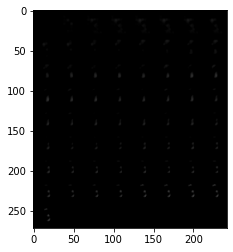

Epoch [143/400] Batch: [1/60] KL-Divergence: 0.012864598073065281 Cross-Entropy: 0.23506951332092285 Loss: 0.24793411791324615
Epoch [143/400] Batch: [2/60] KL-Divergence: 0.012325084768235683 Cross-Entropy: 0.2351643294095993 Loss: 0.24748940765857697
Epoch [143/400] Batch: [3/60] KL-Divergence: 0.012693207710981369 Cross-Entropy: 0.2360825389623642 Loss: 0.24877575039863586
Epoch [143/400] Batch: [4/60] KL-Divergence: 0.012762902304530144 Cross-Entropy: 0.2317247837781906 Loss: 0.2444876879453659
Epoch [143/400] Batch: [5/60] KL-Divergence: 0.01366930827498436 Cross-Entropy: 0.24216420948505402 Loss: 0.2558335065841675
Epoch [143/400] Batch: [6/60] KL-Divergence: 0.01345105841755867 Cross-Entropy: 0.2377515584230423 Loss: 0.25120261311531067
Epoch [143/400] Batch: [7/60] KL-Divergence: 0.012568981386721134 Cross-Entropy: 0.23445121943950653 Loss: 0.2470201998949051
Epoch [143/400] Batch: [8/60] KL-Divergence: 0.012982857413589954 Cross-Entropy: 0.23099249601364136 Loss: 0.24397535622

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [143/400] Batch: [60/60] KL-Divergence: 0.01445076521486044 Cross-Entropy: 0.24232546985149384 Loss: 0.25677624344825745
Epoch [143/400] Batch: [60/60] KL-Divergence: 0.01445076521486044 Cross-Entropy: 0.24232546985149384 Loss: 0.25677624344825745


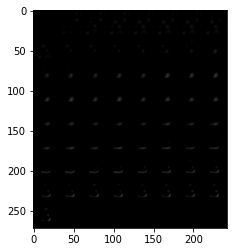

Epoch [144/400] Batch: [1/60] KL-Divergence: 0.014327619224786758 Cross-Entropy: 0.2331700176000595 Loss: 0.24749763309955597
Epoch [144/400] Batch: [2/60] KL-Divergence: 0.013001427054405212 Cross-Entropy: 0.23487044870853424 Loss: 0.24787187576293945
Epoch [144/400] Batch: [3/60] KL-Divergence: 0.013581125065684319 Cross-Entropy: 0.23593653738498688 Loss: 0.24951766431331635
Epoch [144/400] Batch: [4/60] KL-Divergence: 0.014059191569685936 Cross-Entropy: 0.23186564445495605 Loss: 0.24592483043670654
Epoch [144/400] Batch: [5/60] KL-Divergence: 0.013742257840931416 Cross-Entropy: 0.24000100791454315 Loss: 0.2537432610988617
Epoch [144/400] Batch: [6/60] KL-Divergence: 0.01407660637050867 Cross-Entropy: 0.23585258424282074 Loss: 0.24992918968200684
Epoch [144/400] Batch: [7/60] KL-Divergence: 0.013983357697725296 Cross-Entropy: 0.23177693784236908 Loss: 0.24576029181480408
Epoch [144/400] Batch: [8/60] KL-Divergence: 0.014141825959086418 Cross-Entropy: 0.22982214391231537 Loss: 0.24396

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [144/400] Batch: [60/60] KL-Divergence: 0.015249472111463547 Cross-Entropy: 0.24180440604686737 Loss: 0.2570538818836212
Epoch [144/400] Batch: [60/60] KL-Divergence: 0.015249472111463547 Cross-Entropy: 0.24180440604686737 Loss: 0.2570538818836212


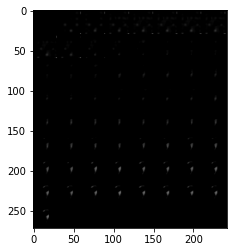

Epoch [145/400] Batch: [1/60] KL-Divergence: 0.014657647348940372 Cross-Entropy: 0.23192426562309265 Loss: 0.24658191204071045
Epoch [145/400] Batch: [2/60] KL-Divergence: 0.014145681634545326 Cross-Entropy: 0.23318690061569214 Loss: 0.2473325878381729
Epoch [145/400] Batch: [3/60] KL-Divergence: 0.015198178589344025 Cross-Entropy: 0.23321621119976044 Loss: 0.24841439723968506
Epoch [145/400] Batch: [4/60] KL-Divergence: 0.015119262039661407 Cross-Entropy: 0.2300054281949997 Loss: 0.2451246976852417
Epoch [145/400] Batch: [5/60] KL-Divergence: 0.015897700563073158 Cross-Entropy: 0.23847763240337372 Loss: 0.2543753385543823
Epoch [145/400] Batch: [6/60] KL-Divergence: 0.015467572957277298 Cross-Entropy: 0.23502156138420105 Loss: 0.25048914551734924
Epoch [145/400] Batch: [7/60] KL-Divergence: 0.014888500794768333 Cross-Entropy: 0.23163123428821564 Loss: 0.24651972949504852
Epoch [145/400] Batch: [8/60] KL-Divergence: 0.014514117501676083 Cross-Entropy: 0.22860193252563477 Loss: 0.243116

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [145/400] Batch: [60/60] KL-Divergence: 0.01543146651238203 Cross-Entropy: 0.24019843339920044 Loss: 0.25562989711761475
Epoch [145/400] Batch: [60/60] KL-Divergence: 0.01543146651238203 Cross-Entropy: 0.24019843339920044 Loss: 0.25562989711761475


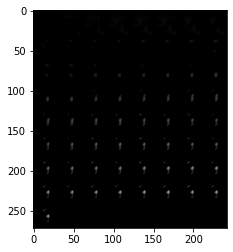

Epoch [146/400] Batch: [1/60] KL-Divergence: 0.014957142062485218 Cross-Entropy: 0.23065102100372314 Loss: 0.2456081658601761
Epoch [146/400] Batch: [2/60] KL-Divergence: 0.015086276456713676 Cross-Entropy: 0.2317436933517456 Loss: 0.24682997167110443
Epoch [146/400] Batch: [3/60] KL-Divergence: 0.015592562034726143 Cross-Entropy: 0.23271985352039337 Loss: 0.24831241369247437
Epoch [146/400] Batch: [4/60] KL-Divergence: 0.01564142294228077 Cross-Entropy: 0.22871826589107513 Loss: 0.24435968697071075
Epoch [146/400] Batch: [5/60] KL-Divergence: 0.015624895691871643 Cross-Entropy: 0.23780964314937592 Loss: 0.25343453884124756
Epoch [146/400] Batch: [6/60] KL-Divergence: 0.015459141694009304 Cross-Entropy: 0.23312291502952576 Loss: 0.24858205020427704
Epoch [146/400] Batch: [7/60] KL-Divergence: 0.014246930368244648 Cross-Entropy: 0.23023217916488647 Loss: 0.24447910487651825
Epoch [146/400] Batch: [8/60] KL-Divergence: 0.014310612343251705 Cross-Entropy: 0.22797268629074097 Loss: 0.24228

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [146/400] Batch: [60/60] KL-Divergence: 0.015549745410680771 Cross-Entropy: 0.24010461568832397 Loss: 0.25565436482429504
Epoch [146/400] Batch: [60/60] KL-Divergence: 0.015549745410680771 Cross-Entropy: 0.24010461568832397 Loss: 0.25565436482429504


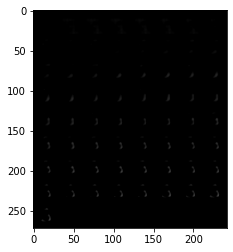

Epoch [147/400] Batch: [1/60] KL-Divergence: 0.015891438350081444 Cross-Entropy: 0.22991079092025757 Loss: 0.24580222368240356
Epoch [147/400] Batch: [2/60] KL-Divergence: 0.015459218062460423 Cross-Entropy: 0.23147733509540558 Loss: 0.24693655967712402
Epoch [147/400] Batch: [3/60] KL-Divergence: 0.016982989385724068 Cross-Entropy: 0.23234772682189941 Loss: 0.24933071434497833
Epoch [147/400] Batch: [4/60] KL-Divergence: 0.01595592312514782 Cross-Entropy: 0.22826984524726868 Loss: 0.24422577023506165
Epoch [147/400] Batch: [5/60] KL-Divergence: 0.016662582755088806 Cross-Entropy: 0.23676474392414093 Loss: 0.25342732667922974
Epoch [147/400] Batch: [6/60] KL-Divergence: 0.016751807183027267 Cross-Entropy: 0.23311442136764526 Loss: 0.24986623227596283
Epoch [147/400] Batch: [7/60] KL-Divergence: 0.016126710921525955 Cross-Entropy: 0.2302531749010086 Loss: 0.24637988209724426
Epoch [147/400] Batch: [8/60] KL-Divergence: 0.014736128970980644 Cross-Entropy: 0.22758519649505615 Loss: 0.2423

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [147/400] Batch: [60/60] KL-Divergence: 0.015968719497323036 Cross-Entropy: 0.23976880311965942 Loss: 0.2557375133037567
Epoch [147/400] Batch: [60/60] KL-Divergence: 0.015968719497323036 Cross-Entropy: 0.23976880311965942 Loss: 0.2557375133037567


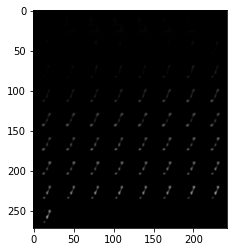

Epoch [148/400] Batch: [1/60] KL-Divergence: 0.01609792187809944 Cross-Entropy: 0.23048491775989532 Loss: 0.24658283591270447
Epoch [148/400] Batch: [2/60] KL-Divergence: 0.016143910586833954 Cross-Entropy: 0.2312791645526886 Loss: 0.24742308259010315
Epoch [148/400] Batch: [3/60] KL-Divergence: 0.01686798222362995 Cross-Entropy: 0.2318793535232544 Loss: 0.2487473338842392
Epoch [148/400] Batch: [4/60] KL-Divergence: 0.017222533002495766 Cross-Entropy: 0.2279575616121292 Loss: 0.24518010020256042
Epoch [148/400] Batch: [5/60] KL-Divergence: 0.01696745492517948 Cross-Entropy: 0.2367219626903534 Loss: 0.25368940830230713
Epoch [148/400] Batch: [6/60] KL-Divergence: 0.01714271865785122 Cross-Entropy: 0.23210984468460083 Loss: 0.2492525577545166
Epoch [148/400] Batch: [7/60] KL-Divergence: 0.016574228182435036 Cross-Entropy: 0.22863906621932983 Loss: 0.24521329998970032
Epoch [148/400] Batch: [8/60] KL-Divergence: 0.016313087195158005 Cross-Entropy: 0.22658628225326538 Loss: 0.242899373173

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [148/400] Batch: [60/60] KL-Divergence: 0.016400856897234917 Cross-Entropy: 0.23977363109588623 Loss: 0.2561744749546051
Epoch [148/400] Batch: [60/60] KL-Divergence: 0.016400856897234917 Cross-Entropy: 0.23977363109588623 Loss: 0.2561744749546051


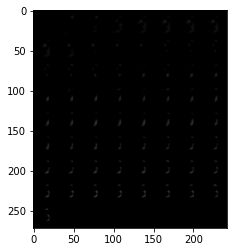

Epoch [149/400] Batch: [1/60] KL-Divergence: 0.016050828620791435 Cross-Entropy: 0.23028136789798737 Loss: 0.24633219838142395
Epoch [149/400] Batch: [2/60] KL-Divergence: 0.015674732625484467 Cross-Entropy: 0.23117822408676147 Loss: 0.24685296416282654
Epoch [149/400] Batch: [3/60] KL-Divergence: 0.015152961015701294 Cross-Entropy: 0.23194290697574615 Loss: 0.24709586799144745
Epoch [149/400] Batch: [4/60] KL-Divergence: 0.015800829976797104 Cross-Entropy: 0.22897084057331085 Loss: 0.24477167427539825
Epoch [149/400] Batch: [5/60] KL-Divergence: 0.01641443744301796 Cross-Entropy: 0.23683668673038483 Loss: 0.2532511353492737
Epoch [149/400] Batch: [6/60] KL-Divergence: 0.016156036406755447 Cross-Entropy: 0.23233740031719208 Loss: 0.24849343299865723
Epoch [149/400] Batch: [7/60] KL-Divergence: 0.015671823173761368 Cross-Entropy: 0.22992846369743347 Loss: 0.24560028314590454
Epoch [149/400] Batch: [8/60] KL-Divergence: 0.01613221876323223 Cross-Entropy: 0.22555968165397644 Loss: 0.24169

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [149/400] Batch: [60/60] KL-Divergence: 0.016609245911240578 Cross-Entropy: 0.23872938752174377 Loss: 0.2553386390209198
Epoch [149/400] Batch: [60/60] KL-Divergence: 0.016609245911240578 Cross-Entropy: 0.23872938752174377 Loss: 0.2553386390209198


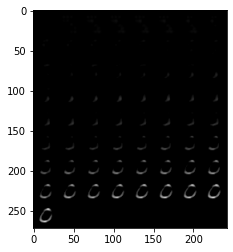

Epoch [150/400] Batch: [1/60] KL-Divergence: 0.016720300540328026 Cross-Entropy: 0.2292664796113968 Loss: 0.24598677456378937
Epoch [150/400] Batch: [2/60] KL-Divergence: 0.016486050561070442 Cross-Entropy: 0.22936630249023438 Loss: 0.24585235118865967
Epoch [150/400] Batch: [3/60] KL-Divergence: 0.017083190381526947 Cross-Entropy: 0.23041190207004547 Loss: 0.24749508500099182
Epoch [150/400] Batch: [4/60] KL-Divergence: 0.017720844596624374 Cross-Entropy: 0.22689507901668549 Loss: 0.24461592733860016
Epoch [150/400] Batch: [5/60] KL-Divergence: 0.017764415591955185 Cross-Entropy: 0.23373684287071228 Loss: 0.25150126218795776
Epoch [150/400] Batch: [6/60] KL-Divergence: 0.018169479444622993 Cross-Entropy: 0.2303369790315628 Loss: 0.24850645661354065
Epoch [150/400] Batch: [7/60] KL-Divergence: 0.0172609593719244 Cross-Entropy: 0.22737964987754822 Loss: 0.24464060366153717
Epoch [150/400] Batch: [8/60] KL-Divergence: 0.01712486706674099 Cross-Entropy: 0.22542445361614227 Loss: 0.2425493

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [150/400] Batch: [60/60] KL-Divergence: 0.017580760642886162 Cross-Entropy: 0.2362561672925949 Loss: 0.2538369297981262
Epoch [150/400] Batch: [60/60] KL-Divergence: 0.017580760642886162 Cross-Entropy: 0.2362561672925949 Loss: 0.2538369297981262


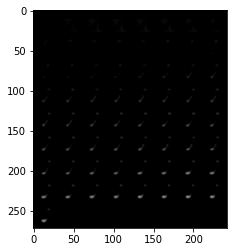

Epoch [151/400] Batch: [1/60] KL-Divergence: 0.016895605251193047 Cross-Entropy: 0.22770579159259796 Loss: 0.24460139870643616
Epoch [151/400] Batch: [2/60] KL-Divergence: 0.016690537333488464 Cross-Entropy: 0.22910048067569733 Loss: 0.2457910180091858
Epoch [151/400] Batch: [3/60] KL-Divergence: 0.016261881217360497 Cross-Entropy: 0.2292127013206482 Loss: 0.24547457695007324
Epoch [151/400] Batch: [4/60] KL-Divergence: 0.016921447589993477 Cross-Entropy: 0.22502505779266357 Loss: 0.2419465035200119
Epoch [151/400] Batch: [5/60] KL-Divergence: 0.017524579539895058 Cross-Entropy: 0.23271498084068298 Loss: 0.2502395510673523
Epoch [151/400] Batch: [6/60] KL-Divergence: 0.017558638006448746 Cross-Entropy: 0.22928594052791595 Loss: 0.2468445748090744
Epoch [151/400] Batch: [7/60] KL-Divergence: 0.01700151525437832 Cross-Entropy: 0.22666268050670624 Loss: 0.2436641901731491
Epoch [151/400] Batch: [8/60] KL-Divergence: 0.01728646829724312 Cross-Entropy: 0.22442643344402313 Loss: 0.2417128980

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [151/400] Batch: [60/60] KL-Divergence: 0.017766082659363747 Cross-Entropy: 0.23582357168197632 Loss: 0.2535896599292755
Epoch [151/400] Batch: [60/60] KL-Divergence: 0.017766082659363747 Cross-Entropy: 0.23582357168197632 Loss: 0.2535896599292755


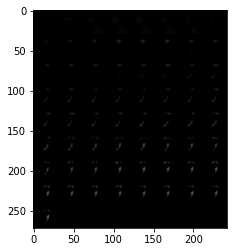

Epoch [152/400] Batch: [1/60] KL-Divergence: 0.01791660115122795 Cross-Entropy: 0.22595670819282532 Loss: 0.24387331306934357
Epoch [152/400] Batch: [2/60] KL-Divergence: 0.01727222092449665 Cross-Entropy: 0.22708356380462646 Loss: 0.24435578286647797
Epoch [152/400] Batch: [3/60] KL-Divergence: 0.017703451216220856 Cross-Entropy: 0.22764360904693604 Loss: 0.2453470528125763
Epoch [152/400] Batch: [4/60] KL-Divergence: 0.017310731112957 Cross-Entropy: 0.2241552323102951 Loss: 0.2414659559726715
Epoch [152/400] Batch: [5/60] KL-Divergence: 0.018980497494339943 Cross-Entropy: 0.23110038042068481 Loss: 0.2500808835029602
Epoch [152/400] Batch: [6/60] KL-Divergence: 0.019036851823329926 Cross-Entropy: 0.22850601375102997 Loss: 0.2475428581237793
Epoch [152/400] Batch: [7/60] KL-Divergence: 0.018420571461319923 Cross-Entropy: 0.2267385721206665 Loss: 0.24515914916992188
Epoch [152/400] Batch: [8/60] KL-Divergence: 0.01824933849275112 Cross-Entropy: 0.22371815145015717 Loss: 0.24196748435497

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [152/400] Batch: [60/60] KL-Divergence: 0.019021278247237206 Cross-Entropy: 0.2342279553413391 Loss: 0.25324922800064087
Epoch [152/400] Batch: [60/60] KL-Divergence: 0.019021278247237206 Cross-Entropy: 0.2342279553413391 Loss: 0.25324922800064087


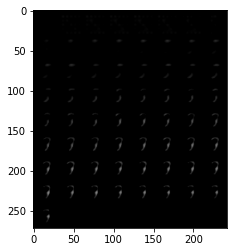

Epoch [153/400] Batch: [1/60] KL-Divergence: 0.017940443009138107 Cross-Entropy: 0.22414088249206543 Loss: 0.24208132922649384
Epoch [153/400] Batch: [2/60] KL-Divergence: 0.017677441239356995 Cross-Entropy: 0.22671803832054138 Loss: 0.24439547955989838
Epoch [153/400] Batch: [3/60] KL-Divergence: 0.017783278599381447 Cross-Entropy: 0.22686228156089783 Loss: 0.24464556574821472
Epoch [153/400] Batch: [4/60] KL-Divergence: 0.0186011865735054 Cross-Entropy: 0.22309088706970215 Loss: 0.24169206619262695
Epoch [153/400] Batch: [5/60] KL-Divergence: 0.019709691405296326 Cross-Entropy: 0.23025983572006226 Loss: 0.24996952712535858
Epoch [153/400] Batch: [6/60] KL-Divergence: 0.01906733401119709 Cross-Entropy: 0.2277357280254364 Loss: 0.24680306017398834
Epoch [153/400] Batch: [7/60] KL-Divergence: 0.017339205369353294 Cross-Entropy: 0.22489330172538757 Loss: 0.24223250150680542
Epoch [153/400] Batch: [8/60] KL-Divergence: 0.0173566285520792 Cross-Entropy: 0.22230081260204315 Loss: 0.23965744

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [153/400] Batch: [60/60] KL-Divergence: 0.017918510362505913 Cross-Entropy: 0.2324637621641159 Loss: 0.25038227438926697
Epoch [153/400] Batch: [60/60] KL-Divergence: 0.017918510362505913 Cross-Entropy: 0.2324637621641159 Loss: 0.25038227438926697


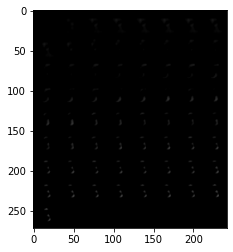

Epoch [154/400] Batch: [1/60] KL-Divergence: 0.018953712657094002 Cross-Entropy: 0.2235487848520279 Loss: 0.24250249564647675
Epoch [154/400] Batch: [2/60] KL-Divergence: 0.01784375123679638 Cross-Entropy: 0.22506576776504517 Loss: 0.2429095208644867
Epoch [154/400] Batch: [3/60] KL-Divergence: 0.018248481675982475 Cross-Entropy: 0.225485160946846 Loss: 0.24373364448547363
Epoch [154/400] Batch: [4/60] KL-Divergence: 0.018133075907826424 Cross-Entropy: 0.22179652750492096 Loss: 0.23992960155010223
Epoch [154/400] Batch: [5/60] KL-Divergence: 0.020155280828475952 Cross-Entropy: 0.22844171524047852 Loss: 0.24859699606895447
Epoch [154/400] Batch: [6/60] KL-Divergence: 0.01976819336414337 Cross-Entropy: 0.22590534389019012 Loss: 0.2456735372543335
Epoch [154/400] Batch: [7/60] KL-Divergence: 0.018924159929156303 Cross-Entropy: 0.22288702428340912 Loss: 0.24181118607521057
Epoch [154/400] Batch: [8/60] KL-Divergence: 0.019877301529049873 Cross-Entropy: 0.22088001668453217 Loss: 0.240757316

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [154/400] Batch: [60/60] KL-Divergence: 0.019030150026082993 Cross-Entropy: 0.22998130321502686 Loss: 0.24901145696640015
Epoch [154/400] Batch: [60/60] KL-Divergence: 0.019030150026082993 Cross-Entropy: 0.22998130321502686 Loss: 0.24901145696640015


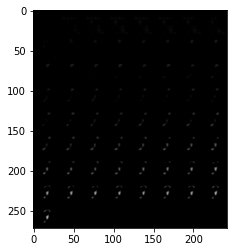

Epoch [155/400] Batch: [1/60] KL-Divergence: 0.019139816984534264 Cross-Entropy: 0.2221939116716385 Loss: 0.2413337230682373
Epoch [155/400] Batch: [2/60] KL-Divergence: 0.018528440967202187 Cross-Entropy: 0.2230655997991562 Loss: 0.24159404635429382
Epoch [155/400] Batch: [3/60] KL-Divergence: 0.020243003964424133 Cross-Entropy: 0.22458307445049286 Loss: 0.244826078414917
Epoch [155/400] Batch: [4/60] KL-Divergence: 0.02038046345114708 Cross-Entropy: 0.22049404680728912 Loss: 0.2408745139837265
Epoch [155/400] Batch: [5/60] KL-Divergence: 0.020672792568802834 Cross-Entropy: 0.22640755772590637 Loss: 0.24708035588264465
Epoch [155/400] Batch: [6/60] KL-Divergence: 0.01927543245255947 Cross-Entropy: 0.22520510852336884 Loss: 0.24448053538799286
Epoch [155/400] Batch: [7/60] KL-Divergence: 0.018749315291643143 Cross-Entropy: 0.22355879843235016 Loss: 0.242308109998703
Epoch [155/400] Batch: [8/60] KL-Divergence: 0.018865367397665977 Cross-Entropy: 0.22038528323173523 Loss: 0.239250645041

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [155/400] Batch: [60/60] KL-Divergence: 0.019933300092816353 Cross-Entropy: 0.23055291175842285 Loss: 0.25048622488975525
Epoch [155/400] Batch: [60/60] KL-Divergence: 0.019933300092816353 Cross-Entropy: 0.23055291175842285 Loss: 0.25048622488975525


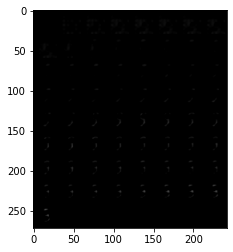

Epoch [156/400] Batch: [1/60] KL-Divergence: 0.020624715834856033 Cross-Entropy: 0.23141291737556458 Loss: 0.2520376443862915
Epoch [156/400] Batch: [2/60] KL-Divergence: 0.021754611283540726 Cross-Entropy: 0.2449122667312622 Loss: 0.26666688919067383
Epoch [156/400] Batch: [3/60] KL-Divergence: 0.022607460618019104 Cross-Entropy: 0.2432851493358612 Loss: 0.2658926248550415
Epoch [156/400] Batch: [4/60] KL-Divergence: 0.02358018420636654 Cross-Entropy: 0.25110340118408203 Loss: 0.2746835947036743
Epoch [156/400] Batch: [5/60] KL-Divergence: 0.025024287402629852 Cross-Entropy: 0.26094871759414673 Loss: 0.2859730124473572
Epoch [156/400] Batch: [6/60] KL-Divergence: 0.027449173852801323 Cross-Entropy: 0.26443785429000854 Loss: 0.2918870151042938
Epoch [156/400] Batch: [7/60] KL-Divergence: 0.028134411200881004 Cross-Entropy: 0.2561883330345154 Loss: 0.28432273864746094
Epoch [156/400] Batch: [8/60] KL-Divergence: 0.0296232458204031 Cross-Entropy: 0.25095677375793457 Loss: 0.2805800139904

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [156/400] Batch: [60/60] KL-Divergence: 0.014618627727031708 Cross-Entropy: 0.25433459877967834 Loss: 0.26895323395729065
Epoch [156/400] Batch: [60/60] KL-Divergence: 0.014618627727031708 Cross-Entropy: 0.25433459877967834 Loss: 0.26895323395729065


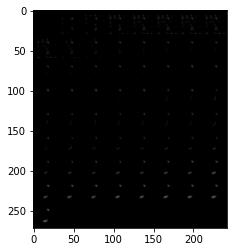

Epoch [157/400] Batch: [1/60] KL-Divergence: 0.016299167647957802 Cross-Entropy: 0.2428039163351059 Loss: 0.25910308957099915
Epoch [157/400] Batch: [2/60] KL-Divergence: 0.018046576529741287 Cross-Entropy: 0.2416522204875946 Loss: 0.2596988081932068
Epoch [157/400] Batch: [3/60] KL-Divergence: 0.01902894303202629 Cross-Entropy: 0.24428732693195343 Loss: 0.26331627368927
Epoch [157/400] Batch: [4/60] KL-Divergence: 0.019074412062764168 Cross-Entropy: 0.23916350305080414 Loss: 0.25823792815208435
Epoch [157/400] Batch: [5/60] KL-Divergence: 0.019225597381591797 Cross-Entropy: 0.24898211658000946 Loss: 0.26820772886276245
Epoch [157/400] Batch: [6/60] KL-Divergence: 0.01891954056918621 Cross-Entropy: 0.24691727757453918 Loss: 0.26583680510520935
Epoch [157/400] Batch: [7/60] KL-Divergence: 0.01874944195151329 Cross-Entropy: 0.24267226457595825 Loss: 0.26142171025276184
Epoch [157/400] Batch: [8/60] KL-Divergence: 0.017612982541322708 Cross-Entropy: 0.23886817693710327 Loss: 0.25648117065

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [157/400] Batch: [60/60] KL-Divergence: 0.013613064773380756 Cross-Entropy: 0.24766883254051208 Loss: 0.26128190755844116
Epoch [157/400] Batch: [60/60] KL-Divergence: 0.013613064773380756 Cross-Entropy: 0.24766883254051208 Loss: 0.26128190755844116


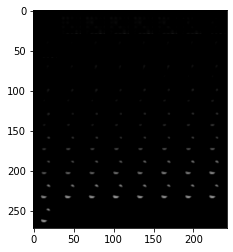

Epoch [158/400] Batch: [1/60] KL-Divergence: 0.013620952144265175 Cross-Entropy: 0.23810935020446777 Loss: 0.2517302930355072
Epoch [158/400] Batch: [2/60] KL-Divergence: 0.01319560781121254 Cross-Entropy: 0.23744717240333557 Loss: 0.2506427764892578
Epoch [158/400] Batch: [3/60] KL-Divergence: 0.013698471710085869 Cross-Entropy: 0.2386758178472519 Loss: 0.2523742914199829
Epoch [158/400] Batch: [4/60] KL-Divergence: 0.014370557852089405 Cross-Entropy: 0.23368600010871887 Loss: 0.248056560754776
Epoch [158/400] Batch: [5/60] KL-Divergence: 0.014558542519807816 Cross-Entropy: 0.2420622706413269 Loss: 0.2566208243370056
Epoch [158/400] Batch: [6/60] KL-Divergence: 0.014338469132781029 Cross-Entropy: 0.2399643510580063 Loss: 0.25430282950401306
Epoch [158/400] Batch: [7/60] KL-Divergence: 0.014244473539292812 Cross-Entropy: 0.2352823168039322 Loss: 0.24952678382396698
Epoch [158/400] Batch: [8/60] KL-Divergence: 0.014341985806822777 Cross-Entropy: 0.23185570538043976 Loss: 0.2461976855993

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [158/400] Batch: [60/60] KL-Divergence: 0.01763378642499447 Cross-Entropy: 0.23873896896839142 Loss: 0.25637274980545044
Epoch [158/400] Batch: [60/60] KL-Divergence: 0.01763378642499447 Cross-Entropy: 0.23873896896839142 Loss: 0.25637274980545044


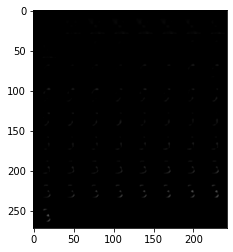

Epoch [159/400] Batch: [1/60] KL-Divergence: 0.016945233568549156 Cross-Entropy: 0.23052506148815155 Loss: 0.24747028946876526
Epoch [159/400] Batch: [2/60] KL-Divergence: 0.016695810481905937 Cross-Entropy: 0.23144978284835815 Loss: 0.24814559519290924
Epoch [159/400] Batch: [3/60] KL-Divergence: 0.016268005594611168 Cross-Entropy: 0.23340241611003876 Loss: 0.24967041611671448
Epoch [159/400] Batch: [4/60] KL-Divergence: 0.016925005242228508 Cross-Entropy: 0.22878053784370422 Loss: 0.24570554494857788
Epoch [159/400] Batch: [5/60] KL-Divergence: 0.016185639426112175 Cross-Entropy: 0.23703551292419434 Loss: 0.25322115421295166
Epoch [159/400] Batch: [6/60] KL-Divergence: 0.01643742434680462 Cross-Entropy: 0.23308981955051422 Loss: 0.249527245759964
Epoch [159/400] Batch: [7/60] KL-Divergence: 0.01563240773975849 Cross-Entropy: 0.22991943359375 Loss: 0.24555183947086334
Epoch [159/400] Batch: [8/60] KL-Divergence: 0.015854530036449432 Cross-Entropy: 0.226708322763443 Loss: 0.24256286025

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [159/400] Batch: [60/60] KL-Divergence: 0.01853029429912567 Cross-Entropy: 0.2378098964691162 Loss: 0.2563402056694031
Epoch [159/400] Batch: [60/60] KL-Divergence: 0.01853029429912567 Cross-Entropy: 0.2378098964691162 Loss: 0.2563402056694031


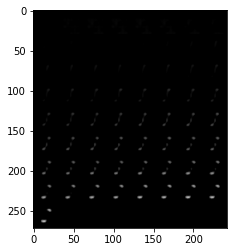

Epoch [160/400] Batch: [1/60] KL-Divergence: 0.017617760226130486 Cross-Entropy: 0.22793744504451752 Loss: 0.24555520713329315
Epoch [160/400] Batch: [2/60] KL-Divergence: 0.01755351945757866 Cross-Entropy: 0.2288433015346527 Loss: 0.24639682471752167
Epoch [160/400] Batch: [3/60] KL-Divergence: 0.017804928123950958 Cross-Entropy: 0.23005352914333344 Loss: 0.247858464717865
Epoch [160/400] Batch: [4/60] KL-Divergence: 0.017808519303798676 Cross-Entropy: 0.2252999097108841 Loss: 0.24310842156410217
Epoch [160/400] Batch: [5/60] KL-Divergence: 0.018391350284218788 Cross-Entropy: 0.23285187780857086 Loss: 0.2512432336807251
Epoch [160/400] Batch: [6/60] KL-Divergence: 0.018616024404764175 Cross-Entropy: 0.23102794587612152 Loss: 0.2496439665555954
Epoch [160/400] Batch: [7/60] KL-Divergence: 0.01695185899734497 Cross-Entropy: 0.22726617753505707 Loss: 0.24421803653240204
Epoch [160/400] Batch: [8/60] KL-Divergence: 0.017954207956790924 Cross-Entropy: 0.22516505420207977 Loss: 0.2431192696

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [160/400] Batch: [60/60] KL-Divergence: 0.01812199503183365 Cross-Entropy: 0.2353949248790741 Loss: 0.25351691246032715
Epoch [160/400] Batch: [60/60] KL-Divergence: 0.01812199503183365 Cross-Entropy: 0.2353949248790741 Loss: 0.25351691246032715


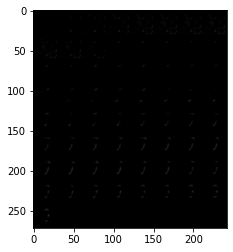

Epoch [161/400] Batch: [1/60] KL-Divergence: 0.017075225710868835 Cross-Entropy: 0.22564533352851868 Loss: 0.2427205592393875
Epoch [161/400] Batch: [2/60] KL-Divergence: 0.017835846170783043 Cross-Entropy: 0.22791573405265808 Loss: 0.24575157463550568
Epoch [161/400] Batch: [3/60] KL-Divergence: 0.01859133690595627 Cross-Entropy: 0.22813397645950317 Loss: 0.24672532081604004
Epoch [161/400] Batch: [4/60] KL-Divergence: 0.018314149230718613 Cross-Entropy: 0.22399432957172394 Loss: 0.24230848252773285
Epoch [161/400] Batch: [5/60] KL-Divergence: 0.019214684143662453 Cross-Entropy: 0.23082000017166138 Loss: 0.2500346899032593
Epoch [161/400] Batch: [6/60] KL-Divergence: 0.018179168924689293 Cross-Entropy: 0.22896476089954376 Loss: 0.2471439242362976
Epoch [161/400] Batch: [7/60] KL-Divergence: 0.018381668254733086 Cross-Entropy: 0.22585497796535492 Loss: 0.24423664808273315
Epoch [161/400] Batch: [8/60] KL-Divergence: 0.018953297287225723 Cross-Entropy: 0.22309310734272003 Loss: 0.242046

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [161/400] Batch: [60/60] KL-Divergence: 0.019412947818636894 Cross-Entropy: 0.23395664989948273 Loss: 0.25336959958076477
Epoch [161/400] Batch: [60/60] KL-Divergence: 0.019412947818636894 Cross-Entropy: 0.23395664989948273 Loss: 0.25336959958076477


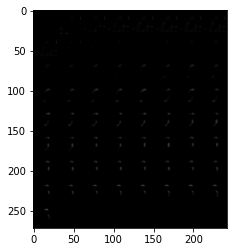

Epoch [162/400] Batch: [1/60] KL-Divergence: 0.01873748190701008 Cross-Entropy: 0.22443677484989166 Loss: 0.2431742548942566
Epoch [162/400] Batch: [2/60] KL-Divergence: 0.01935248076915741 Cross-Entropy: 0.2253815233707428 Loss: 0.2447340041399002
Epoch [162/400] Batch: [3/60] KL-Divergence: 0.019120128825306892 Cross-Entropy: 0.2274634838104248 Loss: 0.24658361077308655
Epoch [162/400] Batch: [4/60] KL-Divergence: 0.018580595031380653 Cross-Entropy: 0.2232109159231186 Loss: 0.2417915165424347
Epoch [162/400] Batch: [5/60] KL-Divergence: 0.02012069709599018 Cross-Entropy: 0.22949984669685364 Loss: 0.24962054193019867
Epoch [162/400] Batch: [6/60] KL-Divergence: 0.019514819607138634 Cross-Entropy: 0.2282833307981491 Loss: 0.2477981448173523
Epoch [162/400] Batch: [7/60] KL-Divergence: 0.018390458077192307 Cross-Entropy: 0.2247878611087799 Loss: 0.2431783229112625
Epoch [162/400] Batch: [8/60] KL-Divergence: 0.018549002707004547 Cross-Entropy: 0.2232924997806549 Loss: 0.2418414950370788

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [162/400] Batch: [60/60] KL-Divergence: 0.019345218315720558 Cross-Entropy: 0.23018819093704224 Loss: 0.24953341484069824
Epoch [162/400] Batch: [60/60] KL-Divergence: 0.019345218315720558 Cross-Entropy: 0.23018819093704224 Loss: 0.24953341484069824


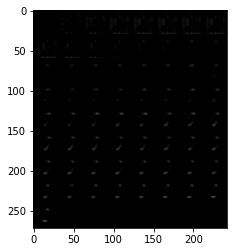

Epoch [163/400] Batch: [1/60] KL-Divergence: 0.020142341032624245 Cross-Entropy: 0.22353379428386688 Loss: 0.24367614090442657
Epoch [163/400] Batch: [2/60] KL-Divergence: 0.018536515533924103 Cross-Entropy: 0.22493793070316315 Loss: 0.24347445368766785
Epoch [163/400] Batch: [3/60] KL-Divergence: 0.019073044881224632 Cross-Entropy: 0.22618000209331512 Loss: 0.2452530413866043
Epoch [163/400] Batch: [4/60] KL-Divergence: 0.0187640693038702 Cross-Entropy: 0.2225314825773239 Loss: 0.24129554629325867
Epoch [163/400] Batch: [5/60] KL-Divergence: 0.019325030967593193 Cross-Entropy: 0.2288181483745575 Loss: 0.24814318120479584
Epoch [163/400] Batch: [6/60] KL-Divergence: 0.018434856086969376 Cross-Entropy: 0.22764073312282562 Loss: 0.2460755854845047
Epoch [163/400] Batch: [7/60] KL-Divergence: 0.018484313040971756 Cross-Entropy: 0.2242281436920166 Loss: 0.24271245300769806
Epoch [163/400] Batch: [8/60] KL-Divergence: 0.018616382032632828 Cross-Entropy: 0.22112636268138885 Loss: 0.239742740

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [163/400] Batch: [60/60] KL-Divergence: 0.019793150946497917 Cross-Entropy: 0.23245550692081451 Loss: 0.2522486448287964
Epoch [163/400] Batch: [60/60] KL-Divergence: 0.019793150946497917 Cross-Entropy: 0.23245550692081451 Loss: 0.2522486448287964


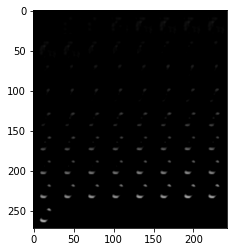

Epoch [164/400] Batch: [1/60] KL-Divergence: 0.019408095628023148 Cross-Entropy: 0.22412389516830444 Loss: 0.2435319870710373
Epoch [164/400] Batch: [2/60] KL-Divergence: 0.018291359767317772 Cross-Entropy: 0.2256024181842804 Loss: 0.24389377236366272
Epoch [164/400] Batch: [3/60] KL-Divergence: 0.018600698560476303 Cross-Entropy: 0.22693441808223724 Loss: 0.24553512036800385
Epoch [164/400] Batch: [4/60] KL-Divergence: 0.01854722574353218 Cross-Entropy: 0.22306416928768158 Loss: 0.24161139130592346
Epoch [164/400] Batch: [5/60] KL-Divergence: 0.019877849146723747 Cross-Entropy: 0.22885361313819885 Loss: 0.24873146414756775
Epoch [164/400] Batch: [6/60] KL-Divergence: 0.018834920600056648 Cross-Entropy: 0.22709892690181732 Loss: 0.24593384563922882
Epoch [164/400] Batch: [7/60] KL-Divergence: 0.017858976498246193 Cross-Entropy: 0.2237546294927597 Loss: 0.24161361157894135
Epoch [164/400] Batch: [8/60] KL-Divergence: 0.01895514689385891 Cross-Entropy: 0.22199325263500214 Loss: 0.2409483

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [164/400] Batch: [60/60] KL-Divergence: 0.01999904215335846 Cross-Entropy: 0.23025090992450714 Loss: 0.2502499520778656
Epoch [164/400] Batch: [60/60] KL-Divergence: 0.01999904215335846 Cross-Entropy: 0.23025090992450714 Loss: 0.2502499520778656


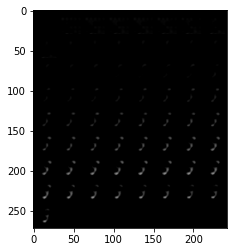

Epoch [165/400] Batch: [1/60] KL-Divergence: 0.01967448554933071 Cross-Entropy: 0.2223871946334839 Loss: 0.24206167459487915
Epoch [165/400] Batch: [2/60] KL-Divergence: 0.01933343894779682 Cross-Entropy: 0.22465647757053375 Loss: 0.24398991465568542
Epoch [165/400] Batch: [3/60] KL-Divergence: 0.01945456489920616 Cross-Entropy: 0.2251656949520111 Loss: 0.24462026357650757
Epoch [165/400] Batch: [4/60] KL-Divergence: 0.019555119797587395 Cross-Entropy: 0.22205471992492676 Loss: 0.2416098415851593
Epoch [165/400] Batch: [5/60] KL-Divergence: 0.020141029730439186 Cross-Entropy: 0.22736167907714844 Loss: 0.24750271439552307
Epoch [165/400] Batch: [6/60] KL-Divergence: 0.019786586984992027 Cross-Entropy: 0.2256074994802475 Loss: 0.24539408087730408
Epoch [165/400] Batch: [7/60] KL-Divergence: 0.01999903842806816 Cross-Entropy: 0.2232343852519989 Loss: 0.24323342740535736
Epoch [165/400] Batch: [8/60] KL-Divergence: 0.01879115402698517 Cross-Entropy: 0.2201974242925644 Loss: 0.2389885783195

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [165/400] Batch: [60/60] KL-Divergence: 0.02070581167936325 Cross-Entropy: 0.22921918332576752 Loss: 0.24992498755455017
Epoch [165/400] Batch: [60/60] KL-Divergence: 0.02070581167936325 Cross-Entropy: 0.22921918332576752 Loss: 0.24992498755455017


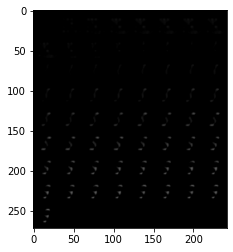

Epoch [166/400] Batch: [1/60] KL-Divergence: 0.020752741023898125 Cross-Entropy: 0.22219039499759674 Loss: 0.24294313788414001
Epoch [166/400] Batch: [2/60] KL-Divergence: 0.01918197050690651 Cross-Entropy: 0.2239205539226532 Loss: 0.2431025207042694
Epoch [166/400] Batch: [3/60] KL-Divergence: 0.020081637427210808 Cross-Entropy: 0.22464685142040253 Loss: 0.24472849071025848
Epoch [166/400] Batch: [4/60] KL-Divergence: 0.019061096012592316 Cross-Entropy: 0.22079534828662872 Loss: 0.23985645174980164
Epoch [166/400] Batch: [5/60] KL-Divergence: 0.020078716799616814 Cross-Entropy: 0.22667621076107025 Loss: 0.24675492942333221
Epoch [166/400] Batch: [6/60] KL-Divergence: 0.018888745456933975 Cross-Entropy: 0.22679433226585388 Loss: 0.24568307399749756
Epoch [166/400] Batch: [7/60] KL-Divergence: 0.018145600333809853 Cross-Entropy: 0.22266294062137604 Loss: 0.24080854654312134
Epoch [166/400] Batch: [8/60] KL-Divergence: 0.01908036880195141 Cross-Entropy: 0.2198256403207779 Loss: 0.2389060

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [166/400] Batch: [60/60] KL-Divergence: 0.020601259544491768 Cross-Entropy: 0.22885027527809143 Loss: 0.24945153295993805
Epoch [166/400] Batch: [60/60] KL-Divergence: 0.020601259544491768 Cross-Entropy: 0.22885027527809143 Loss: 0.24945153295993805


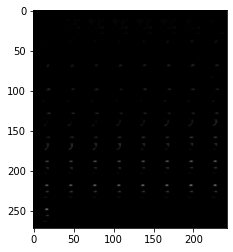

Epoch [167/400] Batch: [1/60] KL-Divergence: 0.01970977894961834 Cross-Entropy: 0.22157417237758636 Loss: 0.24128395318984985
Epoch [167/400] Batch: [2/60] KL-Divergence: 0.019962746649980545 Cross-Entropy: 0.22280153632164001 Loss: 0.24276427924633026
Epoch [167/400] Batch: [3/60] KL-Divergence: 0.019966715946793556 Cross-Entropy: 0.2239791601896286 Loss: 0.2439458817243576
Epoch [167/400] Batch: [4/60] KL-Divergence: 0.02068699710071087 Cross-Entropy: 0.22031159698963165 Loss: 0.24099859595298767
Epoch [167/400] Batch: [5/60] KL-Divergence: 0.02142557129263878 Cross-Entropy: 0.22684364020824432 Loss: 0.2482692152261734
Epoch [167/400] Batch: [6/60] KL-Divergence: 0.02102694846689701 Cross-Entropy: 0.22436490654945374 Loss: 0.2453918606042862
Epoch [167/400] Batch: [7/60] KL-Divergence: 0.02114517241716385 Cross-Entropy: 0.22170232236385345 Loss: 0.2428475022315979
Epoch [167/400] Batch: [8/60] KL-Divergence: 0.021447399631142616 Cross-Entropy: 0.22020673751831055 Loss: 0.241654142737

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [167/400] Batch: [60/60] KL-Divergence: 0.02189059741795063 Cross-Entropy: 0.22840498387813568 Loss: 0.25029557943344116
Epoch [167/400] Batch: [60/60] KL-Divergence: 0.02189059741795063 Cross-Entropy: 0.22840498387813568 Loss: 0.25029557943344116


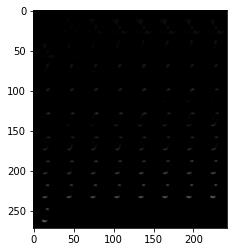

Epoch [168/400] Batch: [1/60] KL-Divergence: 0.020798636600375175 Cross-Entropy: 0.2200811803340912 Loss: 0.2408798187971115
Epoch [168/400] Batch: [2/60] KL-Divergence: 0.01988326944410801 Cross-Entropy: 0.22196868062019348 Loss: 0.24185195565223694
Epoch [168/400] Batch: [3/60] KL-Divergence: 0.020338239148259163 Cross-Entropy: 0.22441238164901733 Loss: 0.24475061893463135
Epoch [168/400] Batch: [4/60] KL-Divergence: 0.020185580477118492 Cross-Entropy: 0.2193760871887207 Loss: 0.23956166207790375
Epoch [168/400] Batch: [5/60] KL-Divergence: 0.02170662209391594 Cross-Entropy: 0.2250555008649826 Loss: 0.24676212668418884
Epoch [168/400] Batch: [6/60] KL-Divergence: 0.02024552971124649 Cross-Entropy: 0.2236412763595581 Loss: 0.243886798620224
Epoch [168/400] Batch: [7/60] KL-Divergence: 0.019312147051095963 Cross-Entropy: 0.2210850715637207 Loss: 0.24039721488952637
Epoch [168/400] Batch: [8/60] KL-Divergence: 0.021156491711735725 Cross-Entropy: 0.21909566223621368 Loss: 0.2402521520853

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [168/400] Batch: [60/60] KL-Divergence: 0.020959045737981796 Cross-Entropy: 0.22807492315769196 Loss: 0.24903397262096405
Epoch [168/400] Batch: [60/60] KL-Divergence: 0.020959045737981796 Cross-Entropy: 0.22807492315769196 Loss: 0.24903397262096405


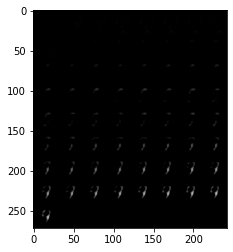

Epoch [169/400] Batch: [1/60] KL-Divergence: 0.020956987515091896 Cross-Entropy: 0.21966098248958588 Loss: 0.24061797559261322
Epoch [169/400] Batch: [2/60] KL-Divergence: 0.01976815052330494 Cross-Entropy: 0.22222839295864105 Loss: 0.24199654161930084
Epoch [169/400] Batch: [3/60] KL-Divergence: 0.020461933687329292 Cross-Entropy: 0.22396865487098694 Loss: 0.24443058669567108
Epoch [169/400] Batch: [4/60] KL-Divergence: 0.02025710605084896 Cross-Entropy: 0.21914197504520416 Loss: 0.23939907550811768
Epoch [169/400] Batch: [5/60] KL-Divergence: 0.021480830386281013 Cross-Entropy: 0.22516439855098724 Loss: 0.2466452270746231
Epoch [169/400] Batch: [6/60] KL-Divergence: 0.020155107602477074 Cross-Entropy: 0.2235291451215744 Loss: 0.24368424713611603
Epoch [169/400] Batch: [7/60] KL-Divergence: 0.020011048763990402 Cross-Entropy: 0.22138680517673492 Loss: 0.24139785766601562
Epoch [169/400] Batch: [8/60] KL-Divergence: 0.020829500630497932 Cross-Entropy: 0.21847327053546906 Loss: 0.239302

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [169/400] Batch: [60/60] KL-Divergence: 0.021459560841321945 Cross-Entropy: 0.22723324596881866 Loss: 0.2486928105354309
Epoch [169/400] Batch: [60/60] KL-Divergence: 0.021459560841321945 Cross-Entropy: 0.22723324596881866 Loss: 0.2486928105354309


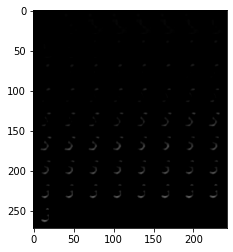

Epoch [170/400] Batch: [1/60] KL-Divergence: 0.021518699824810028 Cross-Entropy: 0.2188999205827713 Loss: 0.24041861295700073
Epoch [170/400] Batch: [2/60] KL-Divergence: 0.020749105140566826 Cross-Entropy: 0.22146083414554596 Loss: 0.24220994114875793
Epoch [170/400] Batch: [3/60] KL-Divergence: 0.02059798128902912 Cross-Entropy: 0.22182588279247284 Loss: 0.2424238622188568
Epoch [170/400] Batch: [4/60] KL-Divergence: 0.020142097026109695 Cross-Entropy: 0.21941421926021576 Loss: 0.23955631256103516
Epoch [170/400] Batch: [5/60] KL-Divergence: 0.021255528554320335 Cross-Entropy: 0.22534924745559692 Loss: 0.2466047704219818
Epoch [170/400] Batch: [6/60] KL-Divergence: 0.020469672977924347 Cross-Entropy: 0.22395546734333038 Loss: 0.24442514777183533
Epoch [170/400] Batch: [7/60] KL-Divergence: 0.01993006467819214 Cross-Entropy: 0.22033481299877167 Loss: 0.2402648776769638
Epoch [170/400] Batch: [8/60] KL-Divergence: 0.020470382645726204 Cross-Entropy: 0.21713866293430328 Loss: 0.23760904

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [170/400] Batch: [60/60] KL-Divergence: 0.021831845864653587 Cross-Entropy: 0.2267465889453888 Loss: 0.24857842922210693
Epoch [170/400] Batch: [60/60] KL-Divergence: 0.021831845864653587 Cross-Entropy: 0.2267465889453888 Loss: 0.24857842922210693


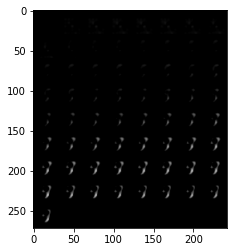

Epoch [171/400] Batch: [1/60] KL-Divergence: 0.020803427323698997 Cross-Entropy: 0.21866491436958313 Loss: 0.23946833610534668
Epoch [171/400] Batch: [2/60] KL-Divergence: 0.020993245765566826 Cross-Entropy: 0.22141769528388977 Loss: 0.24241094291210175
Epoch [171/400] Batch: [3/60] KL-Divergence: 0.020403413102030754 Cross-Entropy: 0.2214435636997223 Loss: 0.2418469786643982
Epoch [171/400] Batch: [4/60] KL-Divergence: 0.021699177101254463 Cross-Entropy: 0.21700210869312286 Loss: 0.23870128393173218
Epoch [171/400] Batch: [5/60] KL-Divergence: 0.022276995703577995 Cross-Entropy: 0.22197061777114868 Loss: 0.24424761533737183
Epoch [171/400] Batch: [6/60] KL-Divergence: 0.021498369053006172 Cross-Entropy: 0.22288736701011658 Loss: 0.2443857342004776
Epoch [171/400] Batch: [7/60] KL-Divergence: 0.021623574197292328 Cross-Entropy: 0.22053784132003784 Loss: 0.24216142296791077
Epoch [171/400] Batch: [8/60] KL-Divergence: 0.02152593620121479 Cross-Entropy: 0.21687068045139313 Loss: 0.238396

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [171/400] Batch: [60/60] KL-Divergence: 0.021515876054763794 Cross-Entropy: 0.22673539817333221 Loss: 0.248251274228096
Epoch [171/400] Batch: [60/60] KL-Divergence: 0.021515876054763794 Cross-Entropy: 0.22673539817333221 Loss: 0.248251274228096


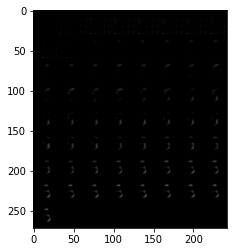

Epoch [172/400] Batch: [1/60] KL-Divergence: 0.021053612232208252 Cross-Entropy: 0.21741904318332672 Loss: 0.23847265541553497
Epoch [172/400] Batch: [2/60] KL-Divergence: 0.02060912363231182 Cross-Entropy: 0.2198714315891266 Loss: 0.24048055708408356
Epoch [172/400] Batch: [3/60] KL-Divergence: 0.021071558818221092 Cross-Entropy: 0.22084254026412964 Loss: 0.24191409349441528
Epoch [172/400] Batch: [4/60] KL-Divergence: 0.02182331681251526 Cross-Entropy: 0.21729691326618195 Loss: 0.2391202300786972
Epoch [172/400] Batch: [5/60] KL-Divergence: 0.023614291101694107 Cross-Entropy: 0.22227676212787628 Loss: 0.2458910495042801
Epoch [172/400] Batch: [6/60] KL-Divergence: 0.021285444498062134 Cross-Entropy: 0.22180262207984924 Loss: 0.24308806657791138
Epoch [172/400] Batch: [7/60] KL-Divergence: 0.020847689360380173 Cross-Entropy: 0.21920645236968994 Loss: 0.2400541454553604
Epoch [172/400] Batch: [8/60] KL-Divergence: 0.021113509312272072 Cross-Entropy: 0.2166450023651123 Loss: 0.237758517

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [172/400] Batch: [60/60] KL-Divergence: 0.021874018013477325 Cross-Entropy: 0.2262171506881714 Loss: 0.24809116125106812
Epoch [172/400] Batch: [60/60] KL-Divergence: 0.021874018013477325 Cross-Entropy: 0.2262171506881714 Loss: 0.24809116125106812


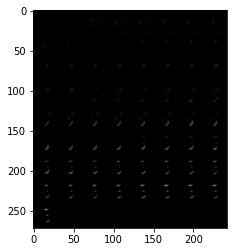

Epoch [173/400] Batch: [1/60] KL-Divergence: 0.021299101412296295 Cross-Entropy: 0.21879126131534576 Loss: 0.24009037017822266
Epoch [173/400] Batch: [2/60] KL-Divergence: 0.020655205473303795 Cross-Entropy: 0.22030003368854523 Loss: 0.24095523357391357
Epoch [173/400] Batch: [3/60] KL-Divergence: 0.020814837887883186 Cross-Entropy: 0.22030727565288544 Loss: 0.24112211167812347
Epoch [173/400] Batch: [4/60] KL-Divergence: 0.02207384631037712 Cross-Entropy: 0.2177163064479828 Loss: 0.2397901564836502
Epoch [173/400] Batch: [5/60] KL-Divergence: 0.023274555802345276 Cross-Entropy: 0.22111622989177704 Loss: 0.24439078569412231
Epoch [173/400] Batch: [6/60] KL-Divergence: 0.022092122584581375 Cross-Entropy: 0.22143538296222687 Loss: 0.24352750182151794
Epoch [173/400] Batch: [7/60] KL-Divergence: 0.021800708025693893 Cross-Entropy: 0.2181745022535324 Loss: 0.2399752140045166
Epoch [173/400] Batch: [8/60] KL-Divergence: 0.022161703556776047 Cross-Entropy: 0.21617621183395386 Loss: 0.2383379

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [173/400] Batch: [60/60] KL-Divergence: 0.021986093372106552 Cross-Entropy: 0.22466903924942017 Loss: 0.24665513634681702
Epoch [173/400] Batch: [60/60] KL-Divergence: 0.021986093372106552 Cross-Entropy: 0.22466903924942017 Loss: 0.24665513634681702


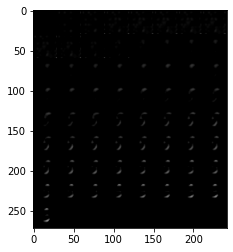

Epoch [174/400] Batch: [1/60] KL-Divergence: 0.021732844412326813 Cross-Entropy: 0.21807271242141724 Loss: 0.23980554938316345
Epoch [174/400] Batch: [2/60] KL-Divergence: 0.020609956234693527 Cross-Entropy: 0.21946372091770172 Loss: 0.24007368087768555
Epoch [174/400] Batch: [3/60] KL-Divergence: 0.02164250984787941 Cross-Entropy: 0.21989743411540985 Loss: 0.24153994023799896
Epoch [174/400] Batch: [4/60] KL-Divergence: 0.02157803624868393 Cross-Entropy: 0.21566610038280487 Loss: 0.2372441291809082
Epoch [174/400] Batch: [5/60] KL-Divergence: 0.023692557588219643 Cross-Entropy: 0.2214885950088501 Loss: 0.2451811581850052
Epoch [174/400] Batch: [6/60] KL-Divergence: 0.0221504345536232 Cross-Entropy: 0.22172695398330688 Loss: 0.2438773810863495
Epoch [174/400] Batch: [7/60] KL-Divergence: 0.020775489509105682 Cross-Entropy: 0.21854674816131592 Loss: 0.2393222451210022
Epoch [174/400] Batch: [8/60] KL-Divergence: 0.021693779155611992 Cross-Entropy: 0.21593473851680756 Loss: 0.23762851953

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [174/400] Batch: [60/60] KL-Divergence: 0.02304006740450859 Cross-Entropy: 0.22308261692523956 Loss: 0.24612268805503845
Epoch [174/400] Batch: [60/60] KL-Divergence: 0.02304006740450859 Cross-Entropy: 0.22308261692523956 Loss: 0.24612268805503845


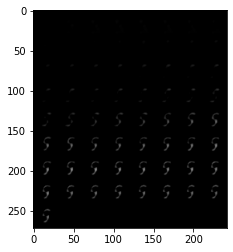

Epoch [175/400] Batch: [1/60] KL-Divergence: 0.02243371494114399 Cross-Entropy: 0.21632249653339386 Loss: 0.2387562096118927
Epoch [175/400] Batch: [2/60] KL-Divergence: 0.022370515391230583 Cross-Entropy: 0.2184600532054901 Loss: 0.24083057045936584
Epoch [175/400] Batch: [3/60] KL-Divergence: 0.021987982094287872 Cross-Entropy: 0.21855448186397552 Loss: 0.240542471408844
Epoch [175/400] Batch: [4/60] KL-Divergence: 0.022358978167176247 Cross-Entropy: 0.2150934636592865 Loss: 0.2374524474143982
Epoch [175/400] Batch: [5/60] KL-Divergence: 0.022911928594112396 Cross-Entropy: 0.2192775309085846 Loss: 0.2421894669532776
Epoch [175/400] Batch: [6/60] KL-Divergence: 0.02217838726937771 Cross-Entropy: 0.2210565060377121 Loss: 0.24323488771915436
Epoch [175/400] Batch: [7/60] KL-Divergence: 0.021844740957021713 Cross-Entropy: 0.21788324415683746 Loss: 0.23972798883914948
Epoch [175/400] Batch: [8/60] KL-Divergence: 0.021977923810482025 Cross-Entropy: 0.2149806171655655 Loss: 0.23695853352546

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [175/400] Batch: [60/60] KL-Divergence: 0.022935517132282257 Cross-Entropy: 0.22606779634952545 Loss: 0.2490033209323883
Epoch [175/400] Batch: [60/60] KL-Divergence: 0.022935517132282257 Cross-Entropy: 0.22606779634952545 Loss: 0.2490033209323883


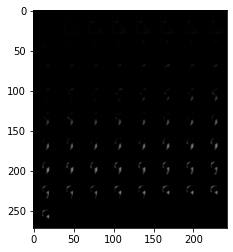

Epoch [176/400] Batch: [1/60] KL-Divergence: 0.022543901577591896 Cross-Entropy: 0.2180095911026001 Loss: 0.24055349826812744
Epoch [176/400] Batch: [2/60] KL-Divergence: 0.021507220342755318 Cross-Entropy: 0.21990293264389038 Loss: 0.24141015112400055
Epoch [176/400] Batch: [3/60] KL-Divergence: 0.02200349047780037 Cross-Entropy: 0.21995487809181213 Loss: 0.2419583648443222
Epoch [176/400] Batch: [4/60] KL-Divergence: 0.022152723744511604 Cross-Entropy: 0.21684472262859344 Loss: 0.2389974445104599
Epoch [176/400] Batch: [5/60] KL-Divergence: 0.023674800992012024 Cross-Entropy: 0.22098691761493683 Loss: 0.24466171860694885
Epoch [176/400] Batch: [6/60] KL-Divergence: 0.022652342915534973 Cross-Entropy: 0.22113999724388123 Loss: 0.2437923401594162
Epoch [176/400] Batch: [7/60] KL-Divergence: 0.02199311926960945 Cross-Entropy: 0.2185320407152176 Loss: 0.24052515625953674
Epoch [176/400] Batch: [8/60] KL-Divergence: 0.022432465106248856 Cross-Entropy: 0.2145533710718155 Loss: 0.2369858324

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [176/400] Batch: [60/60] KL-Divergence: 0.023086639121174812 Cross-Entropy: 0.2243790179491043 Loss: 0.24746565520763397
Epoch [176/400] Batch: [60/60] KL-Divergence: 0.023086639121174812 Cross-Entropy: 0.2243790179491043 Loss: 0.24746565520763397


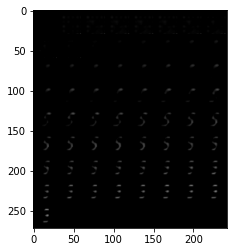

Epoch [177/400] Batch: [1/60] KL-Divergence: 0.021449018269777298 Cross-Entropy: 0.2163028120994568 Loss: 0.2377518266439438
Epoch [177/400] Batch: [2/60] KL-Divergence: 0.02101445198059082 Cross-Entropy: 0.21951131522655487 Loss: 0.2405257672071457
Epoch [177/400] Batch: [3/60] KL-Divergence: 0.021310776472091675 Cross-Entropy: 0.21923409402370453 Loss: 0.2405448704957962
Epoch [177/400] Batch: [4/60] KL-Divergence: 0.02170315943658352 Cross-Entropy: 0.21555568277835846 Loss: 0.23725883662700653
Epoch [177/400] Batch: [5/60] KL-Divergence: 0.023743944242596626 Cross-Entropy: 0.22107046842575073 Loss: 0.2448144108057022
Epoch [177/400] Batch: [6/60] KL-Divergence: 0.023207757622003555 Cross-Entropy: 0.22050820291042328 Loss: 0.24371595680713654
Epoch [177/400] Batch: [7/60] KL-Divergence: 0.022345997393131256 Cross-Entropy: 0.2165118306875229 Loss: 0.23885783553123474
Epoch [177/400] Batch: [8/60] KL-Divergence: 0.02252841740846634 Cross-Entropy: 0.21397730708122253 Loss: 0.23650571703

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [177/400] Batch: [60/60] KL-Divergence: 0.02344374731183052 Cross-Entropy: 0.22381722927093506 Loss: 0.24726097285747528
Epoch [177/400] Batch: [60/60] KL-Divergence: 0.02344374731183052 Cross-Entropy: 0.22381722927093506 Loss: 0.24726097285747528


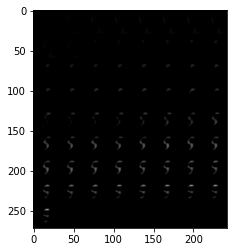

Epoch [178/400] Batch: [1/60] KL-Divergence: 0.02291029319167137 Cross-Entropy: 0.21496738493442535 Loss: 0.23787768185138702
Epoch [178/400] Batch: [2/60] KL-Divergence: 0.02222614362835884 Cross-Entropy: 0.2170487344264984 Loss: 0.23927487432956696
Epoch [178/400] Batch: [3/60] KL-Divergence: 0.022148557007312775 Cross-Entropy: 0.2174735814332962 Loss: 0.23962214589118958
Epoch [178/400] Batch: [4/60] KL-Divergence: 0.022710463032126427 Cross-Entropy: 0.214865580201149 Loss: 0.23757603764533997
Epoch [178/400] Batch: [5/60] KL-Divergence: 0.025438040494918823 Cross-Entropy: 0.21789032220840454 Loss: 0.24332836270332336
Epoch [178/400] Batch: [6/60] KL-Divergence: 0.02375856786966324 Cross-Entropy: 0.21939896047115326 Loss: 0.2431575357913971
Epoch [178/400] Batch: [7/60] KL-Divergence: 0.02305443212389946 Cross-Entropy: 0.21636538207530975 Loss: 0.2394198179244995
Epoch [178/400] Batch: [8/60] KL-Divergence: 0.023136122152209282 Cross-Entropy: 0.21370574831962585 Loss: 0.236841872334

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [178/400] Batch: [60/60] KL-Divergence: 0.023396849632263184 Cross-Entropy: 0.2260768860578537 Loss: 0.24947373569011688
Epoch [178/400] Batch: [60/60] KL-Divergence: 0.023396849632263184 Cross-Entropy: 0.2260768860578537 Loss: 0.24947373569011688


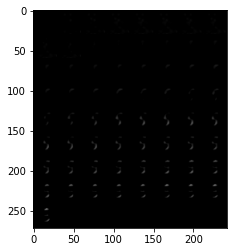

Epoch [179/400] Batch: [1/60] KL-Divergence: 0.021146751940250397 Cross-Entropy: 0.21595561504364014 Loss: 0.23710235953330994
Epoch [179/400] Batch: [2/60] KL-Divergence: 0.02086968719959259 Cross-Entropy: 0.2197587639093399 Loss: 0.2406284511089325
Epoch [179/400] Batch: [3/60] KL-Divergence: 0.022271333262324333 Cross-Entropy: 0.22035609185695648 Loss: 0.24262742698192596
Epoch [179/400] Batch: [4/60] KL-Divergence: 0.02232717163860798 Cross-Entropy: 0.21700556576251984 Loss: 0.23933273553848267
Epoch [179/400] Batch: [5/60] KL-Divergence: 0.023090409114956856 Cross-Entropy: 0.21994422376155853 Loss: 0.24303463101387024
Epoch [179/400] Batch: [6/60] KL-Divergence: 0.022635478526353836 Cross-Entropy: 0.22050872445106506 Loss: 0.2431441992521286
Epoch [179/400] Batch: [7/60] KL-Divergence: 0.02188553661108017 Cross-Entropy: 0.2181745320558548 Loss: 0.24006006121635437
Epoch [179/400] Batch: [8/60] KL-Divergence: 0.02219621278345585 Cross-Entropy: 0.21697987616062164 Loss: 0.2391760945

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [179/400] Batch: [60/60] KL-Divergence: 0.024254130199551582 Cross-Entropy: 0.22185039520263672 Loss: 0.24610452353954315
Epoch [179/400] Batch: [60/60] KL-Divergence: 0.024254130199551582 Cross-Entropy: 0.22185039520263672 Loss: 0.24610452353954315


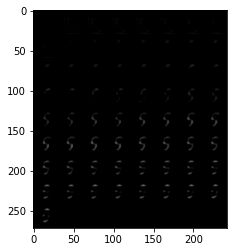

Epoch [180/400] Batch: [1/60] KL-Divergence: 0.02418379858136177 Cross-Entropy: 0.2146369367837906 Loss: 0.23882073163986206
Epoch [180/400] Batch: [2/60] KL-Divergence: 0.02271340787410736 Cross-Entropy: 0.21711355447769165 Loss: 0.239826962351799
Epoch [180/400] Batch: [3/60] KL-Divergence: 0.024187181144952774 Cross-Entropy: 0.21747030317783356 Loss: 0.24165748059749603
Epoch [180/400] Batch: [4/60] KL-Divergence: 0.023878922685980797 Cross-Entropy: 0.21407917141914368 Loss: 0.23795808851718903
Epoch [180/400] Batch: [5/60] KL-Divergence: 0.025289583951234818 Cross-Entropy: 0.2174081802368164 Loss: 0.24269776046276093
Epoch [180/400] Batch: [6/60] KL-Divergence: 0.02441072277724743 Cross-Entropy: 0.21915002167224884 Loss: 0.24356074631214142
Epoch [180/400] Batch: [7/60] KL-Divergence: 0.022443054243922234 Cross-Entropy: 0.21612559258937836 Loss: 0.23856864869594574
Epoch [180/400] Batch: [8/60] KL-Divergence: 0.02270526997745037 Cross-Entropy: 0.2139497697353363 Loss: 0.23665504157

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [180/400] Batch: [60/60] KL-Divergence: 0.021964706480503082 Cross-Entropy: 0.23627758026123047 Loss: 0.25824227929115295
Epoch [180/400] Batch: [60/60] KL-Divergence: 0.021964706480503082 Cross-Entropy: 0.23627758026123047 Loss: 0.25824227929115295


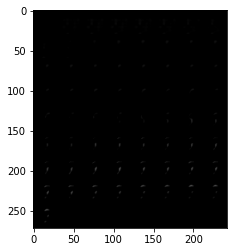

Epoch [181/400] Batch: [1/60] KL-Divergence: 0.02089957520365715 Cross-Entropy: 0.22796352207660675 Loss: 0.2488631010055542
Epoch [181/400] Batch: [2/60] KL-Divergence: 0.02139979973435402 Cross-Entropy: 0.22861160337924957 Loss: 0.2500114142894745
Epoch [181/400] Batch: [3/60] KL-Divergence: 0.020440377295017242 Cross-Entropy: 0.22934438288211823 Loss: 0.24978476762771606
Epoch [181/400] Batch: [4/60] KL-Divergence: 0.019374435767531395 Cross-Entropy: 0.2255077213048935 Loss: 0.24488215148448944
Epoch [181/400] Batch: [5/60] KL-Divergence: 0.02148871123790741 Cross-Entropy: 0.2302403301000595 Loss: 0.2517290413379669
Epoch [181/400] Batch: [6/60] KL-Divergence: 0.02112756296992302 Cross-Entropy: 0.2304435670375824 Loss: 0.2515711188316345
Epoch [181/400] Batch: [7/60] KL-Divergence: 0.020082222297787666 Cross-Entropy: 0.22591449320316315 Loss: 0.24599671363830566
Epoch [181/400] Batch: [8/60] KL-Divergence: 0.021347293630242348 Cross-Entropy: 0.22245758771896362 Loss: 0.2438048869371

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [181/400] Batch: [60/60] KL-Divergence: 0.02487984299659729 Cross-Entropy: 0.2233770191669464 Loss: 0.2482568621635437
Epoch [181/400] Batch: [60/60] KL-Divergence: 0.02487984299659729 Cross-Entropy: 0.2233770191669464 Loss: 0.2482568621635437


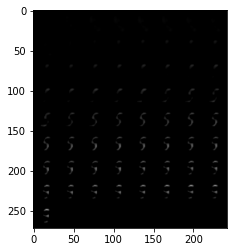

Epoch [182/400] Batch: [1/60] KL-Divergence: 0.023192279040813446 Cross-Entropy: 0.21541042625904083 Loss: 0.23860269784927368
Epoch [182/400] Batch: [2/60] KL-Divergence: 0.02244463376700878 Cross-Entropy: 0.21747682988643646 Loss: 0.2399214655160904
Epoch [182/400] Batch: [3/60] KL-Divergence: 0.02214178629219532 Cross-Entropy: 0.2180793136358261 Loss: 0.24022109806537628
Epoch [182/400] Batch: [4/60] KL-Divergence: 0.02186855673789978 Cross-Entropy: 0.2154659479856491 Loss: 0.2373345047235489
Epoch [182/400] Batch: [5/60] KL-Divergence: 0.02256149798631668 Cross-Entropy: 0.22003531455993652 Loss: 0.2425968050956726
Epoch [182/400] Batch: [6/60] KL-Divergence: 0.02302876114845276 Cross-Entropy: 0.22077901661396027 Loss: 0.24380777776241302
Epoch [182/400] Batch: [7/60] KL-Divergence: 0.0226106196641922 Cross-Entropy: 0.21806052327156067 Loss: 0.24067114293575287
Epoch [182/400] Batch: [8/60] KL-Divergence: 0.022523531690239906 Cross-Entropy: 0.21534186601638794 Loss: 0.23786540329456

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [182/400] Batch: [60/60] KL-Divergence: 0.024274472147226334 Cross-Entropy: 0.222603902220726 Loss: 0.24687837064266205
Epoch [182/400] Batch: [60/60] KL-Divergence: 0.024274472147226334 Cross-Entropy: 0.222603902220726 Loss: 0.24687837064266205


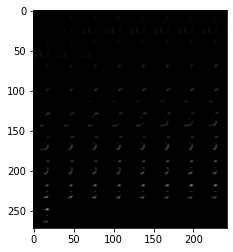

Epoch [183/400] Batch: [1/60] KL-Divergence: 0.02340969629585743 Cross-Entropy: 0.21384549140930176 Loss: 0.23725518584251404
Epoch [183/400] Batch: [2/60] KL-Divergence: 0.023639364168047905 Cross-Entropy: 0.2160264253616333 Loss: 0.23966579139232635
Epoch [183/400] Batch: [3/60] KL-Divergence: 0.023839931935071945 Cross-Entropy: 0.2165200412273407 Loss: 0.24035997688770294
Epoch [183/400] Batch: [4/60] KL-Divergence: 0.022441701963543892 Cross-Entropy: 0.21307426691055298 Loss: 0.23551596701145172
Epoch [183/400] Batch: [5/60] KL-Divergence: 0.024059239774942398 Cross-Entropy: 0.21783648431301117 Loss: 0.24189572036266327
Epoch [183/400] Batch: [6/60] KL-Divergence: 0.024374477565288544 Cross-Entropy: 0.21815834939479828 Loss: 0.24253281950950623
Epoch [183/400] Batch: [7/60] KL-Divergence: 0.023876968771219254 Cross-Entropy: 0.21653279662132263 Loss: 0.2404097616672516
Epoch [183/400] Batch: [8/60] KL-Divergence: 0.023025961592793465 Cross-Entropy: 0.212992861866951 Loss: 0.23601882

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [183/400] Batch: [60/60] KL-Divergence: 0.024463918060064316 Cross-Entropy: 0.22092577815055847 Loss: 0.24538969993591309
Epoch [183/400] Batch: [60/60] KL-Divergence: 0.024463918060064316 Cross-Entropy: 0.22092577815055847 Loss: 0.24538969993591309


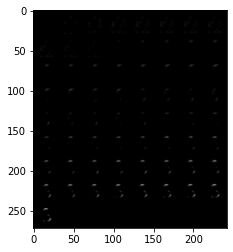

Epoch [184/400] Batch: [1/60] KL-Divergence: 0.024170033633708954 Cross-Entropy: 0.21291178464889526 Loss: 0.23708182573318481
Epoch [184/400] Batch: [2/60] KL-Divergence: 0.02500164322555065 Cross-Entropy: 0.21583934128284454 Loss: 0.24084098637104034
Epoch [184/400] Batch: [3/60] KL-Divergence: 0.024128373712301254 Cross-Entropy: 0.21600204706192017 Loss: 0.24013042449951172
Epoch [184/400] Batch: [4/60] KL-Divergence: 0.02478458359837532 Cross-Entropy: 0.21367742121219635 Loss: 0.23846200108528137
Epoch [184/400] Batch: [5/60] KL-Divergence: 0.025569075718522072 Cross-Entropy: 0.21733424067497253 Loss: 0.24290332198143005
Epoch [184/400] Batch: [6/60] KL-Divergence: 0.024375833570957184 Cross-Entropy: 0.2165256291627884 Loss: 0.24090147018432617
Epoch [184/400] Batch: [7/60] KL-Divergence: 0.023618055507540703 Cross-Entropy: 0.2145339548587799 Loss: 0.23815201222896576
Epoch [184/400] Batch: [8/60] KL-Divergence: 0.024309257045388222 Cross-Entropy: 0.2127278745174408 Loss: 0.2370371

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [184/400] Batch: [60/60] KL-Divergence: 0.02463424950838089 Cross-Entropy: 0.2206030637025833 Loss: 0.2452373206615448
Epoch [184/400] Batch: [60/60] KL-Divergence: 0.02463424950838089 Cross-Entropy: 0.2206030637025833 Loss: 0.2452373206615448


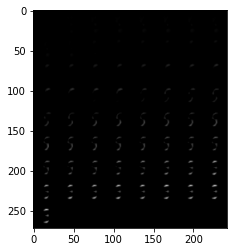

Epoch [185/400] Batch: [1/60] KL-Divergence: 0.02352556400001049 Cross-Entropy: 0.21229594945907593 Loss: 0.23582151532173157
Epoch [185/400] Batch: [2/60] KL-Divergence: 0.0233630258589983 Cross-Entropy: 0.21532182395458221 Loss: 0.23868484795093536
Epoch [185/400] Batch: [3/60] KL-Divergence: 0.023490672931075096 Cross-Entropy: 0.2154771089553833 Loss: 0.23896777629852295
Epoch [185/400] Batch: [4/60] KL-Divergence: 0.023694081231951714 Cross-Entropy: 0.21224059164524078 Loss: 0.23593467473983765
Epoch [185/400] Batch: [5/60] KL-Divergence: 0.025806639343500137 Cross-Entropy: 0.21730424463748932 Loss: 0.24311088025569916
Epoch [185/400] Batch: [6/60] KL-Divergence: 0.025951186195015907 Cross-Entropy: 0.21838533878326416 Loss: 0.24433653056621552
Epoch [185/400] Batch: [7/60] KL-Divergence: 0.02381311170756817 Cross-Entropy: 0.21446311473846436 Loss: 0.23827622830867767
Epoch [185/400] Batch: [8/60] KL-Divergence: 0.024185845628380775 Cross-Entropy: 0.21132247149944305 Loss: 0.2355083

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [185/400] Batch: [60/60] KL-Divergence: 0.024033134803175926 Cross-Entropy: 0.22162902355194092 Loss: 0.2456621527671814
Epoch [185/400] Batch: [60/60] KL-Divergence: 0.024033134803175926 Cross-Entropy: 0.22162902355194092 Loss: 0.2456621527671814


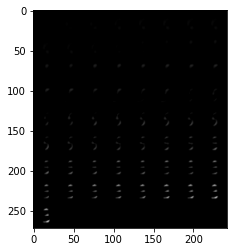

Epoch [186/400] Batch: [1/60] KL-Divergence: 0.02412334457039833 Cross-Entropy: 0.21470893919467926 Loss: 0.2388322800397873
Epoch [186/400] Batch: [2/60] KL-Divergence: 0.02269056625664234 Cross-Entropy: 0.21586363017559052 Loss: 0.2385541945695877
Epoch [186/400] Batch: [3/60] KL-Divergence: 0.023858681321144104 Cross-Entropy: 0.2165258675813675 Loss: 0.2403845489025116
Epoch [186/400] Batch: [4/60] KL-Divergence: 0.023490136489272118 Cross-Entropy: 0.21278135478496552 Loss: 0.23627148568630219
Epoch [186/400] Batch: [5/60] KL-Divergence: 0.02460501343011856 Cross-Entropy: 0.21797654032707214 Loss: 0.2425815463066101
Epoch [186/400] Batch: [6/60] KL-Divergence: 0.023120833560824394 Cross-Entropy: 0.21774329245090485 Loss: 0.2408641278743744
Epoch [186/400] Batch: [7/60] KL-Divergence: 0.02313128300011158 Cross-Entropy: 0.2163899838924408 Loss: 0.23952126502990723
Epoch [186/400] Batch: [8/60] KL-Divergence: 0.02295912802219391 Cross-Entropy: 0.21372799575328827 Loss: 0.23668712377548

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [186/400] Batch: [60/60] KL-Divergence: 0.02544488199055195 Cross-Entropy: 0.22053450345993042 Loss: 0.24597938358783722
Epoch [186/400] Batch: [60/60] KL-Divergence: 0.02544488199055195 Cross-Entropy: 0.22053450345993042 Loss: 0.24597938358783722


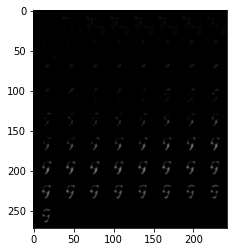

Epoch [187/400] Batch: [1/60] KL-Divergence: 0.025208359584212303 Cross-Entropy: 0.21179376542568207 Loss: 0.23700211942195892
Epoch [187/400] Batch: [2/60] KL-Divergence: 0.02345772087574005 Cross-Entropy: 0.21354901790618896 Loss: 0.23700673878192902
Epoch [187/400] Batch: [3/60] KL-Divergence: 0.02477911487221718 Cross-Entropy: 0.21322935819625854 Loss: 0.23800846934318542
Epoch [187/400] Batch: [4/60] KL-Divergence: 0.024441296234726906 Cross-Entropy: 0.2110266238451004 Loss: 0.23546792566776276
Epoch [187/400] Batch: [5/60] KL-Divergence: 0.025241363793611526 Cross-Entropy: 0.21564866602420807 Loss: 0.2408900260925293
Epoch [187/400] Batch: [6/60] KL-Divergence: 0.02463548257946968 Cross-Entropy: 0.2164522260427475 Loss: 0.24108770489692688
Epoch [187/400] Batch: [7/60] KL-Divergence: 0.02476770617067814 Cross-Entropy: 0.2136358767747879 Loss: 0.2384035885334015
Epoch [187/400] Batch: [8/60] KL-Divergence: 0.023627225309610367 Cross-Entropy: 0.21276988089084625 Loss: 0.23639710247

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [187/400] Batch: [60/60] KL-Divergence: 0.024027151986956596 Cross-Entropy: 0.21985995769500732 Loss: 0.24388711154460907
Epoch [187/400] Batch: [60/60] KL-Divergence: 0.024027151986956596 Cross-Entropy: 0.21985995769500732 Loss: 0.24388711154460907


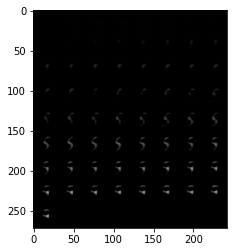

Epoch [188/400] Batch: [1/60] KL-Divergence: 0.023738354444503784 Cross-Entropy: 0.21286171674728394 Loss: 0.23660007119178772
Epoch [188/400] Batch: [2/60] KL-Divergence: 0.024262726306915283 Cross-Entropy: 0.21482093632221222 Loss: 0.2390836626291275
Epoch [188/400] Batch: [3/60] KL-Divergence: 0.02503363788127899 Cross-Entropy: 0.21500836312770844 Loss: 0.24004200100898743
Epoch [188/400] Batch: [4/60] KL-Divergence: 0.025029851123690605 Cross-Entropy: 0.21139006316661835 Loss: 0.2364199161529541
Epoch [188/400] Batch: [5/60] KL-Divergence: 0.025771399959921837 Cross-Entropy: 0.21551987528800964 Loss: 0.24129126965999603
Epoch [188/400] Batch: [6/60] KL-Divergence: 0.025423815473914146 Cross-Entropy: 0.216185063123703 Loss: 0.2416088730096817
Epoch [188/400] Batch: [7/60] KL-Divergence: 0.024368295446038246 Cross-Entropy: 0.2125939428806305 Loss: 0.2369622439146042
Epoch [188/400] Batch: [8/60] KL-Divergence: 0.024118460714817047 Cross-Entropy: 0.21116772294044495 Loss: 0.2352861762

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [188/400] Batch: [60/60] KL-Divergence: 0.02532491646707058 Cross-Entropy: 0.21844162046909332 Loss: 0.24376653134822845
Epoch [188/400] Batch: [60/60] KL-Divergence: 0.02532491646707058 Cross-Entropy: 0.21844162046909332 Loss: 0.24376653134822845


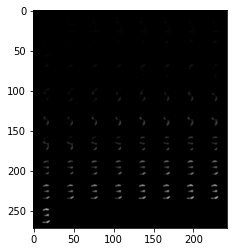

Epoch [189/400] Batch: [1/60] KL-Divergence: 0.02563062496483326 Cross-Entropy: 0.21123476326465607 Loss: 0.23686538636684418
Epoch [189/400] Batch: [2/60] KL-Divergence: 0.025750473141670227 Cross-Entropy: 0.21388009190559387 Loss: 0.2396305650472641
Epoch [189/400] Batch: [3/60] KL-Divergence: 0.026266181841492653 Cross-Entropy: 0.21383066475391388 Loss: 0.24009685218334198
Epoch [189/400] Batch: [4/60] KL-Divergence: 0.025875059887766838 Cross-Entropy: 0.2115873396396637 Loss: 0.23746240139007568
Epoch [189/400] Batch: [5/60] KL-Divergence: 0.02652554400265217 Cross-Entropy: 0.21339356899261475 Loss: 0.23991911113262177
Epoch [189/400] Batch: [6/60] KL-Divergence: 0.024872709065675735 Cross-Entropy: 0.21413077414035797 Loss: 0.2390034794807434
Epoch [189/400] Batch: [7/60] KL-Divergence: 0.024378033354878426 Cross-Entropy: 0.213688924908638 Loss: 0.23806695640087128
Epoch [189/400] Batch: [8/60] KL-Divergence: 0.02446509525179863 Cross-Entropy: 0.21062758564949036 Loss: 0.2350926846

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [189/400] Batch: [60/60] KL-Divergence: 0.026185985654592514 Cross-Entropy: 0.21774964034557343 Loss: 0.24393562972545624
Epoch [189/400] Batch: [60/60] KL-Divergence: 0.026185985654592514 Cross-Entropy: 0.21774964034557343 Loss: 0.24393562972545624


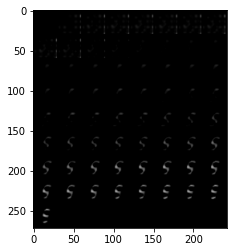

Epoch [190/400] Batch: [1/60] KL-Divergence: 0.025635825470089912 Cross-Entropy: 0.2110123485326767 Loss: 0.23664817214012146
Epoch [190/400] Batch: [2/60] KL-Divergence: 0.024998024106025696 Cross-Entropy: 0.2128627598285675 Loss: 0.2378607839345932
Epoch [190/400] Batch: [3/60] KL-Divergence: 0.02591189183294773 Cross-Entropy: 0.21270249783992767 Loss: 0.23861439526081085
Epoch [190/400] Batch: [4/60] KL-Divergence: 0.02493499405682087 Cross-Entropy: 0.20844924449920654 Loss: 0.23338423669338226
Epoch [190/400] Batch: [5/60] KL-Divergence: 0.0277231577783823 Cross-Entropy: 0.2143382430076599 Loss: 0.24206140637397766
Epoch [190/400] Batch: [6/60] KL-Divergence: 0.02596655674278736 Cross-Entropy: 0.2149289846420288 Loss: 0.24089553952217102
Epoch [190/400] Batch: [7/60] KL-Divergence: 0.02411031723022461 Cross-Entropy: 0.21151793003082275 Loss: 0.23562824726104736
Epoch [190/400] Batch: [8/60] KL-Divergence: 0.02457723580300808 Cross-Entropy: 0.20918074250221252 Loss: 0.23375797271728

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [190/400] Batch: [60/60] KL-Divergence: 0.02533731795847416 Cross-Entropy: 0.218874990940094 Loss: 0.2442123144865036
Epoch [190/400] Batch: [60/60] KL-Divergence: 0.02533731795847416 Cross-Entropy: 0.218874990940094 Loss: 0.2442123144865036


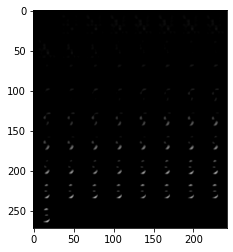

Epoch [191/400] Batch: [1/60] KL-Divergence: 0.025423383340239525 Cross-Entropy: 0.20962610840797424 Loss: 0.23504948616027832
Epoch [191/400] Batch: [2/60] KL-Divergence: 0.02519146353006363 Cross-Entropy: 0.212771475315094 Loss: 0.23796293139457703
Epoch [191/400] Batch: [3/60] KL-Divergence: 0.025115707889199257 Cross-Entropy: 0.21262045204639435 Loss: 0.23773616552352905
Epoch [191/400] Batch: [4/60] KL-Divergence: 0.025921940803527832 Cross-Entropy: 0.2101646065711975 Loss: 0.23608654737472534
Epoch [191/400] Batch: [5/60] KL-Divergence: 0.026185167953372 Cross-Entropy: 0.21392178535461426 Loss: 0.2401069551706314
Epoch [191/400] Batch: [6/60] KL-Divergence: 0.024598315358161926 Cross-Entropy: 0.21519707143306732 Loss: 0.23979538679122925
Epoch [191/400] Batch: [7/60] KL-Divergence: 0.025272734463214874 Cross-Entropy: 0.212943434715271 Loss: 0.23821616172790527
Epoch [191/400] Batch: [8/60] KL-Divergence: 0.02359466254711151 Cross-Entropy: 0.2103707641363144 Loss: 0.23396542668342

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [191/400] Batch: [60/60] KL-Divergence: 0.02345365658402443 Cross-Entropy: 0.22220478951931 Loss: 0.24565844237804413
Epoch [191/400] Batch: [60/60] KL-Divergence: 0.02345365658402443 Cross-Entropy: 0.22220478951931 Loss: 0.24565844237804413


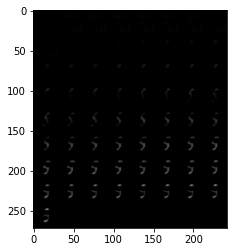

Epoch [192/400] Batch: [1/60] KL-Divergence: 0.02384577877819538 Cross-Entropy: 0.2160363644361496 Loss: 0.23988214135169983
Epoch [192/400] Batch: [2/60] KL-Divergence: 0.02374950610101223 Cross-Entropy: 0.21664005517959595 Loss: 0.24038955569267273
Epoch [192/400] Batch: [3/60] KL-Divergence: 0.023470893502235413 Cross-Entropy: 0.2185860276222229 Loss: 0.2420569211244583
Epoch [192/400] Batch: [4/60] KL-Divergence: 0.02379262074828148 Cross-Entropy: 0.21422235667705536 Loss: 0.23801498115062714
Epoch [192/400] Batch: [5/60] KL-Divergence: 0.025603841990232468 Cross-Entropy: 0.21935145556926727 Loss: 0.24495530128479004
Epoch [192/400] Batch: [6/60] KL-Divergence: 0.024956976994872093 Cross-Entropy: 0.21820557117462158 Loss: 0.24316254258155823
Epoch [192/400] Batch: [7/60] KL-Divergence: 0.024236556142568588 Cross-Entropy: 0.21474261581897736 Loss: 0.23897917568683624
Epoch [192/400] Batch: [8/60] KL-Divergence: 0.02467590942978859 Cross-Entropy: 0.21230092644691467 Loss: 0.236976832

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [192/400] Batch: [60/60] KL-Divergence: 0.025087088346481323 Cross-Entropy: 0.2176029086112976 Loss: 0.24268999695777893
Epoch [192/400] Batch: [60/60] KL-Divergence: 0.025087088346481323 Cross-Entropy: 0.2176029086112976 Loss: 0.24268999695777893


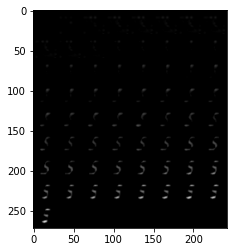

Epoch [193/400] Batch: [1/60] KL-Divergence: 0.02623344585299492 Cross-Entropy: 0.21193291246891022 Loss: 0.23816636204719543
Epoch [193/400] Batch: [2/60] KL-Divergence: 0.02518853358924389 Cross-Entropy: 0.21362212300300598 Loss: 0.23881065845489502
Epoch [193/400] Batch: [3/60] KL-Divergence: 0.026333581656217575 Cross-Entropy: 0.2130792886018753 Loss: 0.23941287398338318
Epoch [193/400] Batch: [4/60] KL-Divergence: 0.02760935388505459 Cross-Entropy: 0.2103346586227417 Loss: 0.23794400691986084
Epoch [193/400] Batch: [5/60] KL-Divergence: 0.027008524164557457 Cross-Entropy: 0.21344128251075745 Loss: 0.24044980108737946
Epoch [193/400] Batch: [6/60] KL-Divergence: 0.026750119403004646 Cross-Entropy: 0.2154267281293869 Loss: 0.2421768456697464
Epoch [193/400] Batch: [7/60] KL-Divergence: 0.0266589242964983 Cross-Entropy: 0.2122511863708496 Loss: 0.23891010880470276
Epoch [193/400] Batch: [8/60] KL-Divergence: 0.02550254762172699 Cross-Entropy: 0.21164466440677643 Loss: 0.2371472120285

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [193/400] Batch: [60/60] KL-Divergence: 0.026704978197813034 Cross-Entropy: 0.21894465386867523 Loss: 0.24564963579177856
Epoch [193/400] Batch: [60/60] KL-Divergence: 0.026704978197813034 Cross-Entropy: 0.21894465386867523 Loss: 0.24564963579177856


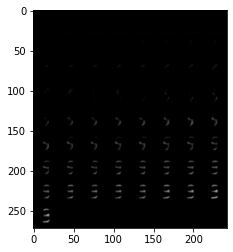

Epoch [194/400] Batch: [1/60] KL-Divergence: 0.02505526877939701 Cross-Entropy: 0.20923475921154022 Loss: 0.23429003357887268
Epoch [194/400] Batch: [2/60] KL-Divergence: 0.024628041312098503 Cross-Entropy: 0.21189157664775848 Loss: 0.23651961982250214
Epoch [194/400] Batch: [3/60] KL-Divergence: 0.025814799591898918 Cross-Entropy: 0.21280188858509064 Loss: 0.2386166900396347
Epoch [194/400] Batch: [4/60] KL-Divergence: 0.025705697014927864 Cross-Entropy: 0.20921649038791656 Loss: 0.23492218554019928
Epoch [194/400] Batch: [5/60] KL-Divergence: 0.027067899703979492 Cross-Entropy: 0.21244174242019653 Loss: 0.23950964212417603
Epoch [194/400] Batch: [6/60] KL-Divergence: 0.02467299811542034 Cross-Entropy: 0.21394546329975128 Loss: 0.23861846327781677
Epoch [194/400] Batch: [7/60] KL-Divergence: 0.025981923565268517 Cross-Entropy: 0.21065250039100647 Loss: 0.23663441836833954
Epoch [194/400] Batch: [8/60] KL-Divergence: 0.024688422679901123 Cross-Entropy: 0.20847885310649872 Loss: 0.23316

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [194/400] Batch: [60/60] KL-Divergence: 0.025915179401636124 Cross-Entropy: 0.21708333492279053 Loss: 0.24299851059913635
Epoch [194/400] Batch: [60/60] KL-Divergence: 0.025915179401636124 Cross-Entropy: 0.21708333492279053 Loss: 0.24299851059913635


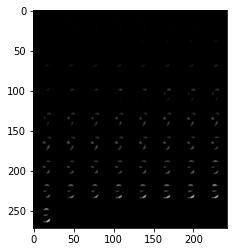

Epoch [195/400] Batch: [1/60] KL-Divergence: 0.026063010096549988 Cross-Entropy: 0.20846675336360931 Loss: 0.2345297634601593
Epoch [195/400] Batch: [2/60] KL-Divergence: 0.024897661060094833 Cross-Entropy: 0.21111036837100983 Loss: 0.23600803315639496
Epoch [195/400] Batch: [3/60] KL-Divergence: 0.0253413375467062 Cross-Entropy: 0.2116270661354065 Loss: 0.23696839809417725
Epoch [195/400] Batch: [4/60] KL-Divergence: 0.02583225816488266 Cross-Entropy: 0.20875956118106842 Loss: 0.23459181189537048
Epoch [195/400] Batch: [5/60] KL-Divergence: 0.026820041239261627 Cross-Entropy: 0.21291425824165344 Loss: 0.23973429203033447
Epoch [195/400] Batch: [6/60] KL-Divergence: 0.026849882677197456 Cross-Entropy: 0.21393071115016937 Loss: 0.24078059196472168
Epoch [195/400] Batch: [7/60] KL-Divergence: 0.024841606616973877 Cross-Entropy: 0.20938928425312042 Loss: 0.2342308908700943
Epoch [195/400] Batch: [8/60] KL-Divergence: 0.026007728651165962 Cross-Entropy: 0.2088802307844162 Loss: 0.234887957

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [195/400] Batch: [60/60] KL-Divergence: 0.027132941409945488 Cross-Entropy: 0.21639201045036316 Loss: 0.2435249537229538
Epoch [195/400] Batch: [60/60] KL-Divergence: 0.027132941409945488 Cross-Entropy: 0.21639201045036316 Loss: 0.2435249537229538


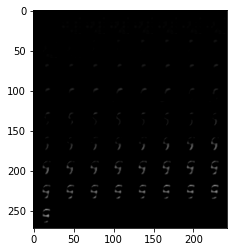

Epoch [196/400] Batch: [1/60] KL-Divergence: 0.027217790484428406 Cross-Entropy: 0.20846498012542725 Loss: 0.23568277060985565
Epoch [196/400] Batch: [2/60] KL-Divergence: 0.025953486561775208 Cross-Entropy: 0.21030917763710022 Loss: 0.23626266419887543
Epoch [196/400] Batch: [3/60] KL-Divergence: 0.027485625818371773 Cross-Entropy: 0.21062211692333221 Loss: 0.23810774087905884
Epoch [196/400] Batch: [4/60] KL-Divergence: 0.026704220101237297 Cross-Entropy: 0.2094053328037262 Loss: 0.23610955476760864
Epoch [196/400] Batch: [5/60] KL-Divergence: 0.027609556913375854 Cross-Entropy: 0.2116142362356186 Loss: 0.23922379314899445
Epoch [196/400] Batch: [6/60] KL-Divergence: 0.027596522122621536 Cross-Entropy: 0.2131561040878296 Loss: 0.24075262248516083
Epoch [196/400] Batch: [7/60] KL-Divergence: 0.02554328553378582 Cross-Entropy: 0.2099296748638153 Loss: 0.23547296226024628
Epoch [196/400] Batch: [8/60] KL-Divergence: 0.02592949941754341 Cross-Entropy: 0.20940229296684265 Loss: 0.23533178

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [196/400] Batch: [60/60] KL-Divergence: 0.026743261143565178 Cross-Entropy: 0.21689356863498688 Loss: 0.2436368316411972
Epoch [196/400] Batch: [60/60] KL-Divergence: 0.026743261143565178 Cross-Entropy: 0.21689356863498688 Loss: 0.2436368316411972


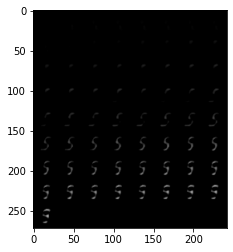

Epoch [197/400] Batch: [1/60] KL-Divergence: 0.026219848543405533 Cross-Entropy: 0.20943908393383026 Loss: 0.2356589287519455
Epoch [197/400] Batch: [2/60] KL-Divergence: 0.025758227333426476 Cross-Entropy: 0.21258746087551117 Loss: 0.2383456826210022
Epoch [197/400] Batch: [3/60] KL-Divergence: 0.02594395913183689 Cross-Entropy: 0.21135134994983673 Loss: 0.23729531466960907
Epoch [197/400] Batch: [4/60] KL-Divergence: 0.026363886892795563 Cross-Entropy: 0.20761379599571228 Loss: 0.23397767543792725
Epoch [197/400] Batch: [5/60] KL-Divergence: 0.027811361476778984 Cross-Entropy: 0.21189281344413757 Loss: 0.2397041767835617
Epoch [197/400] Batch: [6/60] KL-Divergence: 0.026360148563981056 Cross-Entropy: 0.21410492062568665 Loss: 0.24046507477760315
Epoch [197/400] Batch: [7/60] KL-Divergence: 0.025769369676709175 Cross-Entropy: 0.20984166860580444 Loss: 0.23561103641986847
Epoch [197/400] Batch: [8/60] KL-Divergence: 0.025353852659463882 Cross-Entropy: 0.20952406525611877 Loss: 0.234877

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [197/400] Batch: [60/60] KL-Divergence: 0.026005376130342484 Cross-Entropy: 0.2153491973876953 Loss: 0.2413545697927475
Epoch [197/400] Batch: [60/60] KL-Divergence: 0.026005376130342484 Cross-Entropy: 0.2153491973876953 Loss: 0.2413545697927475


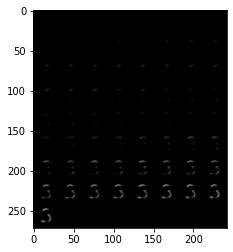

Epoch [198/400] Batch: [1/60] KL-Divergence: 0.027188997715711594 Cross-Entropy: 0.20819102227687836 Loss: 0.23538002371788025
Epoch [198/400] Batch: [2/60] KL-Divergence: 0.025336194783449173 Cross-Entropy: 0.20968051254749298 Loss: 0.23501670360565186
Epoch [198/400] Batch: [3/60] KL-Divergence: 0.025833899155259132 Cross-Entropy: 0.210209459066391 Loss: 0.23604336380958557
Epoch [198/400] Batch: [4/60] KL-Divergence: 0.026539688929915428 Cross-Entropy: 0.2083444446325302 Loss: 0.2348841279745102
Epoch [198/400] Batch: [5/60] KL-Divergence: 0.028093161061406136 Cross-Entropy: 0.21175740659236908 Loss: 0.23985056579113007
Epoch [198/400] Batch: [6/60] KL-Divergence: 0.027202140539884567 Cross-Entropy: 0.2122843712568283 Loss: 0.23948651552200317
Epoch [198/400] Batch: [7/60] KL-Divergence: 0.026604650542140007 Cross-Entropy: 0.20922710001468658 Loss: 0.23583175241947174
Epoch [198/400] Batch: [8/60] KL-Divergence: 0.0249337051063776 Cross-Entropy: 0.207132950425148 Loss: 0.23206666111

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [198/400] Batch: [60/60] KL-Divergence: 0.02613012120127678 Cross-Entropy: 0.2154497355222702 Loss: 0.24157986044883728
Epoch [198/400] Batch: [60/60] KL-Divergence: 0.02613012120127678 Cross-Entropy: 0.2154497355222702 Loss: 0.24157986044883728


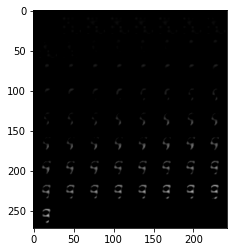

Epoch [199/400] Batch: [1/60] KL-Divergence: 0.028403256088495255 Cross-Entropy: 0.20720110833644867 Loss: 0.23560436069965363
Epoch [199/400] Batch: [2/60] KL-Divergence: 0.026779696345329285 Cross-Entropy: 0.2112753838300705 Loss: 0.23805508017539978
Epoch [199/400] Batch: [3/60] KL-Divergence: 0.027352087199687958 Cross-Entropy: 0.2101815938949585 Loss: 0.23753368854522705
Epoch [199/400] Batch: [4/60] KL-Divergence: 0.02640540525317192 Cross-Entropy: 0.20691564679145813 Loss: 0.23332105576992035
Epoch [199/400] Batch: [5/60] KL-Divergence: 0.027875732630491257 Cross-Entropy: 0.21146786212921143 Loss: 0.23934359848499298
Epoch [199/400] Batch: [6/60] KL-Divergence: 0.025934286415576935 Cross-Entropy: 0.21156643331050873 Loss: 0.23750072717666626
Epoch [199/400] Batch: [7/60] KL-Divergence: 0.02671513892710209 Cross-Entropy: 0.20873954892158508 Loss: 0.23545469343662262
Epoch [199/400] Batch: [8/60] KL-Divergence: 0.026664353907108307 Cross-Entropy: 0.20782050490379333 Loss: 0.234484

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [199/400] Batch: [60/60] KL-Divergence: 0.027215437963604927 Cross-Entropy: 0.21571499109268188 Loss: 0.24293042719364166
Epoch [199/400] Batch: [60/60] KL-Divergence: 0.027215437963604927 Cross-Entropy: 0.21571499109268188 Loss: 0.24293042719364166


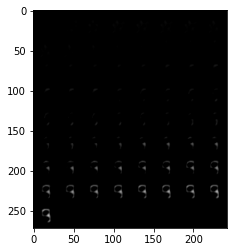

Epoch [200/400] Batch: [1/60] KL-Divergence: 0.027077674865722656 Cross-Entropy: 0.20681773126125336 Loss: 0.233895406126976
Epoch [200/400] Batch: [2/60] KL-Divergence: 0.027682095766067505 Cross-Entropy: 0.20979104936122894 Loss: 0.23747314512729645
Epoch [200/400] Batch: [3/60] KL-Divergence: 0.027565984055399895 Cross-Entropy: 0.20867298543453217 Loss: 0.2362389713525772
Epoch [200/400] Batch: [4/60] KL-Divergence: 0.02712520956993103 Cross-Entropy: 0.20772099494934082 Loss: 0.23484620451927185
Epoch [200/400] Batch: [5/60] KL-Divergence: 0.028643375262618065 Cross-Entropy: 0.20956824719905853 Loss: 0.23821161687374115
Epoch [200/400] Batch: [6/60] KL-Divergence: 0.027726391330361366 Cross-Entropy: 0.21138742566108704 Loss: 0.23911382257938385
Epoch [200/400] Batch: [7/60] KL-Divergence: 0.026905275881290436 Cross-Entropy: 0.21018365025520325 Loss: 0.23708891868591309
Epoch [200/400] Batch: [8/60] KL-Divergence: 0.026344673708081245 Cross-Entropy: 0.20836174488067627 Loss: 0.234706

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [200/400] Batch: [60/60] KL-Divergence: 0.027687208727002144 Cross-Entropy: 0.21548086404800415 Loss: 0.24316807091236115
Epoch [200/400] Batch: [60/60] KL-Divergence: 0.027687208727002144 Cross-Entropy: 0.21548086404800415 Loss: 0.24316807091236115


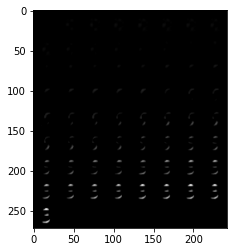

Epoch [201/400] Batch: [1/60] KL-Divergence: 0.026189852505922318 Cross-Entropy: 0.20719845592975616 Loss: 0.23338830471038818
Epoch [201/400] Batch: [2/60] KL-Divergence: 0.02681851014494896 Cross-Entropy: 0.20902471244335175 Loss: 0.235843226313591
Epoch [201/400] Batch: [3/60] KL-Divergence: 0.028487887233495712 Cross-Entropy: 0.20884159207344055 Loss: 0.23732948303222656
Epoch [201/400] Batch: [4/60] KL-Divergence: 0.02812861278653145 Cross-Entropy: 0.20560860633850098 Loss: 0.23373721539974213
Epoch [201/400] Batch: [5/60] KL-Divergence: 0.030971791595220566 Cross-Entropy: 0.2094162404537201 Loss: 0.24038803577423096
Epoch [201/400] Batch: [6/60] KL-Divergence: 0.028513522818684578 Cross-Entropy: 0.21020793914794922 Loss: 0.23872146010398865
Epoch [201/400] Batch: [7/60] KL-Divergence: 0.027655214071273804 Cross-Entropy: 0.20724767446517944 Loss: 0.23490288853645325
Epoch [201/400] Batch: [8/60] KL-Divergence: 0.027123553678393364 Cross-Entropy: 0.20767717063426971 Loss: 0.2348007

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [201/400] Batch: [60/60] KL-Divergence: 0.026775741949677467 Cross-Entropy: 0.21504709124565125 Loss: 0.24182283878326416
Epoch [201/400] Batch: [60/60] KL-Divergence: 0.026775741949677467 Cross-Entropy: 0.21504709124565125 Loss: 0.24182283878326416


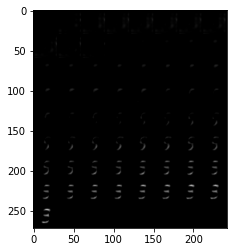

Epoch [202/400] Batch: [1/60] KL-Divergence: 0.027903525158762932 Cross-Entropy: 0.20687894523143768 Loss: 0.23478247225284576
Epoch [202/400] Batch: [2/60] KL-Divergence: 0.027464531362056732 Cross-Entropy: 0.20834077894687653 Loss: 0.23580530285835266
Epoch [202/400] Batch: [3/60] KL-Divergence: 0.028501339256763458 Cross-Entropy: 0.2081785500049591 Loss: 0.23667988181114197
Epoch [202/400] Batch: [4/60] KL-Divergence: 0.028352567926049232 Cross-Entropy: 0.20582464337348938 Loss: 0.23417721688747406
Epoch [202/400] Batch: [5/60] KL-Divergence: 0.0300552137196064 Cross-Entropy: 0.2106846570968628 Loss: 0.2407398670911789
Epoch [202/400] Batch: [6/60] KL-Divergence: 0.027832504361867905 Cross-Entropy: 0.2100018858909607 Loss: 0.2378343939781189
Epoch [202/400] Batch: [7/60] KL-Divergence: 0.026484500616788864 Cross-Entropy: 0.20719334483146667 Loss: 0.23367784917354584
Epoch [202/400] Batch: [8/60] KL-Divergence: 0.02596735581755638 Cross-Entropy: 0.20652765035629272 Loss: 0.2324950098

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [202/400] Batch: [60/60] KL-Divergence: 0.02443622052669525 Cross-Entropy: 0.2219589501619339 Loss: 0.24639517068862915
Epoch [202/400] Batch: [60/60] KL-Divergence: 0.02443622052669525 Cross-Entropy: 0.2219589501619339 Loss: 0.24639517068862915


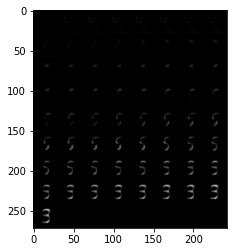

Epoch [203/400] Batch: [1/60] KL-Divergence: 0.024118293076753616 Cross-Entropy: 0.21235622465610504 Loss: 0.23647451400756836
Epoch [203/400] Batch: [2/60] KL-Divergence: 0.02433370053768158 Cross-Entropy: 0.21450412273406982 Loss: 0.2388378232717514
Epoch [203/400] Batch: [3/60] KL-Divergence: 0.025016317144036293 Cross-Entropy: 0.21620945632457733 Loss: 0.24122577905654907
Epoch [203/400] Batch: [4/60] KL-Divergence: 0.024276206269860268 Cross-Entropy: 0.2126375287771225 Loss: 0.2369137406349182
Epoch [203/400] Batch: [5/60] KL-Divergence: 0.02678558975458145 Cross-Entropy: 0.21573743224143982 Loss: 0.24252301454544067
Epoch [203/400] Batch: [6/60] KL-Divergence: 0.02520107850432396 Cross-Entropy: 0.21743910014629364 Loss: 0.2426401823759079
Epoch [203/400] Batch: [7/60] KL-Divergence: 0.024728255346417427 Cross-Entropy: 0.213925302028656 Loss: 0.23865355551242828
Epoch [203/400] Batch: [8/60] KL-Divergence: 0.02470039576292038 Cross-Entropy: 0.21191230416297913 Loss: 0.236612707376

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [203/400] Batch: [60/60] KL-Divergence: 0.02551973983645439 Cross-Entropy: 0.21681378781795502 Loss: 0.2423335313796997
Epoch [203/400] Batch: [60/60] KL-Divergence: 0.02551973983645439 Cross-Entropy: 0.21681378781795502 Loss: 0.2423335313796997


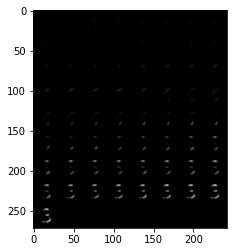

Epoch [204/400] Batch: [1/60] KL-Divergence: 0.02554606832563877 Cross-Entropy: 0.20869627594947815 Loss: 0.23424234986305237
Epoch [204/400] Batch: [2/60] KL-Divergence: 0.025767000392079353 Cross-Entropy: 0.21085423231124878 Loss: 0.23662123084068298
Epoch [204/400] Batch: [3/60] KL-Divergence: 0.026088930666446686 Cross-Entropy: 0.2109309881925583 Loss: 0.23701992630958557
Epoch [204/400] Batch: [4/60] KL-Divergence: 0.024769848212599754 Cross-Entropy: 0.20778800547122955 Loss: 0.23255784809589386
Epoch [204/400] Batch: [5/60] KL-Divergence: 0.027335477992892265 Cross-Entropy: 0.21104224026203156 Loss: 0.23837772011756897
Epoch [204/400] Batch: [6/60] KL-Divergence: 0.026068847626447678 Cross-Entropy: 0.21206088364124298 Loss: 0.23812973499298096
Epoch [204/400] Batch: [7/60] KL-Divergence: 0.026964770630002022 Cross-Entropy: 0.20921802520751953 Loss: 0.2361827939748764
Epoch [204/400] Batch: [8/60] KL-Divergence: 0.025680702179670334 Cross-Entropy: 0.20770399272441864 Loss: 0.23338

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [204/400] Batch: [60/60] KL-Divergence: 0.028414471074938774 Cross-Entropy: 0.21500664949417114 Loss: 0.24342112243175507
Epoch [204/400] Batch: [60/60] KL-Divergence: 0.028414471074938774 Cross-Entropy: 0.21500664949417114 Loss: 0.24342112243175507


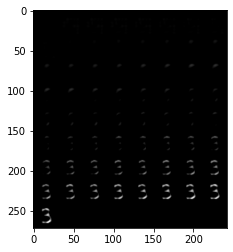

Epoch [205/400] Batch: [1/60] KL-Divergence: 0.028158940374851227 Cross-Entropy: 0.20949102938175201 Loss: 0.23764997720718384
Epoch [205/400] Batch: [2/60] KL-Divergence: 0.026301376521587372 Cross-Entropy: 0.21221722662448883 Loss: 0.2385185956954956
Epoch [205/400] Batch: [3/60] KL-Divergence: 0.02686833217740059 Cross-Entropy: 0.2101290225982666 Loss: 0.2369973510503769
Epoch [205/400] Batch: [4/60] KL-Divergence: 0.026327092200517654 Cross-Entropy: 0.20900896191596985 Loss: 0.2353360503911972
Epoch [205/400] Batch: [5/60] KL-Divergence: 0.029042912647128105 Cross-Entropy: 0.2116372287273407 Loss: 0.24068014323711395
Epoch [205/400] Batch: [6/60] KL-Divergence: 0.02724500373005867 Cross-Entropy: 0.21293905377388 Loss: 0.24018405377864838
Epoch [205/400] Batch: [7/60] KL-Divergence: 0.02737731672823429 Cross-Entropy: 0.20995435118675232 Loss: 0.23733167350292206
Epoch [205/400] Batch: [8/60] KL-Divergence: 0.027141952887177467 Cross-Entropy: 0.20887435972690582 Loss: 0.2360163182020

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [205/400] Batch: [60/60] KL-Divergence: 0.02699430100619793 Cross-Entropy: 0.2140544056892395 Loss: 0.24104870855808258
Epoch [205/400] Batch: [60/60] KL-Divergence: 0.02699430100619793 Cross-Entropy: 0.2140544056892395 Loss: 0.24104870855808258


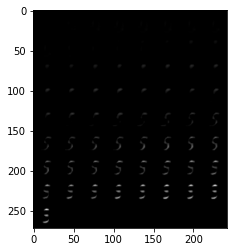

Epoch [206/400] Batch: [1/60] KL-Divergence: 0.026956474408507347 Cross-Entropy: 0.2075393795967102 Loss: 0.2344958484172821
Epoch [206/400] Batch: [2/60] KL-Divergence: 0.026117045432329178 Cross-Entropy: 0.210649311542511 Loss: 0.23676635324954987
Epoch [206/400] Batch: [3/60] KL-Divergence: 0.027120253071188927 Cross-Entropy: 0.20974545180797577 Loss: 0.23686569929122925
Epoch [206/400] Batch: [4/60] KL-Divergence: 0.026240775361657143 Cross-Entropy: 0.20770786702632904 Loss: 0.23394864797592163
Epoch [206/400] Batch: [5/60] KL-Divergence: 0.027764443308115005 Cross-Entropy: 0.2108667641878128 Loss: 0.2386312037706375
Epoch [206/400] Batch: [6/60] KL-Divergence: 0.026851072907447815 Cross-Entropy: 0.21203555166721344 Loss: 0.23888662457466125
Epoch [206/400] Batch: [7/60] KL-Divergence: 0.026628071442246437 Cross-Entropy: 0.2087307870388031 Loss: 0.23535886406898499
Epoch [206/400] Batch: [8/60] KL-Divergence: 0.02694961428642273 Cross-Entropy: 0.20802955329418182 Loss: 0.2349791675

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [206/400] Batch: [60/60] KL-Divergence: 0.029192155227065086 Cross-Entropy: 0.21413135528564453 Loss: 0.24332350492477417
Epoch [206/400] Batch: [60/60] KL-Divergence: 0.029192155227065086 Cross-Entropy: 0.21413135528564453 Loss: 0.24332350492477417


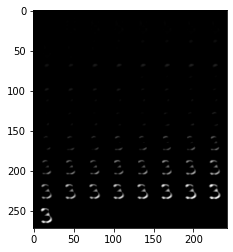

Epoch [207/400] Batch: [1/60] KL-Divergence: 0.027937015518546104 Cross-Entropy: 0.20657655596733093 Loss: 0.2345135658979416
Epoch [207/400] Batch: [2/60] KL-Divergence: 0.027057943865656853 Cross-Entropy: 0.20866090059280396 Loss: 0.23571884632110596
Epoch [207/400] Batch: [3/60] KL-Divergence: 0.027088433504104614 Cross-Entropy: 0.20837722718715668 Loss: 0.2354656606912613
Epoch [207/400] Batch: [4/60] KL-Divergence: 0.026601223275065422 Cross-Entropy: 0.20715416967868805 Loss: 0.23375539481639862
Epoch [207/400] Batch: [5/60] KL-Divergence: 0.028663605451583862 Cross-Entropy: 0.20935457944869995 Loss: 0.2380181849002838
Epoch [207/400] Batch: [6/60] KL-Divergence: 0.027059035375714302 Cross-Entropy: 0.21071653068065643 Loss: 0.23777556419372559
Epoch [207/400] Batch: [7/60] KL-Divergence: 0.026451067999005318 Cross-Entropy: 0.20751936733722687 Loss: 0.23397043347358704
Epoch [207/400] Batch: [8/60] KL-Divergence: 0.026308583095669746 Cross-Entropy: 0.20661072432994843 Loss: 0.23291

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [207/400] Batch: [60/60] KL-Divergence: 0.028532113879919052 Cross-Entropy: 0.2127460092306137 Loss: 0.24127812683582306
Epoch [207/400] Batch: [60/60] KL-Divergence: 0.028532113879919052 Cross-Entropy: 0.2127460092306137 Loss: 0.24127812683582306


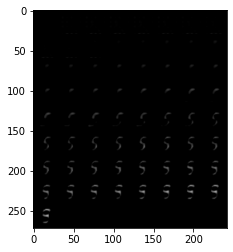

Epoch [208/400] Batch: [1/60] KL-Divergence: 0.028351932764053345 Cross-Entropy: 0.20517076551914215 Loss: 0.2335226982831955
Epoch [208/400] Batch: [2/60] KL-Divergence: 0.027363598346710205 Cross-Entropy: 0.20916828513145447 Loss: 0.23653188347816467
Epoch [208/400] Batch: [3/60] KL-Divergence: 0.027713224291801453 Cross-Entropy: 0.20862606167793274 Loss: 0.2363392859697342
Epoch [208/400] Batch: [4/60] KL-Divergence: 0.02801785245537758 Cross-Entropy: 0.2063465118408203 Loss: 0.2343643605709076
Epoch [208/400] Batch: [5/60] KL-Divergence: 0.02867208421230316 Cross-Entropy: 0.20937086641788483 Loss: 0.238042950630188
Epoch [208/400] Batch: [6/60] KL-Divergence: 0.027154847979545593 Cross-Entropy: 0.20952263474464417 Loss: 0.23667748272418976
Epoch [208/400] Batch: [7/60] KL-Divergence: 0.0279525239020586 Cross-Entropy: 0.20611289143562317 Loss: 0.23406541347503662
Epoch [208/400] Batch: [8/60] KL-Divergence: 0.026621174067258835 Cross-Entropy: 0.20731456577777863 Loss: 0.233935743570

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [208/400] Batch: [60/60] KL-Divergence: 0.02908039651811123 Cross-Entropy: 0.2139057219028473 Loss: 0.24298611283302307
Epoch [208/400] Batch: [60/60] KL-Divergence: 0.02908039651811123 Cross-Entropy: 0.2139057219028473 Loss: 0.24298611283302307


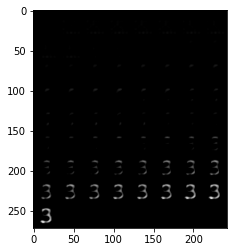

Epoch [209/400] Batch: [1/60] KL-Divergence: 0.027624670416116714 Cross-Entropy: 0.20681065320968628 Loss: 0.2344353199005127
Epoch [209/400] Batch: [2/60] KL-Divergence: 0.02580730803310871 Cross-Entropy: 0.20921243727207184 Loss: 0.2350197434425354
Epoch [209/400] Batch: [3/60] KL-Divergence: 0.02678089775145054 Cross-Entropy: 0.20981758832931519 Loss: 0.23659849166870117
Epoch [209/400] Batch: [4/60] KL-Divergence: 0.02740863710641861 Cross-Entropy: 0.20671579241752625 Loss: 0.23412442207336426
Epoch [209/400] Batch: [5/60] KL-Divergence: 0.028236620128154755 Cross-Entropy: 0.21158672869205475 Loss: 0.2398233413696289
Epoch [209/400] Batch: [6/60] KL-Divergence: 0.028292054310441017 Cross-Entropy: 0.20973257720470428 Loss: 0.23802463710308075
Epoch [209/400] Batch: [7/60] KL-Divergence: 0.027226679027080536 Cross-Entropy: 0.20707100629806519 Loss: 0.23429769277572632
Epoch [209/400] Batch: [8/60] KL-Divergence: 0.0272614024579525 Cross-Entropy: 0.20699235796928406 Loss: 0.2342537641

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [209/400] Batch: [60/60] KL-Divergence: 0.02695263922214508 Cross-Entropy: 0.21672679483890533 Loss: 0.24367943406105042
Epoch [209/400] Batch: [60/60] KL-Divergence: 0.02695263922214508 Cross-Entropy: 0.21672679483890533 Loss: 0.24367943406105042


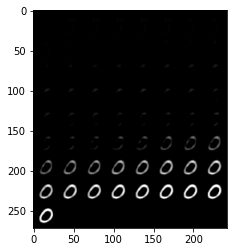

Epoch [210/400] Batch: [1/60] KL-Divergence: 0.026821788400411606 Cross-Entropy: 0.2074667066335678 Loss: 0.23428849875926971
Epoch [210/400] Batch: [2/60] KL-Divergence: 0.027425028383731842 Cross-Entropy: 0.20966726541519165 Loss: 0.2370922863483429
Epoch [210/400] Batch: [3/60] KL-Divergence: 0.027707239612936974 Cross-Entropy: 0.20853091776371002 Loss: 0.23623815178871155
Epoch [210/400] Batch: [4/60] KL-Divergence: 0.026691166684031487 Cross-Entropy: 0.20664912462234497 Loss: 0.2333402931690216
Epoch [210/400] Batch: [5/60] KL-Divergence: 0.029894715175032616 Cross-Entropy: 0.2101309895515442 Loss: 0.24002569913864136
Epoch [210/400] Batch: [6/60] KL-Divergence: 0.02820420078933239 Cross-Entropy: 0.21064098179340363 Loss: 0.23884518444538116
Epoch [210/400] Batch: [7/60] KL-Divergence: 0.02688400074839592 Cross-Entropy: 0.20781396329402924 Loss: 0.23469796776771545
Epoch [210/400] Batch: [8/60] KL-Divergence: 0.02702307142317295 Cross-Entropy: 0.20758002996444702 Loss: 0.234603106

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [210/400] Batch: [60/60] KL-Divergence: 0.03034825809299946 Cross-Entropy: 0.21422608196735382 Loss: 0.24457433819770813
Epoch [210/400] Batch: [60/60] KL-Divergence: 0.03034825809299946 Cross-Entropy: 0.21422608196735382 Loss: 0.24457433819770813


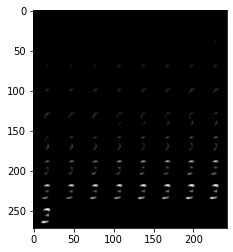

Epoch [211/400] Batch: [1/60] KL-Divergence: 0.02847059816122055 Cross-Entropy: 0.20431500673294067 Loss: 0.23278561234474182
Epoch [211/400] Batch: [2/60] KL-Divergence: 0.027786998078227043 Cross-Entropy: 0.20867988467216492 Loss: 0.2364668846130371
Epoch [211/400] Batch: [3/60] KL-Divergence: 0.02868870459496975 Cross-Entropy: 0.20886990427970886 Loss: 0.23755860328674316
Epoch [211/400] Batch: [4/60] KL-Divergence: 0.027769794687628746 Cross-Entropy: 0.2063198685646057 Loss: 0.234089657664299
Epoch [211/400] Batch: [5/60] KL-Divergence: 0.028941959142684937 Cross-Entropy: 0.2106333076953888 Loss: 0.23957526683807373
Epoch [211/400] Batch: [6/60] KL-Divergence: 0.02843824215233326 Cross-Entropy: 0.2121579796075821 Loss: 0.2405962198972702
Epoch [211/400] Batch: [7/60] KL-Divergence: 0.027288995683193207 Cross-Entropy: 0.208098366856575 Loss: 0.23538735508918762
Epoch [211/400] Batch: [8/60] KL-Divergence: 0.026373080909252167 Cross-Entropy: 0.2066427320241928 Loss: 0.233015805482864

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [211/400] Batch: [60/60] KL-Divergence: 0.026727210730314255 Cross-Entropy: 0.21934354305267334 Loss: 0.2460707575082779
Epoch [211/400] Batch: [60/60] KL-Divergence: 0.026727210730314255 Cross-Entropy: 0.21934354305267334 Loss: 0.2460707575082779


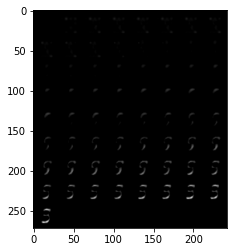

Epoch [212/400] Batch: [1/60] KL-Divergence: 0.02551899291574955 Cross-Entropy: 0.20891842246055603 Loss: 0.23443742096424103
Epoch [212/400] Batch: [2/60] KL-Divergence: 0.024925317615270615 Cross-Entropy: 0.21103225648403168 Loss: 0.2359575778245926
Epoch [212/400] Batch: [3/60] KL-Divergence: 0.02581828460097313 Cross-Entropy: 0.2120400071144104 Loss: 0.23785829544067383
Epoch [212/400] Batch: [4/60] KL-Divergence: 0.025534188374876976 Cross-Entropy: 0.2097291797399521 Loss: 0.23526336252689362
Epoch [212/400] Batch: [5/60] KL-Divergence: 0.026857128366827965 Cross-Entropy: 0.21264347434043884 Loss: 0.23950059711933136
Epoch [212/400] Batch: [6/60] KL-Divergence: 0.025740990415215492 Cross-Entropy: 0.21324804425239563 Loss: 0.23898904025554657
Epoch [212/400] Batch: [7/60] KL-Divergence: 0.026466334238648415 Cross-Entropy: 0.21027937531471252 Loss: 0.2367457151412964
Epoch [212/400] Batch: [8/60] KL-Divergence: 0.026374196633696556 Cross-Entropy: 0.20858652889728546 Loss: 0.23496071

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [212/400] Batch: [60/60] KL-Divergence: 0.02823646180331707 Cross-Entropy: 0.21296708285808563 Loss: 0.24120354652404785
Epoch [212/400] Batch: [60/60] KL-Divergence: 0.02823646180331707 Cross-Entropy: 0.21296708285808563 Loss: 0.24120354652404785


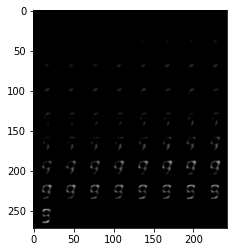

Epoch [213/400] Batch: [1/60] KL-Divergence: 0.027471862733364105 Cross-Entropy: 0.20600561797618866 Loss: 0.23347747325897217
Epoch [213/400] Batch: [2/60] KL-Divergence: 0.02769496478140354 Cross-Entropy: 0.20840568840503693 Loss: 0.23610065877437592
Epoch [213/400] Batch: [3/60] KL-Divergence: 0.028226371854543686 Cross-Entropy: 0.20866607129573822 Loss: 0.2368924468755722
Epoch [213/400] Batch: [4/60] KL-Divergence: 0.02847185544669628 Cross-Entropy: 0.20671279728412628 Loss: 0.2351846545934677
Epoch [213/400] Batch: [5/60] KL-Divergence: 0.028967326506972313 Cross-Entropy: 0.2102184295654297 Loss: 0.23918575048446655
Epoch [213/400] Batch: [6/60] KL-Divergence: 0.027931347489356995 Cross-Entropy: 0.21097691357135773 Loss: 0.23890826106071472
Epoch [213/400] Batch: [7/60] KL-Divergence: 0.027209144085645676 Cross-Entropy: 0.2089814394712448 Loss: 0.2361905872821808
Epoch [213/400] Batch: [8/60] KL-Divergence: 0.02557220682501793 Cross-Entropy: 0.20865321159362793 Loss: 0.2342254221

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [213/400] Batch: [60/60] KL-Divergence: 0.029025938361883163 Cross-Entropy: 0.21128948032855988 Loss: 0.24031542241573334
Epoch [213/400] Batch: [60/60] KL-Divergence: 0.029025938361883163 Cross-Entropy: 0.21128948032855988 Loss: 0.24031542241573334


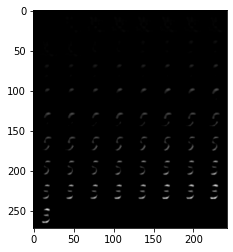

Epoch [214/400] Batch: [1/60] KL-Divergence: 0.029920760542154312 Cross-Entropy: 0.20406630635261536 Loss: 0.23398706316947937
Epoch [214/400] Batch: [2/60] KL-Divergence: 0.02799372561275959 Cross-Entropy: 0.20645076036453247 Loss: 0.2344444841146469
Epoch [214/400] Batch: [3/60] KL-Divergence: 0.029471946880221367 Cross-Entropy: 0.20732484757900238 Loss: 0.2367967963218689
Epoch [214/400] Batch: [4/60] KL-Divergence: 0.029417991638183594 Cross-Entropy: 0.20426855981349945 Loss: 0.23368655145168304
Epoch [214/400] Batch: [5/60] KL-Divergence: 0.028948690742254257 Cross-Entropy: 0.20868265628814697 Loss: 0.23763135075569153
Epoch [214/400] Batch: [6/60] KL-Divergence: 0.02794155664741993 Cross-Entropy: 0.20914480090141296 Loss: 0.23708635568618774
Epoch [214/400] Batch: [7/60] KL-Divergence: 0.028244812041521072 Cross-Entropy: 0.20692332088947296 Loss: 0.23516812920570374
Epoch [214/400] Batch: [8/60] KL-Divergence: 0.02700381726026535 Cross-Entropy: 0.2056901603937149 Loss: 0.23269397

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [214/400] Batch: [60/60] KL-Divergence: 0.028331317007541656 Cross-Entropy: 0.21183377504348755 Loss: 0.2401650846004486
Epoch [214/400] Batch: [60/60] KL-Divergence: 0.028331317007541656 Cross-Entropy: 0.21183377504348755 Loss: 0.2401650846004486


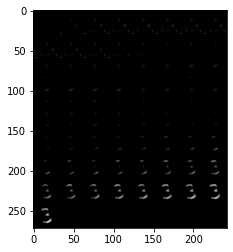

Epoch [215/400] Batch: [1/60] KL-Divergence: 0.029046425595879555 Cross-Entropy: 0.2051311731338501 Loss: 0.2341776043176651
Epoch [215/400] Batch: [2/60] KL-Divergence: 0.027938153594732285 Cross-Entropy: 0.20689131319522858 Loss: 0.23482947051525116
Epoch [215/400] Batch: [3/60] KL-Divergence: 0.027424165979027748 Cross-Entropy: 0.20689833164215088 Loss: 0.23432250320911407
Epoch [215/400] Batch: [4/60] KL-Divergence: 0.027426740154623985 Cross-Entropy: 0.20474253594875336 Loss: 0.2321692705154419
Epoch [215/400] Batch: [5/60] KL-Divergence: 0.028991058468818665 Cross-Entropy: 0.20811060070991516 Loss: 0.23710165917873383
Epoch [215/400] Batch: [6/60] KL-Divergence: 0.02763373777270317 Cross-Entropy: 0.20843404531478882 Loss: 0.2360677868127823
Epoch [215/400] Batch: [7/60] KL-Divergence: 0.027717914432287216 Cross-Entropy: 0.20590735971927643 Loss: 0.23362527787685394
Epoch [215/400] Batch: [8/60] KL-Divergence: 0.027990205213427544 Cross-Entropy: 0.20528973639011383 Loss: 0.2332799

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [215/400] Batch: [60/60] KL-Divergence: 0.027152689173817635 Cross-Entropy: 0.2123425453901291 Loss: 0.23949523270130157
Epoch [215/400] Batch: [60/60] KL-Divergence: 0.027152689173817635 Cross-Entropy: 0.2123425453901291 Loss: 0.23949523270130157


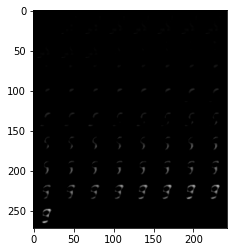

Epoch [216/400] Batch: [1/60] KL-Divergence: 0.027923455461859703 Cross-Entropy: 0.20446866750717163 Loss: 0.2323921173810959
Epoch [216/400] Batch: [2/60] KL-Divergence: 0.02683287300169468 Cross-Entropy: 0.2066296935081482 Loss: 0.23346257209777832
Epoch [216/400] Batch: [3/60] KL-Divergence: 0.02800043858587742 Cross-Entropy: 0.20796288549900055 Loss: 0.23596332967281342
Epoch [216/400] Batch: [4/60] KL-Divergence: 0.027216844260692596 Cross-Entropy: 0.2042659968137741 Loss: 0.2314828336238861
Epoch [216/400] Batch: [5/60] KL-Divergence: 0.02922346442937851 Cross-Entropy: 0.2080075889825821 Loss: 0.23723104596138
Epoch [216/400] Batch: [6/60] KL-Divergence: 0.02843598648905754 Cross-Entropy: 0.20904698967933655 Loss: 0.2374829798936844
Epoch [216/400] Batch: [7/60] KL-Divergence: 0.027873411774635315 Cross-Entropy: 0.2055625319480896 Loss: 0.23343594372272491
Epoch [216/400] Batch: [8/60] KL-Divergence: 0.02774924226105213 Cross-Entropy: 0.20493577420711517 Loss: 0.23268501460552216

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [216/400] Batch: [60/60] KL-Divergence: 0.02862468734383583 Cross-Entropy: 0.21167713403701782 Loss: 0.24030181765556335
Epoch [216/400] Batch: [60/60] KL-Divergence: 0.02862468734383583 Cross-Entropy: 0.21167713403701782 Loss: 0.24030181765556335


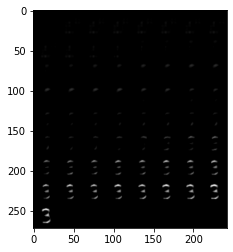

Epoch [217/400] Batch: [1/60] KL-Divergence: 0.027501368895173073 Cross-Entropy: 0.20393627882003784 Loss: 0.23143765330314636
Epoch [217/400] Batch: [2/60] KL-Divergence: 0.027739521116018295 Cross-Entropy: 0.20902857184410095 Loss: 0.23676809668540955
Epoch [217/400] Batch: [3/60] KL-Divergence: 0.029085297137498856 Cross-Entropy: 0.20842555165290833 Loss: 0.23751084506511688
Epoch [217/400] Batch: [4/60] KL-Divergence: 0.027664901688694954 Cross-Entropy: 0.20491613447666168 Loss: 0.2325810343027115
Epoch [217/400] Batch: [5/60] KL-Divergence: 0.02986498922109604 Cross-Entropy: 0.20977839827537537 Loss: 0.239643394947052
Epoch [217/400] Batch: [6/60] KL-Divergence: 0.028237702324986458 Cross-Entropy: 0.2087889015674591 Loss: 0.23702660202980042
Epoch [217/400] Batch: [7/60] KL-Divergence: 0.028316805139183998 Cross-Entropy: 0.20499755442142487 Loss: 0.2333143651485443
Epoch [217/400] Batch: [8/60] KL-Divergence: 0.028179647400975227 Cross-Entropy: 0.2049867808818817 Loss: 0.233166426

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [217/400] Batch: [60/60] KL-Divergence: 0.027481215074658394 Cross-Entropy: 0.21562957763671875 Loss: 0.243110790848732
Epoch [217/400] Batch: [60/60] KL-Divergence: 0.027481215074658394 Cross-Entropy: 0.21562957763671875 Loss: 0.243110790848732


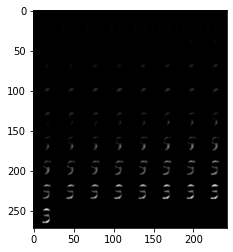

Epoch [218/400] Batch: [1/60] KL-Divergence: 0.02720673196017742 Cross-Entropy: 0.20687006413936615 Loss: 0.23407679796218872
Epoch [218/400] Batch: [2/60] KL-Divergence: 0.027746722102165222 Cross-Entropy: 0.20884904265403748 Loss: 0.2365957647562027
Epoch [218/400] Batch: [3/60] KL-Divergence: 0.027876457199454308 Cross-Entropy: 0.20803841948509216 Loss: 0.23591487109661102
Epoch [218/400] Batch: [4/60] KL-Divergence: 0.027654051780700684 Cross-Entropy: 0.20459964871406555 Loss: 0.23225370049476624
Epoch [218/400] Batch: [5/60] KL-Divergence: 0.029675383120775223 Cross-Entropy: 0.2091021090745926 Loss: 0.23877748847007751
Epoch [218/400] Batch: [6/60] KL-Divergence: 0.028438637033104897 Cross-Entropy: 0.21047428250312805 Loss: 0.2389129251241684
Epoch [218/400] Batch: [7/60] KL-Divergence: 0.02768300659954548 Cross-Entropy: 0.20553721487522125 Loss: 0.23322021961212158
Epoch [218/400] Batch: [8/60] KL-Divergence: 0.02745007909834385 Cross-Entropy: 0.20670609176158905 Loss: 0.23415617

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [218/400] Batch: [60/60] KL-Divergence: 0.02991730347275734 Cross-Entropy: 0.21328438818454742 Loss: 0.24320168793201447
Epoch [218/400] Batch: [60/60] KL-Divergence: 0.02991730347275734 Cross-Entropy: 0.21328438818454742 Loss: 0.24320168793201447


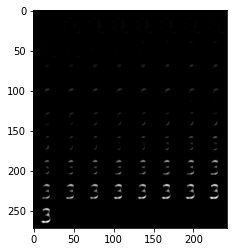

Epoch [219/400] Batch: [1/60] KL-Divergence: 0.028326336294412613 Cross-Entropy: 0.2026791274547577 Loss: 0.23100546002388
Epoch [219/400] Batch: [2/60] KL-Divergence: 0.029101457446813583 Cross-Entropy: 0.20565296709537506 Loss: 0.23475442826747894
Epoch [219/400] Batch: [3/60] KL-Divergence: 0.02910737693309784 Cross-Entropy: 0.20633091032505035 Loss: 0.2354382872581482
Epoch [219/400] Batch: [4/60] KL-Divergence: 0.028920790180563927 Cross-Entropy: 0.2034240961074829 Loss: 0.2323448807001114
Epoch [219/400] Batch: [5/60] KL-Divergence: 0.030652880668640137 Cross-Entropy: 0.20732855796813965 Loss: 0.23798143863677979
Epoch [219/400] Batch: [6/60] KL-Divergence: 0.0294407457113266 Cross-Entropy: 0.2082255333662033 Loss: 0.2376662790775299
Epoch [219/400] Batch: [7/60] KL-Divergence: 0.028455575928092003 Cross-Entropy: 0.20415624976158142 Loss: 0.23261182010173798
Epoch [219/400] Batch: [8/60] KL-Divergence: 0.02875506691634655 Cross-Entropy: 0.20529454946517944 Loss: 0.234049618244171

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [219/400] Batch: [60/60] KL-Divergence: 0.029452254995703697 Cross-Entropy: 0.21136018633842468 Loss: 0.24081243574619293
Epoch [219/400] Batch: [60/60] KL-Divergence: 0.029452254995703697 Cross-Entropy: 0.21136018633842468 Loss: 0.24081243574619293


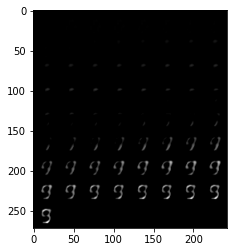

Epoch [220/400] Batch: [1/60] KL-Divergence: 0.028642967343330383 Cross-Entropy: 0.2025686353445053 Loss: 0.2312116026878357
Epoch [220/400] Batch: [2/60] KL-Divergence: 0.027966000139713287 Cross-Entropy: 0.20621973276138306 Loss: 0.23418572545051575
Epoch [220/400] Batch: [3/60] KL-Divergence: 0.028681078925728798 Cross-Entropy: 0.20643605291843414 Loss: 0.2351171374320984
Epoch [220/400] Batch: [4/60] KL-Divergence: 0.02799956500530243 Cross-Entropy: 0.20387206971645355 Loss: 0.23187163472175598
Epoch [220/400] Batch: [5/60] KL-Divergence: 0.03005887195467949 Cross-Entropy: 0.20673632621765137 Loss: 0.23679520189762115
Epoch [220/400] Batch: [6/60] KL-Divergence: 0.028929661959409714 Cross-Entropy: 0.2080426812171936 Loss: 0.23697234690189362
Epoch [220/400] Batch: [7/60] KL-Divergence: 0.028110023587942123 Cross-Entropy: 0.204892098903656 Loss: 0.23300212621688843
Epoch [220/400] Batch: [8/60] KL-Divergence: 0.02817005291581154 Cross-Entropy: 0.2060583084821701 Loss: 0.234228357672

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [220/400] Batch: [60/60] KL-Divergence: 0.02937840297818184 Cross-Entropy: 0.21187518537044525 Loss: 0.2412535846233368
Epoch [220/400] Batch: [60/60] KL-Divergence: 0.02937840297818184 Cross-Entropy: 0.21187518537044525 Loss: 0.2412535846233368


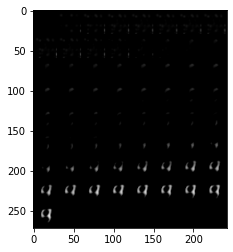

Epoch [221/400] Batch: [1/60] KL-Divergence: 0.029242219403386116 Cross-Entropy: 0.2016858160495758 Loss: 0.23092803359031677
Epoch [221/400] Batch: [2/60] KL-Divergence: 0.030471747741103172 Cross-Entropy: 0.20477744936943054 Loss: 0.23524919152259827
Epoch [221/400] Batch: [3/60] KL-Divergence: 0.03089272789657116 Cross-Entropy: 0.20473921298980713 Loss: 0.23563194274902344
Epoch [221/400] Batch: [4/60] KL-Divergence: 0.029550766572356224 Cross-Entropy: 0.2018582671880722 Loss: 0.23140902817249298
Epoch [221/400] Batch: [5/60] KL-Divergence: 0.030591899529099464 Cross-Entropy: 0.2052692472934723 Loss: 0.2358611524105072
Epoch [221/400] Batch: [6/60] KL-Divergence: 0.02930603176355362 Cross-Entropy: 0.20604774355888367 Loss: 0.2353537678718567
Epoch [221/400] Batch: [7/60] KL-Divergence: 0.02878315933048725 Cross-Entropy: 0.2040286362171173 Loss: 0.2328117936849594
Epoch [221/400] Batch: [8/60] KL-Divergence: 0.027619343250989914 Cross-Entropy: 0.20446737110614777 Loss: 0.232086718082

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [221/400] Batch: [60/60] KL-Divergence: 0.02976839803159237 Cross-Entropy: 0.21022263169288635 Loss: 0.23999102413654327
Epoch [221/400] Batch: [60/60] KL-Divergence: 0.02976839803159237 Cross-Entropy: 0.21022263169288635 Loss: 0.23999102413654327


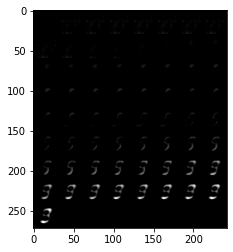

Epoch [222/400] Batch: [1/60] KL-Divergence: 0.02912984788417816 Cross-Entropy: 0.20178715884685516 Loss: 0.23091700673103333
Epoch [222/400] Batch: [2/60] KL-Divergence: 0.028219403699040413 Cross-Entropy: 0.2051784247159958 Loss: 0.23339782655239105
Epoch [222/400] Batch: [3/60] KL-Divergence: 0.02938266284763813 Cross-Entropy: 0.2056269496679306 Loss: 0.23500961065292358
Epoch [222/400] Batch: [4/60] KL-Divergence: 0.028179574757814407 Cross-Entropy: 0.20279519259929657 Loss: 0.23097476363182068
Epoch [222/400] Batch: [5/60] KL-Divergence: 0.029819825664162636 Cross-Entropy: 0.2065381407737732 Loss: 0.23635797202587128
Epoch [222/400] Batch: [6/60] KL-Divergence: 0.02838386967778206 Cross-Entropy: 0.20735330879688263 Loss: 0.2357371747493744
Epoch [222/400] Batch: [7/60] KL-Divergence: 0.028527894988656044 Cross-Entropy: 0.2051326036453247 Loss: 0.2336605042219162
Epoch [222/400] Batch: [8/60] KL-Divergence: 0.02738253027200699 Cross-Entropy: 0.20448166131973267 Loss: 0.231864184141

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [222/400] Batch: [60/60] KL-Divergence: 0.02956078015267849 Cross-Entropy: 0.21214428544044495 Loss: 0.241705060005188
Epoch [222/400] Batch: [60/60] KL-Divergence: 0.02956078015267849 Cross-Entropy: 0.21214428544044495 Loss: 0.241705060005188


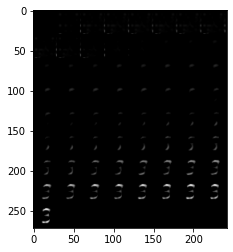

Epoch [223/400] Batch: [1/60] KL-Divergence: 0.030212145298719406 Cross-Entropy: 0.2039237767457962 Loss: 0.2341359257698059
Epoch [223/400] Batch: [2/60] KL-Divergence: 0.02910057082772255 Cross-Entropy: 0.2055143415927887 Loss: 0.23461490869522095
Epoch [223/400] Batch: [3/60] KL-Divergence: 0.0307021327316761 Cross-Entropy: 0.205934077501297 Loss: 0.2366362065076828
Epoch [223/400] Batch: [4/60] KL-Divergence: 0.0294799767434597 Cross-Entropy: 0.20332245528697968 Loss: 0.23280243575572968
Epoch [223/400] Batch: [5/60] KL-Divergence: 0.03118579275906086 Cross-Entropy: 0.20686297118663788 Loss: 0.2380487620830536
Epoch [223/400] Batch: [6/60] KL-Divergence: 0.030061524361371994 Cross-Entropy: 0.20889532566070557 Loss: 0.23895685374736786
Epoch [223/400] Batch: [7/60] KL-Divergence: 0.028470676392316818 Cross-Entropy: 0.20449213683605194 Loss: 0.23296281695365906
Epoch [223/400] Batch: [8/60] KL-Divergence: 0.028028501197695732 Cross-Entropy: 0.20542609691619873 Loss: 0.233454599976539

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [223/400] Batch: [60/60] KL-Divergence: 0.02878476493060589 Cross-Entropy: 0.21085967123508453 Loss: 0.23964443802833557
Epoch [223/400] Batch: [60/60] KL-Divergence: 0.02878476493060589 Cross-Entropy: 0.21085967123508453 Loss: 0.23964443802833557


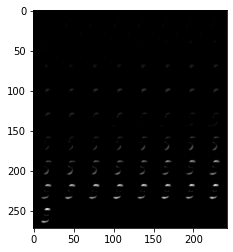

Epoch [224/400] Batch: [1/60] KL-Divergence: 0.029643094167113304 Cross-Entropy: 0.20438970625400543 Loss: 0.2340327948331833
Epoch [224/400] Batch: [2/60] KL-Divergence: 0.02841596119105816 Cross-Entropy: 0.20513629913330078 Loss: 0.2335522621870041
Epoch [224/400] Batch: [3/60] KL-Divergence: 0.029777687042951584 Cross-Entropy: 0.20565542578697205 Loss: 0.23543311655521393
Epoch [224/400] Batch: [4/60] KL-Divergence: 0.02944853901863098 Cross-Entropy: 0.20291659235954285 Loss: 0.23236513137817383
Epoch [224/400] Batch: [5/60] KL-Divergence: 0.030741769820451736 Cross-Entropy: 0.20747193694114685 Loss: 0.2382137030363083
Epoch [224/400] Batch: [6/60] KL-Divergence: 0.029424244537949562 Cross-Entropy: 0.20729848742485046 Loss: 0.23672273755073547
Epoch [224/400] Batch: [7/60] KL-Divergence: 0.02932240627706051 Cross-Entropy: 0.20352400839328766 Loss: 0.23284640908241272
Epoch [224/400] Batch: [8/60] KL-Divergence: 0.02862127311527729 Cross-Entropy: 0.20431388914585114 Loss: 0.232935160

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [224/400] Batch: [60/60] KL-Divergence: 0.030053744092583656 Cross-Entropy: 0.21589581668376923 Loss: 0.24594956636428833
Epoch [224/400] Batch: [60/60] KL-Divergence: 0.030053744092583656 Cross-Entropy: 0.21589581668376923 Loss: 0.24594956636428833


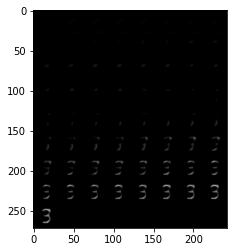

Epoch [225/400] Batch: [1/60] KL-Divergence: 0.02892916277050972 Cross-Entropy: 0.20686572790145874 Loss: 0.23579488694667816
Epoch [225/400] Batch: [2/60] KL-Divergence: 0.028685370460152626 Cross-Entropy: 0.20985853672027588 Loss: 0.23854391276836395
Epoch [225/400] Batch: [3/60] KL-Divergence: 0.027838749811053276 Cross-Entropy: 0.20973995327949524 Loss: 0.23757870495319366
Epoch [225/400] Batch: [4/60] KL-Divergence: 0.027593465521931648 Cross-Entropy: 0.20721738040447235 Loss: 0.23481084406375885
Epoch [225/400] Batch: [5/60] KL-Divergence: 0.029522689059376717 Cross-Entropy: 0.21191288530826569 Loss: 0.24143557250499725
Epoch [225/400] Batch: [6/60] KL-Divergence: 0.02706674300134182 Cross-Entropy: 0.21219849586486816 Loss: 0.23926523327827454
Epoch [225/400] Batch: [7/60] KL-Divergence: 0.027988338842988014 Cross-Entropy: 0.20896367728710175 Loss: 0.2369520217180252
Epoch [225/400] Batch: [8/60] KL-Divergence: 0.025296146050095558 Cross-Entropy: 0.2081066370010376 Loss: 0.233402

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [225/400] Batch: [60/60] KL-Divergence: 0.028131458908319473 Cross-Entropy: 0.213483527302742 Loss: 0.24161498248577118
Epoch [225/400] Batch: [60/60] KL-Divergence: 0.028131458908319473 Cross-Entropy: 0.213483527302742 Loss: 0.24161498248577118


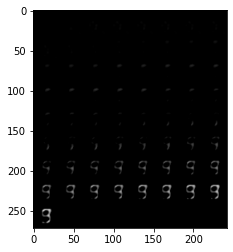

Epoch [226/400] Batch: [1/60] KL-Divergence: 0.027267953380942345 Cross-Entropy: 0.20620650053024292 Loss: 0.23347444832324982
Epoch [226/400] Batch: [2/60] KL-Divergence: 0.027025870978832245 Cross-Entropy: 0.21028023958206177 Loss: 0.2373061180114746
Epoch [226/400] Batch: [3/60] KL-Divergence: 0.028237171471118927 Cross-Entropy: 0.21005001664161682 Loss: 0.23828718066215515
Epoch [226/400] Batch: [4/60] KL-Divergence: 0.028199452906847 Cross-Entropy: 0.20664463937282562 Loss: 0.23484408855438232
Epoch [226/400] Batch: [5/60] KL-Divergence: 0.029499242082238197 Cross-Entropy: 0.21072794497013092 Loss: 0.24022719264030457
Epoch [226/400] Batch: [6/60] KL-Divergence: 0.02862563729286194 Cross-Entropy: 0.20915189385414124 Loss: 0.23777753114700317
Epoch [226/400] Batch: [7/60] KL-Divergence: 0.027721993625164032 Cross-Entropy: 0.20717419683933258 Loss: 0.23489618301391602
Epoch [226/400] Batch: [8/60] KL-Divergence: 0.027391139417886734 Cross-Entropy: 0.205465629696846 Loss: 0.232856765

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [226/400] Batch: [60/60] KL-Divergence: 0.029144609346985817 Cross-Entropy: 0.2136705070734024 Loss: 0.24281512200832367
Epoch [226/400] Batch: [60/60] KL-Divergence: 0.029144609346985817 Cross-Entropy: 0.2136705070734024 Loss: 0.24281512200832367


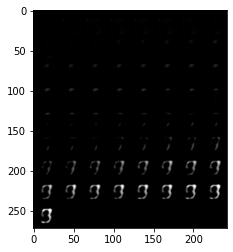

Epoch [227/400] Batch: [1/60] KL-Divergence: 0.02889075130224228 Cross-Entropy: 0.20465098321437836 Loss: 0.23354172706604004
Epoch [227/400] Batch: [2/60] KL-Divergence: 0.02833472564816475 Cross-Entropy: 0.20679399371147156 Loss: 0.235128715634346
Epoch [227/400] Batch: [3/60] KL-Divergence: 0.028311574831604958 Cross-Entropy: 0.2073720395565033 Loss: 0.2356836199760437
Epoch [227/400] Batch: [4/60] KL-Divergence: 0.028089871630072594 Cross-Entropy: 0.2046680599451065 Loss: 0.23275792598724365
Epoch [227/400] Batch: [5/60] KL-Divergence: 0.030536828562617302 Cross-Entropy: 0.20931345224380493 Loss: 0.23985028266906738
Epoch [227/400] Batch: [6/60] KL-Divergence: 0.028462987393140793 Cross-Entropy: 0.20925891399383545 Loss: 0.23772190511226654
Epoch [227/400] Batch: [7/60] KL-Divergence: 0.027899550274014473 Cross-Entropy: 0.205580472946167 Loss: 0.23348002135753632
Epoch [227/400] Batch: [8/60] KL-Divergence: 0.028215020895004272 Cross-Entropy: 0.20572984218597412 Loss: 0.23394486308

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [227/400] Batch: [60/60] KL-Divergence: 0.027372602373361588 Cross-Entropy: 0.21869570016860962 Loss: 0.2460682988166809
Epoch [227/400] Batch: [60/60] KL-Divergence: 0.027372602373361588 Cross-Entropy: 0.21869570016860962 Loss: 0.2460682988166809


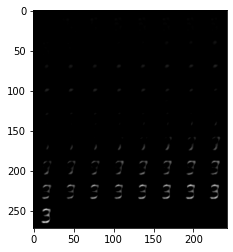

Epoch [228/400] Batch: [1/60] KL-Divergence: 0.027050040662288666 Cross-Entropy: 0.2110280990600586 Loss: 0.23807814717292786
Epoch [228/400] Batch: [2/60] KL-Divergence: 0.02689654752612114 Cross-Entropy: 0.21337522566318512 Loss: 0.24027177691459656
Epoch [228/400] Batch: [3/60] KL-Divergence: 0.027715502306818962 Cross-Entropy: 0.21500033140182495 Loss: 0.24271583557128906
Epoch [228/400] Batch: [4/60] KL-Divergence: 0.028445832431316376 Cross-Entropy: 0.21051988005638123 Loss: 0.2389657199382782
Epoch [228/400] Batch: [5/60] KL-Divergence: 0.029667329043149948 Cross-Entropy: 0.21522559225559235 Loss: 0.2448929250240326
Epoch [228/400] Batch: [6/60] KL-Divergence: 0.02839559316635132 Cross-Entropy: 0.213429793715477 Loss: 0.2418253868818283
Epoch [228/400] Batch: [7/60] KL-Divergence: 0.02728421241044998 Cross-Entropy: 0.21192596852779388 Loss: 0.23921018838882446
Epoch [228/400] Batch: [8/60] KL-Divergence: 0.026504257693886757 Cross-Entropy: 0.21110035479068756 Loss: 0.23760461807

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [228/400] Batch: [60/60] KL-Divergence: 0.028268607333302498 Cross-Entropy: 0.2107401043176651 Loss: 0.23900870978832245
Epoch [228/400] Batch: [60/60] KL-Divergence: 0.028268607333302498 Cross-Entropy: 0.2107401043176651 Loss: 0.23900870978832245


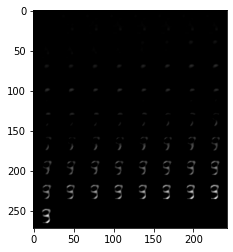

Epoch [229/400] Batch: [1/60] KL-Divergence: 0.027789700776338577 Cross-Entropy: 0.20304742455482483 Loss: 0.2308371216058731
Epoch [229/400] Batch: [2/60] KL-Divergence: 0.028788773342967033 Cross-Entropy: 0.20817218720912933 Loss: 0.23696096241474152
Epoch [229/400] Batch: [3/60] KL-Divergence: 0.028406046330928802 Cross-Entropy: 0.2083229124546051 Loss: 0.2367289662361145
Epoch [229/400] Batch: [4/60] KL-Divergence: 0.027256790548563004 Cross-Entropy: 0.20572292804718018 Loss: 0.23297971487045288
Epoch [229/400] Batch: [5/60] KL-Divergence: 0.028517238795757294 Cross-Entropy: 0.20992600917816162 Loss: 0.2384432554244995
Epoch [229/400] Batch: [6/60] KL-Divergence: 0.02857428975403309 Cross-Entropy: 0.21016915142536163 Loss: 0.23874343931674957
Epoch [229/400] Batch: [7/60] KL-Divergence: 0.02755148522555828 Cross-Entropy: 0.20703403651714325 Loss: 0.23458552360534668
Epoch [229/400] Batch: [8/60] KL-Divergence: 0.02704000659286976 Cross-Entropy: 0.20534807443618774 Loss: 0.232388079

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [229/400] Batch: [60/60] KL-Divergence: 0.028426554054021835 Cross-Entropy: 0.2138931304216385 Loss: 0.24231968820095062
Epoch [229/400] Batch: [60/60] KL-Divergence: 0.028426554054021835 Cross-Entropy: 0.2138931304216385 Loss: 0.24231968820095062


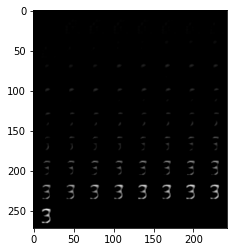

Epoch [230/400] Batch: [1/60] KL-Divergence: 0.0282825268805027 Cross-Entropy: 0.20545077323913574 Loss: 0.23373329639434814
Epoch [230/400] Batch: [2/60] KL-Divergence: 0.028764227405190468 Cross-Entropy: 0.20796112716197968 Loss: 0.2367253601551056
Epoch [230/400] Batch: [3/60] KL-Divergence: 0.02853783220052719 Cross-Entropy: 0.2085084468126297 Loss: 0.2370462715625763
Epoch [230/400] Batch: [4/60] KL-Divergence: 0.028911566361784935 Cross-Entropy: 0.20477139949798584 Loss: 0.23368296027183533
Epoch [230/400] Batch: [5/60] KL-Divergence: 0.029935214668512344 Cross-Entropy: 0.20862141251564026 Loss: 0.2385566234588623
Epoch [230/400] Batch: [6/60] KL-Divergence: 0.028583083301782608 Cross-Entropy: 0.2086777240037918 Loss: 0.23726080358028412
Epoch [230/400] Batch: [7/60] KL-Divergence: 0.028472283855080605 Cross-Entropy: 0.20598891377449036 Loss: 0.2344612032175064
Epoch [230/400] Batch: [8/60] KL-Divergence: 0.028152255341410637 Cross-Entropy: 0.2049555480480194 Loss: 0.233107805252

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [230/400] Batch: [60/60] KL-Divergence: 0.02898477390408516 Cross-Entropy: 0.2124280482530594 Loss: 0.24141281843185425
Epoch [230/400] Batch: [60/60] KL-Divergence: 0.02898477390408516 Cross-Entropy: 0.2124280482530594 Loss: 0.24141281843185425


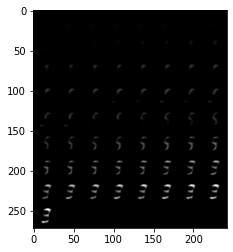

Epoch [231/400] Batch: [1/60] KL-Divergence: 0.029214445501565933 Cross-Entropy: 0.2030472308397293 Loss: 0.23226167261600494
Epoch [231/400] Batch: [2/60] KL-Divergence: 0.028052926063537598 Cross-Entropy: 0.20654670894145966 Loss: 0.23459963500499725
Epoch [231/400] Batch: [3/60] KL-Divergence: 0.02997654303908348 Cross-Entropy: 0.20672762393951416 Loss: 0.23670417070388794
Epoch [231/400] Batch: [4/60] KL-Divergence: 0.028750859200954437 Cross-Entropy: 0.20346172153949738 Loss: 0.23221257328987122
Epoch [231/400] Batch: [5/60] KL-Divergence: 0.030683720484375954 Cross-Entropy: 0.2072431743144989 Loss: 0.2379269003868103
Epoch [231/400] Batch: [6/60] KL-Divergence: 0.029314594343304634 Cross-Entropy: 0.20744985342025757 Loss: 0.23676444590091705
Epoch [231/400] Batch: [7/60] KL-Divergence: 0.02958781085908413 Cross-Entropy: 0.2043420672416687 Loss: 0.23392987251281738
Epoch [231/400] Batch: [8/60] KL-Divergence: 0.028599334880709648 Cross-Entropy: 0.20460541546344757 Loss: 0.23320475

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [231/400] Batch: [60/60] KL-Divergence: 0.028276242315769196 Cross-Entropy: 0.21273568272590637 Loss: 0.24101191759109497
Epoch [231/400] Batch: [60/60] KL-Divergence: 0.028276242315769196 Cross-Entropy: 0.21273568272590637 Loss: 0.24101191759109497


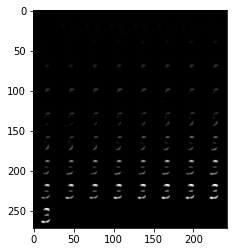

Epoch [232/400] Batch: [1/60] KL-Divergence: 0.028143515810370445 Cross-Entropy: 0.2044537514448166 Loss: 0.2325972616672516
Epoch [232/400] Batch: [2/60] KL-Divergence: 0.027676129713654518 Cross-Entropy: 0.2071531116962433 Loss: 0.23482924699783325
Epoch [232/400] Batch: [3/60] KL-Divergence: 0.028355123475193977 Cross-Entropy: 0.20646870136260986 Loss: 0.2348238229751587
Epoch [232/400] Batch: [4/60] KL-Divergence: 0.02877717651426792 Cross-Entropy: 0.20524443686008453 Loss: 0.2340216189622879
Epoch [232/400] Batch: [5/60] KL-Divergence: 0.02970072254538536 Cross-Entropy: 0.208643838763237 Loss: 0.23834456503391266
Epoch [232/400] Batch: [6/60] KL-Divergence: 0.027981692925095558 Cross-Entropy: 0.20849286019802094 Loss: 0.23647455871105194
Epoch [232/400] Batch: [7/60] KL-Divergence: 0.027478836476802826 Cross-Entropy: 0.20551149547100067 Loss: 0.2329903244972229
Epoch [232/400] Batch: [8/60] KL-Divergence: 0.027710942551493645 Cross-Entropy: 0.20526765286922455 Loss: 0.232978597283

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [232/400] Batch: [60/60] KL-Divergence: 0.028088178485631943 Cross-Entropy: 0.2134174406528473 Loss: 0.24150562286376953
Epoch [232/400] Batch: [60/60] KL-Divergence: 0.028088178485631943 Cross-Entropy: 0.2134174406528473 Loss: 0.24150562286376953


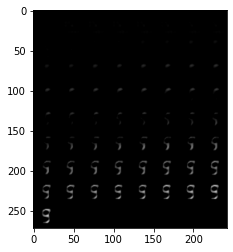

Epoch [233/400] Batch: [1/60] KL-Divergence: 0.029420360922813416 Cross-Entropy: 0.20653556287288666 Loss: 0.23595592379570007
Epoch [233/400] Batch: [2/60] KL-Divergence: 0.027647947892546654 Cross-Entropy: 0.207972452044487 Loss: 0.2356203943490982
Epoch [233/400] Batch: [3/60] KL-Divergence: 0.029497088864445686 Cross-Entropy: 0.20926956832408905 Loss: 0.2387666553258896
Epoch [233/400] Batch: [4/60] KL-Divergence: 0.029615510255098343 Cross-Entropy: 0.20439095795154572 Loss: 0.23400646448135376
Epoch [233/400] Batch: [5/60] KL-Divergence: 0.03078611195087433 Cross-Entropy: 0.20892876386642456 Loss: 0.2397148758172989
Epoch [233/400] Batch: [6/60] KL-Divergence: 0.029193712398409843 Cross-Entropy: 0.20720791816711426 Loss: 0.23640163242816925
Epoch [233/400] Batch: [7/60] KL-Divergence: 0.02977455034852028 Cross-Entropy: 0.20492210984230042 Loss: 0.2346966564655304
Epoch [233/400] Batch: [8/60] KL-Divergence: 0.027897316962480545 Cross-Entropy: 0.2043105810880661 Loss: 0.23220789432

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [233/400] Batch: [60/60] KL-Divergence: 0.028395770117640495 Cross-Entropy: 0.21364150941371918 Loss: 0.24203728139400482
Epoch [233/400] Batch: [60/60] KL-Divergence: 0.028395770117640495 Cross-Entropy: 0.21364150941371918 Loss: 0.24203728139400482


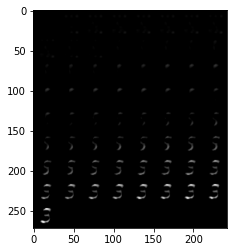

Epoch [234/400] Batch: [1/60] KL-Divergence: 0.029047386720776558 Cross-Entropy: 0.20532222092151642 Loss: 0.23436960577964783
Epoch [234/400] Batch: [2/60] KL-Divergence: 0.02710462361574173 Cross-Entropy: 0.2072838693857193 Loss: 0.23438850045204163
Epoch [234/400] Batch: [3/60] KL-Divergence: 0.029096538200974464 Cross-Entropy: 0.2073470503091812 Loss: 0.23644359409809113
Epoch [234/400] Batch: [4/60] KL-Divergence: 0.028202587738633156 Cross-Entropy: 0.20477554202079773 Loss: 0.23297813534736633
Epoch [234/400] Batch: [5/60] KL-Divergence: 0.030022816732525826 Cross-Entropy: 0.20999610424041748 Loss: 0.24001891911029816
Epoch [234/400] Batch: [6/60] KL-Divergence: 0.02870681881904602 Cross-Entropy: 0.21004602313041687 Loss: 0.2387528419494629
Epoch [234/400] Batch: [7/60] KL-Divergence: 0.02850216254591942 Cross-Entropy: 0.2065732181072235 Loss: 0.23507538437843323
Epoch [234/400] Batch: [8/60] KL-Divergence: 0.027475107461214066 Cross-Entropy: 0.20560020208358765 Loss: 0.233075305

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [234/400] Batch: [60/60] KL-Divergence: 0.02994641475379467 Cross-Entropy: 0.2090926468372345 Loss: 0.23903906345367432
Epoch [234/400] Batch: [60/60] KL-Divergence: 0.02994641475379467 Cross-Entropy: 0.2090926468372345 Loss: 0.23903906345367432


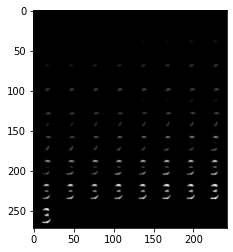

Epoch [235/400] Batch: [1/60] KL-Divergence: 0.030629169195890427 Cross-Entropy: 0.20189468562602997 Loss: 0.2325238585472107
Epoch [235/400] Batch: [2/60] KL-Divergence: 0.028696049004793167 Cross-Entropy: 0.2047785073518753 Loss: 0.23347455263137817
Epoch [235/400] Batch: [3/60] KL-Divergence: 0.029071293771266937 Cross-Entropy: 0.20517762005329132 Loss: 0.23424890637397766
Epoch [235/400] Batch: [4/60] KL-Divergence: 0.028905320912599564 Cross-Entropy: 0.20248401165008545 Loss: 0.23138932883739471
Epoch [235/400] Batch: [5/60] KL-Divergence: 0.030193042010068893 Cross-Entropy: 0.20541180670261383 Loss: 0.23560485243797302
Epoch [235/400] Batch: [6/60] KL-Divergence: 0.029520103707909584 Cross-Entropy: 0.2076936662197113 Loss: 0.23721377551555634
Epoch [235/400] Batch: [7/60] KL-Divergence: 0.02835424803197384 Cross-Entropy: 0.2048066258430481 Loss: 0.2331608682870865
Epoch [235/400] Batch: [8/60] KL-Divergence: 0.0281697828322649 Cross-Entropy: 0.2041172981262207 Loss: 0.23228707909

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [235/400] Batch: [60/60] KL-Divergence: 0.028053974732756615 Cross-Entropy: 0.2111942321062088 Loss: 0.23924820125102997
Epoch [235/400] Batch: [60/60] KL-Divergence: 0.028053974732756615 Cross-Entropy: 0.2111942321062088 Loss: 0.23924820125102997


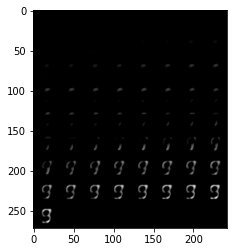

Epoch [236/400] Batch: [1/60] KL-Divergence: 0.028871972113847733 Cross-Entropy: 0.20348674058914185 Loss: 0.23235870897769928
Epoch [236/400] Batch: [2/60] KL-Divergence: 0.029180321842432022 Cross-Entropy: 0.20700670778751373 Loss: 0.23618702590465546
Epoch [236/400] Batch: [3/60] KL-Divergence: 0.028257913887500763 Cross-Entropy: 0.20551741123199463 Loss: 0.2337753176689148
Epoch [236/400] Batch: [4/60] KL-Divergence: 0.028392214328050613 Cross-Entropy: 0.20402927696704865 Loss: 0.23242148756980896
Epoch [236/400] Batch: [5/60] KL-Divergence: 0.029502205550670624 Cross-Entropy: 0.20576190948486328 Loss: 0.2352641224861145
Epoch [236/400] Batch: [6/60] KL-Divergence: 0.029474398121237755 Cross-Entropy: 0.20782329142093658 Loss: 0.2372976839542389
Epoch [236/400] Batch: [7/60] KL-Divergence: 0.02976122498512268 Cross-Entropy: 0.2056528776884079 Loss: 0.23541410267353058
Epoch [236/400] Batch: [8/60] KL-Divergence: 0.028518198058009148 Cross-Entropy: 0.20545829832553864 Loss: 0.2339764

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [236/400] Batch: [60/60] KL-Divergence: 0.03000963106751442 Cross-Entropy: 0.20907515287399292 Loss: 0.23908478021621704
Epoch [236/400] Batch: [60/60] KL-Divergence: 0.03000963106751442 Cross-Entropy: 0.20907515287399292 Loss: 0.23908478021621704


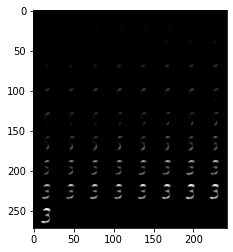

Epoch [237/400] Batch: [1/60] KL-Divergence: 0.03072333335876465 Cross-Entropy: 0.20163112878799438 Loss: 0.23235446214675903
Epoch [237/400] Batch: [2/60] KL-Divergence: 0.028949115425348282 Cross-Entropy: 0.2050093561410904 Loss: 0.23395846784114838
Epoch [237/400] Batch: [3/60] KL-Divergence: 0.030137963593006134 Cross-Entropy: 0.20548751950263977 Loss: 0.2356254756450653
Epoch [237/400] Batch: [4/60] KL-Divergence: 0.02963179163634777 Cross-Entropy: 0.20272324979305267 Loss: 0.2323550432920456
Epoch [237/400] Batch: [5/60] KL-Divergence: 0.030668925493955612 Cross-Entropy: 0.20636403560638428 Loss: 0.2370329648256302
Epoch [237/400] Batch: [6/60] KL-Divergence: 0.029503198340535164 Cross-Entropy: 0.2067105770111084 Loss: 0.2362137734889984
Epoch [237/400] Batch: [7/60] KL-Divergence: 0.029994649812579155 Cross-Entropy: 0.20352803170681 Loss: 0.2335226833820343
Epoch [237/400] Batch: [8/60] KL-Divergence: 0.02838299050927162 Cross-Entropy: 0.20420168340206146 Loss: 0.232584670186042

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [237/400] Batch: [60/60] KL-Divergence: 0.028953006491065025 Cross-Entropy: 0.21059365570545197 Loss: 0.23954665660858154
Epoch [237/400] Batch: [60/60] KL-Divergence: 0.028953006491065025 Cross-Entropy: 0.21059365570545197 Loss: 0.23954665660858154


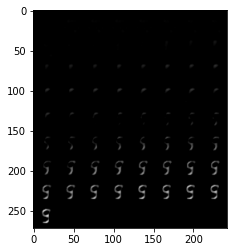

Epoch [238/400] Batch: [1/60] KL-Divergence: 0.029203783720731735 Cross-Entropy: 0.20335815846920013 Loss: 0.23256194591522217
Epoch [238/400] Batch: [2/60] KL-Divergence: 0.027901263907551765 Cross-Entropy: 0.20575793087482452 Loss: 0.23365919291973114
Epoch [238/400] Batch: [3/60] KL-Divergence: 0.027864906936883926 Cross-Entropy: 0.20599453151226044 Loss: 0.23385943472385406
Epoch [238/400] Batch: [4/60] KL-Divergence: 0.028160331770777702 Cross-Entropy: 0.20491589605808258 Loss: 0.23307622969150543
Epoch [238/400] Batch: [5/60] KL-Divergence: 0.030196795240044594 Cross-Entropy: 0.2088024914264679 Loss: 0.23899929225444794
Epoch [238/400] Batch: [6/60] KL-Divergence: 0.02866377867758274 Cross-Entropy: 0.20693200826644897 Loss: 0.23559579253196716
Epoch [238/400] Batch: [7/60] KL-Divergence: 0.02924960106611252 Cross-Entropy: 0.20528210699558258 Loss: 0.2345317006111145
Epoch [238/400] Batch: [8/60] KL-Divergence: 0.028641972690820694 Cross-Entropy: 0.20278576016426086 Loss: 0.231427

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [238/400] Batch: [60/60] KL-Divergence: 0.030118953436613083 Cross-Entropy: 0.21026110649108887 Loss: 0.24038006365299225
Epoch [238/400] Batch: [60/60] KL-Divergence: 0.030118953436613083 Cross-Entropy: 0.21026110649108887 Loss: 0.24038006365299225


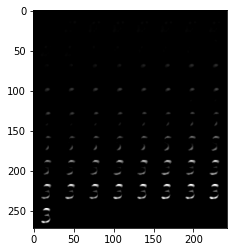

Epoch [239/400] Batch: [1/60] KL-Divergence: 0.029685119166970253 Cross-Entropy: 0.2037975788116455 Loss: 0.2334827035665512
Epoch [239/400] Batch: [2/60] KL-Divergence: 0.02856244519352913 Cross-Entropy: 0.20535597205162048 Loss: 0.23391841351985931
Epoch [239/400] Batch: [3/60] KL-Divergence: 0.02933756448328495 Cross-Entropy: 0.2062479853630066 Loss: 0.235585555434227
Epoch [239/400] Batch: [4/60] KL-Divergence: 0.029103297740221024 Cross-Entropy: 0.2035660445690155 Loss: 0.23266933858394623
Epoch [239/400] Batch: [5/60] KL-Divergence: 0.02986760623753071 Cross-Entropy: 0.2086290717124939 Loss: 0.23849667608737946
Epoch [239/400] Batch: [6/60] KL-Divergence: 0.02794472873210907 Cross-Entropy: 0.20885170996189117 Loss: 0.23679643869400024
Epoch [239/400] Batch: [7/60] KL-Divergence: 0.027934690937399864 Cross-Entropy: 0.20478464663028717 Loss: 0.2327193319797516
Epoch [239/400] Batch: [8/60] KL-Divergence: 0.02830483391880989 Cross-Entropy: 0.20556016266345978 Loss: 0.233864992856979

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [239/400] Batch: [60/60] KL-Divergence: 0.030143890529870987 Cross-Entropy: 0.21213655173778534 Loss: 0.24228043854236603
Epoch [239/400] Batch: [60/60] KL-Divergence: 0.030143890529870987 Cross-Entropy: 0.21213655173778534 Loss: 0.24228043854236603


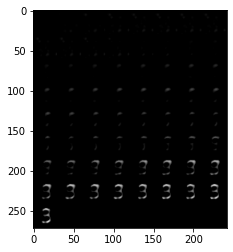

Epoch [240/400] Batch: [1/60] KL-Divergence: 0.028822416439652443 Cross-Entropy: 0.2020380198955536 Loss: 0.23086044192314148
Epoch [240/400] Batch: [2/60] KL-Divergence: 0.029330914840102196 Cross-Entropy: 0.20413047075271606 Loss: 0.2334613800048828
Epoch [240/400] Batch: [3/60] KL-Divergence: 0.02984810434281826 Cross-Entropy: 0.20492495596408844 Loss: 0.23477305471897125
Epoch [240/400] Batch: [4/60] KL-Divergence: 0.02909632958471775 Cross-Entropy: 0.20229479670524597 Loss: 0.23139113187789917
Epoch [240/400] Batch: [5/60] KL-Divergence: 0.030649762600660324 Cross-Entropy: 0.20631560683250427 Loss: 0.2369653731584549
Epoch [240/400] Batch: [6/60] KL-Divergence: 0.029742220416665077 Cross-Entropy: 0.20732632279396057 Loss: 0.2370685487985611
Epoch [240/400] Batch: [7/60] KL-Divergence: 0.02948879823088646 Cross-Entropy: 0.2041196972131729 Loss: 0.23360849916934967
Epoch [240/400] Batch: [8/60] KL-Divergence: 0.02941606193780899 Cross-Entropy: 0.20365600287914276 Loss: 0.23307207226

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [240/400] Batch: [60/60] KL-Divergence: 0.030154041945934296 Cross-Entropy: 0.20913216471672058 Loss: 0.23928621411323547
Epoch [240/400] Batch: [60/60] KL-Divergence: 0.030154041945934296 Cross-Entropy: 0.20913216471672058 Loss: 0.23928621411323547


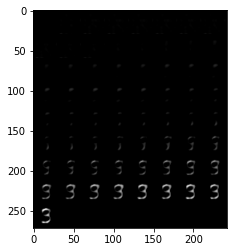

Epoch [241/400] Batch: [1/60] KL-Divergence: 0.030547432601451874 Cross-Entropy: 0.20204894244670868 Loss: 0.23259636759757996
Epoch [241/400] Batch: [2/60] KL-Divergence: 0.028945287689566612 Cross-Entropy: 0.20501577854156494 Loss: 0.2339610606431961
Epoch [241/400] Batch: [3/60] KL-Divergence: 0.029236044734716415 Cross-Entropy: 0.20559094846248627 Loss: 0.23482699692249298
Epoch [241/400] Batch: [4/60] KL-Divergence: 0.02841128781437874 Cross-Entropy: 0.2017519474029541 Loss: 0.23016323149204254
Epoch [241/400] Batch: [5/60] KL-Divergence: 0.03124314174056053 Cross-Entropy: 0.20500478148460388 Loss: 0.2362479269504547
Epoch [241/400] Batch: [6/60] KL-Divergence: 0.028800277039408684 Cross-Entropy: 0.20663128793239594 Loss: 0.23543156683444977
Epoch [241/400] Batch: [7/60] KL-Divergence: 0.029491601511836052 Cross-Entropy: 0.20336300134658813 Loss: 0.23285460472106934
Epoch [241/400] Batch: [8/60] KL-Divergence: 0.029768871143460274 Cross-Entropy: 0.20567627251148224 Loss: 0.2354451

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [241/400] Batch: [60/60] KL-Divergence: 0.02921636588871479 Cross-Entropy: 0.21153204143047333 Loss: 0.24074840545654297
Epoch [241/400] Batch: [60/60] KL-Divergence: 0.02921636588871479 Cross-Entropy: 0.21153204143047333 Loss: 0.24074840545654297


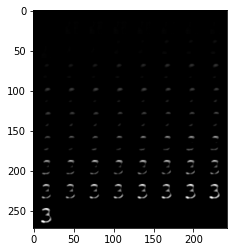

Epoch [242/400] Batch: [1/60] KL-Divergence: 0.02907150238752365 Cross-Entropy: 0.20271989703178406 Loss: 0.2317914068698883
Epoch [242/400] Batch: [2/60] KL-Divergence: 0.028093237429857254 Cross-Entropy: 0.2054472118616104 Loss: 0.23354044556617737
Epoch [242/400] Batch: [3/60] KL-Divergence: 0.028218524530529976 Cross-Entropy: 0.20552124083042145 Loss: 0.23373976349830627
Epoch [242/400] Batch: [4/60] KL-Divergence: 0.02905297465622425 Cross-Entropy: 0.20412153005599976 Loss: 0.23317450284957886
Epoch [242/400] Batch: [5/60] KL-Divergence: 0.03000548668205738 Cross-Entropy: 0.20485638082027435 Loss: 0.23486186563968658
Epoch [242/400] Batch: [6/60] KL-Divergence: 0.02960238605737686 Cross-Entropy: 0.20867928862571716 Loss: 0.23828166723251343
Epoch [242/400] Batch: [7/60] KL-Divergence: 0.028301971033215523 Cross-Entropy: 0.20373991131782532 Loss: 0.2320418804883957
Epoch [242/400] Batch: [8/60] KL-Divergence: 0.027774784713983536 Cross-Entropy: 0.20325075089931488 Loss: 0.231025531

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [242/400] Batch: [60/60] KL-Divergence: 0.028464173898100853 Cross-Entropy: 0.21285699307918549 Loss: 0.2413211613893509
Epoch [242/400] Batch: [60/60] KL-Divergence: 0.028464173898100853 Cross-Entropy: 0.21285699307918549 Loss: 0.2413211613893509


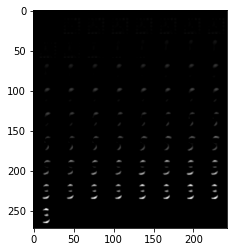

Epoch [243/400] Batch: [1/60] KL-Divergence: 0.028469914570450783 Cross-Entropy: 0.20527078211307526 Loss: 0.2337407022714615
Epoch [243/400] Batch: [2/60] KL-Divergence: 0.027781331911683083 Cross-Entropy: 0.2076777219772339 Loss: 0.23545905947685242
Epoch [243/400] Batch: [3/60] KL-Divergence: 0.02830374427139759 Cross-Entropy: 0.2063763439655304 Loss: 0.23468008637428284
Epoch [243/400] Batch: [4/60] KL-Divergence: 0.028157591819763184 Cross-Entropy: 0.20480094850063324 Loss: 0.23295854032039642
Epoch [243/400] Batch: [5/60] KL-Divergence: 0.02992108091711998 Cross-Entropy: 0.2075539231300354 Loss: 0.23747500777244568
Epoch [243/400] Batch: [6/60] KL-Divergence: 0.02904880791902542 Cross-Entropy: 0.20936597883701324 Loss: 0.23841479420661926
Epoch [243/400] Batch: [7/60] KL-Divergence: 0.027897659689188004 Cross-Entropy: 0.20490042865276337 Loss: 0.23279808461666107
Epoch [243/400] Batch: [8/60] KL-Divergence: 0.02807459980249405 Cross-Entropy: 0.20465880632400513 Loss: 0.2327333986

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [243/400] Batch: [60/60] KL-Divergence: 0.029349040240049362 Cross-Entropy: 0.21246716380119324 Loss: 0.2418162077665329
Epoch [243/400] Batch: [60/60] KL-Divergence: 0.029349040240049362 Cross-Entropy: 0.21246716380119324 Loss: 0.2418162077665329


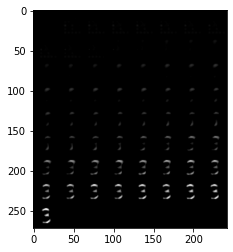

Epoch [244/400] Batch: [1/60] KL-Divergence: 0.028630170971155167 Cross-Entropy: 0.20325608551502228 Loss: 0.23188625276088715
Epoch [244/400] Batch: [2/60] KL-Divergence: 0.02815975435078144 Cross-Entropy: 0.2066429853439331 Loss: 0.2348027378320694
Epoch [244/400] Batch: [3/60] KL-Divergence: 0.029178399592638016 Cross-Entropy: 0.20648038387298584 Loss: 0.23565877974033356
Epoch [244/400] Batch: [4/60] KL-Divergence: 0.029553914442658424 Cross-Entropy: 0.20361170172691345 Loss: 0.23316562175750732
Epoch [244/400] Batch: [5/60] KL-Divergence: 0.031241945922374725 Cross-Entropy: 0.20657789707183838 Loss: 0.2378198504447937
Epoch [244/400] Batch: [6/60] KL-Divergence: 0.028646200895309448 Cross-Entropy: 0.20718789100646973 Loss: 0.23583409190177917
Epoch [244/400] Batch: [7/60] KL-Divergence: 0.028431497514247894 Cross-Entropy: 0.20364966988563538 Loss: 0.23208117485046387
Epoch [244/400] Batch: [8/60] KL-Divergence: 0.028311029076576233 Cross-Entropy: 0.20384545624256134 Loss: 0.232156

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [244/400] Batch: [60/60] KL-Divergence: 0.029203085228800774 Cross-Entropy: 0.20782117545604706 Loss: 0.23702426254749298
Epoch [244/400] Batch: [60/60] KL-Divergence: 0.029203085228800774 Cross-Entropy: 0.20782117545604706 Loss: 0.23702426254749298


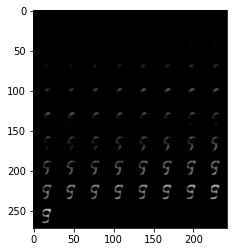

Epoch [245/400] Batch: [1/60] KL-Divergence: 0.03031330741941929 Cross-Entropy: 0.20103415846824646 Loss: 0.2313474714756012
Epoch [245/400] Batch: [2/60] KL-Divergence: 0.029446683824062347 Cross-Entropy: 0.20307151973247528 Loss: 0.23251819610595703
Epoch [245/400] Batch: [3/60] KL-Divergence: 0.030136404559016228 Cross-Entropy: 0.2037580907344818 Loss: 0.2338944971561432
Epoch [245/400] Batch: [4/60] KL-Divergence: 0.029540639370679855 Cross-Entropy: 0.20142631232738495 Loss: 0.2309669554233551
Epoch [245/400] Batch: [5/60] KL-Divergence: 0.03089567832648754 Cross-Entropy: 0.2045833170413971 Loss: 0.23547899723052979
Epoch [245/400] Batch: [6/60] KL-Divergence: 0.030132558196783066 Cross-Entropy: 0.20526696741580963 Loss: 0.235399529337883
Epoch [245/400] Batch: [7/60] KL-Divergence: 0.029776688665151596 Cross-Entropy: 0.20113027095794678 Loss: 0.23090696334838867
Epoch [245/400] Batch: [8/60] KL-Divergence: 0.028812451288104057 Cross-Entropy: 0.20239336788654327 Loss: 0.23120582103

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [245/400] Batch: [60/60] KL-Divergence: 0.02931239642202854 Cross-Entropy: 0.20932839810848236 Loss: 0.23864080011844635
Epoch [245/400] Batch: [60/60] KL-Divergence: 0.02931239642202854 Cross-Entropy: 0.20932839810848236 Loss: 0.23864080011844635


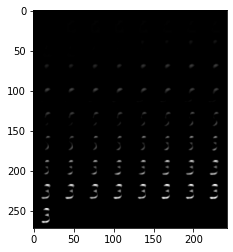

Epoch [246/400] Batch: [1/60] KL-Divergence: 0.02919553592801094 Cross-Entropy: 0.2030482441186905 Loss: 0.23224377632141113
Epoch [246/400] Batch: [2/60] KL-Divergence: 0.028993824496865273 Cross-Entropy: 0.20565590262413025 Loss: 0.23464973270893097
Epoch [246/400] Batch: [3/60] KL-Divergence: 0.028217367827892303 Cross-Entropy: 0.2069690227508545 Loss: 0.2351863980293274
Epoch [246/400] Batch: [4/60] KL-Divergence: 0.028866950422525406 Cross-Entropy: 0.20255519449710846 Loss: 0.23142214119434357
Epoch [246/400] Batch: [5/60] KL-Divergence: 0.03170401230454445 Cross-Entropy: 0.20826520025730133 Loss: 0.23996920883655548
Epoch [246/400] Batch: [6/60] KL-Divergence: 0.029537959024310112 Cross-Entropy: 0.20797492563724518 Loss: 0.23751288652420044
Epoch [246/400] Batch: [7/60] KL-Divergence: 0.028568558394908905 Cross-Entropy: 0.20398050546646118 Loss: 0.23254907131195068
Epoch [246/400] Batch: [8/60] KL-Divergence: 0.028952699154615402 Cross-Entropy: 0.20353151857852936 Loss: 0.2324842

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [246/400] Batch: [60/60] KL-Divergence: 0.03039875440299511 Cross-Entropy: 0.2090955376625061 Loss: 0.23949429392814636
Epoch [246/400] Batch: [60/60] KL-Divergence: 0.03039875440299511 Cross-Entropy: 0.2090955376625061 Loss: 0.23949429392814636


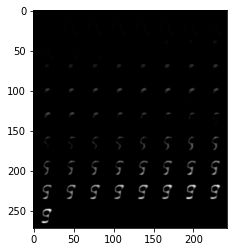

Epoch [247/400] Batch: [1/60] KL-Divergence: 0.028869759291410446 Cross-Entropy: 0.20111213624477386 Loss: 0.2299818992614746
Epoch [247/400] Batch: [2/60] KL-Divergence: 0.029433751478791237 Cross-Entropy: 0.20543666183948517 Loss: 0.23487041890621185
Epoch [247/400] Batch: [3/60] KL-Divergence: 0.03052813932299614 Cross-Entropy: 0.20518390834331512 Loss: 0.23571205139160156
Epoch [247/400] Batch: [4/60] KL-Divergence: 0.029470480978488922 Cross-Entropy: 0.20214390754699707 Loss: 0.2316143810749054
Epoch [247/400] Batch: [5/60] KL-Divergence: 0.031234899535775185 Cross-Entropy: 0.20495033264160156 Loss: 0.2361852377653122
Epoch [247/400] Batch: [6/60] KL-Divergence: 0.031008778139948845 Cross-Entropy: 0.20541945099830627 Loss: 0.23642823100090027
Epoch [247/400] Batch: [7/60] KL-Divergence: 0.029121968895196915 Cross-Entropy: 0.20187950134277344 Loss: 0.23100146651268005
Epoch [247/400] Batch: [8/60] KL-Divergence: 0.028454964980483055 Cross-Entropy: 0.2036258429288864 Loss: 0.2320808

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [247/400] Batch: [60/60] KL-Divergence: 0.02445342019200325 Cross-Entropy: 0.22151553630828857 Loss: 0.24596895277500153
Epoch [247/400] Batch: [60/60] KL-Divergence: 0.02445342019200325 Cross-Entropy: 0.22151553630828857 Loss: 0.24596895277500153


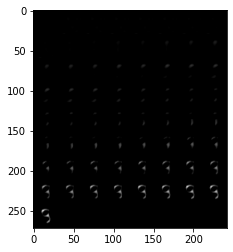

Epoch [248/400] Batch: [1/60] KL-Divergence: 0.02577248029410839 Cross-Entropy: 0.21154668927192688 Loss: 0.23731917142868042
Epoch [248/400] Batch: [2/60] KL-Divergence: 0.024725472554564476 Cross-Entropy: 0.21284663677215576 Loss: 0.2375721037387848
Epoch [248/400] Batch: [3/60] KL-Divergence: 0.02658700942993164 Cross-Entropy: 0.21306516230106354 Loss: 0.23965217173099518
Epoch [248/400] Batch: [4/60] KL-Divergence: 0.026638422161340714 Cross-Entropy: 0.21080493927001953 Loss: 0.23744335770606995
Epoch [248/400] Batch: [5/60] KL-Divergence: 0.02769879624247551 Cross-Entropy: 0.21494249999523163 Loss: 0.24264129996299744
Epoch [248/400] Batch: [6/60] KL-Divergence: 0.026664555072784424 Cross-Entropy: 0.21486271917819977 Loss: 0.2415272742509842
Epoch [248/400] Batch: [7/60] KL-Divergence: 0.02651614136993885 Cross-Entropy: 0.2110871523618698 Loss: 0.2376032918691635
Epoch [248/400] Batch: [8/60] KL-Divergence: 0.025210658088326454 Cross-Entropy: 0.2084045708179474 Loss: 0.23361523449

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [248/400] Batch: [60/60] KL-Divergence: 0.028983743861317635 Cross-Entropy: 0.21102061867713928 Loss: 0.24000436067581177
Epoch [248/400] Batch: [60/60] KL-Divergence: 0.028983743861317635 Cross-Entropy: 0.21102061867713928 Loss: 0.24000436067581177


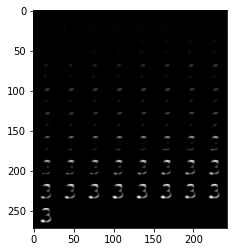

Epoch [249/400] Batch: [1/60] KL-Divergence: 0.028612328693270683 Cross-Entropy: 0.20269756019115448 Loss: 0.2313098907470703
Epoch [249/400] Batch: [2/60] KL-Divergence: 0.028768690302968025 Cross-Entropy: 0.20539863407611847 Loss: 0.23416732251644135
Epoch [249/400] Batch: [3/60] KL-Divergence: 0.029182787984609604 Cross-Entropy: 0.20605994760990143 Loss: 0.23524273931980133
Epoch [249/400] Batch: [4/60] KL-Divergence: 0.02840287983417511 Cross-Entropy: 0.2031766176223755 Loss: 0.2315794974565506
Epoch [249/400] Batch: [5/60] KL-Divergence: 0.029661815613508224 Cross-Entropy: 0.20531177520751953 Loss: 0.23497359454631805
Epoch [249/400] Batch: [6/60] KL-Divergence: 0.0292783435434103 Cross-Entropy: 0.2075936645269394 Loss: 0.23687200248241425
Epoch [249/400] Batch: [7/60] KL-Divergence: 0.028739633038640022 Cross-Entropy: 0.2051970660686493 Loss: 0.23393669724464417
Epoch [249/400] Batch: [8/60] KL-Divergence: 0.0291746873408556 Cross-Entropy: 0.20399320125579834 Loss: 0.233167886734

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [249/400] Batch: [60/60] KL-Divergence: 0.02994588017463684 Cross-Entropy: 0.2080068439245224 Loss: 0.23795272409915924
Epoch [249/400] Batch: [60/60] KL-Divergence: 0.02994588017463684 Cross-Entropy: 0.2080068439245224 Loss: 0.23795272409915924


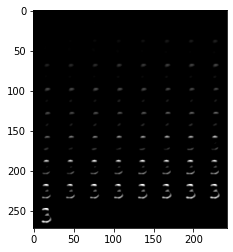

Epoch [250/400] Batch: [1/60] KL-Divergence: 0.030249325558543205 Cross-Entropy: 0.20122268795967102 Loss: 0.23147201538085938
Epoch [250/400] Batch: [2/60] KL-Divergence: 0.02940421737730503 Cross-Entropy: 0.2041700780391693 Loss: 0.2335743010044098
Epoch [250/400] Batch: [3/60] KL-Divergence: 0.030119843780994415 Cross-Entropy: 0.20425689220428467 Loss: 0.2343767285346985
Epoch [250/400] Batch: [4/60] KL-Divergence: 0.02928411029279232 Cross-Entropy: 0.20123684406280518 Loss: 0.23052094876766205
Epoch [250/400] Batch: [5/60] KL-Divergence: 0.030875463038682938 Cross-Entropy: 0.2057962715625763 Loss: 0.23667173087596893
Epoch [250/400] Batch: [6/60] KL-Divergence: 0.02923642098903656 Cross-Entropy: 0.2062997817993164 Loss: 0.23553620278835297
Epoch [250/400] Batch: [7/60] KL-Divergence: 0.028727993369102478 Cross-Entropy: 0.20294189453125 Loss: 0.23166988790035248
Epoch [250/400] Batch: [8/60] KL-Divergence: 0.028693368658423424 Cross-Entropy: 0.20195382833480835 Loss: 0.2306471914052

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [250/400] Batch: [60/60] KL-Divergence: 0.02999858744442463 Cross-Entropy: 0.20888224244117737 Loss: 0.23888082802295685
Epoch [250/400] Batch: [60/60] KL-Divergence: 0.02999858744442463 Cross-Entropy: 0.20888224244117737 Loss: 0.23888082802295685


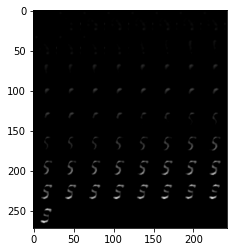

Epoch [251/400] Batch: [1/60] KL-Divergence: 0.02898261696100235 Cross-Entropy: 0.20122037827968597 Loss: 0.23020300269126892
Epoch [251/400] Batch: [2/60] KL-Divergence: 0.029284916818141937 Cross-Entropy: 0.2047404646873474 Loss: 0.23402538895606995
Epoch [251/400] Batch: [3/60] KL-Divergence: 0.02954319678246975 Cross-Entropy: 0.20418880879878998 Loss: 0.23373199999332428
Epoch [251/400] Batch: [4/60] KL-Divergence: 0.028901388868689537 Cross-Entropy: 0.2028513103723526 Loss: 0.2317526936531067
Epoch [251/400] Batch: [5/60] KL-Divergence: 0.03183358162641525 Cross-Entropy: 0.20535796880722046 Loss: 0.2371915578842163
Epoch [251/400] Batch: [6/60] KL-Divergence: 0.030321599915623665 Cross-Entropy: 0.20583704113960266 Loss: 0.23615863919258118
Epoch [251/400] Batch: [7/60] KL-Divergence: 0.029969090595841408 Cross-Entropy: 0.20176661014556885 Loss: 0.2317357063293457
Epoch [251/400] Batch: [8/60] KL-Divergence: 0.029329296201467514 Cross-Entropy: 0.2028069943189621 Loss: 0.23213629424

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [251/400] Batch: [60/60] KL-Divergence: 0.030734077095985413 Cross-Entropy: 0.21011041104793549 Loss: 0.2408444881439209
Epoch [251/400] Batch: [60/60] KL-Divergence: 0.030734077095985413 Cross-Entropy: 0.21011041104793549 Loss: 0.2408444881439209


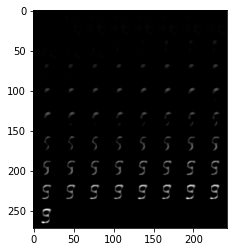

Epoch [252/400] Batch: [1/60] KL-Divergence: 0.030542613938450813 Cross-Entropy: 0.20227478444576263 Loss: 0.2328173965215683
Epoch [252/400] Batch: [2/60] KL-Divergence: 0.029127325862646103 Cross-Entropy: 0.20537646114826202 Loss: 0.23450379073619843
Epoch [252/400] Batch: [3/60] KL-Divergence: 0.03005100227892399 Cross-Entropy: 0.2060120552778244 Loss: 0.23606306314468384
Epoch [252/400] Batch: [4/60] KL-Divergence: 0.028669333085417747 Cross-Entropy: 0.20239031314849854 Loss: 0.23105964064598083
Epoch [252/400] Batch: [5/60] KL-Divergence: 0.030209535732865334 Cross-Entropy: 0.20722758769989014 Loss: 0.23743712902069092
Epoch [252/400] Batch: [6/60] KL-Divergence: 0.030348462983965874 Cross-Entropy: 0.20796096324920654 Loss: 0.23830942809581757
Epoch [252/400] Batch: [7/60] KL-Divergence: 0.029085008427500725 Cross-Entropy: 0.2042793333530426 Loss: 0.23336434364318848
Epoch [252/400] Batch: [8/60] KL-Divergence: 0.02882343716919422 Cross-Entropy: 0.20351803302764893 Loss: 0.2323414

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [252/400] Batch: [60/60] KL-Divergence: 0.030585261061787605 Cross-Entropy: 0.2078503519296646 Loss: 0.23843561112880707
Epoch [252/400] Batch: [60/60] KL-Divergence: 0.030585261061787605 Cross-Entropy: 0.2078503519296646 Loss: 0.23843561112880707


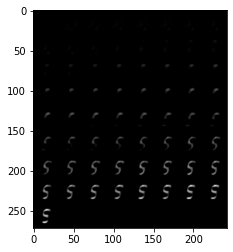

Epoch [253/400] Batch: [1/60] KL-Divergence: 0.03070957399904728 Cross-Entropy: 0.20134244859218597 Loss: 0.2320520281791687
Epoch [253/400] Batch: [2/60] KL-Divergence: 0.030130872502923012 Cross-Entropy: 0.20439109206199646 Loss: 0.23452197015285492
Epoch [253/400] Batch: [3/60] KL-Divergence: 0.030098551884293556 Cross-Entropy: 0.20437662303447723 Loss: 0.23447518050670624
Epoch [253/400] Batch: [4/60] KL-Divergence: 0.0291712936013937 Cross-Entropy: 0.20233508944511414 Loss: 0.2315063774585724
Epoch [253/400] Batch: [5/60] KL-Divergence: 0.030623113736510277 Cross-Entropy: 0.20577691495418549 Loss: 0.23640002310276031
Epoch [253/400] Batch: [6/60] KL-Divergence: 0.029400575906038284 Cross-Entropy: 0.20878662168979645 Loss: 0.23818719387054443
Epoch [253/400] Batch: [7/60] KL-Divergence: 0.02844625897705555 Cross-Entropy: 0.2050231248140335 Loss: 0.2334693819284439
Epoch [253/400] Batch: [8/60] KL-Divergence: 0.028677059337496758 Cross-Entropy: 0.2054080218076706 Loss: 0.23408508300

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [253/400] Batch: [60/60] KL-Divergence: 0.030380243435502052 Cross-Entropy: 0.20986120402812958 Loss: 0.24024145305156708
Epoch [253/400] Batch: [60/60] KL-Divergence: 0.030380243435502052 Cross-Entropy: 0.20986120402812958 Loss: 0.24024145305156708


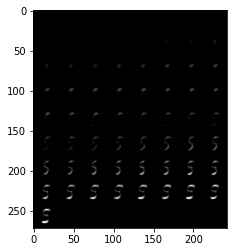

Epoch [254/400] Batch: [1/60] KL-Divergence: 0.03118397854268551 Cross-Entropy: 0.20357510447502136 Loss: 0.23475907742977142
Epoch [254/400] Batch: [2/60] KL-Divergence: 0.030233923345804214 Cross-Entropy: 0.20587392151355743 Loss: 0.23610784113407135
Epoch [254/400] Batch: [3/60] KL-Divergence: 0.029761681333184242 Cross-Entropy: 0.20494726300239563 Loss: 0.23470894992351532
Epoch [254/400] Batch: [4/60] KL-Divergence: 0.030169619247317314 Cross-Entropy: 0.2029898464679718 Loss: 0.23315946757793427
Epoch [254/400] Batch: [5/60] KL-Divergence: 0.03238297626376152 Cross-Entropy: 0.20521555840969086 Loss: 0.23759853839874268
Epoch [254/400] Batch: [6/60] KL-Divergence: 0.029915690422058105 Cross-Entropy: 0.20748324692249298 Loss: 0.2373989373445511
Epoch [254/400] Batch: [7/60] KL-Divergence: 0.02927660569548607 Cross-Entropy: 0.20404814183712006 Loss: 0.23332475125789642
Epoch [254/400] Batch: [8/60] KL-Divergence: 0.028712602332234383 Cross-Entropy: 0.20178844034671783 Loss: 0.2305010

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [254/400] Batch: [60/60] KL-Divergence: 0.030132558196783066 Cross-Entropy: 0.2089201956987381 Loss: 0.23905275762081146
Epoch [254/400] Batch: [60/60] KL-Divergence: 0.030132558196783066 Cross-Entropy: 0.2089201956987381 Loss: 0.23905275762081146


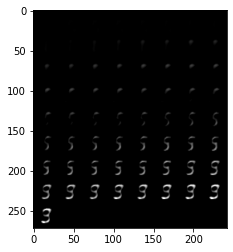

Epoch [255/400] Batch: [1/60] KL-Divergence: 0.029539013281464577 Cross-Entropy: 0.20181110501289368 Loss: 0.2313501238822937
Epoch [255/400] Batch: [2/60] KL-Divergence: 0.02925838716328144 Cross-Entropy: 0.2043081820011139 Loss: 0.23356656730175018
Epoch [255/400] Batch: [3/60] KL-Divergence: 0.029059791937470436 Cross-Entropy: 0.20425039529800415 Loss: 0.23331019282341003
Epoch [255/400] Batch: [4/60] KL-Divergence: 0.02995239943265915 Cross-Entropy: 0.2029368132352829 Loss: 0.23288920521736145
Epoch [255/400] Batch: [5/60] KL-Divergence: 0.029670126736164093 Cross-Entropy: 0.2052098512649536 Loss: 0.2348799705505371
Epoch [255/400] Batch: [6/60] KL-Divergence: 0.02950100600719452 Cross-Entropy: 0.20732058584690094 Loss: 0.23682159185409546
Epoch [255/400] Batch: [7/60] KL-Divergence: 0.02890625223517418 Cross-Entropy: 0.20349334180355072 Loss: 0.2323995977640152
Epoch [255/400] Batch: [8/60] KL-Divergence: 0.028988173231482506 Cross-Entropy: 0.20447129011154175 Loss: 0.233459457755

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [255/400] Batch: [60/60] KL-Divergence: 0.03111414983868599 Cross-Entropy: 0.20709972083568573 Loss: 0.23821386694908142
Epoch [255/400] Batch: [60/60] KL-Divergence: 0.03111414983868599 Cross-Entropy: 0.20709972083568573 Loss: 0.23821386694908142


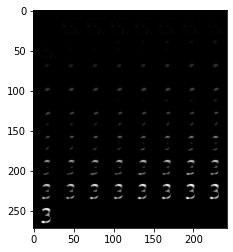

Epoch [256/400] Batch: [1/60] KL-Divergence: 0.03079436533153057 Cross-Entropy: 0.1991109997034073 Loss: 0.229905366897583
Epoch [256/400] Batch: [2/60] KL-Divergence: 0.029347436502575874 Cross-Entropy: 0.204162135720253 Loss: 0.23350957036018372
Epoch [256/400] Batch: [3/60] KL-Divergence: 0.0296506118029356 Cross-Entropy: 0.20413890480995178 Loss: 0.23378951847553253
Epoch [256/400] Batch: [4/60] KL-Divergence: 0.029301874339580536 Cross-Entropy: 0.2015811651945114 Loss: 0.23088303208351135
Epoch [256/400] Batch: [5/60] KL-Divergence: 0.03037167899310589 Cross-Entropy: 0.20491774380207062 Loss: 0.23528942465782166
Epoch [256/400] Batch: [6/60] KL-Divergence: 0.029682356864213943 Cross-Entropy: 0.20484310388565063 Loss: 0.23452545702457428
Epoch [256/400] Batch: [7/60] KL-Divergence: 0.03027360327541828 Cross-Entropy: 0.20362132787704468 Loss: 0.2338949292898178
Epoch [256/400] Batch: [8/60] KL-Divergence: 0.028215724974870682 Cross-Entropy: 0.20271091163158417 Loss: 0.23092663288116

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [256/400] Batch: [60/60] KL-Divergence: 0.025565175339579582 Cross-Entropy: 0.21703195571899414 Loss: 0.24259713292121887
Epoch [256/400] Batch: [60/60] KL-Divergence: 0.025565175339579582 Cross-Entropy: 0.21703195571899414 Loss: 0.24259713292121887


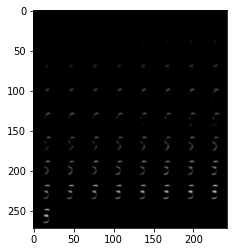

Epoch [257/400] Batch: [1/60] KL-Divergence: 0.026398364454507828 Cross-Entropy: 0.20827004313468933 Loss: 0.23466840386390686
Epoch [257/400] Batch: [2/60] KL-Divergence: 0.025606825947761536 Cross-Entropy: 0.21193227171897888 Loss: 0.23753909766674042
Epoch [257/400] Batch: [3/60] KL-Divergence: 0.026479534804821014 Cross-Entropy: 0.21132580935955048 Loss: 0.2378053367137909
Epoch [257/400] Batch: [4/60] KL-Divergence: 0.026805177330970764 Cross-Entropy: 0.20848795771598816 Loss: 0.23529313504695892
Epoch [257/400] Batch: [5/60] KL-Divergence: 0.028916580602526665 Cross-Entropy: 0.2136029452085495 Loss: 0.2425195276737213
Epoch [257/400] Batch: [6/60] KL-Divergence: 0.02764328010380268 Cross-Entropy: 0.21200250089168549 Loss: 0.23964577913284302
Epoch [257/400] Batch: [7/60] KL-Divergence: 0.027303768321871758 Cross-Entropy: 0.20758792757987976 Loss: 0.23489169776439667
Epoch [257/400] Batch: [8/60] KL-Divergence: 0.026371289044618607 Cross-Entropy: 0.20682278275489807 Loss: 0.233194

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [257/400] Batch: [60/60] KL-Divergence: 0.030098510906100273 Cross-Entropy: 0.20942887663841248 Loss: 0.2395273894071579
Epoch [257/400] Batch: [60/60] KL-Divergence: 0.030098510906100273 Cross-Entropy: 0.20942887663841248 Loss: 0.2395273894071579


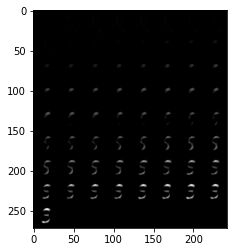

Epoch [258/400] Batch: [1/60] KL-Divergence: 0.029804086312651634 Cross-Entropy: 0.20062844455242157 Loss: 0.23043252527713776
Epoch [258/400] Batch: [2/60] KL-Divergence: 0.0296971183270216 Cross-Entropy: 0.20442213118076324 Loss: 0.23411925137043
Epoch [258/400] Batch: [3/60] KL-Divergence: 0.030401259660720825 Cross-Entropy: 0.20449329912662506 Loss: 0.2348945587873459
Epoch [258/400] Batch: [4/60] KL-Divergence: 0.029881034046411514 Cross-Entropy: 0.20234714448451996 Loss: 0.23222817480564117
Epoch [258/400] Batch: [5/60] KL-Divergence: 0.031236689537763596 Cross-Entropy: 0.2058398574590683 Loss: 0.2370765507221222
Epoch [258/400] Batch: [6/60] KL-Divergence: 0.0306295957416296 Cross-Entropy: 0.20634177327156067 Loss: 0.23697136342525482
Epoch [258/400] Batch: [7/60] KL-Divergence: 0.029923763126134872 Cross-Entropy: 0.20443779230117798 Loss: 0.23436155915260315
Epoch [258/400] Batch: [8/60] KL-Divergence: 0.028911102563142776 Cross-Entropy: 0.2035357803106308 Loss: 0.2324468791484

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [258/400] Batch: [60/60] KL-Divergence: 0.027548251673579216 Cross-Entropy: 0.21393665671348572 Loss: 0.24148491024971008
Epoch [258/400] Batch: [60/60] KL-Divergence: 0.027548251673579216 Cross-Entropy: 0.21393665671348572 Loss: 0.24148491024971008


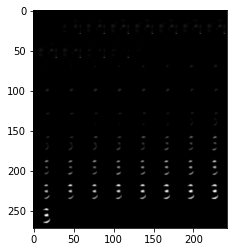

Epoch [259/400] Batch: [1/60] KL-Divergence: 0.02718055061995983 Cross-Entropy: 0.20668861269950867 Loss: 0.23386916518211365
Epoch [259/400] Batch: [2/60] KL-Divergence: 0.027894821017980576 Cross-Entropy: 0.20963343977928162 Loss: 0.2375282645225525
Epoch [259/400] Batch: [3/60] KL-Divergence: 0.026917340233922005 Cross-Entropy: 0.21090549230575562 Loss: 0.23782283067703247
Epoch [259/400] Batch: [4/60] KL-Divergence: 0.027005141600966454 Cross-Entropy: 0.20672371983528137 Loss: 0.23372885584831238
Epoch [259/400] Batch: [5/60] KL-Divergence: 0.028669873252511024 Cross-Entropy: 0.21109585464000702 Loss: 0.2397657334804535
Epoch [259/400] Batch: [6/60] KL-Divergence: 0.028263283893465996 Cross-Entropy: 0.2110685557126999 Loss: 0.23933184146881104
Epoch [259/400] Batch: [7/60] KL-Divergence: 0.02725830487906933 Cross-Entropy: 0.20851679146289825 Loss: 0.23577509820461273
Epoch [259/400] Batch: [8/60] KL-Divergence: 0.02718975953757763 Cross-Entropy: 0.2067776620388031 Loss: 0.233967423

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [259/400] Batch: [60/60] KL-Divergence: 0.029093114659190178 Cross-Entropy: 0.20860826969146729 Loss: 0.2377013862133026
Epoch [259/400] Batch: [60/60] KL-Divergence: 0.029093114659190178 Cross-Entropy: 0.20860826969146729 Loss: 0.2377013862133026


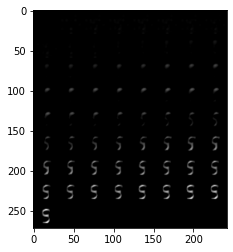

Epoch [260/400] Batch: [1/60] KL-Divergence: 0.029185956344008446 Cross-Entropy: 0.20281656086444855 Loss: 0.23200251162052155
Epoch [260/400] Batch: [2/60] KL-Divergence: 0.0290447436273098 Cross-Entropy: 0.2042582780122757 Loss: 0.2333030253648758
Epoch [260/400] Batch: [3/60] KL-Divergence: 0.028854239732027054 Cross-Entropy: 0.2058425396680832 Loss: 0.23469677567481995
Epoch [260/400] Batch: [4/60] KL-Divergence: 0.029989760369062424 Cross-Entropy: 0.20246927440166473 Loss: 0.23245903849601746
Epoch [260/400] Batch: [5/60] KL-Divergence: 0.031178642064332962 Cross-Entropy: 0.20652103424072266 Loss: 0.23769967257976532
Epoch [260/400] Batch: [6/60] KL-Divergence: 0.03058166243135929 Cross-Entropy: 0.21027019619941711 Loss: 0.24085186421871185
Epoch [260/400] Batch: [7/60] KL-Divergence: 0.02925810031592846 Cross-Entropy: 0.2067713439464569 Loss: 0.23602944612503052
Epoch [260/400] Batch: [8/60] KL-Divergence: 0.029035251587629318 Cross-Entropy: 0.20735496282577515 Loss: 0.2363902181

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [260/400] Batch: [60/60] KL-Divergence: 0.03085823729634285 Cross-Entropy: 0.20914484560489655 Loss: 0.2400030791759491
Epoch [260/400] Batch: [60/60] KL-Divergence: 0.03085823729634285 Cross-Entropy: 0.20914484560489655 Loss: 0.2400030791759491


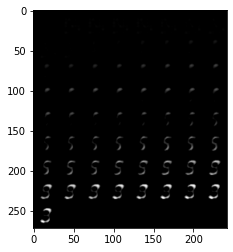

Epoch [261/400] Batch: [1/60] KL-Divergence: 0.03135420382022858 Cross-Entropy: 0.20171721279621124 Loss: 0.23307141661643982
Epoch [261/400] Batch: [2/60] KL-Divergence: 0.028945541009306908 Cross-Entropy: 0.20360267162322998 Loss: 0.23254820704460144
Epoch [261/400] Batch: [3/60] KL-Divergence: 0.030235521495342255 Cross-Entropy: 0.20420469343662262 Loss: 0.23444020748138428
Epoch [261/400] Batch: [4/60] KL-Divergence: 0.029553236439824104 Cross-Entropy: 0.20072221755981445 Loss: 0.2302754521369934
Epoch [261/400] Batch: [5/60] KL-Divergence: 0.031522370874881744 Cross-Entropy: 0.2052055299282074 Loss: 0.23672789335250854
Epoch [261/400] Batch: [6/60] KL-Divergence: 0.030887475237250328 Cross-Entropy: 0.2057509422302246 Loss: 0.2366384118795395
Epoch [261/400] Batch: [7/60] KL-Divergence: 0.029822763055562973 Cross-Entropy: 0.20148874819278717 Loss: 0.23131151497364044
Epoch [261/400] Batch: [8/60] KL-Divergence: 0.028724774718284607 Cross-Entropy: 0.20212695002555847 Loss: 0.2308517

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [261/400] Batch: [60/60] KL-Divergence: 0.03030340187251568 Cross-Entropy: 0.2084040492773056 Loss: 0.23870745301246643
Epoch [261/400] Batch: [60/60] KL-Divergence: 0.03030340187251568 Cross-Entropy: 0.2084040492773056 Loss: 0.23870745301246643


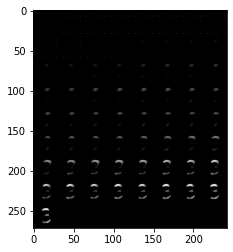

Epoch [262/400] Batch: [1/60] KL-Divergence: 0.029968222603201866 Cross-Entropy: 0.20132820308208466 Loss: 0.23129642009735107
Epoch [262/400] Batch: [2/60] KL-Divergence: 0.02940811961889267 Cross-Entropy: 0.2038622796535492 Loss: 0.23327040672302246
Epoch [262/400] Batch: [3/60] KL-Divergence: 0.02977661043405533 Cross-Entropy: 0.20294338464736938 Loss: 0.23271998763084412
Epoch [262/400] Batch: [4/60] KL-Divergence: 0.030571913346648216 Cross-Entropy: 0.20099444687366486 Loss: 0.23156635463237762
Epoch [262/400] Batch: [5/60] KL-Divergence: 0.030893830582499504 Cross-Entropy: 0.20525270700454712 Loss: 0.23614653944969177
Epoch [262/400] Batch: [6/60] KL-Divergence: 0.030019912868738174 Cross-Entropy: 0.20498499274253845 Loss: 0.23500490188598633
Epoch [262/400] Batch: [7/60] KL-Divergence: 0.029847264289855957 Cross-Entropy: 0.20097588002681732 Loss: 0.23082314431667328
Epoch [262/400] Batch: [8/60] KL-Divergence: 0.02816851995885372 Cross-Entropy: 0.2019111067056656 Loss: 0.2300796

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [262/400] Batch: [60/60] KL-Divergence: 0.03221831098198891 Cross-Entropy: 0.20780394971370697 Loss: 0.24002225697040558
Epoch [262/400] Batch: [60/60] KL-Divergence: 0.03221831098198891 Cross-Entropy: 0.20780394971370697 Loss: 0.24002225697040558


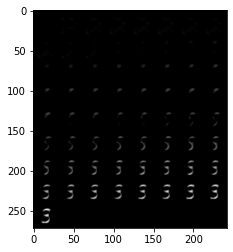

Epoch [263/400] Batch: [1/60] KL-Divergence: 0.03132232278585434 Cross-Entropy: 0.20001840591430664 Loss: 0.23134073615074158
Epoch [263/400] Batch: [2/60] KL-Divergence: 0.031001068651676178 Cross-Entropy: 0.20288901031017303 Loss: 0.2338900864124298
Epoch [263/400] Batch: [3/60] KL-Divergence: 0.03077322244644165 Cross-Entropy: 0.203611359000206 Loss: 0.23438458144664764
Epoch [263/400] Batch: [4/60] KL-Divergence: 0.02986248955130577 Cross-Entropy: 0.20205280184745789 Loss: 0.23191529512405396
Epoch [263/400] Batch: [5/60] KL-Divergence: 0.030575064942240715 Cross-Entropy: 0.2072218954563141 Loss: 0.23779696226119995
Epoch [263/400] Batch: [6/60] KL-Divergence: 0.030162809416651726 Cross-Entropy: 0.20606616139411926 Loss: 0.23622897267341614
Epoch [263/400] Batch: [7/60] KL-Divergence: 0.02923053875565529 Cross-Entropy: 0.2015073448419571 Loss: 0.23073787987232208
Epoch [263/400] Batch: [8/60] KL-Divergence: 0.029491551220417023 Cross-Entropy: 0.20310814678668976 Loss: 0.23259970545

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [263/400] Batch: [60/60] KL-Divergence: 0.030223781242966652 Cross-Entropy: 0.21130824089050293 Loss: 0.24153202772140503
Epoch [263/400] Batch: [60/60] KL-Divergence: 0.030223781242966652 Cross-Entropy: 0.21130824089050293 Loss: 0.24153202772140503


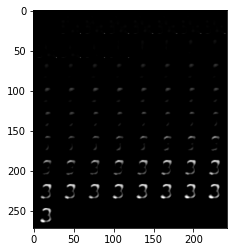

Epoch [264/400] Batch: [1/60] KL-Divergence: 0.028958911076188087 Cross-Entropy: 0.20257973670959473 Loss: 0.23153865337371826
Epoch [264/400] Batch: [2/60] KL-Divergence: 0.028954345732927322 Cross-Entropy: 0.20652154088020325 Loss: 0.23547588288784027
Epoch [264/400] Batch: [3/60] KL-Divergence: 0.028622953221201897 Cross-Entropy: 0.2055414468050003 Loss: 0.23416440188884735
Epoch [264/400] Batch: [4/60] KL-Divergence: 0.028881071135401726 Cross-Entropy: 0.20227442681789398 Loss: 0.23115549981594086
Epoch [264/400] Batch: [5/60] KL-Divergence: 0.03088133968412876 Cross-Entropy: 0.2051953375339508 Loss: 0.23607668280601501
Epoch [264/400] Batch: [6/60] KL-Divergence: 0.028972186148166656 Cross-Entropy: 0.2060839980840683 Loss: 0.23505619168281555
Epoch [264/400] Batch: [7/60] KL-Divergence: 0.029454847797751427 Cross-Entropy: 0.20364414155483246 Loss: 0.23309898376464844
Epoch [264/400] Batch: [8/60] KL-Divergence: 0.028223944827914238 Cross-Entropy: 0.20329618453979492 Loss: 0.231520

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [264/400] Batch: [60/60] KL-Divergence: 0.02677789516746998 Cross-Entropy: 0.21698689460754395 Loss: 0.24376478791236877
Epoch [264/400] Batch: [60/60] KL-Divergence: 0.02677789516746998 Cross-Entropy: 0.21698689460754395 Loss: 0.24376478791236877


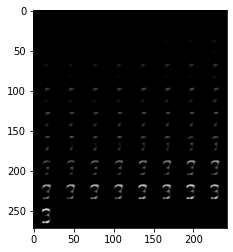

Epoch [265/400] Batch: [1/60] KL-Divergence: 0.026564456522464752 Cross-Entropy: 0.20909325778484344 Loss: 0.2356577217578888
Epoch [265/400] Batch: [2/60] KL-Divergence: 0.026156185194849968 Cross-Entropy: 0.21179182827472687 Loss: 0.23794801533222198
Epoch [265/400] Batch: [3/60] KL-Divergence: 0.02706938423216343 Cross-Entropy: 0.2114410400390625 Loss: 0.23851042985916138
Epoch [265/400] Batch: [4/60] KL-Divergence: 0.025893693789839745 Cross-Entropy: 0.20870192348957062 Loss: 0.23459561169147491
Epoch [265/400] Batch: [5/60] KL-Divergence: 0.0291655994951725 Cross-Entropy: 0.21278108656406403 Loss: 0.24194668233394623
Epoch [265/400] Batch: [6/60] KL-Divergence: 0.028580697253346443 Cross-Entropy: 0.21119418740272522 Loss: 0.2397748827934265
Epoch [265/400] Batch: [7/60] KL-Divergence: 0.02733020670711994 Cross-Entropy: 0.2085753232240677 Loss: 0.23590552806854248
Epoch [265/400] Batch: [8/60] KL-Divergence: 0.02804523892700672 Cross-Entropy: 0.20944923162460327 Loss: 0.23749446868

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [265/400] Batch: [60/60] KL-Divergence: 0.029087310656905174 Cross-Entropy: 0.20859090983867645 Loss: 0.23767821490764618
Epoch [265/400] Batch: [60/60] KL-Divergence: 0.029087310656905174 Cross-Entropy: 0.20859090983867645 Loss: 0.23767821490764618


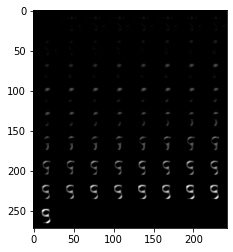

Epoch [266/400] Batch: [1/60] KL-Divergence: 0.029956279322504997 Cross-Entropy: 0.20037208497524261 Loss: 0.23032836616039276
Epoch [266/400] Batch: [2/60] KL-Divergence: 0.029903829097747803 Cross-Entropy: 0.20434539020061493 Loss: 0.23424921929836273
Epoch [266/400] Batch: [3/60] KL-Divergence: 0.02947966940701008 Cross-Entropy: 0.20314691960811615 Loss: 0.23262658715248108
Epoch [266/400] Batch: [4/60] KL-Divergence: 0.02980770729482174 Cross-Entropy: 0.20076245069503784 Loss: 0.23057015240192413
Epoch [266/400] Batch: [5/60] KL-Divergence: 0.03107646480202675 Cross-Entropy: 0.20523564517498016 Loss: 0.2363121062517166
Epoch [266/400] Batch: [6/60] KL-Divergence: 0.030680682510137558 Cross-Entropy: 0.2052163928747177 Loss: 0.23589707911014557
Epoch [266/400] Batch: [7/60] KL-Divergence: 0.02957790717482567 Cross-Entropy: 0.20266950130462646 Loss: 0.23224741220474243
Epoch [266/400] Batch: [8/60] KL-Divergence: 0.028331508859992027 Cross-Entropy: 0.20287850499153137 Loss: 0.23121000

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [266/400] Batch: [60/60] KL-Divergence: 0.030944522470235825 Cross-Entropy: 0.20725685358047485 Loss: 0.23820137977600098
Epoch [266/400] Batch: [60/60] KL-Divergence: 0.030944522470235825 Cross-Entropy: 0.20725685358047485 Loss: 0.23820137977600098


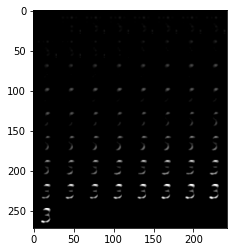

Epoch [267/400] Batch: [1/60] KL-Divergence: 0.030343471094965935 Cross-Entropy: 0.19913965463638306 Loss: 0.22948312759399414
Epoch [267/400] Batch: [2/60] KL-Divergence: 0.029933040961623192 Cross-Entropy: 0.20278072357177734 Loss: 0.2327137589454651
Epoch [267/400] Batch: [3/60] KL-Divergence: 0.030445024371147156 Cross-Entropy: 0.20309406518936157 Loss: 0.23353908956050873
Epoch [267/400] Batch: [4/60] KL-Divergence: 0.03042536973953247 Cross-Entropy: 0.20056034624576569 Loss: 0.23098571598529816
Epoch [267/400] Batch: [5/60] KL-Divergence: 0.03198239579796791 Cross-Entropy: 0.20376065373420715 Loss: 0.23574304580688477
Epoch [267/400] Batch: [6/60] KL-Divergence: 0.031187748536467552 Cross-Entropy: 0.20394213497638702 Loss: 0.23512987792491913
Epoch [267/400] Batch: [7/60] KL-Divergence: 0.029608149081468582 Cross-Entropy: 0.20035825669765472 Loss: 0.229966402053833
Epoch [267/400] Batch: [8/60] KL-Divergence: 0.028744187206029892 Cross-Entropy: 0.20126217603683472 Loss: 0.2300063

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [267/400] Batch: [60/60] KL-Divergence: 0.031135359779000282 Cross-Entropy: 0.2059694528579712 Loss: 0.23710481822490692
Epoch [267/400] Batch: [60/60] KL-Divergence: 0.031135359779000282 Cross-Entropy: 0.2059694528579712 Loss: 0.23710481822490692


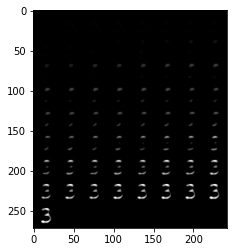

Epoch [268/400] Batch: [1/60] KL-Divergence: 0.030323095619678497 Cross-Entropy: 0.19917023181915283 Loss: 0.22949331998825073
Epoch [268/400] Batch: [2/60] KL-Divergence: 0.03019808977842331 Cross-Entropy: 0.20274393260478973 Loss: 0.23294201493263245
Epoch [268/400] Batch: [3/60] KL-Divergence: 0.030513478443026543 Cross-Entropy: 0.2024543136358261 Loss: 0.2329677939414978
Epoch [268/400] Batch: [4/60] KL-Divergence: 0.03030705451965332 Cross-Entropy: 0.19963838160037994 Loss: 0.22994543612003326
Epoch [268/400] Batch: [5/60] KL-Divergence: 0.03182658553123474 Cross-Entropy: 0.20285041630268097 Loss: 0.2346770018339157
Epoch [268/400] Batch: [6/60] KL-Divergence: 0.030942974612116814 Cross-Entropy: 0.20362943410873413 Loss: 0.2345724105834961
Epoch [268/400] Batch: [7/60] KL-Divergence: 0.030232533812522888 Cross-Entropy: 0.19973181188106537 Loss: 0.22996434569358826
Epoch [268/400] Batch: [8/60] KL-Divergence: 0.029728753492236137 Cross-Entropy: 0.19998323917388916 Loss: 0.229711994

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [268/400] Batch: [60/60] KL-Divergence: 0.027687085792422295 Cross-Entropy: 0.21512383222579956 Loss: 0.242810919880867
Epoch [268/400] Batch: [60/60] KL-Divergence: 0.027687085792422295 Cross-Entropy: 0.21512383222579956 Loss: 0.242810919880867


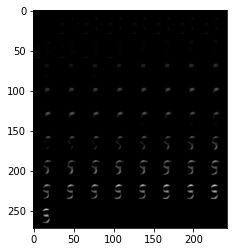

Epoch [269/400] Batch: [1/60] KL-Divergence: 0.02984059415757656 Cross-Entropy: 0.20896264910697937 Loss: 0.23880323767662048
Epoch [269/400] Batch: [2/60] KL-Divergence: 0.028243571519851685 Cross-Entropy: 0.2143479734659195 Loss: 0.24259154498577118
Epoch [269/400] Batch: [3/60] KL-Divergence: 0.02828124351799488 Cross-Entropy: 0.21179348230361938 Loss: 0.24007472395896912
Epoch [269/400] Batch: [4/60] KL-Divergence: 0.027514545246958733 Cross-Entropy: 0.2100883275270462 Loss: 0.23760287463665009
Epoch [269/400] Batch: [5/60] KL-Divergence: 0.02819160744547844 Cross-Entropy: 0.21292951703071594 Loss: 0.24112112820148468
Epoch [269/400] Batch: [6/60] KL-Divergence: 0.029618265107274055 Cross-Entropy: 0.2114134132862091 Loss: 0.241031676530838
Epoch [269/400] Batch: [7/60] KL-Divergence: 0.02923167496919632 Cross-Entropy: 0.20989950001239777 Loss: 0.23913118243217468
Epoch [269/400] Batch: [8/60] KL-Divergence: 0.028465738520026207 Cross-Entropy: 0.20919634401798248 Loss: 0.23766207695

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [269/400] Batch: [60/60] KL-Divergence: 0.028553076088428497 Cross-Entropy: 0.21563850343227386 Loss: 0.24419158697128296
Epoch [269/400] Batch: [60/60] KL-Divergence: 0.028553076088428497 Cross-Entropy: 0.21563850343227386 Loss: 0.24419158697128296


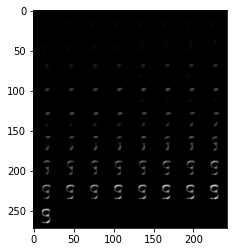

Epoch [270/400] Batch: [1/60] KL-Divergence: 0.027756821364164352 Cross-Entropy: 0.20609287917613983 Loss: 0.23384970426559448
Epoch [270/400] Batch: [2/60] KL-Divergence: 0.028005341067910194 Cross-Entropy: 0.20961207151412964 Loss: 0.23761741816997528
Epoch [270/400] Batch: [3/60] KL-Divergence: 0.028337782248854637 Cross-Entropy: 0.20841467380523682 Loss: 0.236752450466156
Epoch [270/400] Batch: [4/60] KL-Divergence: 0.027165018022060394 Cross-Entropy: 0.20639298856258392 Loss: 0.23355799913406372
Epoch [270/400] Batch: [5/60] KL-Divergence: 0.02852528914809227 Cross-Entropy: 0.2099655568599701 Loss: 0.23849084973335266
Epoch [270/400] Batch: [6/60] KL-Divergence: 0.029201850295066833 Cross-Entropy: 0.20969520509243011 Loss: 0.23889705538749695
Epoch [270/400] Batch: [7/60] KL-Divergence: 0.027800697833299637 Cross-Entropy: 0.20645906031131744 Loss: 0.23425975441932678
Epoch [270/400] Batch: [8/60] KL-Divergence: 0.027705682441592216 Cross-Entropy: 0.206903338432312 Loss: 0.23460902

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [270/400] Batch: [60/60] KL-Divergence: 0.030447209253907204 Cross-Entropy: 0.2157392054796219 Loss: 0.24618642032146454
Epoch [270/400] Batch: [60/60] KL-Divergence: 0.030447209253907204 Cross-Entropy: 0.2157392054796219 Loss: 0.24618642032146454


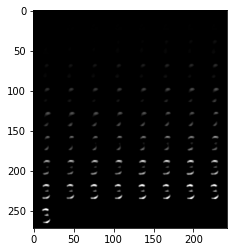

Epoch [271/400] Batch: [1/60] KL-Divergence: 0.02868988737463951 Cross-Entropy: 0.20818211138248444 Loss: 0.23687200248241425
Epoch [271/400] Batch: [2/60] KL-Divergence: 0.028170419856905937 Cross-Entropy: 0.21025735139846802 Loss: 0.2384277731180191
Epoch [271/400] Batch: [3/60] KL-Divergence: 0.029204677790403366 Cross-Entropy: 0.20990823209285736 Loss: 0.23911291360855103
Epoch [271/400] Batch: [4/60] KL-Divergence: 0.02903844229876995 Cross-Entropy: 0.20885714888572693 Loss: 0.23789559304714203
Epoch [271/400] Batch: [5/60] KL-Divergence: 0.02991846390068531 Cross-Entropy: 0.21144546568393707 Loss: 0.24136392772197723
Epoch [271/400] Batch: [6/60] KL-Divergence: 0.027973832562565804 Cross-Entropy: 0.2120150625705719 Loss: 0.23998889327049255
Epoch [271/400] Batch: [7/60] KL-Divergence: 0.02744664065539837 Cross-Entropy: 0.20998843014240265 Loss: 0.23743507266044617
Epoch [271/400] Batch: [8/60] KL-Divergence: 0.026994403451681137 Cross-Entropy: 0.21026258170604706 Loss: 0.23725698

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [271/400] Batch: [60/60] KL-Divergence: 0.028455371037125587 Cross-Entropy: 0.20931200683116913 Loss: 0.23776738345623016
Epoch [271/400] Batch: [60/60] KL-Divergence: 0.028455371037125587 Cross-Entropy: 0.20931200683116913 Loss: 0.23776738345623016


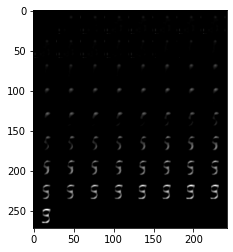

Epoch [272/400] Batch: [1/60] KL-Divergence: 0.028052987530827522 Cross-Entropy: 0.20344267785549164 Loss: 0.231495663523674
Epoch [272/400] Batch: [2/60] KL-Divergence: 0.02881009131669998 Cross-Entropy: 0.206721693277359 Loss: 0.2355317771434784
Epoch [272/400] Batch: [3/60] KL-Divergence: 0.029951542615890503 Cross-Entropy: 0.20604662597179413 Loss: 0.23599816858768463
Epoch [272/400] Batch: [4/60] KL-Divergence: 0.02822163514792919 Cross-Entropy: 0.20317649841308594 Loss: 0.23139813542366028
Epoch [272/400] Batch: [5/60] KL-Divergence: 0.030739618465304375 Cross-Entropy: 0.20748789608478546 Loss: 0.23822751641273499
Epoch [272/400] Batch: [6/60] KL-Divergence: 0.029493197798728943 Cross-Entropy: 0.20634259283542633 Loss: 0.23583579063415527
Epoch [272/400] Batch: [7/60] KL-Divergence: 0.03047698363661766 Cross-Entropy: 0.20460863411426544 Loss: 0.2350856214761734
Epoch [272/400] Batch: [8/60] KL-Divergence: 0.028575213626027107 Cross-Entropy: 0.20273065567016602 Loss: 0.23130586743

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [272/400] Batch: [60/60] KL-Divergence: 0.029960304498672485 Cross-Entropy: 0.20998528599739075 Loss: 0.23994559049606323
Epoch [272/400] Batch: [60/60] KL-Divergence: 0.029960304498672485 Cross-Entropy: 0.20998528599739075 Loss: 0.23994559049606323


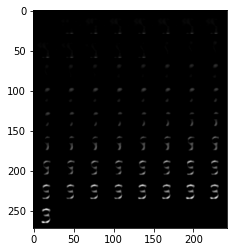

Epoch [273/400] Batch: [1/60] KL-Divergence: 0.02884068340063095 Cross-Entropy: 0.2034434676170349 Loss: 0.23228415846824646
Epoch [273/400] Batch: [2/60] KL-Divergence: 0.029832709580659866 Cross-Entropy: 0.20660604536533356 Loss: 0.23643875122070312
Epoch [273/400] Batch: [3/60] KL-Divergence: 0.029472770169377327 Cross-Entropy: 0.20625914633274078 Loss: 0.23573191463947296
Epoch [273/400] Batch: [4/60] KL-Divergence: 0.029638096690177917 Cross-Entropy: 0.20345312356948853 Loss: 0.23309122025966644
Epoch [273/400] Batch: [5/60] KL-Divergence: 0.030342083424329758 Cross-Entropy: 0.20902019739151 Loss: 0.23936228454113007
Epoch [273/400] Batch: [6/60] KL-Divergence: 0.029579566791653633 Cross-Entropy: 0.20798665285110474 Loss: 0.23756621778011322
Epoch [273/400] Batch: [7/60] KL-Divergence: 0.028988849371671677 Cross-Entropy: 0.20409078896045685 Loss: 0.23307964205741882
Epoch [273/400] Batch: [8/60] KL-Divergence: 0.028537796810269356 Cross-Entropy: 0.2047555297613144 Loss: 0.23329332

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [273/400] Batch: [60/60] KL-Divergence: 0.030861863866448402 Cross-Entropy: 0.20960284769535065 Loss: 0.2404647171497345
Epoch [273/400] Batch: [60/60] KL-Divergence: 0.030861863866448402 Cross-Entropy: 0.20960284769535065 Loss: 0.2404647171497345


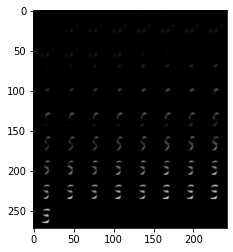

Epoch [274/400] Batch: [1/60] KL-Divergence: 0.02975735254585743 Cross-Entropy: 0.20284497737884521 Loss: 0.2326023280620575
Epoch [274/400] Batch: [2/60] KL-Divergence: 0.029200861230492592 Cross-Entropy: 0.20547306537628174 Loss: 0.23467393219470978
Epoch [274/400] Batch: [3/60] KL-Divergence: 0.030571648851037025 Cross-Entropy: 0.20502741634845734 Loss: 0.2355990707874298
Epoch [274/400] Batch: [4/60] KL-Divergence: 0.029575131833553314 Cross-Entropy: 0.20152637362480164 Loss: 0.23110151290893555
Epoch [274/400] Batch: [5/60] KL-Divergence: 0.031199589371681213 Cross-Entropy: 0.20577840507030487 Loss: 0.23697799444198608
Epoch [274/400] Batch: [6/60] KL-Divergence: 0.0306223314255476 Cross-Entropy: 0.20569942891597748 Loss: 0.23632176220417023
Epoch [274/400] Batch: [7/60] KL-Divergence: 0.030252765864133835 Cross-Entropy: 0.20257660746574402 Loss: 0.23282937705516815
Epoch [274/400] Batch: [8/60] KL-Divergence: 0.02948073111474514 Cross-Entropy: 0.20296865701675415 Loss: 0.23244938

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [274/400] Batch: [60/60] KL-Divergence: 0.030112124979496002 Cross-Entropy: 0.2068563848733902 Loss: 0.2369685173034668
Epoch [274/400] Batch: [60/60] KL-Divergence: 0.030112124979496002 Cross-Entropy: 0.2068563848733902 Loss: 0.2369685173034668


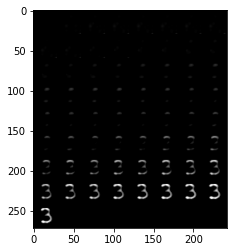

Epoch [275/400] Batch: [1/60] KL-Divergence: 0.030379706993699074 Cross-Entropy: 0.20011989772319794 Loss: 0.23049961030483246
Epoch [275/400] Batch: [2/60] KL-Divergence: 0.02927083894610405 Cross-Entropy: 0.20256292819976807 Loss: 0.23183377087116241
Epoch [275/400] Batch: [3/60] KL-Divergence: 0.031203150749206543 Cross-Entropy: 0.20236438512802124 Loss: 0.23356753587722778
Epoch [275/400] Batch: [4/60] KL-Divergence: 0.03126472607254982 Cross-Entropy: 0.20114484429359436 Loss: 0.23240956664085388
Epoch [275/400] Batch: [5/60] KL-Divergence: 0.031566303223371506 Cross-Entropy: 0.20506049692630768 Loss: 0.23662680387496948
Epoch [275/400] Batch: [6/60] KL-Divergence: 0.030521472916007042 Cross-Entropy: 0.20432306826114655 Loss: 0.23484453558921814
Epoch [275/400] Batch: [7/60] KL-Divergence: 0.029926668852567673 Cross-Entropy: 0.20206867158412933 Loss: 0.2319953441619873
Epoch [275/400] Batch: [8/60] KL-Divergence: 0.027682337909936905 Cross-Entropy: 0.20341326296329498 Loss: 0.23109

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [275/400] Batch: [60/60] KL-Divergence: 0.02909809909760952 Cross-Entropy: 0.2409161478281021 Loss: 0.2700142562389374
Epoch [275/400] Batch: [60/60] KL-Divergence: 0.02909809909760952 Cross-Entropy: 0.2409161478281021 Loss: 0.2700142562389374


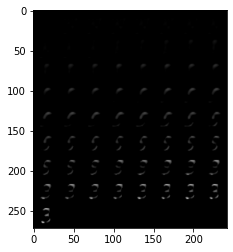

Epoch [276/400] Batch: [1/60] KL-Divergence: 0.028357485309243202 Cross-Entropy: 0.23642118275165558 Loss: 0.26477867364883423
Epoch [276/400] Batch: [2/60] KL-Divergence: 0.028136612847447395 Cross-Entropy: 0.24126310646533966 Loss: 0.2693997323513031
Epoch [276/400] Batch: [3/60] KL-Divergence: 0.02570244111120701 Cross-Entropy: 0.24411222338676453 Loss: 0.269814670085907
Epoch [276/400] Batch: [4/60] KL-Divergence: 0.02586667612195015 Cross-Entropy: 0.23822693526744843 Loss: 0.2640936076641083
Epoch [276/400] Batch: [5/60] KL-Divergence: 0.02430962771177292 Cross-Entropy: 0.24788200855255127 Loss: 0.2721916437149048
Epoch [276/400] Batch: [6/60] KL-Divergence: 0.023997850716114044 Cross-Entropy: 0.2435745745897293 Loss: 0.26757243275642395
Epoch [276/400] Batch: [7/60] KL-Divergence: 0.021967917680740356 Cross-Entropy: 0.24107538163661957 Loss: 0.26304328441619873
Epoch [276/400] Batch: [8/60] KL-Divergence: 0.02040780521929264 Cross-Entropy: 0.2350590080022812 Loss: 0.2554668188095

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [276/400] Batch: [60/60] KL-Divergence: 0.025926603004336357 Cross-Entropy: 0.21995742619037628 Loss: 0.2458840310573578
Epoch [276/400] Batch: [60/60] KL-Divergence: 0.025926603004336357 Cross-Entropy: 0.21995742619037628 Loss: 0.2458840310573578


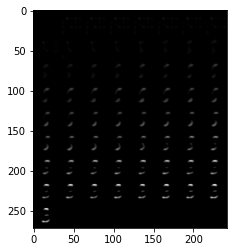

Epoch [277/400] Batch: [1/60] KL-Divergence: 0.02579045295715332 Cross-Entropy: 0.2137001007795334 Loss: 0.2394905537366867
Epoch [277/400] Batch: [2/60] KL-Divergence: 0.02480688877403736 Cross-Entropy: 0.21491509675979614 Loss: 0.23972198367118835
Epoch [277/400] Batch: [3/60] KL-Divergence: 0.02543555572628975 Cross-Entropy: 0.21537421643733978 Loss: 0.24080976843833923
Epoch [277/400] Batch: [4/60] KL-Divergence: 0.023978814482688904 Cross-Entropy: 0.2131766527891159 Loss: 0.2371554672718048
Epoch [277/400] Batch: [5/60] KL-Divergence: 0.026163645088672638 Cross-Entropy: 0.2167704850435257 Loss: 0.24293413758277893
Epoch [277/400] Batch: [6/60] KL-Divergence: 0.025436634197831154 Cross-Entropy: 0.21648743748664856 Loss: 0.24192407727241516
Epoch [277/400] Batch: [7/60] KL-Divergence: 0.02480676770210266 Cross-Entropy: 0.2132885754108429 Loss: 0.23809534311294556
Epoch [277/400] Batch: [8/60] KL-Divergence: 0.024293674156069756 Cross-Entropy: 0.21153807640075684 Loss: 0.235831752419

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [277/400] Batch: [60/60] KL-Divergence: 0.02806033380329609 Cross-Entropy: 0.21165557205677032 Loss: 0.23971590399742126
Epoch [277/400] Batch: [60/60] KL-Divergence: 0.02806033380329609 Cross-Entropy: 0.21165557205677032 Loss: 0.23971590399742126


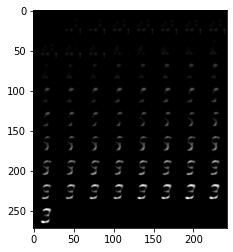

Epoch [278/400] Batch: [1/60] KL-Divergence: 0.028840404003858566 Cross-Entropy: 0.20506711304187775 Loss: 0.2339075207710266
Epoch [278/400] Batch: [2/60] KL-Divergence: 0.027991289272904396 Cross-Entropy: 0.20680095255374908 Loss: 0.23479224741458893
Epoch [278/400] Batch: [3/60] KL-Divergence: 0.02805645950138569 Cross-Entropy: 0.2091308981180191 Loss: 0.23718735575675964
Epoch [278/400] Batch: [4/60] KL-Divergence: 0.02873440831899643 Cross-Entropy: 0.20530173182487488 Loss: 0.2340361475944519
Epoch [278/400] Batch: [5/60] KL-Divergence: 0.030316192656755447 Cross-Entropy: 0.20879407227039337 Loss: 0.23911026120185852
Epoch [278/400] Batch: [6/60] KL-Divergence: 0.028363343328237534 Cross-Entropy: 0.2084982842206955 Loss: 0.23686163127422333
Epoch [278/400] Batch: [7/60] KL-Divergence: 0.02797502838075161 Cross-Entropy: 0.20520879328250885 Loss: 0.233183816075325
Epoch [278/400] Batch: [8/60] KL-Divergence: 0.028056884184479713 Cross-Entropy: 0.20471611618995667 Loss: 0.23277300596

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [278/400] Batch: [60/60] KL-Divergence: 0.03086317703127861 Cross-Entropy: 0.208010733127594 Loss: 0.2388739138841629
Epoch [278/400] Batch: [60/60] KL-Divergence: 0.03086317703127861 Cross-Entropy: 0.208010733127594 Loss: 0.2388739138841629


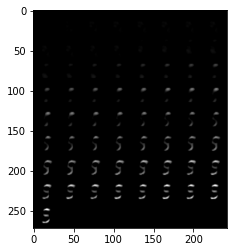

Epoch [279/400] Batch: [1/60] KL-Divergence: 0.029483553022146225 Cross-Entropy: 0.20165593922138214 Loss: 0.23113949596881866
Epoch [279/400] Batch: [2/60] KL-Divergence: 0.028596142306923866 Cross-Entropy: 0.20386283099651337 Loss: 0.23245897889137268
Epoch [279/400] Batch: [3/60] KL-Divergence: 0.029375871643424034 Cross-Entropy: 0.20449982583522797 Loss: 0.23387569189071655
Epoch [279/400] Batch: [4/60] KL-Divergence: 0.030043119564652443 Cross-Entropy: 0.20225003361701965 Loss: 0.23229315876960754
Epoch [279/400] Batch: [5/60] KL-Divergence: 0.029647663235664368 Cross-Entropy: 0.20411965250968933 Loss: 0.2337673157453537
Epoch [279/400] Batch: [6/60] KL-Divergence: 0.029591720551252365 Cross-Entropy: 0.2044723480939865 Loss: 0.23406407237052917
Epoch [279/400] Batch: [7/60] KL-Divergence: 0.02954808436334133 Cross-Entropy: 0.20266802608966827 Loss: 0.23221610486507416
Epoch [279/400] Batch: [8/60] KL-Divergence: 0.0296673234552145 Cross-Entropy: 0.20144593715667725 Loss: 0.2311132

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [279/400] Batch: [60/60] KL-Divergence: 0.03149479255080223 Cross-Entropy: 0.2087133228778839 Loss: 0.24020811915397644
Epoch [279/400] Batch: [60/60] KL-Divergence: 0.03149479255080223 Cross-Entropy: 0.2087133228778839 Loss: 0.24020811915397644


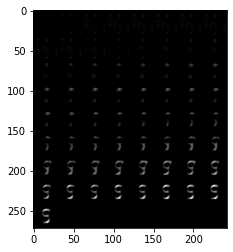

Epoch [280/400] Batch: [1/60] KL-Divergence: 0.029972953721880913 Cross-Entropy: 0.20391663908958435 Loss: 0.2338895946741104
Epoch [280/400] Batch: [2/60] KL-Divergence: 0.028590895235538483 Cross-Entropy: 0.2059757560491562 Loss: 0.23456665873527527
Epoch [280/400] Batch: [3/60] KL-Divergence: 0.02924766205251217 Cross-Entropy: 0.20705826580524445 Loss: 0.23630592226982117
Epoch [280/400] Batch: [4/60] KL-Divergence: 0.029982171952724457 Cross-Entropy: 0.20393502712249756 Loss: 0.2339172065258026
Epoch [280/400] Batch: [5/60] KL-Divergence: 0.03158063068985939 Cross-Entropy: 0.20876657962799072 Loss: 0.24034720659255981
Epoch [280/400] Batch: [6/60] KL-Divergence: 0.030149808153510094 Cross-Entropy: 0.20739950239658356 Loss: 0.2375493049621582
Epoch [280/400] Batch: [7/60] KL-Divergence: 0.029320454224944115 Cross-Entropy: 0.20467418432235718 Loss: 0.23399463295936584
Epoch [280/400] Batch: [8/60] KL-Divergence: 0.029279623180627823 Cross-Entropy: 0.2026960551738739 Loss: 0.231975674

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [280/400] Batch: [60/60] KL-Divergence: 0.03214045986533165 Cross-Entropy: 0.20655639469623566 Loss: 0.2386968582868576
Epoch [280/400] Batch: [60/60] KL-Divergence: 0.03214045986533165 Cross-Entropy: 0.20655639469623566 Loss: 0.2386968582868576


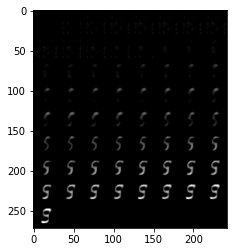

Epoch [281/400] Batch: [1/60] KL-Divergence: 0.031106259673833847 Cross-Entropy: 0.20037531852722168 Loss: 0.23148158192634583
Epoch [281/400] Batch: [2/60] KL-Divergence: 0.03149335831403732 Cross-Entropy: 0.20487873256206512 Loss: 0.23637208342552185
Epoch [281/400] Batch: [3/60] KL-Divergence: 0.030278930440545082 Cross-Entropy: 0.2050366997718811 Loss: 0.23531563580036163
Epoch [281/400] Batch: [4/60] KL-Divergence: 0.030514193698763847 Cross-Entropy: 0.2022327184677124 Loss: 0.2327469140291214
Epoch [281/400] Batch: [5/60] KL-Divergence: 0.0314759686589241 Cross-Entropy: 0.20783114433288574 Loss: 0.23930710554122925
Epoch [281/400] Batch: [6/60] KL-Divergence: 0.030068831518292427 Cross-Entropy: 0.20666413009166718 Loss: 0.23673295974731445
Epoch [281/400] Batch: [7/60] KL-Divergence: 0.028518563136458397 Cross-Entropy: 0.2033679336309433 Loss: 0.23188649117946625
Epoch [281/400] Batch: [8/60] KL-Divergence: 0.02921675145626068 Cross-Entropy: 0.2042236477136612 Loss: 0.23344039916

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [281/400] Batch: [60/60] KL-Divergence: 0.0303879976272583 Cross-Entropy: 0.2063487023115158 Loss: 0.2367366999387741
Epoch [281/400] Batch: [60/60] KL-Divergence: 0.0303879976272583 Cross-Entropy: 0.2063487023115158 Loss: 0.2367366999387741


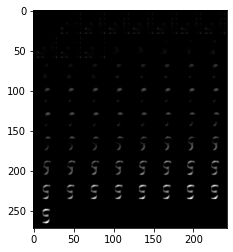

Epoch [282/400] Batch: [1/60] KL-Divergence: 0.03055288828909397 Cross-Entropy: 0.19981659948825836 Loss: 0.23036949336528778
Epoch [282/400] Batch: [2/60] KL-Divergence: 0.030415985733270645 Cross-Entropy: 0.20197488367557526 Loss: 0.2323908656835556
Epoch [282/400] Batch: [3/60] KL-Divergence: 0.03088659606873989 Cross-Entropy: 0.2029740810394287 Loss: 0.23386067152023315
Epoch [282/400] Batch: [4/60] KL-Divergence: 0.029986480250954628 Cross-Entropy: 0.2002989649772644 Loss: 0.23028545081615448
Epoch [282/400] Batch: [5/60] KL-Divergence: 0.03099406324326992 Cross-Entropy: 0.20318999886512756 Loss: 0.23418405652046204
Epoch [282/400] Batch: [6/60] KL-Divergence: 0.030899496749043465 Cross-Entropy: 0.20448699593544006 Loss: 0.23538649082183838
Epoch [282/400] Batch: [7/60] KL-Divergence: 0.03051658533513546 Cross-Entropy: 0.20080579817295074 Loss: 0.23132237792015076
Epoch [282/400] Batch: [8/60] KL-Divergence: 0.029968202114105225 Cross-Entropy: 0.20077933371067047 Loss: 0.230747535

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [282/400] Batch: [60/60] KL-Divergence: 0.030539872124791145 Cross-Entropy: 0.20698489248752594 Loss: 0.23752476274967194
Epoch [282/400] Batch: [60/60] KL-Divergence: 0.030539872124791145 Cross-Entropy: 0.20698489248752594 Loss: 0.23752476274967194


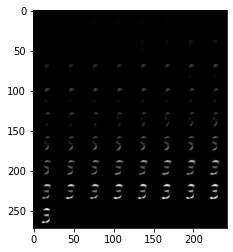

Epoch [283/400] Batch: [1/60] KL-Divergence: 0.03030029870569706 Cross-Entropy: 0.1990562081336975 Loss: 0.22935651242733002
Epoch [283/400] Batch: [2/60] KL-Divergence: 0.029830433428287506 Cross-Entropy: 0.20324255526065826 Loss: 0.23307299613952637
Epoch [283/400] Batch: [3/60] KL-Divergence: 0.031408946961164474 Cross-Entropy: 0.20274609327316284 Loss: 0.23415504395961761
Epoch [283/400] Batch: [4/60] KL-Divergence: 0.030542291700839996 Cross-Entropy: 0.20110496878623962 Loss: 0.23164725303649902
Epoch [283/400] Batch: [5/60] KL-Divergence: 0.03197197988629341 Cross-Entropy: 0.20616596937179565 Loss: 0.23813794553279877
Epoch [283/400] Batch: [6/60] KL-Divergence: 0.030369749292731285 Cross-Entropy: 0.20576824247837067 Loss: 0.2361379861831665
Epoch [283/400] Batch: [7/60] KL-Divergence: 0.03017560951411724 Cross-Entropy: 0.2042573243379593 Loss: 0.23443293571472168
Epoch [283/400] Batch: [8/60] KL-Divergence: 0.030158070847392082 Cross-Entropy: 0.2050321251153946 Loss: 0.235190197

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [283/400] Batch: [60/60] KL-Divergence: 0.029673807322978973 Cross-Entropy: 0.20953869819641113 Loss: 0.2392125129699707
Epoch [283/400] Batch: [60/60] KL-Divergence: 0.029673807322978973 Cross-Entropy: 0.20953869819641113 Loss: 0.2392125129699707


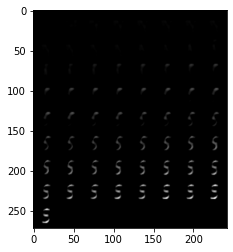

Epoch [284/400] Batch: [1/60] KL-Divergence: 0.02907262183725834 Cross-Entropy: 0.2015499621629715 Loss: 0.23062258958816528
Epoch [284/400] Batch: [2/60] KL-Divergence: 0.028947116807103157 Cross-Entropy: 0.20569682121276855 Loss: 0.23464393615722656
Epoch [284/400] Batch: [3/60] KL-Divergence: 0.02869955077767372 Cross-Entropy: 0.20652663707733154 Loss: 0.23522618412971497
Epoch [284/400] Batch: [4/60] KL-Divergence: 0.028820345178246498 Cross-Entropy: 0.2042880803346634 Loss: 0.23310843110084534
Epoch [284/400] Batch: [5/60] KL-Divergence: 0.03059939295053482 Cross-Entropy: 0.20804055035114288 Loss: 0.2386399507522583
Epoch [284/400] Batch: [6/60] KL-Divergence: 0.028592592105269432 Cross-Entropy: 0.2093748301267624 Loss: 0.23796741664409637
Epoch [284/400] Batch: [7/60] KL-Divergence: 0.027743656188249588 Cross-Entropy: 0.2066616266965866 Loss: 0.2344052791595459
Epoch [284/400] Batch: [8/60] KL-Divergence: 0.02829907089471817 Cross-Entropy: 0.20564427971839905 Loss: 0.233943343162

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [284/400] Batch: [60/60] KL-Divergence: 0.030501313507556915 Cross-Entropy: 0.2068704217672348 Loss: 0.23737174272537231
Epoch [284/400] Batch: [60/60] KL-Divergence: 0.030501313507556915 Cross-Entropy: 0.2068704217672348 Loss: 0.23737174272537231


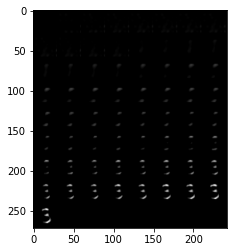

Epoch [285/400] Batch: [1/60] KL-Divergence: 0.029593881219625473 Cross-Entropy: 0.19924762845039368 Loss: 0.22884151339530945
Epoch [285/400] Batch: [2/60] KL-Divergence: 0.0308928731828928 Cross-Entropy: 0.20306161046028137 Loss: 0.23395448923110962
Epoch [285/400] Batch: [3/60] KL-Divergence: 0.0309611726552248 Cross-Entropy: 0.20217709243297577 Loss: 0.23313826322555542
Epoch [285/400] Batch: [4/60] KL-Divergence: 0.03090125322341919 Cross-Entropy: 0.20137548446655273 Loss: 0.23227673768997192
Epoch [285/400] Batch: [5/60] KL-Divergence: 0.03157448023557663 Cross-Entropy: 0.2031421661376953 Loss: 0.23471665382385254
Epoch [285/400] Batch: [6/60] KL-Divergence: 0.03061959147453308 Cross-Entropy: 0.20445133745670319 Loss: 0.23507092893123627
Epoch [285/400] Batch: [7/60] KL-Divergence: 0.030366990715265274 Cross-Entropy: 0.20189987123012543 Loss: 0.2322668582201004
Epoch [285/400] Batch: [8/60] KL-Divergence: 0.030292488634586334 Cross-Entropy: 0.20247292518615723 Loss: 0.23276540637

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [285/400] Batch: [60/60] KL-Divergence: 0.030547691509127617 Cross-Entropy: 0.20666246116161346 Loss: 0.23721015453338623
Epoch [285/400] Batch: [60/60] KL-Divergence: 0.030547691509127617 Cross-Entropy: 0.20666246116161346 Loss: 0.23721015453338623


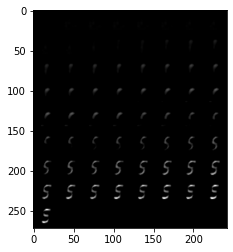

Epoch [286/400] Batch: [1/60] KL-Divergence: 0.03053761087357998 Cross-Entropy: 0.19936791062355042 Loss: 0.22990551590919495
Epoch [286/400] Batch: [2/60] KL-Divergence: 0.030501479282975197 Cross-Entropy: 0.20153826475143433 Loss: 0.23203974962234497
Epoch [286/400] Batch: [3/60] KL-Divergence: 0.031220605596899986 Cross-Entropy: 0.20255695283412933 Loss: 0.23377755284309387
Epoch [286/400] Batch: [4/60] KL-Divergence: 0.03055138885974884 Cross-Entropy: 0.19978047907352448 Loss: 0.23033186793327332
Epoch [286/400] Batch: [5/60] KL-Divergence: 0.03185344859957695 Cross-Entropy: 0.20301812887191772 Loss: 0.23487158119678497
Epoch [286/400] Batch: [6/60] KL-Divergence: 0.030737362802028656 Cross-Entropy: 0.2044162005186081 Loss: 0.23515355587005615
Epoch [286/400] Batch: [7/60] KL-Divergence: 0.03020891547203064 Cross-Entropy: 0.20094582438468933 Loss: 0.23115473985671997
Epoch [286/400] Batch: [8/60] KL-Divergence: 0.02902558445930481 Cross-Entropy: 0.2004251629114151 Loss: 0.229450747

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [286/400] Batch: [60/60] KL-Divergence: 0.03192046657204628 Cross-Entropy: 0.206049382686615 Loss: 0.23796984553337097
Epoch [286/400] Batch: [60/60] KL-Divergence: 0.03192046657204628 Cross-Entropy: 0.206049382686615 Loss: 0.23796984553337097


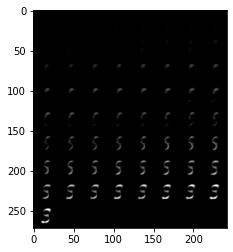

Epoch [287/400] Batch: [1/60] KL-Divergence: 0.030626511201262474 Cross-Entropy: 0.19971223175525665 Loss: 0.23033873736858368
Epoch [287/400] Batch: [2/60] KL-Divergence: 0.031240638345479965 Cross-Entropy: 0.2025803029537201 Loss: 0.23382094502449036
Epoch [287/400] Batch: [3/60] KL-Divergence: 0.0316939540207386 Cross-Entropy: 0.20251023769378662 Loss: 0.23420418798923492
Epoch [287/400] Batch: [4/60] KL-Divergence: 0.030803050845861435 Cross-Entropy: 0.1995663344860077 Loss: 0.23036938905715942
Epoch [287/400] Batch: [5/60] KL-Divergence: 0.03246752545237541 Cross-Entropy: 0.20411574840545654 Loss: 0.23658327758312225
Epoch [287/400] Batch: [6/60] KL-Divergence: 0.03038136661052704 Cross-Entropy: 0.20262865722179413 Loss: 0.23301002383232117
Epoch [287/400] Batch: [7/60] KL-Divergence: 0.03103022463619709 Cross-Entropy: 0.20076893270015717 Loss: 0.2317991554737091
Epoch [287/400] Batch: [8/60] KL-Divergence: 0.03103269450366497 Cross-Entropy: 0.1998254507780075 Loss: 0.230858147144

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [287/400] Batch: [60/60] KL-Divergence: 0.03164385259151459 Cross-Entropy: 0.2052500694990158 Loss: 0.2368939220905304
Epoch [287/400] Batch: [60/60] KL-Divergence: 0.03164385259151459 Cross-Entropy: 0.2052500694990158 Loss: 0.2368939220905304


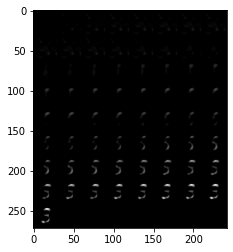

Epoch [288/400] Batch: [1/60] KL-Divergence: 0.0309812743216753 Cross-Entropy: 0.1990756094455719 Loss: 0.23005688190460205
Epoch [288/400] Batch: [2/60] KL-Divergence: 0.031730178743600845 Cross-Entropy: 0.20266826450824738 Loss: 0.23439843952655792
Epoch [288/400] Batch: [3/60] KL-Divergence: 0.031882476061582565 Cross-Entropy: 0.20273281633853912 Loss: 0.234615296125412
Epoch [288/400] Batch: [4/60] KL-Divergence: 0.03245684877038002 Cross-Entropy: 0.20021787285804749 Loss: 0.2326747179031372
Epoch [288/400] Batch: [5/60] KL-Divergence: 0.03324031084775925 Cross-Entropy: 0.20394110679626465 Loss: 0.2371814250946045
Epoch [288/400] Batch: [6/60] KL-Divergence: 0.031105171889066696 Cross-Entropy: 0.20229870080947876 Loss: 0.23340387642383575
Epoch [288/400] Batch: [7/60] KL-Divergence: 0.031457576900720596 Cross-Entropy: 0.2010648250579834 Loss: 0.2325223982334137
Epoch [288/400] Batch: [8/60] KL-Divergence: 0.030726347118616104 Cross-Entropy: 0.19937774538993835 Loss: 0.2301040887832

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [288/400] Batch: [60/60] KL-Divergence: 0.031161639839410782 Cross-Entropy: 0.20824269950389862 Loss: 0.2394043356180191
Epoch [288/400] Batch: [60/60] KL-Divergence: 0.031161639839410782 Cross-Entropy: 0.20824269950389862 Loss: 0.2394043356180191


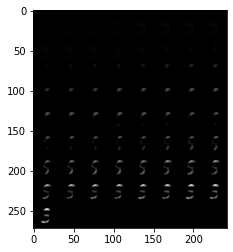

Epoch [289/400] Batch: [1/60] KL-Divergence: 0.030617430806159973 Cross-Entropy: 0.20185323059558868 Loss: 0.23247066140174866
Epoch [289/400] Batch: [2/60] KL-Divergence: 0.030552946031093597 Cross-Entropy: 0.20380181074142456 Loss: 0.23435476422309875
Epoch [289/400] Batch: [3/60] KL-Divergence: 0.031178612262010574 Cross-Entropy: 0.20525023341178894 Loss: 0.23642884194850922
Epoch [289/400] Batch: [4/60] KL-Divergence: 0.028776122257113457 Cross-Entropy: 0.20050637423992157 Loss: 0.22928249835968018
Epoch [289/400] Batch: [5/60] KL-Divergence: 0.03222842514514923 Cross-Entropy: 0.20646551251411438 Loss: 0.2386939376592636
Epoch [289/400] Batch: [6/60] KL-Divergence: 0.030174801126122475 Cross-Entropy: 0.2048807591199875 Loss: 0.2350555658340454
Epoch [289/400] Batch: [7/60] KL-Divergence: 0.02955516055226326 Cross-Entropy: 0.20333242416381836 Loss: 0.23288758099079132
Epoch [289/400] Batch: [8/60] KL-Divergence: 0.0293984767049551 Cross-Entropy: 0.20155347883701324 Loss: 0.230951949

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [289/400] Batch: [60/60] KL-Divergence: 0.03365586698055267 Cross-Entropy: 0.20449915528297424 Loss: 0.23815502226352692
Epoch [289/400] Batch: [60/60] KL-Divergence: 0.03365586698055267 Cross-Entropy: 0.20449915528297424 Loss: 0.23815502226352692


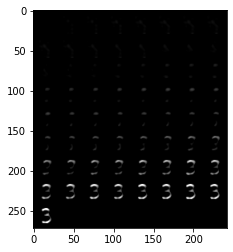

Epoch [290/400] Batch: [1/60] KL-Divergence: 0.03318340331315994 Cross-Entropy: 0.19846202433109283 Loss: 0.23164543509483337
Epoch [290/400] Batch: [2/60] KL-Divergence: 0.03490573540329933 Cross-Entropy: 0.20246601104736328 Loss: 0.23737174272537231
Epoch [290/400] Batch: [3/60] KL-Divergence: 0.034983791410923004 Cross-Entropy: 0.2009982168674469 Loss: 0.2359820008277893
Epoch [290/400] Batch: [4/60] KL-Divergence: 0.03446771577000618 Cross-Entropy: 0.19893282651901245 Loss: 0.23340053856372833
Epoch [290/400] Batch: [5/60] KL-Divergence: 0.03598994389176369 Cross-Entropy: 0.20348747074604034 Loss: 0.23947741091251373
Epoch [290/400] Batch: [6/60] KL-Divergence: 0.03587956354022026 Cross-Entropy: 0.20428630709648132 Loss: 0.24016587436199188
Epoch [290/400] Batch: [7/60] KL-Divergence: 0.03521387651562691 Cross-Entropy: 0.20064328610897064 Loss: 0.23585715889930725
Epoch [290/400] Batch: [8/60] KL-Divergence: 0.03477564454078674 Cross-Entropy: 0.19992204010486603 Loss: 0.23469768464

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [290/400] Batch: [60/60] KL-Divergence: 0.03169579803943634 Cross-Entropy: 0.20674823224544525 Loss: 0.2384440302848816
Epoch [290/400] Batch: [60/60] KL-Divergence: 0.03169579803943634 Cross-Entropy: 0.20674823224544525 Loss: 0.2384440302848816


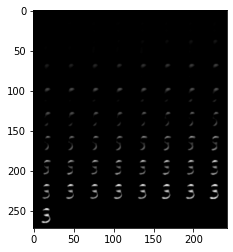

Epoch [291/400] Batch: [1/60] KL-Divergence: 0.03156731650233269 Cross-Entropy: 0.19727371633052826 Loss: 0.22884103655815125
Epoch [291/400] Batch: [2/60] KL-Divergence: 0.03145567700266838 Cross-Entropy: 0.20118089020252228 Loss: 0.23263657093048096
Epoch [291/400] Batch: [3/60] KL-Divergence: 0.03118247538805008 Cross-Entropy: 0.20104378461837769 Loss: 0.23222625255584717
Epoch [291/400] Batch: [4/60] KL-Divergence: 0.03103206492960453 Cross-Entropy: 0.1982235312461853 Loss: 0.22925560176372528
Epoch [291/400] Batch: [5/60] KL-Divergence: 0.03138913959264755 Cross-Entropy: 0.20179973542690277 Loss: 0.23318886756896973
Epoch [291/400] Batch: [6/60] KL-Divergence: 0.03169548138976097 Cross-Entropy: 0.20240098237991333 Loss: 0.2340964674949646
Epoch [291/400] Batch: [7/60] KL-Divergence: 0.02903776988387108 Cross-Entropy: 0.19960065186023712 Loss: 0.2286384254693985
Epoch [291/400] Batch: [8/60] KL-Divergence: 0.02938120998442173 Cross-Entropy: 0.19993914663791656 Loss: 0.2293203622102

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [291/400] Batch: [60/60] KL-Divergence: 0.030413636937737465 Cross-Entropy: 0.21666620671749115 Loss: 0.24707984924316406
Epoch [291/400] Batch: [60/60] KL-Divergence: 0.030413636937737465 Cross-Entropy: 0.21666620671749115 Loss: 0.24707984924316406


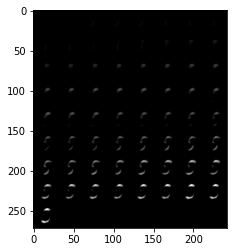

Epoch [292/400] Batch: [1/60] KL-Divergence: 0.02867557480931282 Cross-Entropy: 0.20630882680416107 Loss: 0.2349843978881836
Epoch [292/400] Batch: [2/60] KL-Divergence: 0.02893550880253315 Cross-Entropy: 0.21052590012550354 Loss: 0.23946140706539154
Epoch [292/400] Batch: [3/60] KL-Divergence: 0.028721516951918602 Cross-Entropy: 0.21105866134166718 Loss: 0.23978017270565033
Epoch [292/400] Batch: [4/60] KL-Divergence: 0.029365520924329758 Cross-Entropy: 0.21086972951889038 Loss: 0.24023525416851044
Epoch [292/400] Batch: [5/60] KL-Divergence: 0.03122280351817608 Cross-Entropy: 0.2130483090877533 Loss: 0.24427111446857452
Epoch [292/400] Batch: [6/60] KL-Divergence: 0.030239522457122803 Cross-Entropy: 0.21243354678153992 Loss: 0.24267306923866272
Epoch [292/400] Batch: [7/60] KL-Divergence: 0.03072727471590042 Cross-Entropy: 0.20824648439884186 Loss: 0.23897376656532288
Epoch [292/400] Batch: [8/60] KL-Divergence: 0.03053879737854004 Cross-Entropy: 0.20932333171367645 Loss: 0.239862129

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [292/400] Batch: [60/60] KL-Divergence: 0.030030369758605957 Cross-Entropy: 0.20795032382011414 Loss: 0.2379806935787201
Epoch [292/400] Batch: [60/60] KL-Divergence: 0.030030369758605957 Cross-Entropy: 0.20795032382011414 Loss: 0.2379806935787201


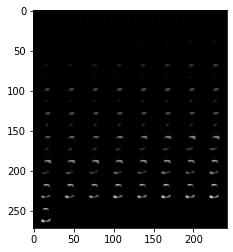

Epoch [293/400] Batch: [1/60] KL-Divergence: 0.030452826991677284 Cross-Entropy: 0.2001613825559616 Loss: 0.23061421513557434
Epoch [293/400] Batch: [2/60] KL-Divergence: 0.030169812962412834 Cross-Entropy: 0.20417724549770355 Loss: 0.23434706032276154
Epoch [293/400] Batch: [3/60] KL-Divergence: 0.03069796785712242 Cross-Entropy: 0.20340146124362946 Loss: 0.23409943282604218
Epoch [293/400] Batch: [4/60] KL-Divergence: 0.030867137014865875 Cross-Entropy: 0.20125162601470947 Loss: 0.23211875557899475
Epoch [293/400] Batch: [5/60] KL-Divergence: 0.032504480332136154 Cross-Entropy: 0.2041284590959549 Loss: 0.23663294315338135
Epoch [293/400] Batch: [6/60] KL-Divergence: 0.031008753925561905 Cross-Entropy: 0.20412622392177582 Loss: 0.23513497412204742
Epoch [293/400] Batch: [7/60] KL-Divergence: 0.029798902571201324 Cross-Entropy: 0.20126283168792725 Loss: 0.23106172680854797
Epoch [293/400] Batch: [8/60] KL-Divergence: 0.029232919216156006 Cross-Entropy: 0.20100602507591248 Loss: 0.23023

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [293/400] Batch: [60/60] KL-Divergence: 0.03152673318982124 Cross-Entropy: 0.20663714408874512 Loss: 0.23816387355327606
Epoch [293/400] Batch: [60/60] KL-Divergence: 0.03152673318982124 Cross-Entropy: 0.20663714408874512 Loss: 0.23816387355327606


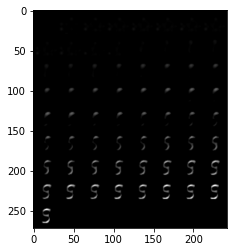

Epoch [294/400] Batch: [1/60] KL-Divergence: 0.030402064323425293 Cross-Entropy: 0.19849242269992828 Loss: 0.22889448702335358
Epoch [294/400] Batch: [2/60] KL-Divergence: 0.030604101717472076 Cross-Entropy: 0.20243269205093384 Loss: 0.23303678631782532
Epoch [294/400] Batch: [3/60] KL-Divergence: 0.0297798290848732 Cross-Entropy: 0.20072035491466522 Loss: 0.23050019145011902
Epoch [294/400] Batch: [4/60] KL-Divergence: 0.030667727813124657 Cross-Entropy: 0.19922161102294922 Loss: 0.22988933324813843
Epoch [294/400] Batch: [5/60] KL-Divergence: 0.032287392765283585 Cross-Entropy: 0.20322749018669128 Loss: 0.23551487922668457
Epoch [294/400] Batch: [6/60] KL-Divergence: 0.03066675178706646 Cross-Entropy: 0.20261941850185394 Loss: 0.23328617215156555
Epoch [294/400] Batch: [7/60] KL-Divergence: 0.029843270778656006 Cross-Entropy: 0.19951438903808594 Loss: 0.22935765981674194
Epoch [294/400] Batch: [8/60] KL-Divergence: 0.030743345618247986 Cross-Entropy: 0.19994989037513733 Loss: 0.23069

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [294/400] Batch: [60/60] KL-Divergence: 0.03276294097304344 Cross-Entropy: 0.20452937483787537 Loss: 0.2372923195362091
Epoch [294/400] Batch: [60/60] KL-Divergence: 0.03276294097304344 Cross-Entropy: 0.20452937483787537 Loss: 0.2372923195362091


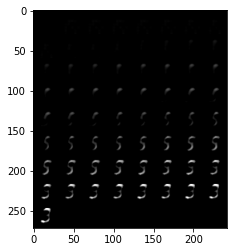

Epoch [295/400] Batch: [1/60] KL-Divergence: 0.032974570989608765 Cross-Entropy: 0.19811950623989105 Loss: 0.23109407722949982
Epoch [295/400] Batch: [2/60] KL-Divergence: 0.030525406822562218 Cross-Entropy: 0.20043765008449554 Loss: 0.23096305131912231
Epoch [295/400] Batch: [3/60] KL-Divergence: 0.030917435884475708 Cross-Entropy: 0.2000882774591446 Loss: 0.2310057133436203
Epoch [295/400] Batch: [4/60] KL-Divergence: 0.030910396948456764 Cross-Entropy: 0.19824010133743286 Loss: 0.22915050387382507
Epoch [295/400] Batch: [5/60] KL-Divergence: 0.03258972987532616 Cross-Entropy: 0.2031610906124115 Loss: 0.23575082421302795
Epoch [295/400] Batch: [6/60] KL-Divergence: 0.03134353831410408 Cross-Entropy: 0.20120973885059357 Loss: 0.23255327343940735
Epoch [295/400] Batch: [7/60] KL-Divergence: 0.030928675085306168 Cross-Entropy: 0.19896246492862701 Loss: 0.22989113628864288
Epoch [295/400] Batch: [8/60] KL-Divergence: 0.030984504148364067 Cross-Entropy: 0.19808329641819 Loss: 0.2290678024

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [295/400] Batch: [60/60] KL-Divergence: 0.03392038121819496 Cross-Entropy: 0.203683003783226 Loss: 0.23760338127613068
Epoch [295/400] Batch: [60/60] KL-Divergence: 0.03392038121819496 Cross-Entropy: 0.203683003783226 Loss: 0.23760338127613068


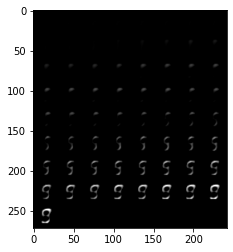

Epoch [296/400] Batch: [1/60] KL-Divergence: 0.0316900871694088 Cross-Entropy: 0.19600756466388702 Loss: 0.22769765555858612
Epoch [296/400] Batch: [2/60] KL-Divergence: 0.03161272779107094 Cross-Entropy: 0.1998147815465927 Loss: 0.23142750561237335
Epoch [296/400] Batch: [3/60] KL-Divergence: 0.03240547329187393 Cross-Entropy: 0.20080915093421936 Loss: 0.2332146167755127
Epoch [296/400] Batch: [4/60] KL-Divergence: 0.032628435641527176 Cross-Entropy: 0.19694466888904572 Loss: 0.2295731008052826
Epoch [296/400] Batch: [5/60] KL-Divergence: 0.03262739256024361 Cross-Entropy: 0.20056691765785217 Loss: 0.23319430649280548
Epoch [296/400] Batch: [6/60] KL-Divergence: 0.03217025101184845 Cross-Entropy: 0.20239512622356415 Loss: 0.2345653772354126
Epoch [296/400] Batch: [7/60] KL-Divergence: 0.03152238205075264 Cross-Entropy: 0.1995335966348648 Loss: 0.23105597496032715
Epoch [296/400] Batch: [8/60] KL-Divergence: 0.03124484233558178 Cross-Entropy: 0.1989532709121704 Loss: 0.2301981151103973

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [296/400] Batch: [60/60] KL-Divergence: 0.03056933358311653 Cross-Entropy: 0.20562325417995453 Loss: 0.23619258403778076
Epoch [296/400] Batch: [60/60] KL-Divergence: 0.03056933358311653 Cross-Entropy: 0.20562325417995453 Loss: 0.23619258403778076


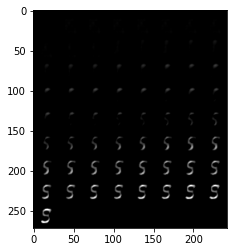

Epoch [297/400] Batch: [1/60] KL-Divergence: 0.0318460576236248 Cross-Entropy: 0.1995210200548172 Loss: 0.2313670814037323
Epoch [297/400] Batch: [2/60] KL-Divergence: 0.03007635474205017 Cross-Entropy: 0.2027028352022171 Loss: 0.23277918994426727
Epoch [297/400] Batch: [3/60] KL-Divergence: 0.03142917528748512 Cross-Entropy: 0.2012939751148224 Loss: 0.2327231466770172
Epoch [297/400] Batch: [4/60] KL-Divergence: 0.031034037470817566 Cross-Entropy: 0.19913166761398315 Loss: 0.23016570508480072
Epoch [297/400] Batch: [5/60] KL-Divergence: 0.031873129308223724 Cross-Entropy: 0.20267948508262634 Loss: 0.23455262184143066
Epoch [297/400] Batch: [6/60] KL-Divergence: 0.03194223716855049 Cross-Entropy: 0.20374847948551178 Loss: 0.23569071292877197
Epoch [297/400] Batch: [7/60] KL-Divergence: 0.03174522891640663 Cross-Entropy: 0.20189575850963593 Loss: 0.23364098370075226
Epoch [297/400] Batch: [8/60] KL-Divergence: 0.033011067658662796 Cross-Entropy: 0.2014787346124649 Loss: 0.23448979854583

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [297/400] Batch: [60/60] KL-Divergence: 0.03236794471740723 Cross-Entropy: 0.2038002610206604 Loss: 0.23616820573806763
Epoch [297/400] Batch: [60/60] KL-Divergence: 0.03236794471740723 Cross-Entropy: 0.2038002610206604 Loss: 0.23616820573806763


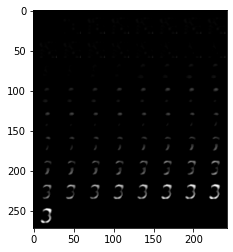

Epoch [298/400] Batch: [1/60] KL-Divergence: 0.03307560831308365 Cross-Entropy: 0.19687215983867645 Loss: 0.2299477756023407
Epoch [298/400] Batch: [2/60] KL-Divergence: 0.03358310088515282 Cross-Entropy: 0.20119746029376984 Loss: 0.23478056490421295
Epoch [298/400] Batch: [3/60] KL-Divergence: 0.031945254653692245 Cross-Entropy: 0.199457585811615 Loss: 0.23140284419059753
Epoch [298/400] Batch: [4/60] KL-Divergence: 0.0317651741206646 Cross-Entropy: 0.19744540750980377 Loss: 0.22921058535575867
Epoch [298/400] Batch: [5/60] KL-Divergence: 0.03290405124425888 Cross-Entropy: 0.20231978595256805 Loss: 0.23522382974624634
Epoch [298/400] Batch: [6/60] KL-Divergence: 0.031882964074611664 Cross-Entropy: 0.20201940834522247 Loss: 0.23390236496925354
Epoch [298/400] Batch: [7/60] KL-Divergence: 0.030627097934484482 Cross-Entropy: 0.1993543803691864 Loss: 0.22998148202896118
Epoch [298/400] Batch: [8/60] KL-Divergence: 0.030815957114100456 Cross-Entropy: 0.19846467673778534 Loss: 0.22928063571

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [298/400] Batch: [60/60] KL-Divergence: 0.02565665915608406 Cross-Entropy: 0.2201620191335678 Loss: 0.24581867456436157
Epoch [298/400] Batch: [60/60] KL-Divergence: 0.02565665915608406 Cross-Entropy: 0.2201620191335678 Loss: 0.24581867456436157


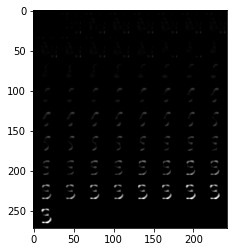

Epoch [299/400] Batch: [1/60] KL-Divergence: 0.025744251906871796 Cross-Entropy: 0.21293441951274872 Loss: 0.23867866396903992
Epoch [299/400] Batch: [2/60] KL-Divergence: 0.025266986340284348 Cross-Entropy: 0.21369187533855438 Loss: 0.23895886540412903
Epoch [299/400] Batch: [3/60] KL-Divergence: 0.02681434340775013 Cross-Entropy: 0.21400760114192963 Loss: 0.2408219426870346
Epoch [299/400] Batch: [4/60] KL-Divergence: 0.026178112253546715 Cross-Entropy: 0.21138499677181244 Loss: 0.2375631034374237
Epoch [299/400] Batch: [5/60] KL-Divergence: 0.027602532878518105 Cross-Entropy: 0.21470370888710022 Loss: 0.24230624735355377
Epoch [299/400] Batch: [6/60] KL-Divergence: 0.026747897267341614 Cross-Entropy: 0.21434050798416138 Loss: 0.241088405251503
Epoch [299/400] Batch: [7/60] KL-Divergence: 0.027117112651467323 Cross-Entropy: 0.21058078110218048 Loss: 0.23769789934158325
Epoch [299/400] Batch: [8/60] KL-Divergence: 0.025848813354969025 Cross-Entropy: 0.208700492978096 Loss: 0.234549313

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [299/400] Batch: [60/60] KL-Divergence: 0.02957029454410076 Cross-Entropy: 0.20876406133174896 Loss: 0.23833435773849487
Epoch [299/400] Batch: [60/60] KL-Divergence: 0.02957029454410076 Cross-Entropy: 0.20876406133174896 Loss: 0.23833435773849487


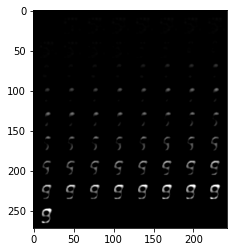

Epoch [300/400] Batch: [1/60] KL-Divergence: 0.03116660565137863 Cross-Entropy: 0.20257608592510223 Loss: 0.23374268412590027
Epoch [300/400] Batch: [2/60] KL-Divergence: 0.029700787737965584 Cross-Entropy: 0.2048703283071518 Loss: 0.23457111418247223
Epoch [300/400] Batch: [3/60] KL-Divergence: 0.02995316870510578 Cross-Entropy: 0.2039288431406021 Loss: 0.23388200998306274
Epoch [300/400] Batch: [4/60] KL-Divergence: 0.02987515553832054 Cross-Entropy: 0.20166099071502686 Loss: 0.2315361499786377
Epoch [300/400] Batch: [5/60] KL-Divergence: 0.03161891549825668 Cross-Entropy: 0.20479343831539154 Loss: 0.23641234636306763
Epoch [300/400] Batch: [6/60] KL-Divergence: 0.030064469203352928 Cross-Entropy: 0.20547927916049957 Loss: 0.23554374277591705
Epoch [300/400] Batch: [7/60] KL-Divergence: 0.03005671501159668 Cross-Entropy: 0.2017461508512497 Loss: 0.23180286586284637
Epoch [300/400] Batch: [8/60] KL-Divergence: 0.030226899310946465 Cross-Entropy: 0.20165085792541504 Loss: 0.23187775909

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [300/400] Batch: [60/60] KL-Divergence: 0.03236810863018036 Cross-Entropy: 0.21109947562217712 Loss: 0.24346758425235748
Epoch [300/400] Batch: [60/60] KL-Divergence: 0.03236810863018036 Cross-Entropy: 0.21109947562217712 Loss: 0.24346758425235748


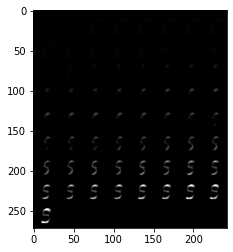

Epoch [301/400] Batch: [1/60] KL-Divergence: 0.029945872724056244 Cross-Entropy: 0.205312117934227 Loss: 0.23525798320770264
Epoch [301/400] Batch: [2/60] KL-Divergence: 0.028859833255410194 Cross-Entropy: 0.2081044316291809 Loss: 0.23696427047252655
Epoch [301/400] Batch: [3/60] KL-Divergence: 0.029756398871541023 Cross-Entropy: 0.207200288772583 Loss: 0.23695668578147888
Epoch [301/400] Batch: [4/60] KL-Divergence: 0.0291183702647686 Cross-Entropy: 0.2060495913028717 Loss: 0.2351679652929306
Epoch [301/400] Batch: [5/60] KL-Divergence: 0.030443627387285233 Cross-Entropy: 0.20955392718315125 Loss: 0.23999755084514618
Epoch [301/400] Batch: [6/60] KL-Divergence: 0.030024340376257896 Cross-Entropy: 0.20816050469875336 Loss: 0.2381848394870758
Epoch [301/400] Batch: [7/60] KL-Divergence: 0.029733851552009583 Cross-Entropy: 0.20662431418895721 Loss: 0.2363581657409668
Epoch [301/400] Batch: [8/60] KL-Divergence: 0.02896946482360363 Cross-Entropy: 0.20611725747585297 Loss: 0.23508672416210

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [301/400] Batch: [60/60] KL-Divergence: 0.032157596200704575 Cross-Entropy: 0.20819136500358582 Loss: 0.2403489649295807
Epoch [301/400] Batch: [60/60] KL-Divergence: 0.032157596200704575 Cross-Entropy: 0.20819136500358582 Loss: 0.2403489649295807


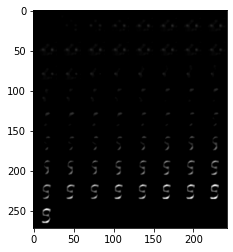

Epoch [302/400] Batch: [1/60] KL-Divergence: 0.031235771253705025 Cross-Entropy: 0.20133046805858612 Loss: 0.232566237449646
Epoch [302/400] Batch: [2/60] KL-Divergence: 0.03094225563108921 Cross-Entropy: 0.20485661923885345 Loss: 0.2357988804578781
Epoch [302/400] Batch: [3/60] KL-Divergence: 0.029643753543496132 Cross-Entropy: 0.20537413656711578 Loss: 0.23501789569854736
Epoch [302/400] Batch: [4/60] KL-Divergence: 0.030060337856411934 Cross-Entropy: 0.20236092805862427 Loss: 0.23242126405239105
Epoch [302/400] Batch: [5/60] KL-Divergence: 0.03114348277449608 Cross-Entropy: 0.20723441243171692 Loss: 0.2383778989315033
Epoch [302/400] Batch: [6/60] KL-Divergence: 0.031072493642568588 Cross-Entropy: 0.20628823339939117 Loss: 0.23736073076725006
Epoch [302/400] Batch: [7/60] KL-Divergence: 0.02980947121977806 Cross-Entropy: 0.20298026502132416 Loss: 0.23278973996639252
Epoch [302/400] Batch: [8/60] KL-Divergence: 0.03005720116198063 Cross-Entropy: 0.2010374218225479 Loss: 0.23109462857

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [302/400] Batch: [60/60] KL-Divergence: 0.030938753858208656 Cross-Entropy: 0.20475757122039795 Loss: 0.23569633066654205
Epoch [302/400] Batch: [60/60] KL-Divergence: 0.030938753858208656 Cross-Entropy: 0.20475757122039795 Loss: 0.23569633066654205


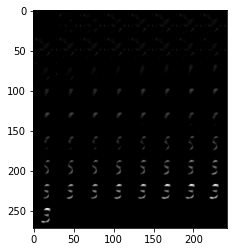

Epoch [303/400] Batch: [1/60] KL-Divergence: 0.031317390501499176 Cross-Entropy: 0.1971714049577713 Loss: 0.22848880290985107
Epoch [303/400] Batch: [2/60] KL-Divergence: 0.03166341781616211 Cross-Entropy: 0.20194177329540253 Loss: 0.23360519111156464
Epoch [303/400] Batch: [3/60] KL-Divergence: 0.03232225403189659 Cross-Entropy: 0.2004023939371109 Loss: 0.2327246516942978
Epoch [303/400] Batch: [4/60] KL-Divergence: 0.03091941773891449 Cross-Entropy: 0.19796064496040344 Loss: 0.22888006269931793
Epoch [303/400] Batch: [5/60] KL-Divergence: 0.03242458403110504 Cross-Entropy: 0.20234093070030212 Loss: 0.23476551473140717
Epoch [303/400] Batch: [6/60] KL-Divergence: 0.03161219134926796 Cross-Entropy: 0.20280495285987854 Loss: 0.2344171404838562
Epoch [303/400] Batch: [7/60] KL-Divergence: 0.030934646725654602 Cross-Entropy: 0.19938093423843384 Loss: 0.23031558096408844
Epoch [303/400] Batch: [8/60] KL-Divergence: 0.030627600848674774 Cross-Entropy: 0.19921550154685974 Loss: 0.22984310984

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [303/400] Batch: [60/60] KL-Divergence: 0.0322386734187603 Cross-Entropy: 0.20366281270980835 Loss: 0.23590148985385895
Epoch [303/400] Batch: [60/60] KL-Divergence: 0.0322386734187603 Cross-Entropy: 0.20366281270980835 Loss: 0.23590148985385895


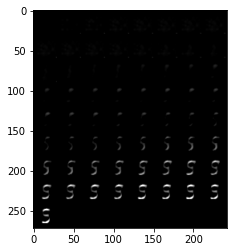

Epoch [304/400] Batch: [1/60] KL-Divergence: 0.031964998692274094 Cross-Entropy: 0.19728276133537292 Loss: 0.22924776375293732
Epoch [304/400] Batch: [2/60] KL-Divergence: 0.03183498978614807 Cross-Entropy: 0.20226924121379852 Loss: 0.2341042309999466
Epoch [304/400] Batch: [3/60] KL-Divergence: 0.03273400664329529 Cross-Entropy: 0.20117425918579102 Loss: 0.2339082658290863
Epoch [304/400] Batch: [4/60] KL-Divergence: 0.03135963901877403 Cross-Entropy: 0.19834500551223755 Loss: 0.22970464825630188
Epoch [304/400] Batch: [5/60] KL-Divergence: 0.03212275728583336 Cross-Entropy: 0.20242346823215485 Loss: 0.2345462292432785
Epoch [304/400] Batch: [6/60] KL-Divergence: 0.030815260484814644 Cross-Entropy: 0.20324309170246124 Loss: 0.23405835032463074
Epoch [304/400] Batch: [7/60] KL-Divergence: 0.03121190331876278 Cross-Entropy: 0.19935999810695648 Loss: 0.2305718958377838
Epoch [304/400] Batch: [8/60] KL-Divergence: 0.02986834943294525 Cross-Entropy: 0.19817779958248138 Loss: 0.228046149015

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [304/400] Batch: [60/60] KL-Divergence: 0.03401578217744827 Cross-Entropy: 0.2073100209236145 Loss: 0.24132579565048218
Epoch [304/400] Batch: [60/60] KL-Divergence: 0.03401578217744827 Cross-Entropy: 0.2073100209236145 Loss: 0.24132579565048218


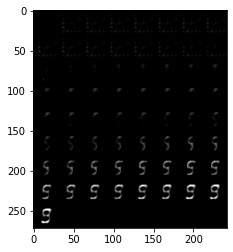

Epoch [305/400] Batch: [1/60] KL-Divergence: 0.034841425716876984 Cross-Entropy: 0.20055611431598663 Loss: 0.2353975474834442
Epoch [305/400] Batch: [2/60] KL-Divergence: 0.03320859372615814 Cross-Entropy: 0.20560741424560547 Loss: 0.2388160079717636
Epoch [305/400] Batch: [3/60] KL-Divergence: 0.03365536406636238 Cross-Entropy: 0.20569126307964325 Loss: 0.23934662342071533
Epoch [305/400] Batch: [4/60] KL-Divergence: 0.033333320170640945 Cross-Entropy: 0.20513524115085602 Loss: 0.23846855759620667
Epoch [305/400] Batch: [5/60] KL-Divergence: 0.03456311300396919 Cross-Entropy: 0.20971132814884186 Loss: 0.24427443742752075
Epoch [305/400] Batch: [6/60] KL-Divergence: 0.033637259155511856 Cross-Entropy: 0.20648911595344543 Loss: 0.240126371383667
Epoch [305/400] Batch: [7/60] KL-Divergence: 0.031152011826634407 Cross-Entropy: 0.20152553915977478 Loss: 0.23267754912376404
Epoch [305/400] Batch: [8/60] KL-Divergence: 0.03165389224886894 Cross-Entropy: 0.20158900320529938 Loss: 0.2332428991

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [305/400] Batch: [60/60] KL-Divergence: 0.03213823586702347 Cross-Entropy: 0.20475254952907562 Loss: 0.2368907928466797
Epoch [305/400] Batch: [60/60] KL-Divergence: 0.03213823586702347 Cross-Entropy: 0.20475254952907562 Loss: 0.2368907928466797


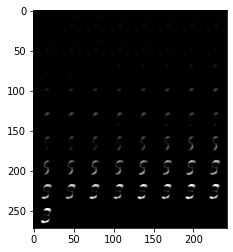

Epoch [306/400] Batch: [1/60] KL-Divergence: 0.03240679204463959 Cross-Entropy: 0.1990119367837906 Loss: 0.23141872882843018
Epoch [306/400] Batch: [2/60] KL-Divergence: 0.03249453380703926 Cross-Entropy: 0.20250745117664337 Loss: 0.23500198125839233
Epoch [306/400] Batch: [3/60] KL-Divergence: 0.032457999885082245 Cross-Entropy: 0.1999935358762741 Loss: 0.23245152831077576
Epoch [306/400] Batch: [4/60] KL-Divergence: 0.030904320999979973 Cross-Entropy: 0.1978822499513626 Loss: 0.22878657281398773
Epoch [306/400] Batch: [5/60] KL-Divergence: 0.03261507302522659 Cross-Entropy: 0.20312702655792236 Loss: 0.23574209213256836
Epoch [306/400] Batch: [6/60] KL-Divergence: 0.032907649874687195 Cross-Entropy: 0.20313787460327148 Loss: 0.23604552447795868
Epoch [306/400] Batch: [7/60] KL-Divergence: 0.030455898493528366 Cross-Entropy: 0.19947125017642975 Loss: 0.2299271523952484
Epoch [306/400] Batch: [8/60] KL-Divergence: 0.030941760167479515 Cross-Entropy: 0.19858703017234802 Loss: 0.229528784

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [306/400] Batch: [60/60] KL-Divergence: 0.032176580280065536 Cross-Entropy: 0.2036621868610382 Loss: 0.23583877086639404
Epoch [306/400] Batch: [60/60] KL-Divergence: 0.032176580280065536 Cross-Entropy: 0.2036621868610382 Loss: 0.23583877086639404


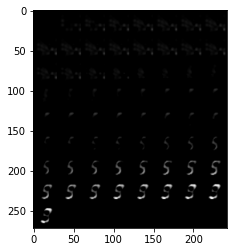

Epoch [307/400] Batch: [1/60] KL-Divergence: 0.032029177993535995 Cross-Entropy: 0.1988549679517746 Loss: 0.2308841496706009
Epoch [307/400] Batch: [2/60] KL-Divergence: 0.032352469861507416 Cross-Entropy: 0.2035362720489502 Loss: 0.2358887493610382
Epoch [307/400] Batch: [3/60] KL-Divergence: 0.031683050096035004 Cross-Entropy: 0.20103611052036285 Loss: 0.23271915316581726
Epoch [307/400] Batch: [4/60] KL-Divergence: 0.03161342814564705 Cross-Entropy: 0.20051176846027374 Loss: 0.2321251928806305
Epoch [307/400] Batch: [5/60] KL-Divergence: 0.03366183862090111 Cross-Entropy: 0.2015518844127655 Loss: 0.2352137267589569
Epoch [307/400] Batch: [6/60] KL-Divergence: 0.033517517149448395 Cross-Entropy: 0.2030625194311142 Loss: 0.2365800440311432
Epoch [307/400] Batch: [7/60] KL-Divergence: 0.031448133289813995 Cross-Entropy: 0.19943538308143616 Loss: 0.23088350892066956
Epoch [307/400] Batch: [8/60] KL-Divergence: 0.03122268058359623 Cross-Entropy: 0.1991409957408905 Loss: 0.230363681912422

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [307/400] Batch: [60/60] KL-Divergence: 0.03258217126131058 Cross-Entropy: 0.20260486006736755 Loss: 0.23518702387809753
Epoch [307/400] Batch: [60/60] KL-Divergence: 0.03258217126131058 Cross-Entropy: 0.20260486006736755 Loss: 0.23518702387809753


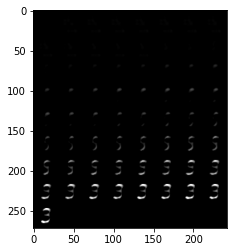

Epoch [308/400] Batch: [1/60] KL-Divergence: 0.03325825557112694 Cross-Entropy: 0.19649778306484222 Loss: 0.22975604236125946
Epoch [308/400] Batch: [2/60] KL-Divergence: 0.03234671428799629 Cross-Entropy: 0.19969157874584198 Loss: 0.23203828930854797
Epoch [308/400] Batch: [3/60] KL-Divergence: 0.03303828835487366 Cross-Entropy: 0.1993967890739441 Loss: 0.23243507742881775
Epoch [308/400] Batch: [4/60] KL-Divergence: 0.031952958554029465 Cross-Entropy: 0.19695626199245453 Loss: 0.2289092242717743
Epoch [308/400] Batch: [5/60] KL-Divergence: 0.03325530141592026 Cross-Entropy: 0.20192842185497284 Loss: 0.2351837158203125
Epoch [308/400] Batch: [6/60] KL-Divergence: 0.032736245542764664 Cross-Entropy: 0.20221272110939026 Loss: 0.23494896292686462
Epoch [308/400] Batch: [7/60] KL-Divergence: 0.031816791743040085 Cross-Entropy: 0.19918565452098846 Loss: 0.23100244998931885
Epoch [308/400] Batch: [8/60] KL-Divergence: 0.030894573777914047 Cross-Entropy: 0.19837498664855957 Loss: 0.229269564

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [308/400] Batch: [60/60] KL-Divergence: 0.03246238827705383 Cross-Entropy: 0.20244204998016357 Loss: 0.2349044382572174
Epoch [308/400] Batch: [60/60] KL-Divergence: 0.03246238827705383 Cross-Entropy: 0.20244204998016357 Loss: 0.2349044382572174


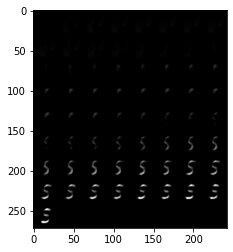

Epoch [309/400] Batch: [1/60] KL-Divergence: 0.03233620151877403 Cross-Entropy: 0.19623695313930511 Loss: 0.22857315838336945
Epoch [309/400] Batch: [2/60] KL-Divergence: 0.03070097789168358 Cross-Entropy: 0.19937115907669067 Loss: 0.23007214069366455
Epoch [309/400] Batch: [3/60] KL-Divergence: 0.03176473081111908 Cross-Entropy: 0.19853328168392181 Loss: 0.2302980124950409
Epoch [309/400] Batch: [4/60] KL-Divergence: 0.03258071094751358 Cross-Entropy: 0.19683927297592163 Loss: 0.22941997647285461
Epoch [309/400] Batch: [5/60] KL-Divergence: 0.032476991415023804 Cross-Entropy: 0.20002606511116028 Loss: 0.23250305652618408
Epoch [309/400] Batch: [6/60] KL-Divergence: 0.0318266898393631 Cross-Entropy: 0.2006254494190216 Loss: 0.2324521392583847
Epoch [309/400] Batch: [7/60] KL-Divergence: 0.03176385536789894 Cross-Entropy: 0.19815506041049957 Loss: 0.22991891205310822
Epoch [309/400] Batch: [8/60] KL-Divergence: 0.03110191598534584 Cross-Entropy: 0.19668430089950562 Loss: 0.2277862131595

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [309/400] Batch: [60/60] KL-Divergence: 0.03187408298254013 Cross-Entropy: 0.20298545062541962 Loss: 0.23485952615737915
Epoch [309/400] Batch: [60/60] KL-Divergence: 0.03187408298254013 Cross-Entropy: 0.20298545062541962 Loss: 0.23485952615737915


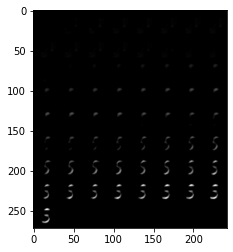

Epoch [310/400] Batch: [1/60] KL-Divergence: 0.03292866796255112 Cross-Entropy: 0.1982378512620926 Loss: 0.2311665117740631
Epoch [310/400] Batch: [2/60] KL-Divergence: 0.031204447150230408 Cross-Entropy: 0.20171348750591278 Loss: 0.2329179346561432
Epoch [310/400] Batch: [3/60] KL-Divergence: 0.031670261174440384 Cross-Entropy: 0.20051641762256622 Loss: 0.2321866750717163
Epoch [310/400] Batch: [4/60] KL-Divergence: 0.031542059034109116 Cross-Entropy: 0.19856134057044983 Loss: 0.23010340332984924
Epoch [310/400] Batch: [5/60] KL-Divergence: 0.03333115205168724 Cross-Entropy: 0.20135870575904846 Loss: 0.234689861536026
Epoch [310/400] Batch: [6/60] KL-Divergence: 0.03175102919340134 Cross-Entropy: 0.20146918296813965 Loss: 0.23322021961212158
Epoch [310/400] Batch: [7/60] KL-Divergence: 0.03157072141766548 Cross-Entropy: 0.20003828406333923 Loss: 0.23160900175571442
Epoch [310/400] Batch: [8/60] KL-Divergence: 0.031120268628001213 Cross-Entropy: 0.1991020292043686 Loss: 0.2302222996950

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [310/400] Batch: [60/60] KL-Divergence: 0.030628982931375504 Cross-Entropy: 0.21351830661296844 Loss: 0.24414728581905365
Epoch [310/400] Batch: [60/60] KL-Divergence: 0.030628982931375504 Cross-Entropy: 0.21351830661296844 Loss: 0.24414728581905365


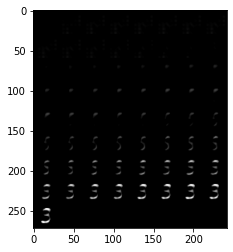

Epoch [311/400] Batch: [1/60] KL-Divergence: 0.029892684891819954 Cross-Entropy: 0.20774218440055847 Loss: 0.23763486742973328
Epoch [311/400] Batch: [2/60] KL-Divergence: 0.030160820111632347 Cross-Entropy: 0.20869307219982147 Loss: 0.23885388672351837
Epoch [311/400] Batch: [3/60] KL-Divergence: 0.029589809477329254 Cross-Entropy: 0.21175457537174225 Loss: 0.2413443922996521
Epoch [311/400] Batch: [4/60] KL-Divergence: 0.029896752908825874 Cross-Entropy: 0.2048097550868988 Loss: 0.23470650613307953
Epoch [311/400] Batch: [5/60] KL-Divergence: 0.030811073258519173 Cross-Entropy: 0.2101006805896759 Loss: 0.24091175198554993
Epoch [311/400] Batch: [6/60] KL-Divergence: 0.030011605471372604 Cross-Entropy: 0.21062058210372925 Loss: 0.24063219130039215
Epoch [311/400] Batch: [7/60] KL-Divergence: 0.030625641345977783 Cross-Entropy: 0.20830576121807098 Loss: 0.23893140256404877
Epoch [311/400] Batch: [8/60] KL-Divergence: 0.029943400993943214 Cross-Entropy: 0.20523902773857117 Loss: 0.23518

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [311/400] Batch: [60/60] KL-Divergence: 0.03191014751791954 Cross-Entropy: 0.2047698050737381 Loss: 0.23667995631694794
Epoch [311/400] Batch: [60/60] KL-Divergence: 0.03191014751791954 Cross-Entropy: 0.2047698050737381 Loss: 0.23667995631694794


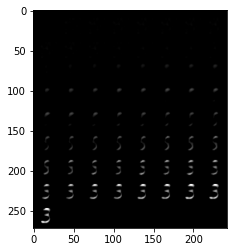

Epoch [312/400] Batch: [1/60] KL-Divergence: 0.030871419236063957 Cross-Entropy: 0.19876651465892792 Loss: 0.22963793575763702
Epoch [312/400] Batch: [2/60] KL-Divergence: 0.030391786247491837 Cross-Entropy: 0.20197023451328278 Loss: 0.23236201703548431
Epoch [312/400] Batch: [3/60] KL-Divergence: 0.030655719339847565 Cross-Entropy: 0.20251667499542236 Loss: 0.23317238688468933
Epoch [312/400] Batch: [4/60] KL-Divergence: 0.03156820312142372 Cross-Entropy: 0.19930802285671234 Loss: 0.23087622225284576
Epoch [312/400] Batch: [5/60] KL-Divergence: 0.03221151605248451 Cross-Entropy: 0.2025204449892044 Loss: 0.23473195731639862
Epoch [312/400] Batch: [6/60] KL-Divergence: 0.03155463933944702 Cross-Entropy: 0.20302248001098633 Loss: 0.23457711935043335
Epoch [312/400] Batch: [7/60] KL-Divergence: 0.03040083684027195 Cross-Entropy: 0.2006644904613495 Loss: 0.23106533288955688
Epoch [312/400] Batch: [8/60] KL-Divergence: 0.030774341896176338 Cross-Entropy: 0.19888657331466675 Loss: 0.22966091

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [312/400] Batch: [60/60] KL-Divergence: 0.03524527698755264 Cross-Entropy: 0.2192951738834381 Loss: 0.25454044342041016
Epoch [312/400] Batch: [60/60] KL-Divergence: 0.03524527698755264 Cross-Entropy: 0.2192951738834381 Loss: 0.25454044342041016


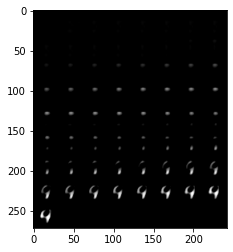

Epoch [313/400] Batch: [1/60] KL-Divergence: 0.03355542570352554 Cross-Entropy: 0.21206969022750854 Loss: 0.2456251084804535
Epoch [313/400] Batch: [2/60] KL-Divergence: 0.03230290487408638 Cross-Entropy: 0.2118307501077652 Loss: 0.24413365125656128
Epoch [313/400] Batch: [3/60] KL-Divergence: 0.03143869712948799 Cross-Entropy: 0.20925571024417877 Loss: 0.24069440364837646
Epoch [313/400] Batch: [4/60] KL-Divergence: 0.030400335788726807 Cross-Entropy: 0.20726278424263 Loss: 0.2376631200313568
Epoch [313/400] Batch: [5/60] KL-Divergence: 0.03205867111682892 Cross-Entropy: 0.21133628487586975 Loss: 0.24339495599269867
Epoch [313/400] Batch: [6/60] KL-Divergence: 0.031284671276807785 Cross-Entropy: 0.21122996509075165 Loss: 0.24251464009284973
Epoch [313/400] Batch: [7/60] KL-Divergence: 0.03012147545814514 Cross-Entropy: 0.20810912549495697 Loss: 0.2382306009531021
Epoch [313/400] Batch: [8/60] KL-Divergence: 0.029407553374767303 Cross-Entropy: 0.2068503201007843 Loss: 0.236257880926132

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [313/400] Batch: [60/60] KL-Divergence: 0.031214168295264244 Cross-Entropy: 0.2069464474916458 Loss: 0.2381606101989746
Epoch [313/400] Batch: [60/60] KL-Divergence: 0.031214168295264244 Cross-Entropy: 0.2069464474916458 Loss: 0.2381606101989746


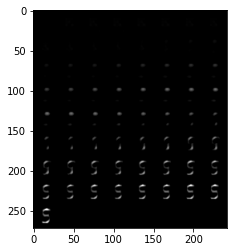

Epoch [314/400] Batch: [1/60] KL-Divergence: 0.03075234591960907 Cross-Entropy: 0.20024429261684418 Loss: 0.23099663853645325
Epoch [314/400] Batch: [2/60] KL-Divergence: 0.030260009691119194 Cross-Entropy: 0.2036401927471161 Loss: 0.23390020430088043
Epoch [314/400] Batch: [3/60] KL-Divergence: 0.03101065196096897 Cross-Entropy: 0.20273122191429138 Loss: 0.2337418794631958
Epoch [314/400] Batch: [4/60] KL-Divergence: 0.029639314860105515 Cross-Entropy: 0.20202802121639252 Loss: 0.23166733980178833
Epoch [314/400] Batch: [5/60] KL-Divergence: 0.03293045982718468 Cross-Entropy: 0.20449987053871155 Loss: 0.23743033409118652
Epoch [314/400] Batch: [6/60] KL-Divergence: 0.03124246560037136 Cross-Entropy: 0.20526482164859772 Loss: 0.23650728166103363
Epoch [314/400] Batch: [7/60] KL-Divergence: 0.030443426221609116 Cross-Entropy: 0.20094139873981476 Loss: 0.23138482868671417
Epoch [314/400] Batch: [8/60] KL-Divergence: 0.029893115162849426 Cross-Entropy: 0.20238694548606873 Loss: 0.23228006

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [314/400] Batch: [60/60] KL-Divergence: 0.02731230854988098 Cross-Entropy: 0.21565969288349152 Loss: 0.2429720014333725
Epoch [314/400] Batch: [60/60] KL-Divergence: 0.02731230854988098 Cross-Entropy: 0.21565969288349152 Loss: 0.2429720014333725


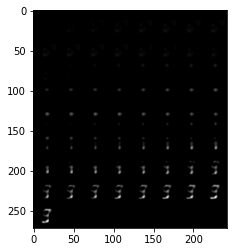

Epoch [315/400] Batch: [1/60] KL-Divergence: 0.027258196845650673 Cross-Entropy: 0.20615611970424652 Loss: 0.23341432213783264
Epoch [315/400] Batch: [2/60] KL-Divergence: 0.026766572147607803 Cross-Entropy: 0.20746180415153503 Loss: 0.23422837257385254
Epoch [315/400] Batch: [3/60] KL-Divergence: 0.02714480832219124 Cross-Entropy: 0.2086559683084488 Loss: 0.23580077290534973
Epoch [315/400] Batch: [4/60] KL-Divergence: 0.027040787041187286 Cross-Entropy: 0.20356318354606628 Loss: 0.23060396313667297
Epoch [315/400] Batch: [5/60] KL-Divergence: 0.029171383008360863 Cross-Entropy: 0.2097635120153427 Loss: 0.23893488943576813
Epoch [315/400] Batch: [6/60] KL-Divergence: 0.028707290068268776 Cross-Entropy: 0.21018154919147491 Loss: 0.23888884484767914
Epoch [315/400] Batch: [7/60] KL-Divergence: 0.027493001893162727 Cross-Entropy: 0.20457340776920319 Loss: 0.23206640779972076
Epoch [315/400] Batch: [8/60] KL-Divergence: 0.02831844426691532 Cross-Entropy: 0.20369680225849152 Loss: 0.232015

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [315/400] Batch: [60/60] KL-Divergence: 0.030892161652445793 Cross-Entropy: 0.20696361362934113 Loss: 0.23785577714443207
Epoch [315/400] Batch: [60/60] KL-Divergence: 0.030892161652445793 Cross-Entropy: 0.20696361362934113 Loss: 0.23785577714443207


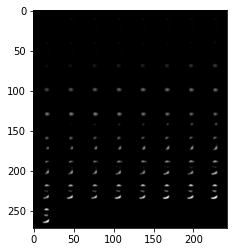

Epoch [316/400] Batch: [1/60] KL-Divergence: 0.031145896762609482 Cross-Entropy: 0.20120491087436676 Loss: 0.23235081136226654
Epoch [316/400] Batch: [2/60] KL-Divergence: 0.029874922707676888 Cross-Entropy: 0.2023821622133255 Loss: 0.23225708305835724
Epoch [316/400] Batch: [3/60] KL-Divergence: 0.03057350590825081 Cross-Entropy: 0.20305535197257996 Loss: 0.23362885415554047
Epoch [316/400] Batch: [4/60] KL-Divergence: 0.029857074841856956 Cross-Entropy: 0.2007354497909546 Loss: 0.2305925190448761
Epoch [316/400] Batch: [5/60] KL-Divergence: 0.031765323132276535 Cross-Entropy: 0.2023255079984665 Loss: 0.23409083485603333
Epoch [316/400] Batch: [6/60] KL-Divergence: 0.03039654716849327 Cross-Entropy: 0.20424839854240417 Loss: 0.23464494943618774
Epoch [316/400] Batch: [7/60] KL-Divergence: 0.029678449034690857 Cross-Entropy: 0.2004946768283844 Loss: 0.23017312586307526
Epoch [316/400] Batch: [8/60] KL-Divergence: 0.02994011715054512 Cross-Entropy: 0.19951649010181427 Loss: 0.2294566035

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [316/400] Batch: [60/60] KL-Divergence: 0.008019947446882725 Cross-Entropy: 0.2661214768886566 Loss: 0.27414143085479736
Epoch [316/400] Batch: [60/60] KL-Divergence: 0.008019947446882725 Cross-Entropy: 0.2661214768886566 Loss: 0.27414143085479736


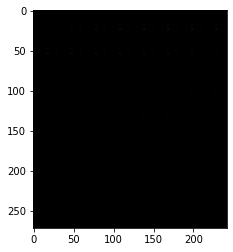

Epoch [317/400] Batch: [1/60] KL-Divergence: 0.00832321122288704 Cross-Entropy: 0.2545308470726013 Loss: 0.26285406947135925
Epoch [317/400] Batch: [2/60] KL-Divergence: 0.006920086685568094 Cross-Entropy: 0.25502148270606995 Loss: 0.2619415819644928
Epoch [317/400] Batch: [3/60] KL-Divergence: 0.007102139759808779 Cross-Entropy: 0.25845468044281006 Loss: 0.26555681228637695
Epoch [317/400] Batch: [4/60] KL-Divergence: 0.007015415467321873 Cross-Entropy: 0.25265374779701233 Loss: 0.25966915488243103
Epoch [317/400] Batch: [5/60] KL-Divergence: 0.0073193758726119995 Cross-Entropy: 0.2618490159511566 Loss: 0.2691683769226074
Epoch [317/400] Batch: [6/60] KL-Divergence: 0.006444612983614206 Cross-Entropy: 0.2613663077354431 Loss: 0.2678109109401703
Epoch [317/400] Batch: [7/60] KL-Divergence: 0.0065344772301614285 Cross-Entropy: 0.25516200065612793 Loss: 0.2616964876651764
Epoch [317/400] Batch: [8/60] KL-Divergence: 0.0064575644209980965 Cross-Entropy: 0.2496725618839264 Loss: 0.25613012

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [317/400] Batch: [60/60] KL-Divergence: 0.007713450584560633 Cross-Entropy: 0.2609109580516815 Loss: 0.2686243951320648
Epoch [317/400] Batch: [60/60] KL-Divergence: 0.007713450584560633 Cross-Entropy: 0.2609109580516815 Loss: 0.2686243951320648


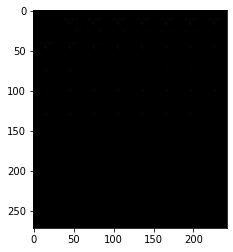

Epoch [318/400] Batch: [1/60] KL-Divergence: 0.008470960892736912 Cross-Entropy: 0.24885493516921997 Loss: 0.2573258876800537
Epoch [318/400] Batch: [2/60] KL-Divergence: 0.007786241360008717 Cross-Entropy: 0.2494444102048874 Loss: 0.25723063945770264
Epoch [318/400] Batch: [3/60] KL-Divergence: 0.008201824501156807 Cross-Entropy: 0.2515409588813782 Loss: 0.259742796421051
Epoch [318/400] Batch: [4/60] KL-Divergence: 0.008523035794496536 Cross-Entropy: 0.24526803195476532 Loss: 0.25379106402397156
Epoch [318/400] Batch: [5/60] KL-Divergence: 0.00887652114033699 Cross-Entropy: 0.2546110451221466 Loss: 0.2634875774383545
Epoch [318/400] Batch: [6/60] KL-Divergence: 0.00817127525806427 Cross-Entropy: 0.2538755238056183 Loss: 0.26204681396484375
Epoch [318/400] Batch: [7/60] KL-Divergence: 0.00832106452435255 Cross-Entropy: 0.24739539623260498 Loss: 0.255716472864151
Epoch [318/400] Batch: [8/60] KL-Divergence: 0.008698754012584686 Cross-Entropy: 0.2426653653383255 Loss: 0.2513641119003296

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [318/400] Batch: [60/60] KL-Divergence: 0.009204498492181301 Cross-Entropy: 0.25553467869758606 Loss: 0.26473918557167053
Epoch [318/400] Batch: [60/60] KL-Divergence: 0.009204498492181301 Cross-Entropy: 0.25553467869758606 Loss: 0.26473918557167053


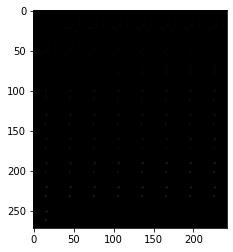

Epoch [319/400] Batch: [1/60] KL-Divergence: 0.010179435834288597 Cross-Entropy: 0.24344901740550995 Loss: 0.2536284625530243
Epoch [319/400] Batch: [2/60] KL-Divergence: 0.00948342401534319 Cross-Entropy: 0.24458640813827515 Loss: 0.25406983494758606
Epoch [319/400] Batch: [3/60] KL-Divergence: 0.010516182519495487 Cross-Entropy: 0.24716012179851532 Loss: 0.25767630338668823
Epoch [319/400] Batch: [4/60] KL-Divergence: 0.010714150033891201 Cross-Entropy: 0.241562157869339 Loss: 0.25227630138397217
Epoch [319/400] Batch: [5/60] KL-Divergence: 0.01099297497421503 Cross-Entropy: 0.24962525069713593 Loss: 0.2606182396411896
Epoch [319/400] Batch: [6/60] KL-Divergence: 0.010106967762112617 Cross-Entropy: 0.24853044748306274 Loss: 0.2586374282836914
Epoch [319/400] Batch: [7/60] KL-Divergence: 0.01006042305380106 Cross-Entropy: 0.24359118938446045 Loss: 0.25365161895751953
Epoch [319/400] Batch: [8/60] KL-Divergence: 0.010833178646862507 Cross-Entropy: 0.23843879997730255 Loss: 0.2492719739

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [319/400] Batch: [60/60] KL-Divergence: 0.010403001680970192 Cross-Entropy: 0.25271838903427124 Loss: 0.2631213963031769
Epoch [319/400] Batch: [60/60] KL-Divergence: 0.010403001680970192 Cross-Entropy: 0.25271838903427124 Loss: 0.2631213963031769


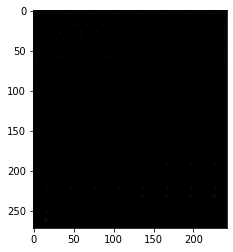

Epoch [320/400] Batch: [1/60] KL-Divergence: 0.0113410959020257 Cross-Entropy: 0.24102447926998138 Loss: 0.2523655891418457
Epoch [320/400] Batch: [2/60] KL-Divergence: 0.010766937397420406 Cross-Entropy: 0.24213330447673798 Loss: 0.25290024280548096
Epoch [320/400] Batch: [3/60] KL-Divergence: 0.010937227867543697 Cross-Entropy: 0.2449483871459961 Loss: 0.25588560104370117
Epoch [320/400] Batch: [4/60] KL-Divergence: 0.01164454035460949 Cross-Entropy: 0.23842187225818634 Loss: 0.2500663995742798
Epoch [320/400] Batch: [5/60] KL-Divergence: 0.011749438010156155 Cross-Entropy: 0.2458355724811554 Loss: 0.2575850188732147
Epoch [320/400] Batch: [6/60] KL-Divergence: 0.012195471674203873 Cross-Entropy: 0.24726569652557373 Loss: 0.2594611644744873
Epoch [320/400] Batch: [7/60] KL-Divergence: 0.011186245828866959 Cross-Entropy: 0.24098239839076996 Loss: 0.2521686553955078
Epoch [320/400] Batch: [8/60] KL-Divergence: 0.01155844982713461 Cross-Entropy: 0.23647667467594147 Loss: 0.2480351179838

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [320/400] Batch: [60/60] KL-Divergence: 0.011258892714977264 Cross-Entropy: 0.251545786857605 Loss: 0.26280468702316284
Epoch [320/400] Batch: [60/60] KL-Divergence: 0.011258892714977264 Cross-Entropy: 0.251545786857605 Loss: 0.26280468702316284


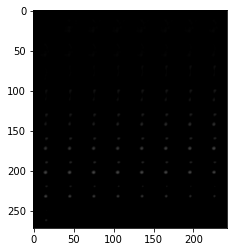

Epoch [321/400] Batch: [1/60] KL-Divergence: 0.012083576060831547 Cross-Entropy: 0.24044354259967804 Loss: 0.252527117729187
Epoch [321/400] Batch: [2/60] KL-Divergence: 0.011558879166841507 Cross-Entropy: 0.24120686948299408 Loss: 0.2527657449245453
Epoch [321/400] Batch: [3/60] KL-Divergence: 0.012102056294679642 Cross-Entropy: 0.24287700653076172 Loss: 0.25497907400131226
Epoch [321/400] Batch: [4/60] KL-Divergence: 0.011975187808275223 Cross-Entropy: 0.2369459569454193 Loss: 0.24892114102840424
Epoch [321/400] Batch: [5/60] KL-Divergence: 0.012767435982823372 Cross-Entropy: 0.24648119509220123 Loss: 0.25924864411354065
Epoch [321/400] Batch: [6/60] KL-Divergence: 0.012403523549437523 Cross-Entropy: 0.24467788636684418 Loss: 0.25708141922950745
Epoch [321/400] Batch: [7/60] KL-Divergence: 0.011452740989625454 Cross-Entropy: 0.24002119898796082 Loss: 0.25147393345832825
Epoch [321/400] Batch: [8/60] KL-Divergence: 0.01155543327331543 Cross-Entropy: 0.23500286042690277 Loss: 0.2465582

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [321/400] Batch: [60/60] KL-Divergence: 0.01231437735259533 Cross-Entropy: 0.24977177381515503 Loss: 0.2620861530303955
Epoch [321/400] Batch: [60/60] KL-Divergence: 0.01231437735259533 Cross-Entropy: 0.24977177381515503 Loss: 0.2620861530303955


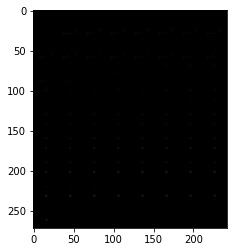

Epoch [322/400] Batch: [1/60] KL-Divergence: 0.012577792629599571 Cross-Entropy: 0.23821057379245758 Loss: 0.2507883608341217
Epoch [322/400] Batch: [2/60] KL-Divergence: 0.0121284369379282 Cross-Entropy: 0.2388601005077362 Loss: 0.25098854303359985
Epoch [322/400] Batch: [3/60] KL-Divergence: 0.01261960156261921 Cross-Entropy: 0.23992955684661865 Loss: 0.2525491714477539
Epoch [322/400] Batch: [4/60] KL-Divergence: 0.013967080041766167 Cross-Entropy: 0.2357224076986313 Loss: 0.2496894896030426
Epoch [322/400] Batch: [5/60] KL-Divergence: 0.013843555934727192 Cross-Entropy: 0.2433778941631317 Loss: 0.2572214603424072
Epoch [322/400] Batch: [6/60] KL-Divergence: 0.013225718401372433 Cross-Entropy: 0.24152307212352753 Loss: 0.25474879145622253
Epoch [322/400] Batch: [7/60] KL-Divergence: 0.011898917146027088 Cross-Entropy: 0.23736576735973358 Loss: 0.2492646872997284
Epoch [322/400] Batch: [8/60] KL-Divergence: 0.012882307171821594 Cross-Entropy: 0.2328113317489624 Loss: 0.24569363892078

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [322/400] Batch: [60/60] KL-Divergence: 0.014111868105828762 Cross-Entropy: 0.2471897453069687 Loss: 0.26130160689353943
Epoch [322/400] Batch: [60/60] KL-Divergence: 0.014111868105828762 Cross-Entropy: 0.2471897453069687 Loss: 0.26130160689353943


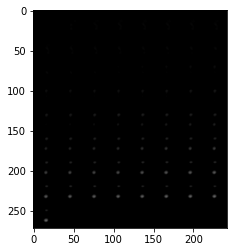

Epoch [323/400] Batch: [1/60] KL-Divergence: 0.013888845220208168 Cross-Entropy: 0.2354399561882019 Loss: 0.24932880699634552
Epoch [323/400] Batch: [2/60] KL-Divergence: 0.01307344064116478 Cross-Entropy: 0.2371070683002472 Loss: 0.25018051266670227
Epoch [323/400] Batch: [3/60] KL-Divergence: 0.013399633578956127 Cross-Entropy: 0.23869973421096802 Loss: 0.2520993649959564
Epoch [323/400] Batch: [4/60] KL-Divergence: 0.013461491093039513 Cross-Entropy: 0.23415184020996094 Loss: 0.247613325715065
Epoch [323/400] Batch: [5/60] KL-Divergence: 0.014341915026307106 Cross-Entropy: 0.24085040390491486 Loss: 0.2551923096179962
Epoch [323/400] Batch: [6/60] KL-Divergence: 0.013911589048802853 Cross-Entropy: 0.24073004722595215 Loss: 0.2546416223049164
Epoch [323/400] Batch: [7/60] KL-Divergence: 0.012799912132322788 Cross-Entropy: 0.2363954782485962 Loss: 0.249195396900177
Epoch [323/400] Batch: [8/60] KL-Divergence: 0.013837875798344612 Cross-Entropy: 0.2330167293548584 Loss: 0.24685460329055

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [323/400] Batch: [60/60] KL-Divergence: 0.016682321205735207 Cross-Entropy: 0.24552035331726074 Loss: 0.2622026801109314
Epoch [323/400] Batch: [60/60] KL-Divergence: 0.016682321205735207 Cross-Entropy: 0.24552035331726074 Loss: 0.2622026801109314


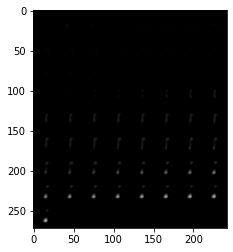

Epoch [324/400] Batch: [1/60] KL-Divergence: 0.014495505020022392 Cross-Entropy: 0.23389428853988647 Loss: 0.24838979542255402
Epoch [324/400] Batch: [2/60] KL-Divergence: 0.014668864198029041 Cross-Entropy: 0.2360345870256424 Loss: 0.25070345401763916
Epoch [324/400] Batch: [3/60] KL-Divergence: 0.014616631902754307 Cross-Entropy: 0.23671865463256836 Loss: 0.2513352930545807
Epoch [324/400] Batch: [4/60] KL-Divergence: 0.01472089346498251 Cross-Entropy: 0.23242425918579102 Loss: 0.2471451461315155
Epoch [324/400] Batch: [5/60] KL-Divergence: 0.014709015376865864 Cross-Entropy: 0.2396455556154251 Loss: 0.2543545663356781
Epoch [324/400] Batch: [6/60] KL-Divergence: 0.014967333525419235 Cross-Entropy: 0.23780380189418793 Loss: 0.25277113914489746
Epoch [324/400] Batch: [7/60] KL-Divergence: 0.013662002980709076 Cross-Entropy: 0.2349080890417099 Loss: 0.24857008457183838
Epoch [324/400] Batch: [8/60] KL-Divergence: 0.015011662617325783 Cross-Entropy: 0.2314170002937317 Loss: 0.2464286684

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [324/400] Batch: [60/60] KL-Divergence: 0.0350937694311142 Cross-Entropy: 0.2461012899875641 Loss: 0.2811950445175171
Epoch [324/400] Batch: [60/60] KL-Divergence: 0.0350937694311142 Cross-Entropy: 0.2461012899875641 Loss: 0.2811950445175171


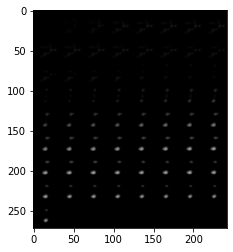

Epoch [325/400] Batch: [1/60] KL-Divergence: 0.03286115080118179 Cross-Entropy: 0.23467732965946198 Loss: 0.26753848791122437
Epoch [325/400] Batch: [2/60] KL-Divergence: 0.028891943395137787 Cross-Entropy: 0.23690420389175415 Loss: 0.26579615473747253
Epoch [325/400] Batch: [3/60] KL-Divergence: 0.02730110101401806 Cross-Entropy: 0.23913131654262543 Loss: 0.26643240451812744
Epoch [325/400] Batch: [4/60] KL-Divergence: 0.02682630345225334 Cross-Entropy: 0.2354467809200287 Loss: 0.26227307319641113
Epoch [325/400] Batch: [5/60] KL-Divergence: 0.026703929528594017 Cross-Entropy: 0.24283002316951752 Loss: 0.2695339620113373
Epoch [325/400] Batch: [6/60] KL-Divergence: 0.026122702285647392 Cross-Entropy: 0.2453916072845459 Loss: 0.27151429653167725
Epoch [325/400] Batch: [7/60] KL-Divergence: 0.024798911064863205 Cross-Entropy: 0.2383623570203781 Loss: 0.2631612718105316
Epoch [325/400] Batch: [8/60] KL-Divergence: 0.024923238903284073 Cross-Entropy: 0.23343755304813385 Loss: 0.2583608031

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [325/400] Batch: [60/60] KL-Divergence: 0.015531541779637337 Cross-Entropy: 0.24514304101467133 Loss: 0.2606745958328247
Epoch [325/400] Batch: [60/60] KL-Divergence: 0.015531541779637337 Cross-Entropy: 0.24514304101467133 Loss: 0.2606745958328247


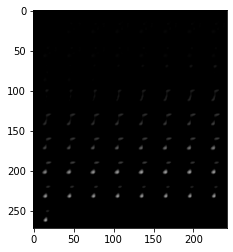

Epoch [326/400] Batch: [1/60] KL-Divergence: 0.01585470139980316 Cross-Entropy: 0.2328997105360031 Loss: 0.24875441193580627
Epoch [326/400] Batch: [2/60] KL-Divergence: 0.015510021708905697 Cross-Entropy: 0.2350245863199234 Loss: 0.2505345940589905
Epoch [326/400] Batch: [3/60] KL-Divergence: 0.01633184216916561 Cross-Entropy: 0.23615317046642303 Loss: 0.2524850070476532
Epoch [326/400] Batch: [4/60] KL-Divergence: 0.016557183116674423 Cross-Entropy: 0.2315988391637802 Loss: 0.24815602600574493
Epoch [326/400] Batch: [5/60] KL-Divergence: 0.01636672578752041 Cross-Entropy: 0.23852494359016418 Loss: 0.25489166378974915
Epoch [326/400] Batch: [6/60] KL-Divergence: 0.015921320766210556 Cross-Entropy: 0.23784610629081726 Loss: 0.2537674307823181
Epoch [326/400] Batch: [7/60] KL-Divergence: 0.015234147198498249 Cross-Entropy: 0.23407885432243347 Loss: 0.24931299686431885
Epoch [326/400] Batch: [8/60] KL-Divergence: 0.015590406954288483 Cross-Entropy: 0.22981567680835724 Loss: 0.24540609121

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [326/400] Batch: [60/60] KL-Divergence: 0.016754714772105217 Cross-Entropy: 0.24146388471126556 Loss: 0.25821858644485474
Epoch [326/400] Batch: [60/60] KL-Divergence: 0.016754714772105217 Cross-Entropy: 0.24146388471126556 Loss: 0.25821858644485474


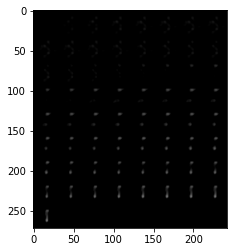

Epoch [327/400] Batch: [1/60] KL-Divergence: 0.016089217737317085 Cross-Entropy: 0.23049111664295197 Loss: 0.2465803325176239
Epoch [327/400] Batch: [2/60] KL-Divergence: 0.016852468252182007 Cross-Entropy: 0.2321399748325348 Loss: 0.2489924430847168
Epoch [327/400] Batch: [3/60] KL-Divergence: 0.01625424437224865 Cross-Entropy: 0.2338215559720993 Loss: 0.2500757873058319
Epoch [327/400] Batch: [4/60] KL-Divergence: 0.016566207632422447 Cross-Entropy: 0.2287159562110901 Loss: 0.2452821582555771
Epoch [327/400] Batch: [5/60] KL-Divergence: 0.01705106720328331 Cross-Entropy: 0.23497658967971802 Loss: 0.2520276606082916
Epoch [327/400] Batch: [6/60] KL-Divergence: 0.01711813360452652 Cross-Entropy: 0.235131174325943 Loss: 0.2522493004798889
Epoch [327/400] Batch: [7/60] KL-Divergence: 0.01630667969584465 Cross-Entropy: 0.23182909190654755 Loss: 0.2481357753276825
Epoch [327/400] Batch: [8/60] KL-Divergence: 0.016210777685046196 Cross-Entropy: 0.22683094441890717 Loss: 0.2430417239665985
E

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [327/400] Batch: [60/60] KL-Divergence: 0.018251290544867516 Cross-Entropy: 0.2381504625082016 Loss: 0.25640174746513367
Epoch [327/400] Batch: [60/60] KL-Divergence: 0.018251290544867516 Cross-Entropy: 0.2381504625082016 Loss: 0.25640174746513367


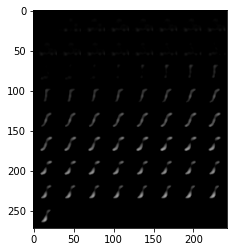

Epoch [328/400] Batch: [1/60] KL-Divergence: 0.017624571919441223 Cross-Entropy: 0.2280435711145401 Loss: 0.24566814303398132
Epoch [328/400] Batch: [2/60] KL-Divergence: 0.017416879534721375 Cross-Entropy: 0.22984525561332703 Loss: 0.2472621351480484
Epoch [328/400] Batch: [3/60] KL-Divergence: 0.017449084669351578 Cross-Entropy: 0.23095358908176422 Loss: 0.2484026700258255
Epoch [328/400] Batch: [4/60] KL-Divergence: 0.017849160358309746 Cross-Entropy: 0.22631004452705383 Loss: 0.24415920674800873
Epoch [328/400] Batch: [5/60] KL-Divergence: 0.018145130947232246 Cross-Entropy: 0.2325133979320526 Loss: 0.2506585419178009
Epoch [328/400] Batch: [6/60] KL-Divergence: 0.01774030551314354 Cross-Entropy: 0.23214125633239746 Loss: 0.2498815655708313
Epoch [328/400] Batch: [7/60] KL-Divergence: 0.016678888350725174 Cross-Entropy: 0.22885969281196594 Loss: 0.24553857743740082
Epoch [328/400] Batch: [8/60] KL-Divergence: 0.017862655222415924 Cross-Entropy: 0.22417835891246796 Loss: 0.242041021

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [328/400] Batch: [60/60] KL-Divergence: 0.019032808020710945 Cross-Entropy: 0.23394861817359924 Loss: 0.25298142433166504
Epoch [328/400] Batch: [60/60] KL-Divergence: 0.019032808020710945 Cross-Entropy: 0.23394861817359924 Loss: 0.25298142433166504


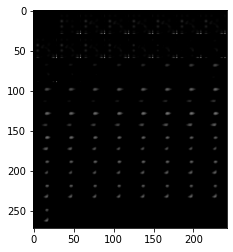

Epoch [329/400] Batch: [1/60] KL-Divergence: 0.0197641309350729 Cross-Entropy: 0.2245284765958786 Loss: 0.24429260194301605
Epoch [329/400] Batch: [2/60] KL-Divergence: 0.01871667429804802 Cross-Entropy: 0.2260868400335312 Loss: 0.2448035180568695
Epoch [329/400] Batch: [3/60] KL-Divergence: 0.019677389413118362 Cross-Entropy: 0.22721543908119202 Loss: 0.24689282476902008
Epoch [329/400] Batch: [4/60] KL-Divergence: 0.0195161085575819 Cross-Entropy: 0.22472096979618073 Loss: 0.24423708021640778
Epoch [329/400] Batch: [5/60] KL-Divergence: 0.020975999534130096 Cross-Entropy: 0.2300666719675064 Loss: 0.2510426640510559
Epoch [329/400] Batch: [6/60] KL-Divergence: 0.019658776000142097 Cross-Entropy: 0.23001515865325928 Loss: 0.24967393279075623
Epoch [329/400] Batch: [7/60] KL-Divergence: 0.019490810111165047 Cross-Entropy: 0.22695136070251465 Loss: 0.24644216895103455
Epoch [329/400] Batch: [8/60] KL-Divergence: 0.020229782909154892 Cross-Entropy: 0.22404587268829346 Loss: 0.244275659322

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [329/400] Batch: [60/60] KL-Divergence: 0.020655926316976547 Cross-Entropy: 0.23256894946098328 Loss: 0.2532248795032501
Epoch [329/400] Batch: [60/60] KL-Divergence: 0.020655926316976547 Cross-Entropy: 0.23256894946098328 Loss: 0.2532248795032501


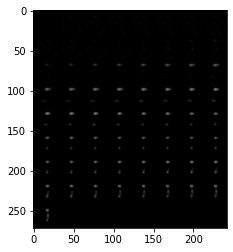

Epoch [330/400] Batch: [1/60] KL-Divergence: 0.020005805417895317 Cross-Entropy: 0.2230483442544937 Loss: 0.24305415153503418
Epoch [330/400] Batch: [2/60] KL-Divergence: 0.019746260717511177 Cross-Entropy: 0.22509922087192535 Loss: 0.24484547972679138
Epoch [330/400] Batch: [3/60] KL-Divergence: 0.020419050008058548 Cross-Entropy: 0.22595728933811188 Loss: 0.24637633562088013
Epoch [330/400] Batch: [4/60] KL-Divergence: 0.019895358011126518 Cross-Entropy: 0.22178594768047333 Loss: 0.241681307554245
Epoch [330/400] Batch: [5/60] KL-Divergence: 0.02012505754828453 Cross-Entropy: 0.22739486396312714 Loss: 0.24751992523670197
Epoch [330/400] Batch: [6/60] KL-Divergence: 0.020065873861312866 Cross-Entropy: 0.22741848230361938 Loss: 0.24748435616493225
Epoch [330/400] Batch: [7/60] KL-Divergence: 0.019608164206147194 Cross-Entropy: 0.22519446909427643 Loss: 0.24480263888835907
Epoch [330/400] Batch: [8/60] KL-Divergence: 0.019694890826940536 Cross-Entropy: 0.2213566154241562 Loss: 0.2410515

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [330/400] Batch: [60/60] KL-Divergence: 0.02349701151251793 Cross-Entropy: 0.22482189536094666 Loss: 0.24831891059875488
Epoch [330/400] Batch: [60/60] KL-Divergence: 0.02349701151251793 Cross-Entropy: 0.22482189536094666 Loss: 0.24831891059875488


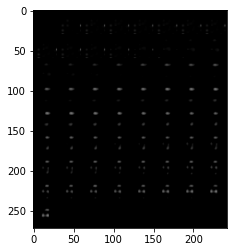

Epoch [331/400] Batch: [1/60] KL-Divergence: 0.02381914295256138 Cross-Entropy: 0.21683846414089203 Loss: 0.24065761268138885
Epoch [331/400] Batch: [2/60] KL-Divergence: 0.022637799382209778 Cross-Entropy: 0.2200476974248886 Loss: 0.2426854968070984
Epoch [331/400] Batch: [3/60] KL-Divergence: 0.02356535568833351 Cross-Entropy: 0.2199399173259735 Loss: 0.24350526928901672
Epoch [331/400] Batch: [4/60] KL-Divergence: 0.023767467588186264 Cross-Entropy: 0.2167239636182785 Loss: 0.24049143493175507
Epoch [331/400] Batch: [5/60] KL-Divergence: 0.023506175726652145 Cross-Entropy: 0.22078415751457214 Loss: 0.2442903369665146
Epoch [331/400] Batch: [6/60] KL-Divergence: 0.02393757924437523 Cross-Entropy: 0.2226191908121109 Loss: 0.24655677378177643
Epoch [331/400] Batch: [7/60] KL-Divergence: 0.022798236459493637 Cross-Entropy: 0.21956460177898407 Loss: 0.242362841963768
Epoch [331/400] Batch: [8/60] KL-Divergence: 0.02347741089761257 Cross-Entropy: 0.2168528437614441 Loss: 0.240330249071121

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [331/400] Batch: [60/60] KL-Divergence: 0.025741664692759514 Cross-Entropy: 0.22402939200401306 Loss: 0.24977105855941772
Epoch [331/400] Batch: [60/60] KL-Divergence: 0.025741664692759514 Cross-Entropy: 0.22402939200401306 Loss: 0.24977105855941772


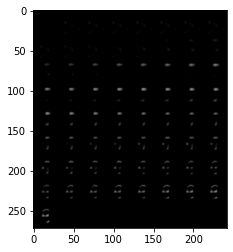

Epoch [332/400] Batch: [1/60] KL-Divergence: 0.024653812870383263 Cross-Entropy: 0.2157789170742035 Loss: 0.2404327243566513
Epoch [332/400] Batch: [2/60] KL-Divergence: 0.02368970401585102 Cross-Entropy: 0.2165268510580063 Loss: 0.24021655321121216
Epoch [332/400] Batch: [3/60] KL-Divergence: 0.024342138320207596 Cross-Entropy: 0.21711952984333038 Loss: 0.24146166443824768
Epoch [332/400] Batch: [4/60] KL-Divergence: 0.024752942845225334 Cross-Entropy: 0.21491122245788574 Loss: 0.23966416716575623
Epoch [332/400] Batch: [5/60] KL-Divergence: 0.023541908711194992 Cross-Entropy: 0.22147588431835175 Loss: 0.24501779675483704
Epoch [332/400] Batch: [6/60] KL-Divergence: 0.023516735062003136 Cross-Entropy: 0.22485235333442688 Loss: 0.24836908280849457
Epoch [332/400] Batch: [7/60] KL-Divergence: 0.022958822548389435 Cross-Entropy: 0.221706360578537 Loss: 0.24466517567634583
Epoch [332/400] Batch: [8/60] KL-Divergence: 0.02321174181997776 Cross-Entropy: 0.22003322839736938 Loss: 0.243244975

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [332/400] Batch: [60/60] KL-Divergence: 0.01513784471899271 Cross-Entropy: 0.24841070175170898 Loss: 0.2635485529899597
Epoch [332/400] Batch: [60/60] KL-Divergence: 0.01513784471899271 Cross-Entropy: 0.24841070175170898 Loss: 0.2635485529899597


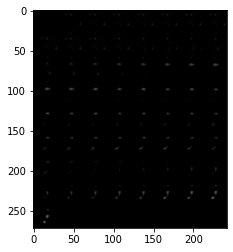

Epoch [333/400] Batch: [1/60] KL-Divergence: 0.014629780314862728 Cross-Entropy: 0.23932704329490662 Loss: 0.2539568245410919
Epoch [333/400] Batch: [2/60] KL-Divergence: 0.014964067377150059 Cross-Entropy: 0.23827816545963287 Loss: 0.25324222445487976
Epoch [333/400] Batch: [3/60] KL-Divergence: 0.014696435071527958 Cross-Entropy: 0.2400618940591812 Loss: 0.2547583281993866
Epoch [333/400] Batch: [4/60] KL-Divergence: 0.014919992536306381 Cross-Entropy: 0.23496977984905243 Loss: 0.2498897761106491
Epoch [333/400] Batch: [5/60] KL-Divergence: 0.016305752098560333 Cross-Entropy: 0.24390995502471924 Loss: 0.260215699672699
Epoch [333/400] Batch: [6/60] KL-Divergence: 0.015325750224292278 Cross-Entropy: 0.24233214557170868 Loss: 0.25765788555145264
Epoch [333/400] Batch: [7/60] KL-Divergence: 0.014573444612324238 Cross-Entropy: 0.23607054352760315 Loss: 0.2506439983844757
Epoch [333/400] Batch: [8/60] KL-Divergence: 0.014872856438159943 Cross-Entropy: 0.23285606503486633 Loss: 0.247728914

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [333/400] Batch: [60/60] KL-Divergence: 0.020105833187699318 Cross-Entropy: 0.2342301458120346 Loss: 0.2543359696865082
Epoch [333/400] Batch: [60/60] KL-Divergence: 0.020105833187699318 Cross-Entropy: 0.2342301458120346 Loss: 0.2543359696865082


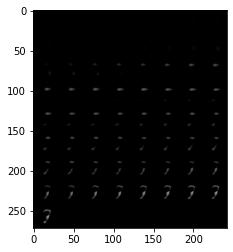

Epoch [334/400] Batch: [1/60] KL-Divergence: 0.01906437985599041 Cross-Entropy: 0.22569020092487335 Loss: 0.2447545826435089
Epoch [334/400] Batch: [2/60] KL-Divergence: 0.020139055326581 Cross-Entropy: 0.22647523880004883 Loss: 0.24661429226398468
Epoch [334/400] Batch: [3/60] KL-Divergence: 0.02016448974609375 Cross-Entropy: 0.22672973573207855 Loss: 0.2468942254781723
Epoch [334/400] Batch: [4/60] KL-Divergence: 0.01905715838074684 Cross-Entropy: 0.22266477346420288 Loss: 0.24172192811965942
Epoch [334/400] Batch: [5/60] KL-Divergence: 0.021016445010900497 Cross-Entropy: 0.22806552052497864 Loss: 0.24908196926116943
Epoch [334/400] Batch: [6/60] KL-Divergence: 0.02053580991923809 Cross-Entropy: 0.22880244255065918 Loss: 0.24933825433254242
Epoch [334/400] Batch: [7/60] KL-Divergence: 0.01999342441558838 Cross-Entropy: 0.22235876321792603 Loss: 0.2423521876335144
Epoch [334/400] Batch: [8/60] KL-Divergence: 0.01931353658437729 Cross-Entropy: 0.22245973348617554 Loss: 0.24177327752113

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [334/400] Batch: [60/60] KL-Divergence: 0.024005131796002388 Cross-Entropy: 0.22456447780132294 Loss: 0.24856960773468018
Epoch [334/400] Batch: [60/60] KL-Divergence: 0.024005131796002388 Cross-Entropy: 0.22456447780132294 Loss: 0.24856960773468018


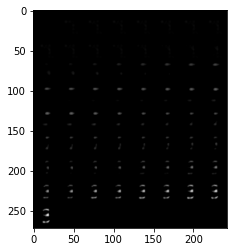

Epoch [335/400] Batch: [1/60] KL-Divergence: 0.02326487936079502 Cross-Entropy: 0.21707460284233093 Loss: 0.2403394877910614
Epoch [335/400] Batch: [2/60] KL-Divergence: 0.023821894079446793 Cross-Entropy: 0.21758337318897247 Loss: 0.24140526354312897
Epoch [335/400] Batch: [3/60] KL-Divergence: 0.024512438103556633 Cross-Entropy: 0.21746239066123962 Loss: 0.2419748306274414
Epoch [335/400] Batch: [4/60] KL-Divergence: 0.02370826154947281 Cross-Entropy: 0.21495802700519562 Loss: 0.23866629600524902
Epoch [335/400] Batch: [5/60] KL-Divergence: 0.0244744922965765 Cross-Entropy: 0.2193356454372406 Loss: 0.24381013214588165
Epoch [335/400] Batch: [6/60] KL-Divergence: 0.024354076012969017 Cross-Entropy: 0.22121752798557281 Loss: 0.24557159841060638
Epoch [335/400] Batch: [7/60] KL-Divergence: 0.023591574281454086 Cross-Entropy: 0.21723930537700653 Loss: 0.24083088338375092
Epoch [335/400] Batch: [8/60] KL-Divergence: 0.0235348679125309 Cross-Entropy: 0.21489711105823517 Loss: 0.23843197524

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [335/400] Batch: [60/60] KL-Divergence: 0.02594267949461937 Cross-Entropy: 0.2205970138311386 Loss: 0.24653969705104828
Epoch [335/400] Batch: [60/60] KL-Divergence: 0.02594267949461937 Cross-Entropy: 0.2205970138311386 Loss: 0.24653969705104828


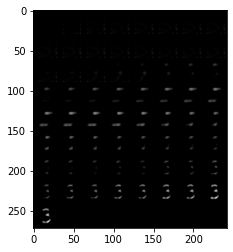

Epoch [336/400] Batch: [1/60] KL-Divergence: 0.025378447026014328 Cross-Entropy: 0.21198990941047668 Loss: 0.2373683601617813
Epoch [336/400] Batch: [2/60] KL-Divergence: 0.026267865672707558 Cross-Entropy: 0.21710418164730072 Loss: 0.24337205290794373
Epoch [336/400] Batch: [3/60] KL-Divergence: 0.026616059243679047 Cross-Entropy: 0.217180997133255 Loss: 0.24379706382751465
Epoch [336/400] Batch: [4/60] KL-Divergence: 0.026301126927137375 Cross-Entropy: 0.2153892070055008 Loss: 0.24169033765792847
Epoch [336/400] Batch: [5/60] KL-Divergence: 0.028559081256389618 Cross-Entropy: 0.21819129586219788 Loss: 0.2467503845691681
Epoch [336/400] Batch: [6/60] KL-Divergence: 0.02609676867723465 Cross-Entropy: 0.22009362280368805 Loss: 0.2461903989315033
Epoch [336/400] Batch: [7/60] KL-Divergence: 0.026503201574087143 Cross-Entropy: 0.2145388126373291 Loss: 0.24104201793670654
Epoch [336/400] Batch: [8/60] KL-Divergence: 0.025218993425369263 Cross-Entropy: 0.2145707607269287 Loss: 0.23978975415

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [336/400] Batch: [60/60] KL-Divergence: 0.02783249132335186 Cross-Entropy: 0.21649169921875 Loss: 0.244324192404747
Epoch [336/400] Batch: [60/60] KL-Divergence: 0.02783249132335186 Cross-Entropy: 0.21649169921875 Loss: 0.244324192404747


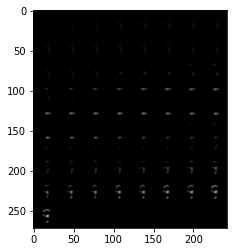

Epoch [337/400] Batch: [1/60] KL-Divergence: 0.027217626571655273 Cross-Entropy: 0.20817536115646362 Loss: 0.2353929877281189
Epoch [337/400] Batch: [2/60] KL-Divergence: 0.0266319140791893 Cross-Entropy: 0.2120017409324646 Loss: 0.2386336624622345
Epoch [337/400] Batch: [3/60] KL-Divergence: 0.027192143723368645 Cross-Entropy: 0.2112715095281601 Loss: 0.2384636551141739
Epoch [337/400] Batch: [4/60] KL-Divergence: 0.027044199407100677 Cross-Entropy: 0.2082117646932602 Loss: 0.23525595664978027
Epoch [337/400] Batch: [5/60] KL-Divergence: 0.02789396420121193 Cross-Entropy: 0.21231479942798615 Loss: 0.24020875990390778
Epoch [337/400] Batch: [6/60] KL-Divergence: 0.026765605434775352 Cross-Entropy: 0.2145921140909195 Loss: 0.2413577139377594
Epoch [337/400] Batch: [7/60] KL-Divergence: 0.02610170841217041 Cross-Entropy: 0.20983752608299255 Loss: 0.23593923449516296
Epoch [337/400] Batch: [8/60] KL-Divergence: 0.02593456394970417 Cross-Entropy: 0.20948870480060577 Loss: 0.235423266887664

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [337/400] Batch: [60/60] KL-Divergence: 0.03056717850267887 Cross-Entropy: 0.22482125461101532 Loss: 0.25538843870162964
Epoch [337/400] Batch: [60/60] KL-Divergence: 0.03056717850267887 Cross-Entropy: 0.22482125461101532 Loss: 0.25538843870162964


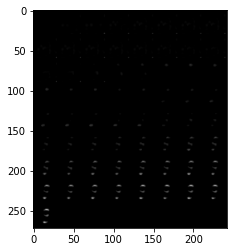

Epoch [338/400] Batch: [1/60] KL-Divergence: 0.028612250462174416 Cross-Entropy: 0.21647313237190247 Loss: 0.24508538842201233
Epoch [338/400] Batch: [2/60] KL-Divergence: 0.02858266979455948 Cross-Entropy: 0.21716110408306122 Loss: 0.2457437813282013
Epoch [338/400] Batch: [3/60] KL-Divergence: 0.0279228612780571 Cross-Entropy: 0.2185068428516388 Loss: 0.2464297115802765
Epoch [338/400] Batch: [4/60] KL-Divergence: 0.02752227522432804 Cross-Entropy: 0.21581915020942688 Loss: 0.24334143102169037
Epoch [338/400] Batch: [5/60] KL-Divergence: 0.028838573023676872 Cross-Entropy: 0.2225426286458969 Loss: 0.25138118863105774
Epoch [338/400] Batch: [6/60] KL-Divergence: 0.027411719784140587 Cross-Entropy: 0.21883441507816315 Loss: 0.2462461292743683
Epoch [338/400] Batch: [7/60] KL-Divergence: 0.027166200801730156 Cross-Entropy: 0.21427221596240997 Loss: 0.24143841862678528
Epoch [338/400] Batch: [8/60] KL-Divergence: 0.025895273312926292 Cross-Entropy: 0.2153390347957611 Loss: 0.241234302520

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [338/400] Batch: [60/60] KL-Divergence: 0.027858680114150047 Cross-Entropy: 0.2130081206560135 Loss: 0.2408667951822281
Epoch [338/400] Batch: [60/60] KL-Divergence: 0.027858680114150047 Cross-Entropy: 0.2130081206560135 Loss: 0.2408667951822281


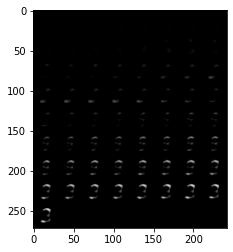

Epoch [339/400] Batch: [1/60] KL-Divergence: 0.028474662452936172 Cross-Entropy: 0.20560601353645325 Loss: 0.23408067226409912
Epoch [339/400] Batch: [2/60] KL-Divergence: 0.02814861200749874 Cross-Entropy: 0.2082725167274475 Loss: 0.2364211231470108
Epoch [339/400] Batch: [3/60] KL-Divergence: 0.027961600571870804 Cross-Entropy: 0.20708803832530975 Loss: 0.23504963517189026
Epoch [339/400] Batch: [4/60] KL-Divergence: 0.02722955495119095 Cross-Entropy: 0.20370613038539886 Loss: 0.2309356927871704
Epoch [339/400] Batch: [5/60] KL-Divergence: 0.030255625024437904 Cross-Entropy: 0.21016807854175568 Loss: 0.24042370915412903
Epoch [339/400] Batch: [6/60] KL-Divergence: 0.029063334688544273 Cross-Entropy: 0.21020862460136414 Loss: 0.23927195370197296
Epoch [339/400] Batch: [7/60] KL-Divergence: 0.027111342176795006 Cross-Entropy: 0.20541079342365265 Loss: 0.2325221300125122
Epoch [339/400] Batch: [8/60] KL-Divergence: 0.02729264833033085 Cross-Entropy: 0.2051875740289688 Loss: 0.2324802279

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [339/400] Batch: [60/60] KL-Divergence: 0.02893643081188202 Cross-Entropy: 0.2080913931131363 Loss: 0.2370278239250183
Epoch [339/400] Batch: [60/60] KL-Divergence: 0.02893643081188202 Cross-Entropy: 0.2080913931131363 Loss: 0.2370278239250183


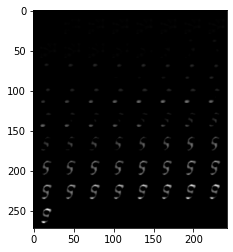

Epoch [340/400] Batch: [1/60] KL-Divergence: 0.030603021383285522 Cross-Entropy: 0.20298099517822266 Loss: 0.23358401656150818
Epoch [340/400] Batch: [2/60] KL-Divergence: 0.029425034299492836 Cross-Entropy: 0.2046053260564804 Loss: 0.2340303659439087
Epoch [340/400] Batch: [3/60] KL-Divergence: 0.02942718006670475 Cross-Entropy: 0.20441971719264984 Loss: 0.23384690284729004
Epoch [340/400] Batch: [4/60] KL-Divergence: 0.029560057446360588 Cross-Entropy: 0.20224632322788239 Loss: 0.23180638253688812
Epoch [340/400] Batch: [5/60] KL-Divergence: 0.03054722398519516 Cross-Entropy: 0.20643015205860138 Loss: 0.23697736859321594
Epoch [340/400] Batch: [6/60] KL-Divergence: 0.029288621619343758 Cross-Entropy: 0.20654693245887756 Loss: 0.23583555221557617
Epoch [340/400] Batch: [7/60] KL-Divergence: 0.02958480454981327 Cross-Entropy: 0.20303720235824585 Loss: 0.23262201249599457
Epoch [340/400] Batch: [8/60] KL-Divergence: 0.028627987951040268 Cross-Entropy: 0.2028370201587677 Loss: 0.23146501

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [340/400] Batch: [60/60] KL-Divergence: 0.029883557930588722 Cross-Entropy: 0.2078821063041687 Loss: 0.23776566982269287
Epoch [340/400] Batch: [60/60] KL-Divergence: 0.029883557930588722 Cross-Entropy: 0.2078821063041687 Loss: 0.23776566982269287


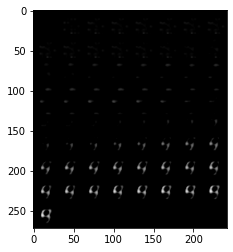

Epoch [341/400] Batch: [1/60] KL-Divergence: 0.03055289201438427 Cross-Entropy: 0.2003951370716095 Loss: 0.23094803094863892
Epoch [341/400] Batch: [2/60] KL-Divergence: 0.029111409559845924 Cross-Entropy: 0.20467744767665863 Loss: 0.23378886282444
Epoch [341/400] Batch: [3/60] KL-Divergence: 0.03095824643969536 Cross-Entropy: 0.20432497560977936 Loss: 0.23528322577476501
Epoch [341/400] Batch: [4/60] KL-Divergence: 0.030006706714630127 Cross-Entropy: 0.20131447911262512 Loss: 0.23132118582725525
Epoch [341/400] Batch: [5/60] KL-Divergence: 0.03187252953648567 Cross-Entropy: 0.2052455097436905 Loss: 0.23711803555488586
Epoch [341/400] Batch: [6/60] KL-Divergence: 0.02949385717511177 Cross-Entropy: 0.20511698722839355 Loss: 0.23461084067821503
Epoch [341/400] Batch: [7/60] KL-Divergence: 0.029415829107165337 Cross-Entropy: 0.20118474960327148 Loss: 0.23060058057308197
Epoch [341/400] Batch: [8/60] KL-Divergence: 0.028925897553563118 Cross-Entropy: 0.20196455717086792 Loss: 0.23089045286

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [341/400] Batch: [60/60] KL-Divergence: 0.029413793236017227 Cross-Entropy: 0.21033674478530884 Loss: 0.23975053429603577
Epoch [341/400] Batch: [60/60] KL-Divergence: 0.029413793236017227 Cross-Entropy: 0.21033674478530884 Loss: 0.23975053429603577


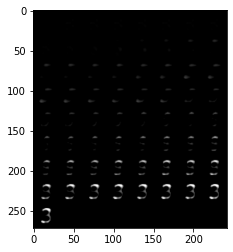

Epoch [342/400] Batch: [1/60] KL-Divergence: 0.029045311734080315 Cross-Entropy: 0.20168842375278473 Loss: 0.2307337373495102
Epoch [342/400] Batch: [2/60] KL-Divergence: 0.02931417152285576 Cross-Entropy: 0.20500679314136505 Loss: 0.2343209683895111
Epoch [342/400] Batch: [3/60] KL-Divergence: 0.029052909463644028 Cross-Entropy: 0.20468300580978394 Loss: 0.23373591899871826
Epoch [342/400] Batch: [4/60] KL-Divergence: 0.02881176397204399 Cross-Entropy: 0.2035168558359146 Loss: 0.2323286235332489
Epoch [342/400] Batch: [5/60] KL-Divergence: 0.03045990690588951 Cross-Entropy: 0.20683254301548004 Loss: 0.23729245364665985
Epoch [342/400] Batch: [6/60] KL-Divergence: 0.029674239456653595 Cross-Entropy: 0.2076776921749115 Loss: 0.2373519241809845
Epoch [342/400] Batch: [7/60] KL-Divergence: 0.027975760400295258 Cross-Entropy: 0.2048654407262802 Loss: 0.23284119367599487
Epoch [342/400] Batch: [8/60] KL-Divergence: 0.028241129592061043 Cross-Entropy: 0.20283232629299164 Loss: 0.231073454022

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [342/400] Batch: [60/60] KL-Divergence: 0.031031399965286255 Cross-Entropy: 0.20696164667606354 Loss: 0.2379930466413498
Epoch [342/400] Batch: [60/60] KL-Divergence: 0.031031399965286255 Cross-Entropy: 0.20696164667606354 Loss: 0.2379930466413498


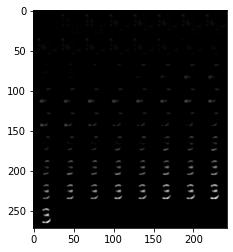

Epoch [343/400] Batch: [1/60] KL-Divergence: 0.03103647381067276 Cross-Entropy: 0.19977261126041412 Loss: 0.23080909252166748
Epoch [343/400] Batch: [2/60] KL-Divergence: 0.0309477336704731 Cross-Entropy: 0.20305798947811127 Loss: 0.23400571942329407
Epoch [343/400] Batch: [3/60] KL-Divergence: 0.030014384537935257 Cross-Entropy: 0.2033165842294693 Loss: 0.23333096504211426
Epoch [343/400] Batch: [4/60] KL-Divergence: 0.03024202026426792 Cross-Entropy: 0.20000258088111877 Loss: 0.23024460673332214
Epoch [343/400] Batch: [5/60] KL-Divergence: 0.031322214752435684 Cross-Entropy: 0.20429834723472595 Loss: 0.23562055826187134
Epoch [343/400] Batch: [6/60] KL-Divergence: 0.03110450692474842 Cross-Entropy: 0.20463445782661438 Loss: 0.23573896288871765
Epoch [343/400] Batch: [7/60] KL-Divergence: 0.03049132227897644 Cross-Entropy: 0.20118431746959686 Loss: 0.2316756397485733
Epoch [343/400] Batch: [8/60] KL-Divergence: 0.029474152252078056 Cross-Entropy: 0.20165807008743286 Loss: 0.2311322242

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [343/400] Batch: [60/60] KL-Divergence: 0.03238505870103836 Cross-Entropy: 0.20608460903167725 Loss: 0.238469660282135
Epoch [343/400] Batch: [60/60] KL-Divergence: 0.03238505870103836 Cross-Entropy: 0.20608460903167725 Loss: 0.238469660282135


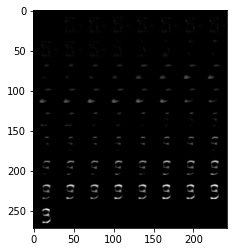

Epoch [344/400] Batch: [1/60] KL-Divergence: 0.03258831799030304 Cross-Entropy: 0.19926507771015167 Loss: 0.2318533957004547
Epoch [344/400] Batch: [2/60] KL-Divergence: 0.030323827639222145 Cross-Entropy: 0.20292669534683228 Loss: 0.23325052857398987
Epoch [344/400] Batch: [3/60] KL-Divergence: 0.03216903284192085 Cross-Entropy: 0.20158670842647552 Loss: 0.23375573754310608
Epoch [344/400] Batch: [4/60] KL-Divergence: 0.03167150914669037 Cross-Entropy: 0.1991453468799591 Loss: 0.23081685602664948
Epoch [344/400] Batch: [5/60] KL-Divergence: 0.033294111490249634 Cross-Entropy: 0.20451921224594116 Loss: 0.2378133237361908
Epoch [344/400] Batch: [6/60] KL-Divergence: 0.03206896409392357 Cross-Entropy: 0.2048725187778473 Loss: 0.23694148659706116
Epoch [344/400] Batch: [7/60] KL-Divergence: 0.030260592699050903 Cross-Entropy: 0.1997440904378891 Loss: 0.23000468313694
Epoch [344/400] Batch: [8/60] KL-Divergence: 0.030042659491300583 Cross-Entropy: 0.2011457234621048 Loss: 0.231188386678695

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [344/400] Batch: [60/60] KL-Divergence: 0.030972285196185112 Cross-Entropy: 0.20602820813655853 Loss: 0.2370004951953888
Epoch [344/400] Batch: [60/60] KL-Divergence: 0.030972285196185112 Cross-Entropy: 0.20602820813655853 Loss: 0.2370004951953888


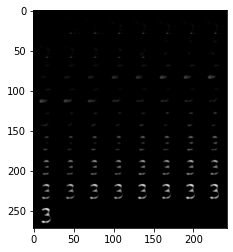

Epoch [345/400] Batch: [1/60] KL-Divergence: 0.03067445196211338 Cross-Entropy: 0.2004387229681015 Loss: 0.23111318051815033
Epoch [345/400] Batch: [2/60] KL-Divergence: 0.029840685427188873 Cross-Entropy: 0.20371578633785248 Loss: 0.23355647921562195
Epoch [345/400] Batch: [3/60] KL-Divergence: 0.03050651215016842 Cross-Entropy: 0.20225341618061066 Loss: 0.23275992274284363
Epoch [345/400] Batch: [4/60] KL-Divergence: 0.030194830149412155 Cross-Entropy: 0.20003937184810638 Loss: 0.23023420572280884
Epoch [345/400] Batch: [5/60] KL-Divergence: 0.033052172511816025 Cross-Entropy: 0.20456793904304504 Loss: 0.23762011528015137
Epoch [345/400] Batch: [6/60] KL-Divergence: 0.03109785169363022 Cross-Entropy: 0.20387202501296997 Loss: 0.2349698841571808
Epoch [345/400] Batch: [7/60] KL-Divergence: 0.02996785007417202 Cross-Entropy: 0.1998310536146164 Loss: 0.22979889810085297
Epoch [345/400] Batch: [8/60] KL-Divergence: 0.030065612867474556 Cross-Entropy: 0.20116835832595825 Loss: 0.231233969

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [345/400] Batch: [60/60] KL-Divergence: 0.03410131484270096 Cross-Entropy: 0.2157781571149826 Loss: 0.24987947940826416
Epoch [345/400] Batch: [60/60] KL-Divergence: 0.03410131484270096 Cross-Entropy: 0.2157781571149826 Loss: 0.24987947940826416


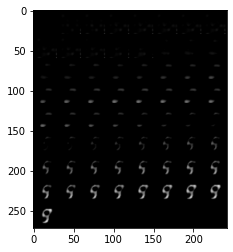

Epoch [346/400] Batch: [1/60] KL-Divergence: 0.03300996497273445 Cross-Entropy: 0.20972616970539093 Loss: 0.24273613095283508
Epoch [346/400] Batch: [2/60] KL-Divergence: 0.03247116133570671 Cross-Entropy: 0.21081508696079254 Loss: 0.24328625202178955
Epoch [346/400] Batch: [3/60] KL-Divergence: 0.03136152774095535 Cross-Entropy: 0.21176473796367645 Loss: 0.2431262731552124
Epoch [346/400] Batch: [4/60] KL-Divergence: 0.030257519334554672 Cross-Entropy: 0.21138028800487518 Loss: 0.24163781106472015
Epoch [346/400] Batch: [5/60] KL-Divergence: 0.030030645430088043 Cross-Entropy: 0.21369710564613342 Loss: 0.24372774362564087
Epoch [346/400] Batch: [6/60] KL-Divergence: 0.02958615869283676 Cross-Entropy: 0.21482257544994354 Loss: 0.2444087266921997
Epoch [346/400] Batch: [7/60] KL-Divergence: 0.028696274384856224 Cross-Entropy: 0.21053452789783478 Loss: 0.23923079669475555
Epoch [346/400] Batch: [8/60] KL-Divergence: 0.028416167944669724 Cross-Entropy: 0.21080276370048523 Loss: 0.23921893

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [346/400] Batch: [60/60] KL-Divergence: 0.03140401840209961 Cross-Entropy: 0.20798368752002716 Loss: 0.23938770592212677
Epoch [346/400] Batch: [60/60] KL-Divergence: 0.03140401840209961 Cross-Entropy: 0.20798368752002716 Loss: 0.23938770592212677


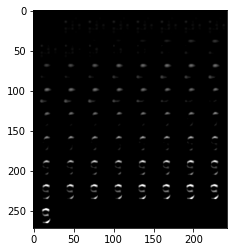

Epoch [347/400] Batch: [1/60] KL-Divergence: 0.031666651368141174 Cross-Entropy: 0.20186813175678253 Loss: 0.2335347831249237
Epoch [347/400] Batch: [2/60] KL-Divergence: 0.02945335954427719 Cross-Entropy: 0.20289704203605652 Loss: 0.2323504090309143
Epoch [347/400] Batch: [3/60] KL-Divergence: 0.02998899109661579 Cross-Entropy: 0.20389004051685333 Loss: 0.23387902975082397
Epoch [347/400] Batch: [4/60] KL-Divergence: 0.03007078543305397 Cross-Entropy: 0.20382928848266602 Loss: 0.2339000701904297
Epoch [347/400] Batch: [5/60] KL-Divergence: 0.03240486606955528 Cross-Entropy: 0.2069183588027954 Loss: 0.239323228597641
Epoch [347/400] Batch: [6/60] KL-Divergence: 0.030798381194472313 Cross-Entropy: 0.20675258338451385 Loss: 0.23755095899105072
Epoch [347/400] Batch: [7/60] KL-Divergence: 0.028878839686512947 Cross-Entropy: 0.20218293368816376 Loss: 0.23106177151203156
Epoch [347/400] Batch: [8/60] KL-Divergence: 0.02968171238899231 Cross-Entropy: 0.20322555303573608 Loss: 0.2329072654247

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [347/400] Batch: [60/60] KL-Divergence: 0.030429651960730553 Cross-Entropy: 0.20908565819263458 Loss: 0.2395153045654297
Epoch [347/400] Batch: [60/60] KL-Divergence: 0.030429651960730553 Cross-Entropy: 0.20908565819263458 Loss: 0.2395153045654297


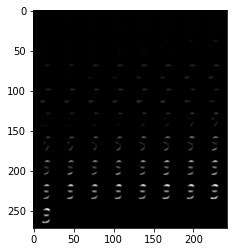

Epoch [348/400] Batch: [1/60] KL-Divergence: 0.030648035928606987 Cross-Entropy: 0.199925497174263 Loss: 0.23057353496551514
Epoch [348/400] Batch: [2/60] KL-Divergence: 0.02935447171330452 Cross-Entropy: 0.20274150371551514 Loss: 0.23209597170352936
Epoch [348/400] Batch: [3/60] KL-Divergence: 0.030792687088251114 Cross-Entropy: 0.20456978678703308 Loss: 0.2353624701499939
Epoch [348/400] Batch: [4/60] KL-Divergence: 0.02980579435825348 Cross-Entropy: 0.20059454441070557 Loss: 0.23040033876895905
Epoch [348/400] Batch: [5/60] KL-Divergence: 0.03022203966975212 Cross-Entropy: 0.205246239900589 Loss: 0.2354682832956314
Epoch [348/400] Batch: [6/60] KL-Divergence: 0.02995779737830162 Cross-Entropy: 0.20516078174114227 Loss: 0.2351185828447342
Epoch [348/400] Batch: [7/60] KL-Divergence: 0.029284164309501648 Cross-Entropy: 0.2015560418367386 Loss: 0.23084020614624023
Epoch [348/400] Batch: [8/60] KL-Divergence: 0.02887578494846821 Cross-Entropy: 0.20146790146827698 Loss: 0.230343684554100

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [348/400] Batch: [60/60] KL-Divergence: 0.031708408147096634 Cross-Entropy: 0.20534484088420868 Loss: 0.23705324530601501
Epoch [348/400] Batch: [60/60] KL-Divergence: 0.031708408147096634 Cross-Entropy: 0.20534484088420868 Loss: 0.23705324530601501


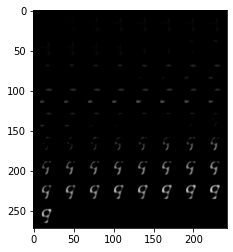

Epoch [349/400] Batch: [1/60] KL-Divergence: 0.031560808420181274 Cross-Entropy: 0.1976833939552307 Loss: 0.229244202375412
Epoch [349/400] Batch: [2/60] KL-Divergence: 0.031240316107869148 Cross-Entropy: 0.2024148851633072 Loss: 0.2336551994085312
Epoch [349/400] Batch: [3/60] KL-Divergence: 0.030019177123904228 Cross-Entropy: 0.20151276886463165 Loss: 0.23153194785118103
Epoch [349/400] Batch: [4/60] KL-Divergence: 0.03058777004480362 Cross-Entropy: 0.19859813153743744 Loss: 0.22918590903282166
Epoch [349/400] Batch: [5/60] KL-Divergence: 0.031309518963098526 Cross-Entropy: 0.20304425060749054 Loss: 0.23435376584529877
Epoch [349/400] Batch: [6/60] KL-Divergence: 0.030898738652467728 Cross-Entropy: 0.20313499867916107 Loss: 0.2340337336063385
Epoch [349/400] Batch: [7/60] KL-Divergence: 0.030138352885842323 Cross-Entropy: 0.2017432600259781 Loss: 0.23188161849975586
Epoch [349/400] Batch: [8/60] KL-Divergence: 0.03048035129904747 Cross-Entropy: 0.2012355625629425 Loss: 0.231715917587

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [349/400] Batch: [60/60] KL-Divergence: 0.03178777918219566 Cross-Entropy: 0.20483148097991943 Loss: 0.2366192638874054
Epoch [349/400] Batch: [60/60] KL-Divergence: 0.03178777918219566 Cross-Entropy: 0.20483148097991943 Loss: 0.2366192638874054


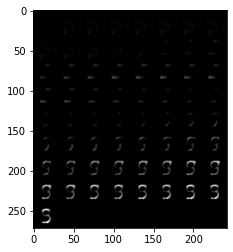

Epoch [350/400] Batch: [1/60] KL-Divergence: 0.031205594539642334 Cross-Entropy: 0.1988413780927658 Loss: 0.23004697263240814
Epoch [350/400] Batch: [2/60] KL-Divergence: 0.03174518793821335 Cross-Entropy: 0.2016952633857727 Loss: 0.23344045877456665
Epoch [350/400] Batch: [3/60] KL-Divergence: 0.03080940991640091 Cross-Entropy: 0.2032996416091919 Loss: 0.2341090440750122
Epoch [350/400] Batch: [4/60] KL-Divergence: 0.030487792566418648 Cross-Entropy: 0.2001722902059555 Loss: 0.230660080909729
Epoch [350/400] Batch: [5/60] KL-Divergence: 0.03218412399291992 Cross-Entropy: 0.20492123067378998 Loss: 0.2371053546667099
Epoch [350/400] Batch: [6/60] KL-Divergence: 0.030613793060183525 Cross-Entropy: 0.20601126551628113 Loss: 0.2366250604391098
Epoch [350/400] Batch: [7/60] KL-Divergence: 0.029241349548101425 Cross-Entropy: 0.20201808214187622 Loss: 0.23125943541526794
Epoch [350/400] Batch: [8/60] KL-Divergence: 0.02967713214457035 Cross-Entropy: 0.20087023079395294 Loss: 0.230547368526458

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [350/400] Batch: [60/60] KL-Divergence: 0.03227493539452553 Cross-Entropy: 0.20443306863307953 Loss: 0.23670800030231476
Epoch [350/400] Batch: [60/60] KL-Divergence: 0.03227493539452553 Cross-Entropy: 0.20443306863307953 Loss: 0.23670800030231476


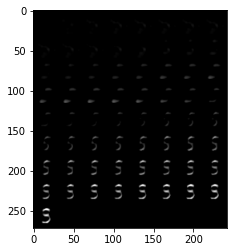

Epoch [351/400] Batch: [1/60] KL-Divergence: 0.03133467212319374 Cross-Entropy: 0.19703514873981476 Loss: 0.2283698171377182
Epoch [351/400] Batch: [2/60] KL-Divergence: 0.030694205313920975 Cross-Entropy: 0.2010076493024826 Loss: 0.23170185089111328
Epoch [351/400] Batch: [3/60] KL-Divergence: 0.03162939473986626 Cross-Entropy: 0.2001960277557373 Loss: 0.23182542622089386
Epoch [351/400] Batch: [4/60] KL-Divergence: 0.031026870012283325 Cross-Entropy: 0.19811773300170898 Loss: 0.2291446030139923
Epoch [351/400] Batch: [5/60] KL-Divergence: 0.0323605090379715 Cross-Entropy: 0.20264486968517303 Loss: 0.23500537872314453
Epoch [351/400] Batch: [6/60] KL-Divergence: 0.031006772071123123 Cross-Entropy: 0.2030109167098999 Loss: 0.23401768505573273
Epoch [351/400] Batch: [7/60] KL-Divergence: 0.031715359538793564 Cross-Entropy: 0.20006811618804932 Loss: 0.23178347945213318
Epoch [351/400] Batch: [8/60] KL-Divergence: 0.029957706108689308 Cross-Entropy: 0.1984149068593979 Loss: 0.228372618556

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [351/400] Batch: [60/60] KL-Divergence: 0.03162107989192009 Cross-Entropy: 0.20369355380535126 Loss: 0.23531463742256165
Epoch [351/400] Batch: [60/60] KL-Divergence: 0.03162107989192009 Cross-Entropy: 0.20369355380535126 Loss: 0.23531463742256165


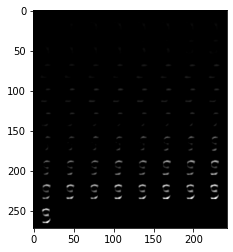

Epoch [352/400] Batch: [1/60] KL-Divergence: 0.03091168776154518 Cross-Entropy: 0.19713684916496277 Loss: 0.22804853320121765
Epoch [352/400] Batch: [2/60] KL-Divergence: 0.031286533921957016 Cross-Entropy: 0.20015104115009308 Loss: 0.2314375787973404
Epoch [352/400] Batch: [3/60] KL-Divergence: 0.03189047425985336 Cross-Entropy: 0.1995983123779297 Loss: 0.23148879408836365
Epoch [352/400] Batch: [4/60] KL-Divergence: 0.030762076377868652 Cross-Entropy: 0.19731169939041138 Loss: 0.22807377576828003
Epoch [352/400] Batch: [5/60] KL-Divergence: 0.032582513988018036 Cross-Entropy: 0.20156230032444 Loss: 0.23414480686187744
Epoch [352/400] Batch: [6/60] KL-Divergence: 0.03164055198431015 Cross-Entropy: 0.20166170597076416 Loss: 0.2333022654056549
Epoch [352/400] Batch: [7/60] KL-Divergence: 0.03106003999710083 Cross-Entropy: 0.19862951338291168 Loss: 0.2296895533800125
Epoch [352/400] Batch: [8/60] KL-Divergence: 0.03065113164484501 Cross-Entropy: 0.19827552139759064 Loss: 0.22892665863037

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [352/400] Batch: [60/60] KL-Divergence: 0.032893259078264236 Cross-Entropy: 0.20434466004371643 Loss: 0.23723791539669037
Epoch [352/400] Batch: [60/60] KL-Divergence: 0.032893259078264236 Cross-Entropy: 0.20434466004371643 Loss: 0.23723791539669037


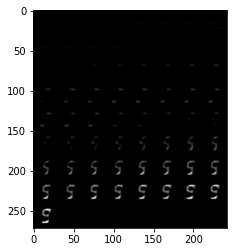

Epoch [353/400] Batch: [1/60] KL-Divergence: 0.03223041445016861 Cross-Entropy: 0.19578981399536133 Loss: 0.22802022099494934
Epoch [353/400] Batch: [2/60] KL-Divergence: 0.03178441897034645 Cross-Entropy: 0.20108070969581604 Loss: 0.2328651249408722
Epoch [353/400] Batch: [3/60] KL-Divergence: 0.03299732506275177 Cross-Entropy: 0.1994355469942093 Loss: 0.23243287205696106
Epoch [353/400] Batch: [4/60] KL-Divergence: 0.031522221863269806 Cross-Entropy: 0.19915743172168732 Loss: 0.23067966103553772
Epoch [353/400] Batch: [5/60] KL-Divergence: 0.032056860625743866 Cross-Entropy: 0.20202383399009705 Loss: 0.2340807020664215
Epoch [353/400] Batch: [6/60] KL-Divergence: 0.031615737825632095 Cross-Entropy: 0.20259816944599152 Loss: 0.2342139035463333
Epoch [353/400] Batch: [7/60] KL-Divergence: 0.03195787966251373 Cross-Entropy: 0.19988146424293518 Loss: 0.2318393439054489
Epoch [353/400] Batch: [8/60] KL-Divergence: 0.030501635745167732 Cross-Entropy: 0.19947025179862976 Loss: 0.22997188568

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [353/400] Batch: [60/60] KL-Divergence: 0.031194861978292465 Cross-Entropy: 0.20314964652061462 Loss: 0.2343445122241974
Epoch [353/400] Batch: [60/60] KL-Divergence: 0.031194861978292465 Cross-Entropy: 0.20314964652061462 Loss: 0.2343445122241974


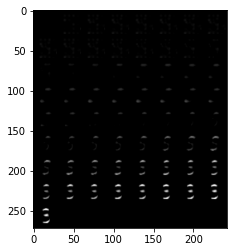

Epoch [354/400] Batch: [1/60] KL-Divergence: 0.031511928886175156 Cross-Entropy: 0.19694644212722778 Loss: 0.22845837473869324
Epoch [354/400] Batch: [2/60] KL-Divergence: 0.030609246343374252 Cross-Entropy: 0.20011502504348755 Loss: 0.2307242751121521
Epoch [354/400] Batch: [3/60] KL-Divergence: 0.032156553119421005 Cross-Entropy: 0.200639545917511 Loss: 0.2327961027622223
Epoch [354/400] Batch: [4/60] KL-Divergence: 0.03112109750509262 Cross-Entropy: 0.1970864087343216 Loss: 0.22820749878883362
Epoch [354/400] Batch: [5/60] KL-Divergence: 0.03215080127120018 Cross-Entropy: 0.20113851130008698 Loss: 0.23328931629657745
Epoch [354/400] Batch: [6/60] KL-Divergence: 0.03086220659315586 Cross-Entropy: 0.2025151401758194 Loss: 0.2333773523569107
Epoch [354/400] Batch: [7/60] KL-Divergence: 0.030209794640541077 Cross-Entropy: 0.1994422823190689 Loss: 0.22965207695960999
Epoch [354/400] Batch: [8/60] KL-Divergence: 0.031122799962759018 Cross-Entropy: 0.1982121616601944 Loss: 0.22933496534824

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [354/400] Batch: [60/60] KL-Divergence: 0.032735615968704224 Cross-Entropy: 0.20190460979938507 Loss: 0.2346402257680893
Epoch [354/400] Batch: [60/60] KL-Divergence: 0.032735615968704224 Cross-Entropy: 0.20190460979938507 Loss: 0.2346402257680893


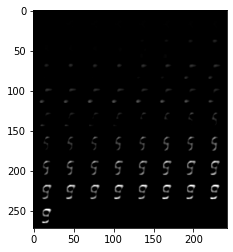

Epoch [355/400] Batch: [1/60] KL-Divergence: 0.0318378321826458 Cross-Entropy: 0.19676780700683594 Loss: 0.22860564291477203
Epoch [355/400] Batch: [2/60] KL-Divergence: 0.031644102185964584 Cross-Entropy: 0.19971495866775513 Loss: 0.23135906457901
Epoch [355/400] Batch: [3/60] KL-Divergence: 0.03319855406880379 Cross-Entropy: 0.20032651722431183 Loss: 0.23352506756782532
Epoch [355/400] Batch: [4/60] KL-Divergence: 0.030984632670879364 Cross-Entropy: 0.19743414223194122 Loss: 0.22841876745224
Epoch [355/400] Batch: [5/60] KL-Divergence: 0.03259681910276413 Cross-Entropy: 0.20097333192825317 Loss: 0.2335701584815979
Epoch [355/400] Batch: [6/60] KL-Divergence: 0.03125354275107384 Cross-Entropy: 0.20248131453990936 Loss: 0.2337348610162735
Epoch [355/400] Batch: [7/60] KL-Divergence: 0.031088504940271378 Cross-Entropy: 0.19872687757015228 Loss: 0.22981537878513336
Epoch [355/400] Batch: [8/60] KL-Divergence: 0.03103712759912014 Cross-Entropy: 0.1984919011592865 Loss: 0.2295290231704712


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [355/400] Batch: [60/60] KL-Divergence: 0.03249822556972504 Cross-Entropy: 0.2035546451807022 Loss: 0.23605287075042725
Epoch [355/400] Batch: [60/60] KL-Divergence: 0.03249822556972504 Cross-Entropy: 0.2035546451807022 Loss: 0.23605287075042725


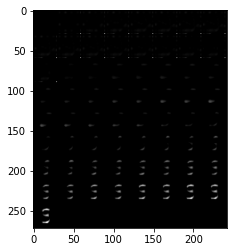

Epoch [356/400] Batch: [1/60] KL-Divergence: 0.03202183544635773 Cross-Entropy: 0.19707618653774261 Loss: 0.22909802198410034
Epoch [356/400] Batch: [2/60] KL-Divergence: 0.031942833214998245 Cross-Entropy: 0.19930244982242584 Loss: 0.2312452793121338
Epoch [356/400] Batch: [3/60] KL-Divergence: 0.030947791412472725 Cross-Entropy: 0.19903314113616943 Loss: 0.229980930685997
Epoch [356/400] Batch: [4/60] KL-Divergence: 0.03270018845796585 Cross-Entropy: 0.1970619410276413 Loss: 0.22976213693618774
Epoch [356/400] Batch: [5/60] KL-Divergence: 0.03372497111558914 Cross-Entropy: 0.20041108131408691 Loss: 0.23413604497909546
Epoch [356/400] Batch: [6/60] KL-Divergence: 0.03216681629419327 Cross-Entropy: 0.20113694667816162 Loss: 0.2333037555217743
Epoch [356/400] Batch: [7/60] KL-Divergence: 0.030736489221453667 Cross-Entropy: 0.19936269521713257 Loss: 0.23009918630123138
Epoch [356/400] Batch: [8/60] KL-Divergence: 0.030636059120297432 Cross-Entropy: 0.19740751385688782 Loss: 0.22804357111

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [356/400] Batch: [60/60] KL-Divergence: 0.03170071169734001 Cross-Entropy: 0.2064015418291092 Loss: 0.2381022572517395
Epoch [356/400] Batch: [60/60] KL-Divergence: 0.03170071169734001 Cross-Entropy: 0.2064015418291092 Loss: 0.2381022572517395


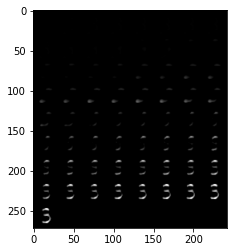

Epoch [357/400] Batch: [1/60] KL-Divergence: 0.03157496452331543 Cross-Entropy: 0.19811569154262543 Loss: 0.22969065606594086
Epoch [357/400] Batch: [2/60] KL-Divergence: 0.031380847096443176 Cross-Entropy: 0.2007398158311844 Loss: 0.23212066292762756
Epoch [357/400] Batch: [3/60] KL-Divergence: 0.030670467764139175 Cross-Entropy: 0.20062391459941864 Loss: 0.23129437863826752
Epoch [357/400] Batch: [4/60] KL-Divergence: 0.0318823903799057 Cross-Entropy: 0.20089958608150482 Loss: 0.23278197646141052
Epoch [357/400] Batch: [5/60] KL-Divergence: 0.03301844373345375 Cross-Entropy: 0.20343522727489471 Loss: 0.23645366728305817
Epoch [357/400] Batch: [6/60] KL-Divergence: 0.031915873289108276 Cross-Entropy: 0.2028461992740631 Loss: 0.2347620725631714
Epoch [357/400] Batch: [7/60] KL-Divergence: 0.03090539388358593 Cross-Entropy: 0.2007788121700287 Loss: 0.23168420791625977
Epoch [357/400] Batch: [8/60] KL-Divergence: 0.031277552247047424 Cross-Entropy: 0.20076055824756622 Loss: 0.23203811049

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [357/400] Batch: [60/60] KL-Divergence: 0.03315626457333565 Cross-Entropy: 0.20201370120048523 Loss: 0.23516996204853058
Epoch [357/400] Batch: [60/60] KL-Divergence: 0.03315626457333565 Cross-Entropy: 0.20201370120048523 Loss: 0.23516996204853058


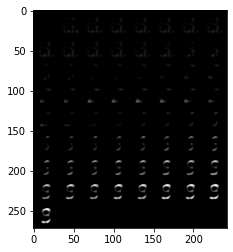

Epoch [358/400] Batch: [1/60] KL-Divergence: 0.03195146843791008 Cross-Entropy: 0.19636762142181396 Loss: 0.22831909358501434
Epoch [358/400] Batch: [2/60] KL-Divergence: 0.03201979771256447 Cross-Entropy: 0.20007868111133575 Loss: 0.23209847509860992
Epoch [358/400] Batch: [3/60] KL-Divergence: 0.03242625296115875 Cross-Entropy: 0.19917868077754974 Loss: 0.2316049337387085
Epoch [358/400] Batch: [4/60] KL-Divergence: 0.03200661018490791 Cross-Entropy: 0.19747251272201538 Loss: 0.229479119181633
Epoch [358/400] Batch: [5/60] KL-Divergence: 0.03229686617851257 Cross-Entropy: 0.20146676898002625 Loss: 0.23376363515853882
Epoch [358/400] Batch: [6/60] KL-Divergence: 0.030853107571601868 Cross-Entropy: 0.20193496346473694 Loss: 0.2327880710363388
Epoch [358/400] Batch: [7/60] KL-Divergence: 0.03172622248530388 Cross-Entropy: 0.20004324615001678 Loss: 0.23176947236061096
Epoch [358/400] Batch: [8/60] KL-Divergence: 0.03065330907702446 Cross-Entropy: 0.1995299905538559 Loss: 0.23018330335617

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [358/400] Batch: [60/60] KL-Divergence: 0.0314050018787384 Cross-Entropy: 0.2037116289138794 Loss: 0.2351166307926178
Epoch [358/400] Batch: [60/60] KL-Divergence: 0.0314050018787384 Cross-Entropy: 0.2037116289138794 Loss: 0.2351166307926178


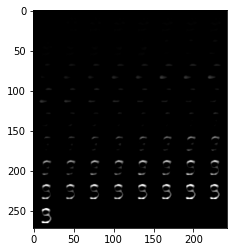

Epoch [359/400] Batch: [1/60] KL-Divergence: 0.0323219895362854 Cross-Entropy: 0.19814492762088776 Loss: 0.23046691715717316
Epoch [359/400] Batch: [2/60] KL-Divergence: 0.031226307153701782 Cross-Entropy: 0.20238496363162994 Loss: 0.23361127078533173
Epoch [359/400] Batch: [3/60] KL-Divergence: 0.030864283442497253 Cross-Entropy: 0.20476578176021576 Loss: 0.235630065202713
Epoch [359/400] Batch: [4/60] KL-Divergence: 0.031286999583244324 Cross-Entropy: 0.21032585203647614 Loss: 0.24161285161972046
Epoch [359/400] Batch: [5/60] KL-Divergence: 0.03211522847414017 Cross-Entropy: 0.22341711819171906 Loss: 0.2555323541164398
Epoch [359/400] Batch: [6/60] KL-Divergence: 0.03171347454190254 Cross-Entropy: 0.226701557636261 Loss: 0.2584150433540344
Epoch [359/400] Batch: [7/60] KL-Divergence: 0.029759984463453293 Cross-Entropy: 0.22315801680088043 Loss: 0.252918004989624
Epoch [359/400] Batch: [8/60] KL-Divergence: 0.028644606471061707 Cross-Entropy: 0.22319942712783813 Loss: 0.25184404850006

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [359/400] Batch: [60/60] KL-Divergence: 0.024814315140247345 Cross-Entropy: 0.22203487157821655 Loss: 0.2468491792678833
Epoch [359/400] Batch: [60/60] KL-Divergence: 0.024814315140247345 Cross-Entropy: 0.22203487157821655 Loss: 0.2468491792678833


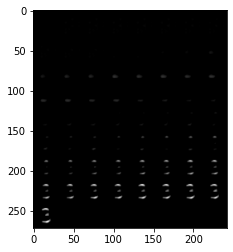

Epoch [360/400] Batch: [1/60] KL-Divergence: 0.02411947026848793 Cross-Entropy: 0.21633777022361755 Loss: 0.24045723676681519
Epoch [360/400] Batch: [2/60] KL-Divergence: 0.02469230629503727 Cross-Entropy: 0.21631687879562378 Loss: 0.2410091906785965
Epoch [360/400] Batch: [3/60] KL-Divergence: 0.02483750879764557 Cross-Entropy: 0.2201422154903412 Loss: 0.24497972428798676
Epoch [360/400] Batch: [4/60] KL-Divergence: 0.025092221796512604 Cross-Entropy: 0.21224769949913025 Loss: 0.23733991384506226
Epoch [360/400] Batch: [5/60] KL-Divergence: 0.026658764109015465 Cross-Entropy: 0.2192070633172989 Loss: 0.2458658218383789
Epoch [360/400] Batch: [6/60] KL-Divergence: 0.02576327510178089 Cross-Entropy: 0.21857647597789764 Loss: 0.2443397492170334
Epoch [360/400] Batch: [7/60] KL-Divergence: 0.02608819678425789 Cross-Entropy: 0.2136094868183136 Loss: 0.2396976798772812
Epoch [360/400] Batch: [8/60] KL-Divergence: 0.025248857215046883 Cross-Entropy: 0.21228988468647003 Loss: 0.23753874003887

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [360/400] Batch: [60/60] KL-Divergence: 0.028932778164744377 Cross-Entropy: 0.21309688687324524 Loss: 0.24202966690063477
Epoch [360/400] Batch: [60/60] KL-Divergence: 0.028932778164744377 Cross-Entropy: 0.21309688687324524 Loss: 0.24202966690063477


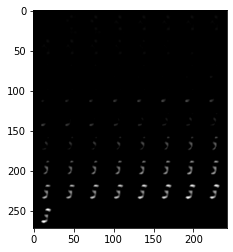

Epoch [361/400] Batch: [1/60] KL-Divergence: 0.0280024204403162 Cross-Entropy: 0.20532578229904175 Loss: 0.2333282083272934
Epoch [361/400] Batch: [2/60] KL-Divergence: 0.02769944816827774 Cross-Entropy: 0.2080828845500946 Loss: 0.23578232526779175
Epoch [361/400] Batch: [3/60] KL-Divergence: 0.027804622426629066 Cross-Entropy: 0.2101849764585495 Loss: 0.237989604473114
Epoch [361/400] Batch: [4/60] KL-Divergence: 0.027374381199479103 Cross-Entropy: 0.2052004039287567 Loss: 0.23257479071617126
Epoch [361/400] Batch: [5/60] KL-Divergence: 0.029625091701745987 Cross-Entropy: 0.21160337328910828 Loss: 0.24122846126556396
Epoch [361/400] Batch: [6/60] KL-Divergence: 0.029076537117362022 Cross-Entropy: 0.20894847810268402 Loss: 0.2380250096321106
Epoch [361/400] Batch: [7/60] KL-Divergence: 0.02852986566722393 Cross-Entropy: 0.20792657136917114 Loss: 0.23645643889904022
Epoch [361/400] Batch: [8/60] KL-Divergence: 0.0291590616106987 Cross-Entropy: 0.20586331188678741 Loss: 0.235022366046905

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [361/400] Batch: [60/60] KL-Divergence: 0.03101644478738308 Cross-Entropy: 0.2094280868768692 Loss: 0.24044452607631683
Epoch [361/400] Batch: [60/60] KL-Divergence: 0.03101644478738308 Cross-Entropy: 0.2094280868768692 Loss: 0.24044452607631683


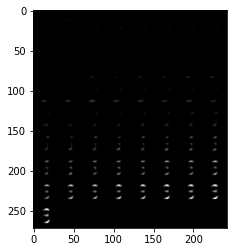

Epoch [362/400] Batch: [1/60] KL-Divergence: 0.030731769278645515 Cross-Entropy: 0.20257149636745453 Loss: 0.2333032637834549
Epoch [362/400] Batch: [2/60] KL-Divergence: 0.030024364590644836 Cross-Entropy: 0.20572812855243683 Loss: 0.23575249314308167
Epoch [362/400] Batch: [3/60] KL-Divergence: 0.029705556109547615 Cross-Entropy: 0.20715855062007904 Loss: 0.2368641048669815
Epoch [362/400] Batch: [4/60] KL-Divergence: 0.02854815125465393 Cross-Entropy: 0.20397967100143433 Loss: 0.23252782225608826
Epoch [362/400] Batch: [5/60] KL-Divergence: 0.030762040987610817 Cross-Entropy: 0.20875848829746246 Loss: 0.23952053487300873
Epoch [362/400] Batch: [6/60] KL-Divergence: 0.030031034722924232 Cross-Entropy: 0.2069607675075531 Loss: 0.23699180781841278
Epoch [362/400] Batch: [7/60] KL-Divergence: 0.028099941089749336 Cross-Entropy: 0.20553095638751984 Loss: 0.23363089561462402
Epoch [362/400] Batch: [8/60] KL-Divergence: 0.029110698029398918 Cross-Entropy: 0.20418430864810944 Loss: 0.233295

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [362/400] Batch: [60/60] KL-Divergence: 0.031072162091732025 Cross-Entropy: 0.20981855690479279 Loss: 0.2408907115459442
Epoch [362/400] Batch: [60/60] KL-Divergence: 0.031072162091732025 Cross-Entropy: 0.20981855690479279 Loss: 0.2408907115459442


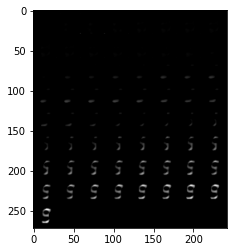

Epoch [363/400] Batch: [1/60] KL-Divergence: 0.030863409861922264 Cross-Entropy: 0.20168045163154602 Loss: 0.23254385590553284
Epoch [363/400] Batch: [2/60] KL-Divergence: 0.029812399297952652 Cross-Entropy: 0.2046786993741989 Loss: 0.23449109494686127
Epoch [363/400] Batch: [3/60] KL-Divergence: 0.030244046822190285 Cross-Entropy: 0.20624476671218872 Loss: 0.23648881912231445
Epoch [363/400] Batch: [4/60] KL-Divergence: 0.029171694070100784 Cross-Entropy: 0.20223361253738403 Loss: 0.23140530288219452
Epoch [363/400] Batch: [5/60] KL-Divergence: 0.030864911153912544 Cross-Entropy: 0.20666280388832092 Loss: 0.23752771317958832
Epoch [363/400] Batch: [6/60] KL-Divergence: 0.030167577788233757 Cross-Entropy: 0.2064920961856842 Loss: 0.2366596758365631
Epoch [363/400] Batch: [7/60] KL-Divergence: 0.029716862365603447 Cross-Entropy: 0.20362646877765656 Loss: 0.23334333300590515
Epoch [363/400] Batch: [8/60] KL-Divergence: 0.028843315318226814 Cross-Entropy: 0.20393304526805878 Loss: 0.23277

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [363/400] Batch: [60/60] KL-Divergence: 0.03093276359140873 Cross-Entropy: 0.20706625282764435 Loss: 0.23799902200698853
Epoch [363/400] Batch: [60/60] KL-Divergence: 0.03093276359140873 Cross-Entropy: 0.20706625282764435 Loss: 0.23799902200698853


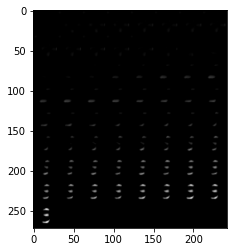

Epoch [364/400] Batch: [1/60] KL-Divergence: 0.030820781365036964 Cross-Entropy: 0.19995887577533722 Loss: 0.23077966272830963
Epoch [364/400] Batch: [2/60] KL-Divergence: 0.029348012059926987 Cross-Entropy: 0.2018517106771469 Loss: 0.2311997264623642
Epoch [364/400] Batch: [3/60] KL-Divergence: 0.030572429299354553 Cross-Entropy: 0.2044948935508728 Loss: 0.23506732285022736
Epoch [364/400] Batch: [4/60] KL-Divergence: 0.028800707310438156 Cross-Entropy: 0.20013348758220673 Loss: 0.22893419861793518
Epoch [364/400] Batch: [5/60] KL-Divergence: 0.03128628432750702 Cross-Entropy: 0.20525087416172028 Loss: 0.2365371584892273
Epoch [364/400] Batch: [6/60] KL-Divergence: 0.030482489615678787 Cross-Entropy: 0.20318837463855743 Loss: 0.23367086052894592
Epoch [364/400] Batch: [7/60] KL-Divergence: 0.029766907915472984 Cross-Entropy: 0.2011835128068924 Loss: 0.23095041513442993
Epoch [364/400] Batch: [8/60] KL-Divergence: 0.0290052630007267 Cross-Entropy: 0.20172223448753357 Loss: 0.2307274937

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [364/400] Batch: [60/60] KL-Divergence: 0.03226185590028763 Cross-Entropy: 0.2051038295030594 Loss: 0.2373656928539276
Epoch [364/400] Batch: [60/60] KL-Divergence: 0.03226185590028763 Cross-Entropy: 0.2051038295030594 Loss: 0.2373656928539276


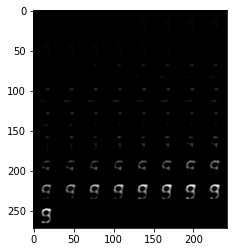

Epoch [365/400] Batch: [1/60] KL-Divergence: 0.03039245493710041 Cross-Entropy: 0.1989167332649231 Loss: 0.22930918633937836
Epoch [365/400] Batch: [2/60] KL-Divergence: 0.030621027573943138 Cross-Entropy: 0.2023106962442398 Loss: 0.2329317182302475
Epoch [365/400] Batch: [3/60] KL-Divergence: 0.03210677206516266 Cross-Entropy: 0.20362718403339386 Loss: 0.23573395609855652
Epoch [365/400] Batch: [4/60] KL-Divergence: 0.029865559190511703 Cross-Entropy: 0.19902363419532776 Loss: 0.22888919711112976
Epoch [365/400] Batch: [5/60] KL-Divergence: 0.0325523242354393 Cross-Entropy: 0.2039729207754135 Loss: 0.23652523756027222
Epoch [365/400] Batch: [6/60] KL-Divergence: 0.031615082174539566 Cross-Entropy: 0.20321303606033325 Loss: 0.23482811450958252
Epoch [365/400] Batch: [7/60] KL-Divergence: 0.0307143684476614 Cross-Entropy: 0.20213481783866882 Loss: 0.23284918069839478
Epoch [365/400] Batch: [8/60] KL-Divergence: 0.030280346050858498 Cross-Entropy: 0.20073312520980835 Loss: 0.231013476848

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [365/400] Batch: [60/60] KL-Divergence: 0.03304266184568405 Cross-Entropy: 0.20503953099250793 Loss: 0.23808220028877258
Epoch [365/400] Batch: [60/60] KL-Divergence: 0.03304266184568405 Cross-Entropy: 0.20503953099250793 Loss: 0.23808220028877258


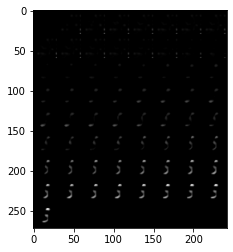

Epoch [366/400] Batch: [1/60] KL-Divergence: 0.030805885791778564 Cross-Entropy: 0.19846764206886292 Loss: 0.22927352786064148
Epoch [366/400] Batch: [2/60] KL-Divergence: 0.03067946434020996 Cross-Entropy: 0.20129375159740448 Loss: 0.23197321593761444
Epoch [366/400] Batch: [3/60] KL-Divergence: 0.030897952616214752 Cross-Entropy: 0.2016468197107315 Loss: 0.23254477977752686
Epoch [366/400] Batch: [4/60] KL-Divergence: 0.02977610193192959 Cross-Entropy: 0.19922316074371338 Loss: 0.22899925708770752
Epoch [366/400] Batch: [5/60] KL-Divergence: 0.03282096982002258 Cross-Entropy: 0.20420943200588226 Loss: 0.23703040182590485
Epoch [366/400] Batch: [6/60] KL-Divergence: 0.03160315752029419 Cross-Entropy: 0.2035135179758072 Loss: 0.23511667549610138
Epoch [366/400] Batch: [7/60] KL-Divergence: 0.02917533926665783 Cross-Entropy: 0.2018359899520874 Loss: 0.23101133108139038
Epoch [366/400] Batch: [8/60] KL-Divergence: 0.031252630054950714 Cross-Entropy: 0.2021821290254593 Loss: 0.23343476653

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [366/400] Batch: [60/60] KL-Divergence: 0.032214462757110596 Cross-Entropy: 0.2041436731815338 Loss: 0.2363581359386444
Epoch [366/400] Batch: [60/60] KL-Divergence: 0.032214462757110596 Cross-Entropy: 0.2041436731815338 Loss: 0.2363581359386444


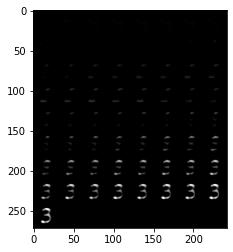

Epoch [367/400] Batch: [1/60] KL-Divergence: 0.03080436959862709 Cross-Entropy: 0.19889850914478302 Loss: 0.2297028750181198
Epoch [367/400] Batch: [2/60] KL-Divergence: 0.03095148876309395 Cross-Entropy: 0.20089201629161835 Loss: 0.231843501329422
Epoch [367/400] Batch: [3/60] KL-Divergence: 0.0311755258589983 Cross-Entropy: 0.20170331001281738 Loss: 0.23287883400917053
Epoch [367/400] Batch: [4/60] KL-Divergence: 0.030771084129810333 Cross-Entropy: 0.1984373927116394 Loss: 0.22920846939086914
Epoch [367/400] Batch: [5/60] KL-Divergence: 0.03073921985924244 Cross-Entropy: 0.20302723348140717 Loss: 0.23376645147800446
Epoch [367/400] Batch: [6/60] KL-Divergence: 0.031656719744205475 Cross-Entropy: 0.20312455296516418 Loss: 0.23478126525878906
Epoch [367/400] Batch: [7/60] KL-Divergence: 0.03141483664512634 Cross-Entropy: 0.2013518363237381 Loss: 0.23276667296886444
Epoch [367/400] Batch: [8/60] KL-Divergence: 0.030331449583172798 Cross-Entropy: 0.20004059374332428 Loss: 0.2303720414638

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [367/400] Batch: [60/60] KL-Divergence: 0.0322311669588089 Cross-Entropy: 0.20341621339321136 Loss: 0.23564738035202026
Epoch [367/400] Batch: [60/60] KL-Divergence: 0.0322311669588089 Cross-Entropy: 0.20341621339321136 Loss: 0.23564738035202026


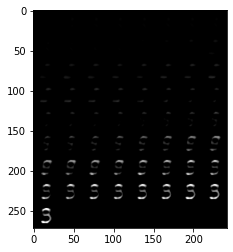

Epoch [368/400] Batch: [1/60] KL-Divergence: 0.031684692949056625 Cross-Entropy: 0.1970805823802948 Loss: 0.22876527905464172
Epoch [368/400] Batch: [2/60] KL-Divergence: 0.03210474178195 Cross-Entropy: 0.20118960738182068 Loss: 0.23329435288906097
Epoch [368/400] Batch: [3/60] KL-Divergence: 0.031088534742593765 Cross-Entropy: 0.20047743618488312 Loss: 0.23156596720218658
Epoch [368/400] Batch: [4/60] KL-Divergence: 0.030165253207087517 Cross-Entropy: 0.19684992730617523 Loss: 0.2270151823759079
Epoch [368/400] Batch: [5/60] KL-Divergence: 0.03302828595042229 Cross-Entropy: 0.20366698503494263 Loss: 0.2366952747106552
Epoch [368/400] Batch: [6/60] KL-Divergence: 0.032355256378650665 Cross-Entropy: 0.20088346302509308 Loss: 0.23323872685432434
Epoch [368/400] Batch: [7/60] KL-Divergence: 0.031240401789546013 Cross-Entropy: 0.19874198734760284 Loss: 0.229982390999794
Epoch [368/400] Batch: [8/60] KL-Divergence: 0.03064638376235962 Cross-Entropy: 0.19894836843013763 Loss: 0.2295947521924

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [368/400] Batch: [60/60] KL-Divergence: 0.031414639204740524 Cross-Entropy: 0.2026323825120926 Loss: 0.2340470254421234
Epoch [368/400] Batch: [60/60] KL-Divergence: 0.031414639204740524 Cross-Entropy: 0.2026323825120926 Loss: 0.2340470254421234


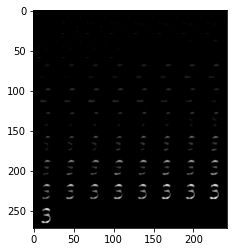

Epoch [369/400] Batch: [1/60] KL-Divergence: 0.03192305564880371 Cross-Entropy: 0.19705238938331604 Loss: 0.22897544503211975
Epoch [369/400] Batch: [2/60] KL-Divergence: 0.03167005628347397 Cross-Entropy: 0.2004411220550537 Loss: 0.23211118578910828
Epoch [369/400] Batch: [3/60] KL-Divergence: 0.03147627040743828 Cross-Entropy: 0.20064300298690796 Loss: 0.23211927711963654
Epoch [369/400] Batch: [4/60] KL-Divergence: 0.030951756983995438 Cross-Entropy: 0.1980263590812683 Loss: 0.22897811233997345
Epoch [369/400] Batch: [5/60] KL-Divergence: 0.031710948795080185 Cross-Entropy: 0.2008192241191864 Loss: 0.23253017663955688
Epoch [369/400] Batch: [6/60] KL-Divergence: 0.032294560223817825 Cross-Entropy: 0.2020384967327118 Loss: 0.23433305323123932
Epoch [369/400] Batch: [7/60] KL-Divergence: 0.03059113211929798 Cross-Entropy: 0.19998082518577576 Loss: 0.2305719554424286
Epoch [369/400] Batch: [8/60] KL-Divergence: 0.03107542172074318 Cross-Entropy: 0.2005414217710495 Loss: 0.2316168397665

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [369/400] Batch: [60/60] KL-Divergence: 0.03325065225362778 Cross-Entropy: 0.2021857053041458 Loss: 0.235436350107193
Epoch [369/400] Batch: [60/60] KL-Divergence: 0.03325065225362778 Cross-Entropy: 0.2021857053041458 Loss: 0.235436350107193


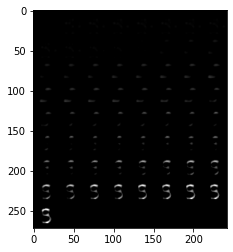

Epoch [370/400] Batch: [1/60] KL-Divergence: 0.03265757858753204 Cross-Entropy: 0.19547432661056519 Loss: 0.22813190519809723
Epoch [370/400] Batch: [2/60] KL-Divergence: 0.03256325051188469 Cross-Entropy: 0.19943749904632568 Loss: 0.23200075328350067
Epoch [370/400] Batch: [3/60] KL-Divergence: 0.031934384256601334 Cross-Entropy: 0.19939830899238586 Loss: 0.2313326895236969
Epoch [370/400] Batch: [4/60] KL-Divergence: 0.03161390870809555 Cross-Entropy: 0.1965942233800888 Loss: 0.22820812463760376
Epoch [370/400] Batch: [5/60] KL-Divergence: 0.03282449021935463 Cross-Entropy: 0.20010851323604584 Loss: 0.23293299973011017
Epoch [370/400] Batch: [6/60] KL-Divergence: 0.03224761784076691 Cross-Entropy: 0.2006712257862091 Loss: 0.232918843626976
Epoch [370/400] Batch: [7/60] KL-Divergence: 0.03161529079079628 Cross-Entropy: 0.1975216120481491 Loss: 0.2291368991136551
Epoch [370/400] Batch: [8/60] KL-Divergence: 0.031201109290122986 Cross-Entropy: 0.19908306002616882 Loss: 0.230284169316291

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [370/400] Batch: [60/60] KL-Divergence: 0.031472329050302505 Cross-Entropy: 0.20339350402355194 Loss: 0.23486582934856415
Epoch [370/400] Batch: [60/60] KL-Divergence: 0.031472329050302505 Cross-Entropy: 0.20339350402355194 Loss: 0.23486582934856415


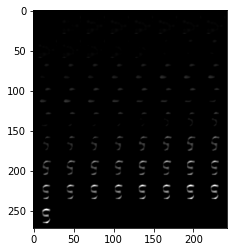

Epoch [371/400] Batch: [1/60] KL-Divergence: 0.032099831849336624 Cross-Entropy: 0.19658520817756653 Loss: 0.22868503630161285
Epoch [371/400] Batch: [2/60] KL-Divergence: 0.03179504722356796 Cross-Entropy: 0.20030328631401062 Loss: 0.23209834098815918
Epoch [371/400] Batch: [3/60] KL-Divergence: 0.031215649098157883 Cross-Entropy: 0.1993137151002884 Loss: 0.23052936792373657
Epoch [371/400] Batch: [4/60] KL-Divergence: 0.030194943770766258 Cross-Entropy: 0.19670124351978302 Loss: 0.22689618170261383
Epoch [371/400] Batch: [5/60] KL-Divergence: 0.03331679478287697 Cross-Entropy: 0.20203708112239838 Loss: 0.23535387217998505
Epoch [371/400] Batch: [6/60] KL-Divergence: 0.031951673328876495 Cross-Entropy: 0.2012866884469986 Loss: 0.2332383692264557
Epoch [371/400] Batch: [7/60] KL-Divergence: 0.03123089298605919 Cross-Entropy: 0.19791507720947266 Loss: 0.22914597392082214
Epoch [371/400] Batch: [8/60] KL-Divergence: 0.03138970956206322 Cross-Entropy: 0.19794508814811707 Loss: 0.229334801

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [371/400] Batch: [60/60] KL-Divergence: 0.032079894095659256 Cross-Entropy: 0.20244711637496948 Loss: 0.23452700674533844
Epoch [371/400] Batch: [60/60] KL-Divergence: 0.032079894095659256 Cross-Entropy: 0.20244711637496948 Loss: 0.23452700674533844


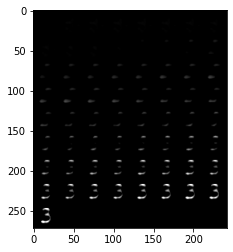

Epoch [372/400] Batch: [1/60] KL-Divergence: 0.033543627709150314 Cross-Entropy: 0.194935142993927 Loss: 0.22847877442836761
Epoch [372/400] Batch: [2/60] KL-Divergence: 0.03236982971429825 Cross-Entropy: 0.19748751819133759 Loss: 0.22985735535621643
Epoch [372/400] Batch: [3/60] KL-Divergence: 0.033158447593450546 Cross-Entropy: 0.19870994985103607 Loss: 0.23186840116977692
Epoch [372/400] Batch: [4/60] KL-Divergence: 0.03231506794691086 Cross-Entropy: 0.1952807605266571 Loss: 0.22759583592414856
Epoch [372/400] Batch: [5/60] KL-Divergence: 0.03393186628818512 Cross-Entropy: 0.2015404850244522 Loss: 0.23547235131263733
Epoch [372/400] Batch: [6/60] KL-Divergence: 0.0327298529446125 Cross-Entropy: 0.19941118359565735 Loss: 0.23214103281497955
Epoch [372/400] Batch: [7/60] KL-Divergence: 0.03276382014155388 Cross-Entropy: 0.19859029352664948 Loss: 0.23135411739349365
Epoch [372/400] Batch: [8/60] KL-Divergence: 0.03222260996699333 Cross-Entropy: 0.1975340098142624 Loss: 0.22975662350654

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [372/400] Batch: [60/60] KL-Divergence: 0.03250015527009964 Cross-Entropy: 0.20249702036380768 Loss: 0.23499718308448792
Epoch [372/400] Batch: [60/60] KL-Divergence: 0.03250015527009964 Cross-Entropy: 0.20249702036380768 Loss: 0.23499718308448792


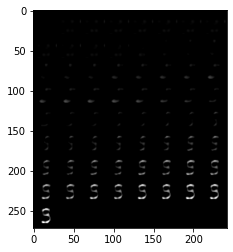

Epoch [373/400] Batch: [1/60] KL-Divergence: 0.032269153743982315 Cross-Entropy: 0.19575466215610504 Loss: 0.22802381217479706
Epoch [373/400] Batch: [2/60] KL-Divergence: 0.03197780251502991 Cross-Entropy: 0.2001202553510666 Loss: 0.2320980578660965
Epoch [373/400] Batch: [3/60] KL-Divergence: 0.03170415386557579 Cross-Entropy: 0.19905932247638702 Loss: 0.2307634800672531
Epoch [373/400] Batch: [4/60] KL-Divergence: 0.0307882409542799 Cross-Entropy: 0.19683529436588287 Loss: 0.22762353718280792
Epoch [373/400] Batch: [5/60] KL-Divergence: 0.03273769095540047 Cross-Entropy: 0.20078164339065552 Loss: 0.23351933062076569
Epoch [373/400] Batch: [6/60] KL-Divergence: 0.031032513827085495 Cross-Entropy: 0.20223046839237213 Loss: 0.23326298594474792
Epoch [373/400] Batch: [7/60] KL-Divergence: 0.029669716954231262 Cross-Entropy: 0.1976037621498108 Loss: 0.22727347910404205
Epoch [373/400] Batch: [8/60] KL-Divergence: 0.03182157129049301 Cross-Entropy: 0.19889476895332336 Loss: 0.230716347694

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [373/400] Batch: [60/60] KL-Divergence: 0.03427259996533394 Cross-Entropy: 0.20211881399154663 Loss: 0.23639141023159027
Epoch [373/400] Batch: [60/60] KL-Divergence: 0.03427259996533394 Cross-Entropy: 0.20211881399154663 Loss: 0.23639141023159027


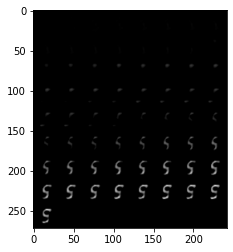

Epoch [374/400] Batch: [1/60] KL-Divergence: 0.03337963670492172 Cross-Entropy: 0.1959298849105835 Loss: 0.22930952906608582
Epoch [374/400] Batch: [2/60] KL-Divergence: 0.03298971429467201 Cross-Entropy: 0.19809922575950623 Loss: 0.23108893632888794
Epoch [374/400] Batch: [3/60] KL-Divergence: 0.03345605731010437 Cross-Entropy: 0.1991203874349594 Loss: 0.23257644474506378
Epoch [374/400] Batch: [4/60] KL-Divergence: 0.03273008391261101 Cross-Entropy: 0.19577187299728394 Loss: 0.22850196063518524
Epoch [374/400] Batch: [5/60] KL-Divergence: 0.03476244583725929 Cross-Entropy: 0.20109672844409943 Loss: 0.23585917055606842
Epoch [374/400] Batch: [6/60] KL-Divergence: 0.03244214877486229 Cross-Entropy: 0.20163467526435852 Loss: 0.2340768277645111
Epoch [374/400] Batch: [7/60] KL-Divergence: 0.032378681004047394 Cross-Entropy: 0.1979261189699173 Loss: 0.2303048074245453
Epoch [374/400] Batch: [8/60] KL-Divergence: 0.03136245906352997 Cross-Entropy: 0.19799335300922394 Loss: 0.22935581207275

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [374/400] Batch: [60/60] KL-Divergence: 0.03196375072002411 Cross-Entropy: 0.20211556553840637 Loss: 0.23407931625843048
Epoch [374/400] Batch: [60/60] KL-Divergence: 0.03196375072002411 Cross-Entropy: 0.20211556553840637 Loss: 0.23407931625843048


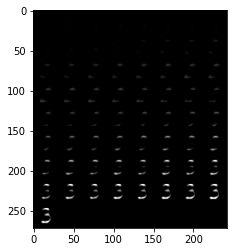

Epoch [375/400] Batch: [1/60] KL-Divergence: 0.03259672597050667 Cross-Entropy: 0.19620633125305176 Loss: 0.22880305349826813
Epoch [375/400] Batch: [2/60] KL-Divergence: 0.03148642182350159 Cross-Entropy: 0.1980813890695572 Loss: 0.22956781089305878
Epoch [375/400] Batch: [3/60] KL-Divergence: 0.03300178423523903 Cross-Entropy: 0.19830644130706787 Loss: 0.2313082218170166
Epoch [375/400] Batch: [4/60] KL-Divergence: 0.03177809342741966 Cross-Entropy: 0.1960994303226471 Loss: 0.22787752747535706
Epoch [375/400] Batch: [5/60] KL-Divergence: 0.03305757790803909 Cross-Entropy: 0.20040632784366608 Loss: 0.23346391320228577
Epoch [375/400] Batch: [6/60] KL-Divergence: 0.032222338020801544 Cross-Entropy: 0.19981537759304047 Loss: 0.2320377230644226
Epoch [375/400] Batch: [7/60] KL-Divergence: 0.031740497797727585 Cross-Entropy: 0.19784700870513916 Loss: 0.22958751022815704
Epoch [375/400] Batch: [8/60] KL-Divergence: 0.03109639137983322 Cross-Entropy: 0.19739770889282227 Loss: 0.228494107723

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [375/400] Batch: [60/60] KL-Divergence: 0.03237483650445938 Cross-Entropy: 0.20069636404514313 Loss: 0.2330712080001831
Epoch [375/400] Batch: [60/60] KL-Divergence: 0.03237483650445938 Cross-Entropy: 0.20069636404514313 Loss: 0.2330712080001831


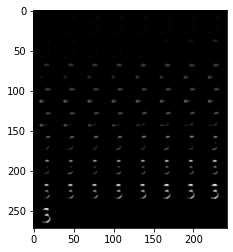

Epoch [376/400] Batch: [1/60] KL-Divergence: 0.032646603882312775 Cross-Entropy: 0.19506949186325073 Loss: 0.2277160882949829
Epoch [376/400] Batch: [2/60] KL-Divergence: 0.03212587907910347 Cross-Entropy: 0.1986512988805771 Loss: 0.23077717423439026
Epoch [376/400] Batch: [3/60] KL-Divergence: 0.032397083938121796 Cross-Entropy: 0.1972212940454483 Loss: 0.2296183705329895
Epoch [376/400] Batch: [4/60] KL-Divergence: 0.03168722987174988 Cross-Entropy: 0.19472816586494446 Loss: 0.22641539573669434
Epoch [376/400] Batch: [5/60] KL-Divergence: 0.032590027898550034 Cross-Entropy: 0.1992214173078537 Loss: 0.23181144893169403
Epoch [376/400] Batch: [6/60] KL-Divergence: 0.03132003918290138 Cross-Entropy: 0.2001640945672989 Loss: 0.23148413002490997
Epoch [376/400] Batch: [7/60] KL-Divergence: 0.031503159552812576 Cross-Entropy: 0.19716115295886993 Loss: 0.2286643087863922
Epoch [376/400] Batch: [8/60] KL-Divergence: 0.029728734865784645 Cross-Entropy: 0.19893530011177063 Loss: 0.228664040565

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [376/400] Batch: [60/60] KL-Divergence: 0.03543630987405777 Cross-Entropy: 0.20227615535259247 Loss: 0.23771247267723083
Epoch [376/400] Batch: [60/60] KL-Divergence: 0.03543630987405777 Cross-Entropy: 0.20227615535259247 Loss: 0.23771247267723083


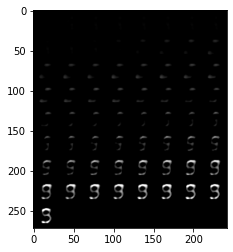

Epoch [377/400] Batch: [1/60] KL-Divergence: 0.035382527858018875 Cross-Entropy: 0.19459262490272522 Loss: 0.2299751490354538
Epoch [377/400] Batch: [2/60] KL-Divergence: 0.03524888679385185 Cross-Entropy: 0.19762961566448212 Loss: 0.23287850618362427
Epoch [377/400] Batch: [3/60] KL-Divergence: 0.034878525882959366 Cross-Entropy: 0.19751127064228058 Loss: 0.23238979279994965
Epoch [377/400] Batch: [4/60] KL-Divergence: 0.03424229100346565 Cross-Entropy: 0.1954953521490097 Loss: 0.22973763942718506
Epoch [377/400] Batch: [5/60] KL-Divergence: 0.0367182232439518 Cross-Entropy: 0.19940185546875 Loss: 0.2361200749874115
Epoch [377/400] Batch: [6/60] KL-Divergence: 0.03456222265958786 Cross-Entropy: 0.2001330852508545 Loss: 0.23469531536102295
Epoch [377/400] Batch: [7/60] KL-Divergence: 0.033146921545267105 Cross-Entropy: 0.1978626400232315 Loss: 0.2310095578432083
Epoch [377/400] Batch: [8/60] KL-Divergence: 0.031918641179800034 Cross-Entropy: 0.19751326739788055 Loss: 0.2294319123029709

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [377/400] Batch: [60/60] KL-Divergence: 0.03217040002346039 Cross-Entropy: 0.20228292047977448 Loss: 0.23445332050323486
Epoch [377/400] Batch: [60/60] KL-Divergence: 0.03217040002346039 Cross-Entropy: 0.20228292047977448 Loss: 0.23445332050323486


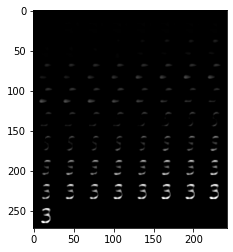

Epoch [378/400] Batch: [1/60] KL-Divergence: 0.03216813504695892 Cross-Entropy: 0.19520780444145203 Loss: 0.22737593948841095
Epoch [378/400] Batch: [2/60] KL-Divergence: 0.03243536502122879 Cross-Entropy: 0.19897839426994324 Loss: 0.23141375184059143
Epoch [378/400] Batch: [3/60] KL-Divergence: 0.03151204437017441 Cross-Entropy: 0.19805258512496948 Loss: 0.2295646369457245
Epoch [378/400] Batch: [4/60] KL-Divergence: 0.03210772946476936 Cross-Entropy: 0.19581513106822968 Loss: 0.22792285680770874
Epoch [378/400] Batch: [5/60] KL-Divergence: 0.03275959938764572 Cross-Entropy: 0.19909317791461945 Loss: 0.23185276985168457
Epoch [378/400] Batch: [6/60] KL-Divergence: 0.031380150467157364 Cross-Entropy: 0.1996690332889557 Loss: 0.23104918003082275
Epoch [378/400] Batch: [7/60] KL-Divergence: 0.03175720199942589 Cross-Entropy: 0.19660751521587372 Loss: 0.2283647209405899
Epoch [378/400] Batch: [8/60] KL-Divergence: 0.031825099140405655 Cross-Entropy: 0.19708757102489471 Loss: 0.22891266644

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [378/400] Batch: [60/60] KL-Divergence: 0.033643193542957306 Cross-Entropy: 0.20026960968971252 Loss: 0.23391279578208923
Epoch [378/400] Batch: [60/60] KL-Divergence: 0.033643193542957306 Cross-Entropy: 0.20026960968971252 Loss: 0.23391279578208923


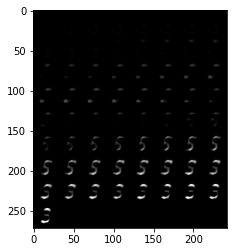

Epoch [379/400] Batch: [1/60] KL-Divergence: 0.03420545905828476 Cross-Entropy: 0.1942926049232483 Loss: 0.22849807143211365
Epoch [379/400] Batch: [2/60] KL-Divergence: 0.03220345079898834 Cross-Entropy: 0.19727514684200287 Loss: 0.2294785976409912
Epoch [379/400] Batch: [3/60] KL-Divergence: 0.03145727887749672 Cross-Entropy: 0.1963857114315033 Loss: 0.22784298658370972
Epoch [379/400] Batch: [4/60] KL-Divergence: 0.03262728080153465 Cross-Entropy: 0.19337987899780273 Loss: 0.22600716352462769
Epoch [379/400] Batch: [5/60] KL-Divergence: 0.03339962661266327 Cross-Entropy: 0.1997540146112442 Loss: 0.23315364122390747
Epoch [379/400] Batch: [6/60] KL-Divergence: 0.03172742575407028 Cross-Entropy: 0.19878463447093964 Loss: 0.23051205277442932
Epoch [379/400] Batch: [7/60] KL-Divergence: 0.03129764273762703 Cross-Entropy: 0.19627654552459717 Loss: 0.2275741845369339
Epoch [379/400] Batch: [8/60] KL-Divergence: 0.03060051240026951 Cross-Entropy: 0.19619472324848175 Loss: 0.226795241236686

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [379/400] Batch: [60/60] KL-Divergence: 0.03244548290967941 Cross-Entropy: 0.20152173936367035 Loss: 0.23396721482276917
Epoch [379/400] Batch: [60/60] KL-Divergence: 0.03244548290967941 Cross-Entropy: 0.20152173936367035 Loss: 0.23396721482276917


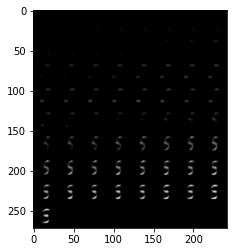

Epoch [380/400] Batch: [1/60] KL-Divergence: 0.033143579959869385 Cross-Entropy: 0.19483447074890137 Loss: 0.22797805070877075
Epoch [380/400] Batch: [2/60] KL-Divergence: 0.032207828015089035 Cross-Entropy: 0.19848594069480896 Loss: 0.2306937724351883
Epoch [380/400] Batch: [3/60] KL-Divergence: 0.03190012276172638 Cross-Entropy: 0.19817206263542175 Loss: 0.23007218539714813
Epoch [380/400] Batch: [4/60] KL-Divergence: 0.031802184879779816 Cross-Entropy: 0.196367084980011 Loss: 0.2281692624092102
Epoch [380/400] Batch: [5/60] KL-Divergence: 0.032214902341365814 Cross-Entropy: 0.2006983608007431 Loss: 0.23291325569152832
Epoch [380/400] Batch: [6/60] KL-Divergence: 0.030682820826768875 Cross-Entropy: 0.20100511610507965 Loss: 0.23168793320655823
Epoch [380/400] Batch: [7/60] KL-Divergence: 0.0299453753978014 Cross-Entropy: 0.19844956696033478 Loss: 0.22839494049549103
Epoch [380/400] Batch: [8/60] KL-Divergence: 0.030868124216794968 Cross-Entropy: 0.19879862666130066 Loss: 0.2296667546

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [380/400] Batch: [60/60] KL-Divergence: 0.03397703543305397 Cross-Entropy: 0.20178838074207306 Loss: 0.23576541244983673
Epoch [380/400] Batch: [60/60] KL-Divergence: 0.03397703543305397 Cross-Entropy: 0.20178838074207306 Loss: 0.23576541244983673


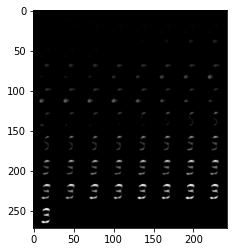

Epoch [381/400] Batch: [1/60] KL-Divergence: 0.0321277417242527 Cross-Entropy: 0.19422811269760132 Loss: 0.22635585069656372
Epoch [381/400] Batch: [2/60] KL-Divergence: 0.03219367191195488 Cross-Entropy: 0.1971474289894104 Loss: 0.22934110462665558
Epoch [381/400] Batch: [3/60] KL-Divergence: 0.03236081078648567 Cross-Entropy: 0.19843284785747528 Loss: 0.23079365491867065
Epoch [381/400] Batch: [4/60] KL-Divergence: 0.03149334341287613 Cross-Entropy: 0.1947057545185089 Loss: 0.22619909048080444
Epoch [381/400] Batch: [5/60] KL-Divergence: 0.033536601811647415 Cross-Entropy: 0.19950389862060547 Loss: 0.23304049670696259
Epoch [381/400] Batch: [6/60] KL-Divergence: 0.03215434402227402 Cross-Entropy: 0.19948017597198486 Loss: 0.23163452744483948
Epoch [381/400] Batch: [7/60] KL-Divergence: 0.03216501697897911 Cross-Entropy: 0.1967581808567047 Loss: 0.22892320156097412
Epoch [381/400] Batch: [8/60] KL-Divergence: 0.030720919370651245 Cross-Entropy: 0.19771690666675568 Loss: 0.228437826037

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [381/400] Batch: [60/60] KL-Divergence: 0.0333862230181694 Cross-Entropy: 0.20128042995929718 Loss: 0.234666645526886
Epoch [381/400] Batch: [60/60] KL-Divergence: 0.0333862230181694 Cross-Entropy: 0.20128042995929718 Loss: 0.234666645526886


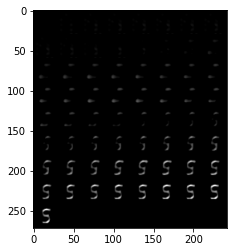

Epoch [382/400] Batch: [1/60] KL-Divergence: 0.033130012452602386 Cross-Entropy: 0.1949099451303482 Loss: 0.22803995013237
Epoch [382/400] Batch: [2/60] KL-Divergence: 0.030759437009692192 Cross-Entropy: 0.1963435858488083 Loss: 0.22710302472114563
Epoch [382/400] Batch: [3/60] KL-Divergence: 0.03249749913811684 Cross-Entropy: 0.19683732092380524 Loss: 0.22933481633663177
Epoch [382/400] Batch: [4/60] KL-Divergence: 0.03212741017341614 Cross-Entropy: 0.19427749514579773 Loss: 0.22640490531921387
Epoch [382/400] Batch: [5/60] KL-Divergence: 0.03281371667981148 Cross-Entropy: 0.19843445718288422 Loss: 0.2312481701374054
Epoch [382/400] Batch: [6/60] KL-Divergence: 0.03239640220999718 Cross-Entropy: 0.19933883845806122 Loss: 0.2317352443933487
Epoch [382/400] Batch: [7/60] KL-Divergence: 0.03206208720803261 Cross-Entropy: 0.19554965198040009 Loss: 0.2276117354631424
Epoch [382/400] Batch: [8/60] KL-Divergence: 0.031578969210386276 Cross-Entropy: 0.1958569586277008 Loss: 0.2274359315633773

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [382/400] Batch: [60/60] KL-Divergence: 0.03345819190144539 Cross-Entropy: 0.20056834816932678 Loss: 0.23402653634548187
Epoch [382/400] Batch: [60/60] KL-Divergence: 0.03345819190144539 Cross-Entropy: 0.20056834816932678 Loss: 0.23402653634548187


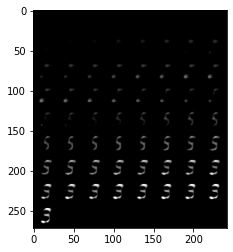

Epoch [383/400] Batch: [1/60] KL-Divergence: 0.03365333378314972 Cross-Entropy: 0.19393472373485565 Loss: 0.22758805751800537
Epoch [383/400] Batch: [2/60] KL-Divergence: 0.032532475888729095 Cross-Entropy: 0.1973235160112381 Loss: 0.2298559844493866
Epoch [383/400] Batch: [3/60] KL-Divergence: 0.03294719010591507 Cross-Entropy: 0.19686825573444366 Loss: 0.22981545329093933
Epoch [383/400] Batch: [4/60] KL-Divergence: 0.032885484397411346 Cross-Entropy: 0.1942702680826187 Loss: 0.22715574502944946
Epoch [383/400] Batch: [5/60] KL-Divergence: 0.03405334800481796 Cross-Entropy: 0.19886042177677155 Loss: 0.2329137623310089
Epoch [383/400] Batch: [6/60] KL-Divergence: 0.03186551481485367 Cross-Entropy: 0.19947579503059387 Loss: 0.23134130239486694
Epoch [383/400] Batch: [7/60] KL-Divergence: 0.03163645416498184 Cross-Entropy: 0.19592635333538055 Loss: 0.227562814950943
Epoch [383/400] Batch: [8/60] KL-Divergence: 0.0326109305024147 Cross-Entropy: 0.1966596245765686 Loss: 0.2292705476284027

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [383/400] Batch: [60/60] KL-Divergence: 0.03196171298623085 Cross-Entropy: 0.20123784244060516 Loss: 0.23319955170154572
Epoch [383/400] Batch: [60/60] KL-Divergence: 0.03196171298623085 Cross-Entropy: 0.20123784244060516 Loss: 0.23319955170154572


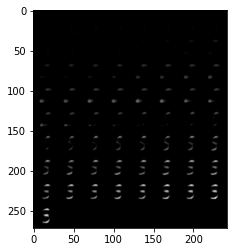

Epoch [384/400] Batch: [1/60] KL-Divergence: 0.031356655061244965 Cross-Entropy: 0.19627103209495544 Loss: 0.227627694606781
Epoch [384/400] Batch: [2/60] KL-Divergence: 0.03161906450986862 Cross-Entropy: 0.200408473610878 Loss: 0.23202753067016602
Epoch [384/400] Batch: [3/60] KL-Divergence: 0.03241545706987381 Cross-Entropy: 0.20089763402938843 Loss: 0.23331308364868164
Epoch [384/400] Batch: [4/60] KL-Divergence: 0.03130211681127548 Cross-Entropy: 0.19643719494342804 Loss: 0.22773930430412292
Epoch [384/400] Batch: [5/60] KL-Divergence: 0.03294413164258003 Cross-Entropy: 0.2011766880750656 Loss: 0.23412081599235535
Epoch [384/400] Batch: [6/60] KL-Divergence: 0.03213381767272949 Cross-Entropy: 0.19986993074417114 Loss: 0.23200374841690063
Epoch [384/400] Batch: [7/60] KL-Divergence: 0.03139544278383255 Cross-Entropy: 0.19871678948402405 Loss: 0.230112224817276
Epoch [384/400] Batch: [8/60] KL-Divergence: 0.030553635209798813 Cross-Entropy: 0.19779238104820251 Loss: 0.228346019983291

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [384/400] Batch: [60/60] KL-Divergence: 0.0326773002743721 Cross-Entropy: 0.20267212390899658 Loss: 0.23534941673278809
Epoch [384/400] Batch: [60/60] KL-Divergence: 0.0326773002743721 Cross-Entropy: 0.20267212390899658 Loss: 0.23534941673278809


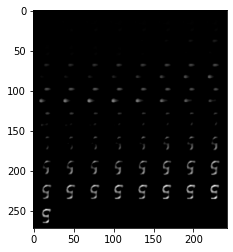

Epoch [385/400] Batch: [1/60] KL-Divergence: 0.03177890181541443 Cross-Entropy: 0.196371391415596 Loss: 0.22815029323101044
Epoch [385/400] Batch: [2/60] KL-Divergence: 0.0321589931845665 Cross-Entropy: 0.20027261972427368 Loss: 0.23243162035942078
Epoch [385/400] Batch: [3/60] KL-Divergence: 0.030948953703045845 Cross-Entropy: 0.2001015692949295 Loss: 0.2310505211353302
Epoch [385/400] Batch: [4/60] KL-Divergence: 0.030906977131962776 Cross-Entropy: 0.19785143435001373 Loss: 0.22875840961933136
Epoch [385/400] Batch: [5/60] KL-Divergence: 0.032839592546224594 Cross-Entropy: 0.20350365340709686 Loss: 0.23634324967861176
Epoch [385/400] Batch: [6/60] KL-Divergence: 0.03166904300451279 Cross-Entropy: 0.2023964524269104 Loss: 0.23406550288200378
Epoch [385/400] Batch: [7/60] KL-Divergence: 0.03169640898704529 Cross-Entropy: 0.19963350892066956 Loss: 0.23132991790771484
Epoch [385/400] Batch: [8/60] KL-Divergence: 0.0306223314255476 Cross-Entropy: 0.19841445982456207 Loss: 0.22903679311275

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [385/400] Batch: [60/60] KL-Divergence: 0.03247307613492012 Cross-Entropy: 0.20057731866836548 Loss: 0.2330503910779953
Epoch [385/400] Batch: [60/60] KL-Divergence: 0.03247307613492012 Cross-Entropy: 0.20057731866836548 Loss: 0.2330503910779953


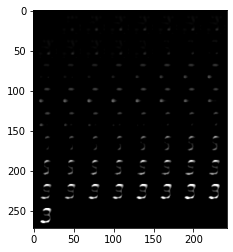

Epoch [386/400] Batch: [1/60] KL-Divergence: 0.03248293697834015 Cross-Entropy: 0.19389139115810394 Loss: 0.2263743281364441
Epoch [386/400] Batch: [2/60] KL-Divergence: 0.03123801201581955 Cross-Entropy: 0.19629575312137604 Loss: 0.227533757686615
Epoch [386/400] Batch: [3/60] KL-Divergence: 0.031911611557006836 Cross-Entropy: 0.1969723254442215 Loss: 0.22888393700122833
Epoch [386/400] Batch: [4/60] KL-Divergence: 0.03190954402089119 Cross-Entropy: 0.1944386512041092 Loss: 0.22634819149971008
Epoch [386/400] Batch: [5/60] KL-Divergence: 0.03372545167803764 Cross-Entropy: 0.19859178364276886 Loss: 0.2323172390460968
Epoch [386/400] Batch: [6/60] KL-Divergence: 0.03256836161017418 Cross-Entropy: 0.1981436312198639 Loss: 0.23071199655532837
Epoch [386/400] Batch: [7/60] KL-Divergence: 0.031989507377147675 Cross-Entropy: 0.19595587253570557 Loss: 0.22794538736343384
Epoch [386/400] Batch: [8/60] KL-Divergence: 0.03180878236889839 Cross-Entropy: 0.19558532536029816 Loss: 0.227394104003906

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [386/400] Batch: [60/60] KL-Divergence: 0.03185563534498215 Cross-Entropy: 0.20279298722743988 Loss: 0.23464861512184143
Epoch [386/400] Batch: [60/60] KL-Divergence: 0.03185563534498215 Cross-Entropy: 0.20279298722743988 Loss: 0.23464861512184143


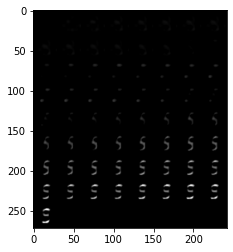

Epoch [387/400] Batch: [1/60] KL-Divergence: 0.03170930594205856 Cross-Entropy: 0.19571760296821594 Loss: 0.2274269163608551
Epoch [387/400] Batch: [2/60] KL-Divergence: 0.03200700506567955 Cross-Entropy: 0.20053090155124664 Loss: 0.2325379103422165
Epoch [387/400] Batch: [3/60] KL-Divergence: 0.03209889680147171 Cross-Entropy: 0.19873745739459991 Loss: 0.23083636164665222
Epoch [387/400] Batch: [4/60] KL-Divergence: 0.031130194664001465 Cross-Entropy: 0.1964651495218277 Loss: 0.22759534418582916
Epoch [387/400] Batch: [5/60] KL-Divergence: 0.032407261431217194 Cross-Entropy: 0.19998811185359955 Loss: 0.23239538073539734
Epoch [387/400] Batch: [6/60] KL-Divergence: 0.0326615646481514 Cross-Entropy: 0.2014903873205185 Loss: 0.2341519594192505
Epoch [387/400] Batch: [7/60] KL-Divergence: 0.03207535669207573 Cross-Entropy: 0.19686514139175415 Loss: 0.22894050180912018
Epoch [387/400] Batch: [8/60] KL-Divergence: 0.031067606061697006 Cross-Entropy: 0.1962592601776123 Loss: 0.22732686996459

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [387/400] Batch: [60/60] KL-Divergence: 0.0319267176091671 Cross-Entropy: 0.2033097892999649 Loss: 0.2352365106344223
Epoch [387/400] Batch: [60/60] KL-Divergence: 0.0319267176091671 Cross-Entropy: 0.2033097892999649 Loss: 0.2352365106344223


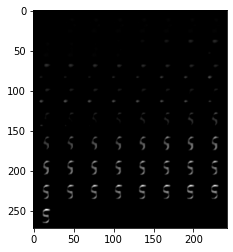

Epoch [388/400] Batch: [1/60] KL-Divergence: 0.031046396121382713 Cross-Entropy: 0.19637200236320496 Loss: 0.22741839289665222
Epoch [388/400] Batch: [2/60] KL-Divergence: 0.03099251538515091 Cross-Entropy: 0.2001320868730545 Loss: 0.231124609708786
Epoch [388/400] Batch: [3/60] KL-Divergence: 0.031391244381666183 Cross-Entropy: 0.19991205632686615 Loss: 0.23130330443382263
Epoch [388/400] Batch: [4/60] KL-Divergence: 0.030264515429735184 Cross-Entropy: 0.19844941794872284 Loss: 0.22871392965316772
Epoch [388/400] Batch: [5/60] KL-Divergence: 0.0331992581486702 Cross-Entropy: 0.20383824408054352 Loss: 0.2370375096797943
Epoch [388/400] Batch: [6/60] KL-Divergence: 0.03133447840809822 Cross-Entropy: 0.20255064964294434 Loss: 0.23388512432575226
Epoch [388/400] Batch: [7/60] KL-Divergence: 0.0301173385232687 Cross-Entropy: 0.19942037761211395 Loss: 0.2295377105474472
Epoch [388/400] Batch: [8/60] KL-Divergence: 0.029489759355783463 Cross-Entropy: 0.19917753338813782 Loss: 0.2286672890186

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [388/400] Batch: [60/60] KL-Divergence: 0.032993022352457047 Cross-Entropy: 0.20003406703472137 Loss: 0.23302708566188812
Epoch [388/400] Batch: [60/60] KL-Divergence: 0.032993022352457047 Cross-Entropy: 0.20003406703472137 Loss: 0.23302708566188812


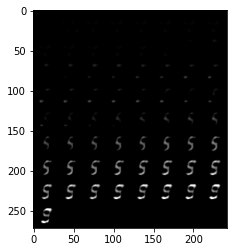

Epoch [389/400] Batch: [1/60] KL-Divergence: 0.03422875702381134 Cross-Entropy: 0.1942969113588333 Loss: 0.22852566838264465
Epoch [389/400] Batch: [2/60] KL-Divergence: 0.03180554881691933 Cross-Entropy: 0.19593262672424316 Loss: 0.2277381718158722
Epoch [389/400] Batch: [3/60] KL-Divergence: 0.03264950215816498 Cross-Entropy: 0.1951339989900589 Loss: 0.22778350114822388
Epoch [389/400] Batch: [4/60] KL-Divergence: 0.03344379737973213 Cross-Entropy: 0.19375751912593842 Loss: 0.22720131278038025
Epoch [389/400] Batch: [5/60] KL-Divergence: 0.034844979643821716 Cross-Entropy: 0.19864486157894135 Loss: 0.23348984122276306
Epoch [389/400] Batch: [6/60] KL-Divergence: 0.032478466629981995 Cross-Entropy: 0.19746673107147217 Loss: 0.22994519770145416
Epoch [389/400] Batch: [7/60] KL-Divergence: 0.0321614034473896 Cross-Entropy: 0.1956597864627838 Loss: 0.22782118618488312
Epoch [389/400] Batch: [8/60] KL-Divergence: 0.03229338675737381 Cross-Entropy: 0.19553439319133759 Loss: 0.2278277873992

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [389/400] Batch: [60/60] KL-Divergence: 0.03273899853229523 Cross-Entropy: 0.19955649971961975 Loss: 0.23229549825191498
Epoch [389/400] Batch: [60/60] KL-Divergence: 0.03273899853229523 Cross-Entropy: 0.19955649971961975 Loss: 0.23229549825191498


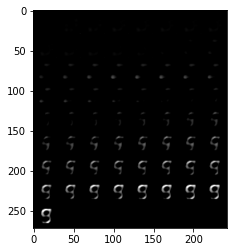

Epoch [390/400] Batch: [1/60] KL-Divergence: 0.032794129103422165 Cross-Entropy: 0.19316303730010986 Loss: 0.22595717012882233
Epoch [390/400] Batch: [2/60] KL-Divergence: 0.03237641230225563 Cross-Entropy: 0.19590795040130615 Loss: 0.22828435897827148
Epoch [390/400] Batch: [3/60] KL-Divergence: 0.03206014260649681 Cross-Entropy: 0.1955188661813736 Loss: 0.2275790125131607
Epoch [390/400] Batch: [4/60] KL-Divergence: 0.03238727152347565 Cross-Entropy: 0.19364818930625916 Loss: 0.2260354608297348
Epoch [390/400] Batch: [5/60] KL-Divergence: 0.0332784503698349 Cross-Entropy: 0.19699181616306305 Loss: 0.23027026653289795
Epoch [390/400] Batch: [6/60] KL-Divergence: 0.0326286219060421 Cross-Entropy: 0.19723883271217346 Loss: 0.22986745834350586
Epoch [390/400] Batch: [7/60] KL-Divergence: 0.031862273812294006 Cross-Entropy: 0.1943792849779129 Loss: 0.2262415587902069
Epoch [390/400] Batch: [8/60] KL-Divergence: 0.033059947192668915 Cross-Entropy: 0.1938551813364029 Loss: 0.226915121078491

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [390/400] Batch: [60/60] KL-Divergence: 0.03267357498407364 Cross-Entropy: 0.1996585875749588 Loss: 0.23233217000961304
Epoch [390/400] Batch: [60/60] KL-Divergence: 0.03267357498407364 Cross-Entropy: 0.1996585875749588 Loss: 0.23233217000961304


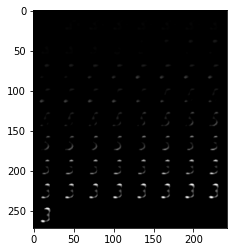

Epoch [391/400] Batch: [1/60] KL-Divergence: 0.033039819449186325 Cross-Entropy: 0.19371722638607025 Loss: 0.22675704956054688
Epoch [391/400] Batch: [2/60] KL-Divergence: 0.03270966559648514 Cross-Entropy: 0.19620728492736816 Loss: 0.2289169430732727
Epoch [391/400] Batch: [3/60] KL-Divergence: 0.033336181193590164 Cross-Entropy: 0.19545350968837738 Loss: 0.22878968715667725
Epoch [391/400] Batch: [4/60] KL-Divergence: 0.0336395762860775 Cross-Entropy: 0.19390146434307098 Loss: 0.22754104435443878
Epoch [391/400] Batch: [5/60] KL-Divergence: 0.034741077572107315 Cross-Entropy: 0.1978418231010437 Loss: 0.23258289694786072
Epoch [391/400] Batch: [6/60] KL-Divergence: 0.033558886498212814 Cross-Entropy: 0.20095953345298767 Loss: 0.23451842367649078
Epoch [391/400] Batch: [7/60] KL-Divergence: 0.03326224163174629 Cross-Entropy: 0.20064763724803925 Loss: 0.23390987515449524
Epoch [391/400] Batch: [8/60] KL-Divergence: 0.03424742817878723 Cross-Entropy: 0.20615869760513306 Loss: 0.240406125

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [391/400] Batch: [60/60] KL-Divergence: 0.03145352005958557 Cross-Entropy: 0.20201998949050903 Loss: 0.2334735095500946
Epoch [391/400] Batch: [60/60] KL-Divergence: 0.03145352005958557 Cross-Entropy: 0.20201998949050903 Loss: 0.2334735095500946


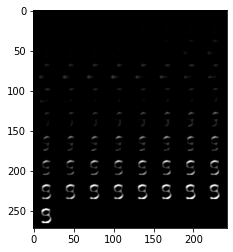

Epoch [392/400] Batch: [1/60] KL-Divergence: 0.03251037001609802 Cross-Entropy: 0.19503620266914368 Loss: 0.2275465726852417
Epoch [392/400] Batch: [2/60] KL-Divergence: 0.031614240258932114 Cross-Entropy: 0.19822703301906586 Loss: 0.22984127700328827
Epoch [392/400] Batch: [3/60] KL-Divergence: 0.03138577193021774 Cross-Entropy: 0.1971786618232727 Loss: 0.22856444120407104
Epoch [392/400] Batch: [4/60] KL-Divergence: 0.032127704471349716 Cross-Entropy: 0.19614841043949127 Loss: 0.2282761186361313
Epoch [392/400] Batch: [5/60] KL-Divergence: 0.03303385153412819 Cross-Entropy: 0.19888882339000702 Loss: 0.2319226711988449
Epoch [392/400] Batch: [6/60] KL-Divergence: 0.03292399272322655 Cross-Entropy: 0.19989675283432007 Loss: 0.23282074928283691
Epoch [392/400] Batch: [7/60] KL-Divergence: 0.03199712559580803 Cross-Entropy: 0.19648975133895874 Loss: 0.22848688066005707
Epoch [392/400] Batch: [8/60] KL-Divergence: 0.03202018514275551 Cross-Entropy: 0.1964208483695984 Loss: 0.2284410297870

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [392/400] Batch: [60/60] KL-Divergence: 0.033801693469285965 Cross-Entropy: 0.20042020082473755 Loss: 0.23422189056873322
Epoch [392/400] Batch: [60/60] KL-Divergence: 0.033801693469285965 Cross-Entropy: 0.20042020082473755 Loss: 0.23422189056873322


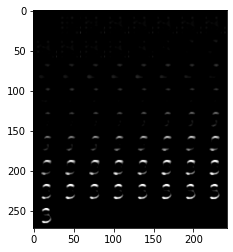

Epoch [393/400] Batch: [1/60] KL-Divergence: 0.032465286552906036 Cross-Entropy: 0.1938534677028656 Loss: 0.22631874680519104
Epoch [393/400] Batch: [2/60] KL-Divergence: 0.03148217871785164 Cross-Entropy: 0.1964857280254364 Loss: 0.22796790301799774
Epoch [393/400] Batch: [3/60] KL-Divergence: 0.03169919177889824 Cross-Entropy: 0.1957366019487381 Loss: 0.22743579745292664
Epoch [393/400] Batch: [4/60] KL-Divergence: 0.03211226314306259 Cross-Entropy: 0.19409945607185364 Loss: 0.22621172666549683
Epoch [393/400] Batch: [5/60] KL-Divergence: 0.03300153464078903 Cross-Entropy: 0.19745443761348724 Loss: 0.23045596480369568
Epoch [393/400] Batch: [6/60] KL-Divergence: 0.03236176073551178 Cross-Entropy: 0.1997608095407486 Loss: 0.23212257027626038
Epoch [393/400] Batch: [7/60] KL-Divergence: 0.03126101568341255 Cross-Entropy: 0.19598592817783356 Loss: 0.2272469401359558
Epoch [393/400] Batch: [8/60] KL-Divergence: 0.030761079862713814 Cross-Entropy: 0.1958240121603012 Loss: 0.22658509016036

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [393/400] Batch: [60/60] KL-Divergence: 0.03562328591942787 Cross-Entropy: 0.19929133355617523 Loss: 0.2349146157503128
Epoch [393/400] Batch: [60/60] KL-Divergence: 0.03562328591942787 Cross-Entropy: 0.19929133355617523 Loss: 0.2349146157503128


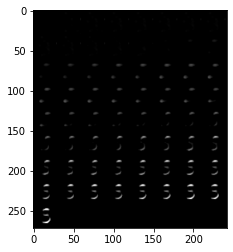

Epoch [394/400] Batch: [1/60] KL-Divergence: 0.035116828978061676 Cross-Entropy: 0.1924942135810852 Loss: 0.22761103510856628
Epoch [394/400] Batch: [2/60] KL-Divergence: 0.03519510477781296 Cross-Entropy: 0.19532856345176697 Loss: 0.23052367568016052
Epoch [394/400] Batch: [3/60] KL-Divergence: 0.03507564589381218 Cross-Entropy: 0.1955060511827469 Loss: 0.23058170080184937
Epoch [394/400] Batch: [4/60] KL-Divergence: 0.033701762557029724 Cross-Entropy: 0.19446775317192078 Loss: 0.2281695157289505
Epoch [394/400] Batch: [5/60] KL-Divergence: 0.036762338131666183 Cross-Entropy: 0.1989411562681198 Loss: 0.2357034981250763
Epoch [394/400] Batch: [6/60] KL-Divergence: 0.03444692865014076 Cross-Entropy: 0.1999983787536621 Loss: 0.23444530367851257
Epoch [394/400] Batch: [7/60] KL-Divergence: 0.032506342977285385 Cross-Entropy: 0.19423158466815948 Loss: 0.22673793137073517
Epoch [394/400] Batch: [8/60] KL-Divergence: 0.03329009562730789 Cross-Entropy: 0.19610446691513062 Loss: 0.229394555091

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [394/400] Batch: [60/60] KL-Divergence: 0.022749224677681923 Cross-Entropy: 0.2299625426530838 Loss: 0.25271177291870117
Epoch [394/400] Batch: [60/60] KL-Divergence: 0.022749224677681923 Cross-Entropy: 0.2299625426530838 Loss: 0.25271177291870117


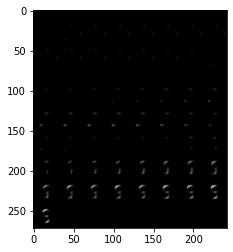

Epoch [395/400] Batch: [1/60] KL-Divergence: 0.022594494745135307 Cross-Entropy: 0.21695244312286377 Loss: 0.23954693973064423
Epoch [395/400] Batch: [2/60] KL-Divergence: 0.0226301122456789 Cross-Entropy: 0.21875804662704468 Loss: 0.24138815701007843
Epoch [395/400] Batch: [3/60] KL-Divergence: 0.023474259302020073 Cross-Entropy: 0.21865376830101013 Loss: 0.24212802946567535
Epoch [395/400] Batch: [4/60] KL-Divergence: 0.02306651882827282 Cross-Entropy: 0.2156423181295395 Loss: 0.23870883882045746
Epoch [395/400] Batch: [5/60] KL-Divergence: 0.02525498904287815 Cross-Entropy: 0.21862268447875977 Loss: 0.24387767910957336
Epoch [395/400] Batch: [6/60] KL-Divergence: 0.024437865242362022 Cross-Entropy: 0.21846753358840942 Loss: 0.242905393242836
Epoch [395/400] Batch: [7/60] KL-Divergence: 0.024496078491210938 Cross-Entropy: 0.21400390565395355 Loss: 0.2384999841451645
Epoch [395/400] Batch: [8/60] KL-Divergence: 0.024892766028642654 Cross-Entropy: 0.2123861163854599 Loss: 0.23727887868

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [395/400] Batch: [60/60] KL-Divergence: 0.02870127372443676 Cross-Entropy: 0.21273520588874817 Loss: 0.24143648147583008
Epoch [395/400] Batch: [60/60] KL-Divergence: 0.02870127372443676 Cross-Entropy: 0.21273520588874817 Loss: 0.24143648147583008


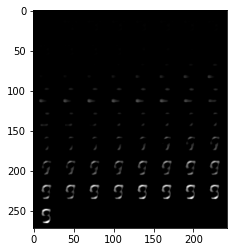

Epoch [396/400] Batch: [1/60] KL-Divergence: 0.029330726712942123 Cross-Entropy: 0.2057385891675949 Loss: 0.23506931960582733
Epoch [396/400] Batch: [2/60] KL-Divergence: 0.027285519987344742 Cross-Entropy: 0.20892086625099182 Loss: 0.23620638251304626
Epoch [396/400] Batch: [3/60] KL-Divergence: 0.028194593265652657 Cross-Entropy: 0.20948831737041473 Loss: 0.23768290877342224
Epoch [396/400] Batch: [4/60] KL-Divergence: 0.02719888649880886 Cross-Entropy: 0.20684897899627686 Loss: 0.23404785990715027
Epoch [396/400] Batch: [5/60] KL-Divergence: 0.029025638476014137 Cross-Entropy: 0.21015986800193787 Loss: 0.23918551206588745
Epoch [396/400] Batch: [6/60] KL-Divergence: 0.027817940339446068 Cross-Entropy: 0.20953398942947388 Loss: 0.2373519241809845
Epoch [396/400] Batch: [7/60] KL-Divergence: 0.027333693578839302 Cross-Entropy: 0.20710992813110352 Loss: 0.23444361984729767
Epoch [396/400] Batch: [8/60] KL-Divergence: 0.027518020942807198 Cross-Entropy: 0.2055957019329071 Loss: 0.233113

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [396/400] Batch: [60/60] KL-Divergence: 0.03080272674560547 Cross-Entropy: 0.20559275150299072 Loss: 0.2363954782485962
Epoch [396/400] Batch: [60/60] KL-Divergence: 0.03080272674560547 Cross-Entropy: 0.20559275150299072 Loss: 0.2363954782485962


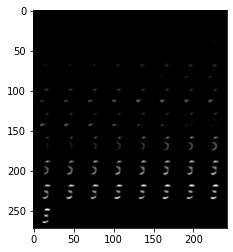

Epoch [397/400] Batch: [1/60] KL-Divergence: 0.031272634863853455 Cross-Entropy: 0.19885535538196564 Loss: 0.2301279902458191
Epoch [397/400] Batch: [2/60] KL-Divergence: 0.030728569254279137 Cross-Entropy: 0.20210911333560944 Loss: 0.23283767700195312
Epoch [397/400] Batch: [3/60] KL-Divergence: 0.03099956549704075 Cross-Entropy: 0.20185168087482452 Loss: 0.23285125195980072
Epoch [397/400] Batch: [4/60] KL-Divergence: 0.03180181235074997 Cross-Entropy: 0.1990886777639389 Loss: 0.23089048266410828
Epoch [397/400] Batch: [5/60] KL-Divergence: 0.03358956798911095 Cross-Entropy: 0.2012230008840561 Loss: 0.23481257259845734
Epoch [397/400] Batch: [6/60] KL-Divergence: 0.031162293627858162 Cross-Entropy: 0.20182807743549347 Loss: 0.23299036920070648
Epoch [397/400] Batch: [7/60] KL-Divergence: 0.030960502102971077 Cross-Entropy: 0.19896037876605988 Loss: 0.2299208790063858
Epoch [397/400] Batch: [8/60] KL-Divergence: 0.0314505472779274 Cross-Entropy: 0.1989000290632248 Loss: 0.230350583791

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [397/400] Batch: [60/60] KL-Divergence: 0.03158949688076973 Cross-Entropy: 0.20407460629940033 Loss: 0.23566409945487976
Epoch [397/400] Batch: [60/60] KL-Divergence: 0.03158949688076973 Cross-Entropy: 0.20407460629940033 Loss: 0.23566409945487976


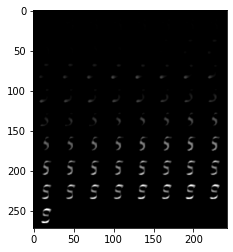

Epoch [398/400] Batch: [1/60] KL-Divergence: 0.03174470737576485 Cross-Entropy: 0.1970672309398651 Loss: 0.22881193459033966
Epoch [398/400] Batch: [2/60] KL-Divergence: 0.03107900358736515 Cross-Entropy: 0.19960111379623413 Loss: 0.23068012297153473
Epoch [398/400] Batch: [3/60] KL-Divergence: 0.03124253824353218 Cross-Entropy: 0.19907519221305847 Loss: 0.23031772673130035
Epoch [398/400] Batch: [4/60] KL-Divergence: 0.031336575746536255 Cross-Entropy: 0.19894450902938843 Loss: 0.23028108477592468
Epoch [398/400] Batch: [5/60] KL-Divergence: 0.031511541455984116 Cross-Entropy: 0.20133638381958008 Loss: 0.2328479290008545
Epoch [398/400] Batch: [6/60] KL-Divergence: 0.031209252774715424 Cross-Entropy: 0.2010921686887741 Loss: 0.23230141401290894
Epoch [398/400] Batch: [7/60] KL-Divergence: 0.030713485553860664 Cross-Entropy: 0.19736309349536896 Loss: 0.22807657718658447
Epoch [398/400] Batch: [8/60] KL-Divergence: 0.03059423342347145 Cross-Entropy: 0.19809050858020782 Loss: 0.228684738

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [398/400] Batch: [60/60] KL-Divergence: 0.03279779478907585 Cross-Entropy: 0.20100978016853333 Loss: 0.23380757868289948
Epoch [398/400] Batch: [60/60] KL-Divergence: 0.03279779478907585 Cross-Entropy: 0.20100978016853333 Loss: 0.23380757868289948


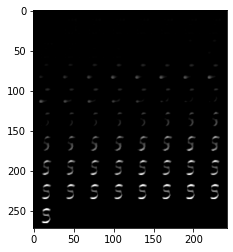

Epoch [399/400] Batch: [1/60] KL-Divergence: 0.03279176726937294 Cross-Entropy: 0.19450964033603668 Loss: 0.22730140388011932
Epoch [399/400] Batch: [2/60] KL-Divergence: 0.031371768563985825 Cross-Entropy: 0.19744183123111725 Loss: 0.22881360352039337
Epoch [399/400] Batch: [3/60] KL-Divergence: 0.03150860592722893 Cross-Entropy: 0.19797734916210175 Loss: 0.22948595881462097
Epoch [399/400] Batch: [4/60] KL-Divergence: 0.032150108367204666 Cross-Entropy: 0.19606289267539978 Loss: 0.22821299731731415
Epoch [399/400] Batch: [5/60] KL-Divergence: 0.03208731487393379 Cross-Entropy: 0.19992737472057343 Loss: 0.23201468586921692
Epoch [399/400] Batch: [6/60] KL-Divergence: 0.03269073739647865 Cross-Entropy: 0.20029467344284058 Loss: 0.23298540711402893
Epoch [399/400] Batch: [7/60] KL-Divergence: 0.032533444464206696 Cross-Entropy: 0.196692556142807 Loss: 0.2292259931564331
Epoch [399/400] Batch: [8/60] KL-Divergence: 0.03218894824385643 Cross-Entropy: 0.19737660884857178 Loss: 0.2295655608

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [399/400] Batch: [60/60] KL-Divergence: 0.032700758427381516 Cross-Entropy: 0.20025698840618134 Loss: 0.23295775055885315
Epoch [399/400] Batch: [60/60] KL-Divergence: 0.032700758427381516 Cross-Entropy: 0.20025698840618134 Loss: 0.23295775055885315


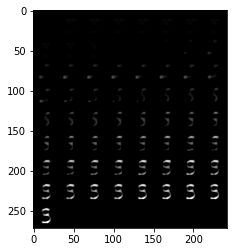

Epoch [400/400] Batch: [1/60] KL-Divergence: 0.03303324803709984 Cross-Entropy: 0.19331003725528717 Loss: 0.2263432890176773
Epoch [400/400] Batch: [2/60] KL-Divergence: 0.03288742154836655 Cross-Entropy: 0.19740840792655945 Loss: 0.2302958369255066
Epoch [400/400] Batch: [3/60] KL-Divergence: 0.03277023881673813 Cross-Entropy: 0.19615568220615387 Loss: 0.2289259135723114
Epoch [400/400] Batch: [4/60] KL-Divergence: 0.03323463350534439 Cross-Entropy: 0.1934618502855301 Loss: 0.22669649124145508
Epoch [400/400] Batch: [5/60] KL-Divergence: 0.03321583569049835 Cross-Entropy: 0.19807863235473633 Loss: 0.23129446804523468
Epoch [400/400] Batch: [6/60] KL-Divergence: 0.03237662464380264 Cross-Entropy: 0.1975170075893402 Loss: 0.22989362478256226
Epoch [400/400] Batch: [7/60] KL-Divergence: 0.03274953365325928 Cross-Entropy: 0.19549262523651123 Loss: 0.2282421588897705
Epoch [400/400] Batch: [8/60] KL-Divergence: 0.03253086656332016 Cross-Entropy: 0.19493064284324646 Loss: 0.2274615168571472

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [400/400] Batch: [60/60] KL-Divergence: 0.03244480863213539 Cross-Entropy: 0.20783261954784393 Loss: 0.24027742445468903
Epoch [400/400] Batch: [60/60] KL-Divergence: 0.03244480863213539 Cross-Entropy: 0.20783261954784393 Loss: 0.24027742445468903


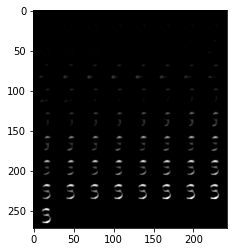

In [6]:
torch.autograd.set_detect_anomaly(False)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

# Model Parameters
params = {
    'img_shape': (1,28,28),
    'hidden_dim': 256,
    'z_dim': 100,
    'num_glimpses': 64,
    'read_size': 2,
    'write_size': 5,
    'attention': True
}

model = DRAW(**params).to(device)
optimizer = torch.optim.Adam(model.parameters())

# Training Data
batch_size = 1000
transform = transforms.Compose([ transforms.ToTensor() ])
mnist = datasets.MNIST('../datasets', transform=transform)
mnist_loader = DataLoader(mnist, batch_size=batch_size)
show(make_grid(next(iter(mnist_loader))[0]))

# Training States
num_epochs = 400
losses = []
kls = []
ces = []

for e in range(num_epochs):
    for batch_idx, (x,_) in enumerate(mnist_loader):
        x = x.to(device)
        optimizer.zero_grad()
        cs, l_x, l_z, _ = model(x, device)
        loss = l_x + l_z
        loss.backward()
        optimizer.step()
        
        print(f'Epoch [{e+1}/{num_epochs}] Batch: [{batch_idx+1}/{len(mnist_loader)}] KL-Divergence: {l_z.item()} Cross-Entropy: {l_x.item()} Loss: {loss.item()}')
        
        losses.append(loss.item())
        kls.append(l_z.item())
        ces.append(l_x.item())
    
    print(f'Epoch [{e+1}/{num_epochs}] Batch: [{batch_idx+1}/{len(mnist_loader)}] KL-Divergence: {l_z.item()} Cross-Entropy: {l_x.item()} Loss: {loss.item()}')
    show_cs(cs)


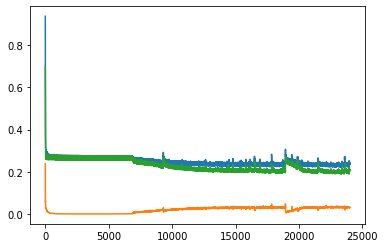

In [9]:
plt.plot(losses)
plt.plot(kls)
plt.plot(ces)


In [10]:
from datetime import datetime
timestamp = datetime.now().strftime('%m-%d-%Y-%H:%M:%S')

# Save Checkpoint and Records
PATH = f'./checkpoints/{timestamp}-mnist.pt'

torch.save({
        'epoch': e,
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        #'scheduler_state_dict': scheduler.state_dict(),
        'params': params,
        'batch_size': batch_size,
        'num_epochs': num_epochs
    }, PATH)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


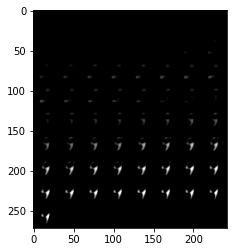

In [18]:
cs = model.sample(2, device)
show_cs(cs)

# TODO, Integrate Weight normalization + Visual Display of read write 

In [ ]:
def display_ctrl(cs: dict, ctrls: dict) -> dict:
    for k, _ in cs.items():
        c = cs[k]
        g_x,g_y,var,delta,gamma = ctrls[k]
        
    return